# Import modules

In [1]:
%%time

%load_ext memory_profiler

import datetime
print(datetime.datetime.now())

import os, glob, sys
import warnings
warnings.filterwarnings('ignore', '.*invalid value encountered in true_divide.*', )

from dask.distributed import Client
from dask.diagnostics import ProgressBar
pbar = ProgressBar(minimum=1)
pbar.register()
#pbar.unregister()

import subprocess

import pickle

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.crs       as ccrs
import cartopy
import cartopy.feature as cfeature

import random

import PyCO2SYS

import xesmf as xe

from matplotlib import cm
from matplotlib.colors import ListedColormap

mpl.rcParams['savefig.dpi'] = 300

2023-11-29 10:57:51.928101
CPU times: user 1.57 s, sys: 1.62 s, total: 3.19 s
Wall time: 1.71 s


# Starters

In [2]:
%%time
print(datetime.datetime.now())

dirout = 'cc2300-230215-noresm2-lm/'

if not os.path.isdir(dirout) : os.mkdir(dirout)

2023-11-29 10:57:54.845807
CPU times: user 154 µs, sys: 132 µs, total: 286 µs
Wall time: 267 µs


In [3]:
%%time
print(datetime.datetime.now())
sys.stdout.echo = open(dirout+'stdout.txt', 'w')
sys.stderr.echo = open(dirout+'stderr.txt', 'w')

2023-11-29 10:57:55.001647
CPU times: user 1.3 ms, sys: 259 µs, total: 1.56 ms
Wall time: 59.5 ms


# Input parameters

In [4]:
%%time
print(datetime.datetime.now())

kwopends=dict(use_cftime=True, decode_times=None,
              decode_cf=True, decode_coords=True)
kwopenmfds = dict(combine='by_coords', parallel=True, 
                  use_cftime=True, decode_times=None,
                  decode_cf=True, decode_coords=True)
dirshared = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/CC2300/SHARED-DATAS/'

2023-11-29 10:57:55.755923
CPU times: user 128 µs, sys: 109 µs, total: 237 µs
Wall time: 209 µs


# Load grid

In [5]:
%%time
print(datetime.datetime.now())
fgrid = '/mnt/reef-ns1002k/daco/grid_tnx1v4.nc'
grid  = xr.open_dataset(fgrid)

2023-11-29 10:57:56.286634
CPU times: user 17 ms, sys: 8.83 ms, total: 25.9 ms
Wall time: 65.6 ms


# Define figure parameters

In [6]:
%%time
print(datetime.datetime.now())

mpl.rcParams['font.size'] = 8
cm2in = 1/2.54

2023-11-29 10:57:58.019960
CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 65.8 µs


# Define some common functions

## mapping function

In [7]:
%%time
print(datetime.datetime.now())

def map_whole_globe(zwdataarray, zwax=None, zwcbShrink=.4, zwcbLabel='', zwcbExtend='both', **pcmkwargs): 
    """
    Plot the input DataArray 
    zwax are GeoAxes created with cartopy
    e.g.:
        lonlatproj = ccrs.PlateCarree()
        ccrsproj = ccrs.Robinson(central_longitude=-155)
        fig = plt.figure(figsize = (10, 10))
        ax = plt.axes(projection=ccrsproj)
        pcmkwargs = dict(transform=lonlatproj)
        map_whole_globe(zwda, ax, **pcmkwargs)
    if None (default), theyr are created within the function
    """
    print('func: map_whole_globe')
    
    try:
        pcmkwargs
    except NameError:
        pcmkwargs_exists = False
    else:
        pcmkwargs_exists = True
    #
    
    XXX = zwdataarray['plon'].values
    YYY = zwdataarray['plat'].values
    ZZZ = zwdataarray.values
    if not zwax is None: 
        zwlonlatproj = ccrs.PlateCarree()
        if pcmkwargs_exists: 
            if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
        else: pcmkwargs={'transform':zwlonlatproj}
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    else: 
        print("WARNING! zwax is None, create zwfig and zwax")
        zwccrsproj = ccrs.Robinson(central_longitude=-155)
        zwfig = plt.figure(figsize = (10, 10))
        zwax = plt.axes(projection=zwccrsproj)
        zwlonlatproj = ccrs.PlateCarree()
        if pcmkwargs_exists: 
            if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
        else: pcmkwargs={'transform':zwlonlatproj}
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    #
    zwax.add_feature(cfeature.COASTLINE)
    zwax.add_feature(cfeature.LAND)
    zwax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                   color='k', linestyle='dashed', linewidth=0.5)
    zwax.set_global()

    plt.colorbar(zwpcm, ax=zwax, shrink=zwcbShrink, label=zwcbLabel, extend=zwcbExtend)
    return zwpcm
#

def map_orthographic(zwdataarray, zoombox, \
             zwax=None, zwcbShrink=.4, zwcbLabel='', zwcbExtend='both', **pcmkwargs): 
    """
    Plot the input DataArray 
    zoombox either indicate the center [clon, clat] of the Orthographic projection (list of 2) 
        or the bounds of the projection [lonmin, lonmax, latmin, latmax]
    zwax are GeoAxes created with cartopy
    e.g.:
        lonlatproj = ccrs.PlateCarree()
        ccrsproj = ccrs.Orthographic(central_longitude=-20, central_latitude=-25)
        fig = plt.figure(figsize = (10, 10))
        ax = plt.axes(projection=ccrsproj)
        pcmkwargs = dict(transform=lonlatproj)
        map_whole_globe(zwda, ax, **pcmkwargs)
    if zwax = None (default), they are created within the function
    """
    print('func: map_orthographic')
    
    try:
        pcmkwargs
    except NameError:
        pcmkwargs_exists = False
    else:
        pcmkwargs_exists = True
    #

    zwlonlatproj = ccrs.PlateCarree()
    if pcmkwargs_exists: 
        if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
    else: pcmkwargs={'transform':zwlonlatproj}

    if len(zoombox)==4: 
        lonmin, lonmax, latmin, latmax = zoombox
        clon, clat = lonmin+.5*(lonmax-lonmin), latmin+.5*(latmax-latmin)
    elif len(zoombox)==2: clon, clat= zoombox
    else: sys.exit('ERROR! Check zoombox, it should be a list of length 2 or 4')
    
    XXX = zwdataarray['plon'].values
    YYY = zwdataarray['plat'].values
    ZZZ = zwdataarray.values
    if not zwax is None: 
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    else: 
        print("WARNING! zwax is None, create zwfig and zwax")
        zwccrsproj = ccrs.Orthographic(central_longitude=clon, central_latitude=clat)
        zwfig = plt.figure(figsize = (10, 10))
        zwax = plt.axes(projection=zwccrsproj)
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    #
    zwax.add_feature(cfeature.COASTLINE)
    zwax.add_feature(cfeature.LAND)
    zwax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                   color='k', linestyle='dashed', linewidth=0.5)
    if len(zoombox)==4 : 
        xmin, _ = zwax.projection.transform_point(lonmin, clat, zwlonlatproj)  
        xmax, _ = zwax.projection.transform_point(lonmax, clat, zwlonlatproj)  
        _, ymin = zwax.projection.transform_point(clon, latmin, zwlonlatproj)  
        _, ymax = zwax.projection.transform_point(clon, latmax, zwlonlatproj) 
        zwax.set_extent([xmin,xmax,ymin,ymax], crs=zwax.projection)
    #
    plt.colorbar(zwpcm, ax=zwax, shrink=zwcbShrink, label=zwcbLabel, extend=zwcbExtend)
    return zwpcm
#

def add_gridlines_coastline_and_land(zax): 
    print('func: add_gridlines_coastline_and_land')
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER, LatitudeFormatter, LongitudeFormatter
    
    zax.add_feature(cfeature.COASTLINE, linewidth=.5)
    zax.add_feature(cfeature.LAND)
    zax.set_global()
    
    gl = zax.gridlines(draw_labels=['left', 'right'], 
                       x_inline=False, y_inline=False,
                       xlocs = mticker.FixedLocator([-120, -60, 0, 60, 120, 180]), 
                       xlabel_style = {'size': 'x-small'}, 
                       ylocs = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60]), 
                       ylabel_style = {'size': 'x-small'}, dms=True,
                       color='k', linestyle='dashed', linewidth=0.5, alpha=.5)
    # gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
    # gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    # gl.top_labels = False
    # gl.bottom_labels = False
    # gl.left_labels = False
    # gl.right_labels = True
    # gl.xlines = True
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER
    # gl.ylabel_style = {'size': 'x-small'}
    # gl.xlabel_style = {'size': 'x-small'}
    return gl
#


2023-11-29 10:57:58.912509
CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 62.9 µs


## Other functions

In [8]:
%%time
print(datetime.datetime.now())

def chunker(seq, size):
    """
    Works with any sequence:
    
    text = "I am a very, very helpful text"

    for group in chunker(text, 7):
    print(repr(group),)
    # 'I am a ' 'very, v' 'ery hel' 'pful te' 'xt'

    print('|'.join(chunker(text, 10)))
    # I am a ver|y, very he|lpful text

    animals = ['cat', 'dog', 'rabbit', 'duck', 'bird', 'cow', 'gnu', 'fish']

    for group in chunker(animals, 3):
    print(group)
    # ['cat', 'dog', 'rabbit']
    # ['duck', 'bird', 'cow']
    # ['gnu', 'fish']
    """
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
#

def select_months(zwinp, mmm, verbose=True):
    """
    select_months(zwinp, mmm)
    return month mmm for each year
    mmm is an integer between 1 and 12, january is 1
    zwinp is a DataArray
    """
    if mmm in np.arange(1, 13): 
        month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
        if verbose: print('func: select_month(%s, %s)'%(zwinp.name, month_list[mmm-1]))
        return zwinp.isel(time=zwinp.groupby('time.month').groups[mmm])
    else: sys.exit('ERROR! The month number (mmm) has to be an integer between 1 and 12')
#

def load_and_concat_hist_ssp(zvar, zscenar, zsavedfile='cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl', verbose=True): 
    if verbose: print('func: load_and_concat_hist_ssp(%s, %s, zsavefile=%s)'%(zvar, zscenar, zsavedfile))
    with open(zsavedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    if verbose: print("Done, loaded file: "+zsavedfile)
    zwhist = loadeddatas[zvar]['historical']
    zwssp = loadeddatas[zvar][zscenar]
    return xr.concat([zwhist, zwssp], dim='time')
#

def load_hist_ssp_and_select_month(zvar, zscenar, mmm, **kwargs): 
    zw = load_and_concat_hist_ssp(zvar, zscenar, **kwargs)
    return select_months(zw, mmm)
#

def load_hist_ssp_and_select_seas(zvar, zscenar, zseas, **kwargs): 
    zw = load_and_concat_hist_ssp(zvar, zscenar, **kwargs)
    return select_season(zw, zseas)
#

def select_season(zdat, zseas, verbose=True): 
    if verbose: print('func: select_season')
    if zseas == 'JFM': 
        output = xr.concat([select_months(zdat, 1, verbose=verbose), 
                            select_months(zdat, 2, verbose=verbose), 
                            select_months(zdat, 3, verbose=verbose)], 'time').sortby('time').chunk('auto').groupby('time.year').mean(dim='time')
    elif zseas == 'AMJ': 
        output = xr.concat([select_months(zdat, 4, verbose=verbose), 
                            select_months(zdat, 5, verbose=verbose), 
                            select_months(zdat, 6, verbose=verbose)], 'time').sortby('time').chunk('auto').groupby('time.year').mean(dim='time')
    elif zseas == 'JAS': 
        output = xr.concat([select_months(zdat, 7, verbose=verbose), 
                            select_months(zdat, 8, verbose=verbose), 
                            select_months(zdat, 9, verbose=verbose)], 'time').sortby('time').chunk('auto').groupby('time.year').mean(dim='time')
    elif zseas == 'OND': 
        output = xr.concat([select_months(zdat, 10, verbose=verbose), 
                            select_months(zdat, 11, verbose=verbose), 
                            select_months(zdat, 12, verbose=verbose)], 'time').sortby('time').chunk('auto').groupby('time.year').mean(dim='time')
    else: exit('Wrong season name!!! It must be JFM, AMJ, JAS or OND')
    #
    if 'history' in output.attrs: output.attrs['history'] =  'Average on '+zseas + ' ; ' + output.attrs['history']
    else: output.attrs['history'] =  'Average on '+zseas 
    return output
#

def NumpyArray_to_DataArray(zwNP, zwrename, zwrefDA, nwattrs={}, force_nwattrs=False): 
    """
    Return a DataArray containing the values from the numpy array (zwnp)
    zwrefDA is the reference DataArray for creating the new DataArray
    zwrename to name the new variable in the DataArray
    Attributes from zwrefDA are passed to the returned DataArray
    New attributes can be added passing a dictionnary to nwattrs
    """
    print("func: NumpyArray_to_DataArray")
    
    zwda = xr.zeros_like(zwrefDA)
    zwda = zwda.rename(zwrename)
    zwda.attrs = zwrefDA.attrs
    for kkk, vvv in nwattrs.items(): 
        if not kkk in zwrefDA.attrs.keys(): zwda.attrs[kkk]=vvv
        elif kkk in ['description', 'history']: zwda.attrs[kkk] = vvv+' ; '+zwda.attrs[kkk]
        elif force_nwattrs: zwda.attrs[kkk]=vvv
        else: sys.exit('Check nwattrs and zwrefDA.attrs')
    #
    zwda.values = zwNP
    return zwda
#


2023-11-29 10:57:59.733464
CPU times: user 177 µs, sys: 14 µs, total: 191 µs
Wall time: 182 µs


# Load and save datas

## Load and save data in netcdf for making later calculation fasters

In [ ]:
%%time
print(datetime.datetime.now())
print('Load and save data in netcdf for making later calculation fasters')

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'

simu_list = ['ssp126', 'ssp585', 'preindustrial']
#simu_list = ['preindustrial', 'historical', 'ssp126', 'ssp585']
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

# var_list = ['ssali']
var_list = ['cflx-tot', 'cflx-nat', 'pco2-tot', 'sdic-tot', 'salk-tot', 'stemp', 'ssali']
var_names = {'cflx-tot': 'co2fxd'   , 
             'cflx-nat': 'natco2fx' ,
             'pco2-tot': 'pco2'     , 
             'sdic-tot': 'dissiclvl', 
             'salk-tot': 'talklvl'  , 
             'stemp'   : 'sst'      ,
             'ssali'   : 'sss'      }

kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulations')

for simu in simu_list: 
    
    print('> simu: '+simu)

    fbgc = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hbgcm.*.nc'
    fphy = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hm.*.nc'

    fnamebgc = glob.glob(fbgc)
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fbgc = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hbgcm.*.nc'
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hm.*.nc'
        fnamebgc.extend(glob.glob(fbgc))
        fnamephy.extend(glob.glob(fphy))
    #

    #######################
    # Loop on variables
    #######################
    print('> Loop on variables')
    
    for var in var_list: 
    
        print('>> var: '+var)
        
        if not os.path.isdir(dirout+'workingdir') :
            command = ["mkdir", dirout+'workingdir']
            ppp = subprocess.run(command, **kwsubprocess)
            print(ppp.stdout)

        #######################
        # Loop on files
        #######################
        print('>>> Loop on files, extract variables')
        print(datetime.datetime.now())
        
        for ifname, (zwfnamebgc, zwfnamephy) in enumerate(zip(fnamebgc, fnamephy)): 
            zwoutfname = dirout+'workingdir/zwout'+str(ifname)+'.nc'
            if var=='cflx-tot': 
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                 # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-sub", dirout+'workingdir/zwco2fxd.nc', \
                           dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu=='preindustrial'): 
                print('In preindustrial, cflx-nat = cflx-tot')
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp)
                # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-chname,co2fxd,natco2fx", "-sub", \
                           dirout+'workingdir/zwco2fxd.nc', dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # kgC.m-2.s-1, air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-mulc,-1.", "-selname,natco2fx", zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['sdic-tot', 'salk-tot']: 
                # sdic-tot in mol.m-3 or mmol.l-1, salk-tot in m-3
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['stemp', 'ssali']:
                # sst in Celsius, sss in g.kg-1
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamephy, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['pco2-tot', 'atmco2']:
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            else: exit('Variable not in the list')
        #
        
        #######################
        # Merge files
        #######################
        print('>>> Merge files')
        print(datetime.datetime.now())
        command = ["cdo", "-b", "32", "-mergetime", dirout+'workingdir/zwout*.nc', dirout+'workingdir/zwout.nc']
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)
        
        #######################
        # Change variable name
        #######################
        print('>>> Change variable name')
        print(datetime.datetime.now())
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        command = ["cdo", "-b", "32", "-chname,"+var_names[var]+","+var, dirout+'workingdir/zwout.nc', savedfile] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

        command = ["rm", "-Rf", dirout+'workingdir/'] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

    #
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
#



# ca. 2h par simu

2023-02-28 10:26:07.507867
Load and save data in netcdf for making later calculation fasters
Loop on simulations
> simu: ssp126
> Loop on variables
>> var: cflx-tot

>>> Loop on files, extract variables
2023-02-28 10:26:08.071926
>>> Merge files
2023-02-28 11:00:46.699148
cdo mergetime: Processed 474012000 values from 3420 variables over 3420 timesteps [12.81s 2432MB]

>>> Change variable name
2023-02-28 11:01:00.526172
cdo chname: Processed 474012000 values from 1 variable over 3420 timesteps [3.37s 116MB]


>> var: cflx-nat

>>> Loop on files, extract variables
2023-02-28 11:01:04.476651
>>> Merge files
2023-02-28 11:25:29.102298
cdo mergetime: Processed 474012000 values from 3420 variables over 3420 timesteps [13.15s 2430MB]

>>> Change variable name
2023-02-28 11:26:14.049577
cdo chname: Processed 474012000 values from 1 variable over 3420 timesteps [3.42s 116MB]


>> var: pco2-tot

>>> Loop on files, extract variables
2023-02-28 11:26:18.105301
>>> Merge files
2023-02-28 11:50:49.

## Load and save atmco2 in netcdf for making later calculation fasters

In [ ]:
%%time
print(datetime.datetime.now())
print('Load and save atmco2 in netcdf for making later calculation fasters')

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'

simu_list = ['historical', 'ssp126', 'ssp585', 'preindustrial']
#simu_list = ['preindustrial', 'historical', 'ssp126', 'ssp585']
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

# var_list = ['ssali']
var_list = ['atmco2']
var_names = {'cflx-tot': 'co2fxd'   , 
             'cflx-nat': 'natco2fx' ,
             'pco2-tot': 'pco2'     , 
             'sdic-tot': 'dissiclvl', 
             'salk-tot': 'talklvl'  , 
             'stemp'   : 'sst'      ,
             'ssali'   : 'sss'      , 
             'atmco2': 'atmco2'}

kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulations')

for simu in simu_list: 
    
    print('> simu: '+simu)

    fbgc = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hbgcm.*.nc'
    fphy = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hm.*.nc'

    fnamebgc = glob.glob(fbgc)
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fbgc = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hbgcm.*.nc'
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hm.*.nc'
        fnamebgc.extend(glob.glob(fbgc))
        fnamephy.extend(glob.glob(fphy))
    #

    #######################
    # Loop on variables
    #######################
    print('> Loop on variables')
    
    for var in var_list: 
    
        print('>> var: '+var)
        
        if not os.path.isdir(dirout+'workingdir') :
            command = ["mkdir", dirout+'workingdir']
            ppp = subprocess.run(command, **kwsubprocess)
            print(ppp.stdout)

        #######################
        # Loop on files
        #######################
        print('>>> Loop on files, extract variables')
        print(datetime.datetime.now())
        
        for ifname, (zwfnamebgc, zwfnamephy) in enumerate(zip(fnamebgc, fnamephy)): 
            zwoutfname = dirout+'workingdir/zwout'+str(ifname)+'.nc'
            if var=='cflx-tot': 
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                 # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-sub", dirout+'workingdir/zwco2fxd.nc', \
                           dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu=='preindustrial'): 
                print('In preindustrial, cflx-nat = cflx-tot')
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp)
                # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-chname,co2fxd,natco2fx", "-sub", \
                           dirout+'workingdir/zwco2fxd.nc', dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # kgC.m-2.s-1, air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-mulc,-1.", "-selname,natco2fx", zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['sdic-tot', 'salk-tot']: 
                # sdic-tot in mol.m-3 or mmol.l-1, salk-tot in m-3
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['stemp', 'ssali']:
                # sst in Celsius, sss in g.kg-1
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamephy, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['pco2-tot', 'atmco2']:
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            else: exit('Variable not in the list')
        #
        
        #######################
        # Merge files
        #######################
        print('>>> Merge files')
        print(datetime.datetime.now())
        command = ["cdo", "-b", "32", "-mergetime", dirout+'workingdir/zwout*.nc', dirout+'workingdir/zwout.nc']
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)
        
        #######################
        # Change variable name
        #######################
        print('>>> Change variable name')
        print(datetime.datetime.now())
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        command = ["cdo", "-b", "32", "-chname,"+var_names[var]+","+var, dirout+'workingdir/zwout.nc', savedfile] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

        command = ["rm", "-Rf", dirout+'workingdir/'] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

    #
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
#



# ca. 2h par simu

2023-09-15 12:03:16.907989
Load and save atmco2 in netcdf for making later calculation fasters
Loop on simulations
> simu: historical
> Loop on variables
>> var: atmco2

>>> Loop on files, extract variables
2023-09-15 12:03:16.933680
>>> Merge files
2023-09-15 12:10:41.817951
cdo    mergetime: Processed 1980 variables over 1980 timesteps [23.18s 1551MB].

>>> Change variable name
2023-09-15 12:11:05.130054
cdo    chname: Processed 1 variable over 1980 timesteps [1.29s 405MB].


> simu: ssp126
> Loop on variables
>> var: atmco2

>>> Loop on files, extract variables
2023-09-15 12:11:06.716584
>>> Merge files
2023-09-15 12:37:07.153292
cdo    mergetime: Processed 3420 variables over 3420 timesteps [39.87s 2637MB].

>>> Change variable name
2023-09-15 12:37:47.206148
cdo    chname: Processed 1 variable over 3420 timesteps [2.33s 405MB].


> simu: preindustrial
> Loop on variables
>> var: atmco2

>>> Loop on files, extract variables
2023-09-15 12:37:49.885466


## Load and save pco2-nat in netcdf for making later calculation fasters

In [16]:
%%time
print(datetime.datetime.now())
print('Load and save pco2-nat in netcdf for making later calculation fasters')

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'

# simu_list = ['historical', 'ssp126', 'ssp585', 'preindustrial']
simu_list = ['preindustrial']
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

# var_list = ['ssali']
var_list = ['pco2-nat']
var_names = {'cflx-tot': 'co2fxd'   , 
             'cflx-nat': 'natco2fx' ,
             'pco2-tot': 'pco2'     , 
             'pco2-nat': 'natpco2'     , 
             'sdic-tot': 'dissiclvl', 
             'salk-tot': 'talklvl'  , 
             'stemp'   : 'sst'      ,
             'ssali'   : 'sss'      , 
             'atmco2'  : 'atmco2'}

kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulations')

for simu in simu_list: 
    
    print('> simu: '+simu)

    fbgc = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hbgcm.*.nc'
    fphy = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hm.*.nc'

    fnamebgc = glob.glob(fbgc)
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fbgc = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hbgcm.*.nc'
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hm.*.nc'
        fnamebgc.extend(glob.glob(fbgc))
        fnamephy.extend(glob.glob(fphy))
    #

    #######################
    # Loop on variables
    #######################
    print('> Loop on variables')
    
    for var in var_list: 
    
        print('>> var: '+var)
        
        if not os.path.isdir(dirout+'workingdir') :
            command = ["mkdir", dirout+'workingdir']
            ppp = subprocess.run(command, **kwsubprocess)
            print(ppp.stdout)

        #######################
        # Loop on files
        #######################
        print('>>> Loop on files, extract variables')
        print(datetime.datetime.now())
        
        for ifname, (zwfnamebgc, zwfnamephy) in enumerate(zip(fnamebgc, fnamephy)): 
            zwoutfname = dirout+'workingdir/zwout'+str(ifname)+'.nc'
            if var=='cflx-tot': 
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                 # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-sub", dirout+'workingdir/zwco2fxd.nc', \
                           dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu=='preindustrial'): 
                print('In preindustrial, cflx-nat = cflx-tot')
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp)
                # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-chname,co2fxd,natco2fx", "-sub", \
                           dirout+'workingdir/zwco2fxd.nc', dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # kgC.m-2.s-1, air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-mulc,-1.", "-selname,natco2fx", zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['sdic-tot', 'salk-tot']: 
                # sdic-tot in mol.m-3 or mmol.l-1, salk-tot in m-3
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['stemp', 'ssali']:
                # sst in Celsius, sss in g.kg-1
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamephy, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['pco2-tot', 'atmco2']:
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='pco2-nat') & (simu=='preindustrial'): 
                print('In preindustrial, pco2-nat = pco2-tot')
                # pco2 in uatm
                command = ["cdo", "-b", "32", "-chname,"+var_names['pco2-tot']+","+var_names['pco2-nat'], \
                           "-selname,"+var_names['pco2-tot'], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='pco2-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            else: exit('Variable not in the list')
        #
        
        #######################
        # Merge files
        #######################
        print('>>> Merge files')
        print(datetime.datetime.now())
        command = ["cdo", "-b", "32", "-mergetime", dirout+'workingdir/zwout*.nc', dirout+'workingdir/zwout.nc']
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)
        
        #######################
        # Change variable name
        #######################
        print('>>> Change variable name')
        print(datetime.datetime.now())
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        command = ["cdo", "-b", "32", "-chname,"+var_names[var]+","+var, dirout+'workingdir/zwout.nc', savedfile] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

        command = ["rm", "-Rf", dirout+'workingdir/'] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

    #
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
#



# ca. 2h par simu

2023-09-15 15:13:41.622635
Load and save pco2-nat in netcdf for making later calculation fasters
Loop on simulations
> simu: preindustrial
> Loop on variables
>> var: pco2-nat
>>> Loop on files, extract variables
2023-09-15 15:13:41.669609
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot
In preindustrial, pco2-nat = pco2-tot


## Load and save sdic-nat and salk-nat in netcdf for making later calculation fasters

In [56]:
%%time
print(datetime.datetime.now())
print('Load and save pco2-nat in netcdf for making later calculation fasters')

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'

simu_list = ['historical', 'ssp126', 'ssp585', 'preindustrial']
# simu_list = ['preindustrial']
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

# var_list = ['ssali']
var_list = ['sdic-nat', 'salk-nat']
var_names = {'cflx-tot': 'co2fxd'      , 
             'cflx-nat': 'natco2fx'    ,
             'pco2-tot': 'pco2'        , 
             'pco2-nat': 'natpco2'     , 
             'sdic-tot': 'dissiclvl'   , 
             'salk-tot': 'talklvl'     , 
             'sdic-nat': 'natdissiclvl', 
             'salk-nat': 'nattalklvl'  , 
             'stemp'   : 'sst'         ,
             'ssali'   : 'sss'         , 
             'atmco2'  : 'atmco2'      }

kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulations')

for simu in simu_list: 
    
    print('> simu: '+simu)

    fbgc = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hbgcm.*.nc'
    fphy = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hm.*.nc'

    fnamebgc = glob.glob(fbgc)
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fbgc = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hbgcm.*.nc'
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hm.*.nc'
        fnamebgc.extend(glob.glob(fbgc))
        fnamephy.extend(glob.glob(fphy))
    #

    #######################
    # Loop on variables
    #######################
    print('> Loop on variables')
    
    for var in var_list: 
    
        print('>> var: '+var)
        
        if not os.path.isdir(dirout+'workingdir') :
            command = ["mkdir", dirout+'workingdir']
            ppp = subprocess.run(command, **kwsubprocess)
            print(ppp.stdout)

        #######################
        # Loop on files
        #######################
        print('>>> Loop on files, extract variables')
        print(datetime.datetime.now())
        
        for ifname, (zwfnamebgc, zwfnamephy) in enumerate(zip(fnamebgc, fnamephy)): 
            zwoutfname = dirout+'workingdir/zwout'+str(ifname)+'.nc'
            if var=='cflx-tot': 
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                 # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-sub", dirout+'workingdir/zwco2fxd.nc', \
                           dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu=='preindustrial'): 
                print('In preindustrial, cflx-nat = cflx-tot')
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp)
                # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-chname,co2fxd,natco2fx", "-sub", \
                           dirout+'workingdir/zwco2fxd.nc', dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # kgC.m-2.s-1, air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-mulc,-1.", "-selname,natco2fx", zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['sdic-tot', 'salk-tot']: 
                # sdic-tot in mol.m-3 or mmol.l-1, salk-tot in m-3
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var in ['sdic-nat', 'salk-nat']) & (simu=='preindustrial'): 
                print('In preindustrial, dic-nat = dic-tot and alk-nat = alk-tot')
                command = ["cdo", "-b", "32", "-chname,"+var_names[var.replace('nat', 'tot')]+","+var_names[var], \
                           "-sellevidx,1", \
                           "-selname,"+var_names[var.replace('nat', 'tot')], zwfnamebgc, \
                           zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var in ['sdic-nat', 'salk-nat']) & (simu in ['historical', 'ssp126', 'ssp585']): 
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
            elif var in ['stemp', 'ssali']:
                # sst in Celsius, sss in g.kg-1
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamephy, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['pco2-tot', 'atmco2']:
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='pco2-nat') & (simu=='preindustrial'): 
                print('In preindustrial, pco2-nat = pco2-tot')
                # pco2 in uatm
                command = ["cdo", "-b", "32", "-chname,"+var_names['pco2-tot']+","+var_names['pco2-nat'], \
                           "-selname,"+var_names['pco2-tot'], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='pco2-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            else: exit('Variable not in the list')
        #
        
        #######################
        # Merge files
        #######################
        print('>>> Merge files')
        print(datetime.datetime.now())
        command = ["cdo", "-b", "32", "-mergetime", dirout+'workingdir/zwout*.nc', dirout+'workingdir/zwout.nc']
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)
        
        #######################
        # Change variable name
        #######################
        print('>>> Change variable name')
        print(datetime.datetime.now())
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        command = ["cdo", "-b", "32", "-chname,"+var_names[var]+","+var, dirout+'workingdir/zwout.nc', savedfile] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

        command = ["rm", "-Rf", dirout+'workingdir/'] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

    #
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
#



# ca. 2h par simu

2023-09-21 15:08:47.875159
Load and save pco2-nat in netcdf for making later calculation fasters
Loop on simulations
> simu: historical
> Loop on variables
>> var: sdic-nat

>>> Loop on files, extract variables
2023-09-21 15:08:47.987353
>>> Merge files
2023-09-21 16:32:10.349561
cdo    mergetime: Processed 1980 variables over 1980 timesteps [31.02s 23GB].

>>> Change variable name
2023-09-21 16:32:41.481470
cdo    chname: Processed 1 variable over 1980 timesteps [1.23s 23GB].


>> var: salk-nat

>>> Loop on files, extract variables
2023-09-21 16:32:42.970050
>>> Merge files
2023-09-21 17:54:05.963777
cdo    mergetime: Processed 1980 variables over 1980 timesteps [29.32s 23GB].

>>> Change variable name
2023-09-21 17:54:35.398076
cdo    chname: Processed 1 variable over 1980 timesteps [1.37s 23GB].


> simu: ssp126
> Loop on variables
>> var: sdic-nat

>>> Loop on files, extract variables
2023-09-21 17:54:37.017124
>>> Merge files
2023-09-21 20:21:06.426144
cdo    mergetime: Processed 

## Load and save sea ice concentration in netcdf for making later calculation fasters

In [120]:
%%time
print(datetime.datetime.now())
print('Load and save pco2-nat in netcdf for making later calculation fasters')

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'

# simu_list = ['historical', 'ssp126', 'ssp585', 'preindustrial']
simu_list = ['preindustrial']
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

var_list = ['siconc']
var_names = {'cflx-tot': 'co2fxd'      , 
             'cflx-nat': 'natco2fx'    ,
             'pco2-tot': 'pco2'        , 
             'pco2-nat': 'natpco2'     , 
             'sdic-tot': 'dissiclvl'   , 
             'salk-tot': 'talklvl'     , 
             'sdic-nat': 'natdissiclvl', 
             'salk-nat': 'nattalklvl'  , 
             'stemp'   : 'sst'         ,
             'ssali'   : 'sss'         , 
             'siconc'  : 'fice'        ,
             'atmco2'  : 'atmco2'      }

kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulations')

for simu in simu_list: 
    
    print('> simu: '+simu)

    fbgc = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hbgcm.*.nc'
    fphy = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hm.*.nc'

    fnamebgc = glob.glob(fbgc)
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fbgc = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hbgcm.*.nc'
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hm.*.nc'
        fnamebgc.extend(glob.glob(fbgc))
        fnamephy.extend(glob.glob(fphy))
    #

    #######################
    # Loop on variables
    #######################
    print('> Loop on variables')
    
    for var in var_list: 
    
        print('>> var: '+var)
        
        if not os.path.isdir(dirout+'workingdir') :
            command = ["mkdir", dirout+'workingdir']
            ppp = subprocess.run(command, **kwsubprocess)
            print(ppp.stdout)

        #######################
        # Loop on files
        #######################
        print('>>> Loop on files, extract variables')
        print(datetime.datetime.now())
        
        for ifname, (zwfnamebgc, zwfnamephy) in enumerate(zip(fnamebgc, fnamephy)): 
            zwoutfname = dirout+'workingdir/zwout'+str(ifname)+'.nc'
            if var=='cflx-tot': 
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                 # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-sub", dirout+'workingdir/zwco2fxd.nc', \
                           dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu=='preindustrial'): 
                print('In preindustrial, cflx-nat = cflx-tot')
                command = ["cdo", "-b", "32", "-selname,co2fxd", zwfnamebgc, dirout+'workingdir/zwco2fxd.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
                command = ["cdo", "-b", "32", "-selname,co2fxu", zwfnamebgc, dirout+'workingdir/zwco2fxu.nc'] # kgC.m-2.s-1
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp)
                # air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-chname,co2fxd,natco2fx", "-sub", \
                           dirout+'workingdir/zwco2fxd.nc', dirout+'workingdir/zwco2fxu.nc', zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='cflx-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # kgC.m-2.s-1, air-to-sea carbon flux (positive values = oceanic uptake)
                command = ["cdo", "-b", "32", "-mulc,-1.", "-selname,natco2fx", zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['sdic-tot', 'salk-tot']: 
                # sdic-tot in mol.m-3 or mmol.l-1, salk-tot in m-3
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var in ['sdic-nat', 'salk-nat']) & (simu=='preindustrial'): 
                print('In preindustrial, dic-nat = dic-tot and alk-nat = alk-tot')
                command = ["cdo", "-b", "32", "-chname,"+var_names[var.replace('nat', 'tot')]+","+var_names[var], \
                           "-sellevidx,1", \
                           "-selname,"+var_names[var.replace('nat', 'tot')], zwfnamebgc, \
                           zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var in ['sdic-nat', 'salk-nat']) & (simu in ['historical', 'ssp126', 'ssp585']): 
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-sellevidx,1", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
            elif var in ['stemp', 'ssali', 'siconc']:
                # sst in Celsius, sss in g.kg-1
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamephy, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif var in ['pco2-tot', 'atmco2']:
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='pco2-nat') & (simu=='preindustrial'): 
                print('In preindustrial, pco2-nat = pco2-tot')
                # pco2 in uatm
                command = ["cdo", "-b", "32", "-chname,"+var_names['pco2-tot']+","+var_names['pco2-nat'], \
                           "-selname,"+var_names['pco2-tot'], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            elif (var=='pco2-nat') & (simu in ['historical', 'ssp126', 'ssp585']): 
                # pco2 in uatm, atmco2 in ppm
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamebgc, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            else: exit('Variable not in the list')
        #
        
        #######################
        # Merge files
        #######################
        print('>>> Merge files')
        print(datetime.datetime.now())
        command = ["cdo", "-b", "32", "-mergetime", dirout+'workingdir/zwout*.nc', dirout+'workingdir/zwout.nc']
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)
        
        #######################
        # Change variable name
        #######################
        print('>>> Change variable name')
        print(datetime.datetime.now())
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        command = ["cdo", "-b", "32", "-chname,"+var_names[var]+","+var, dirout+'workingdir/zwout.nc', savedfile] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

        command = ["rm", "-Rf", dirout+'workingdir/'] 
        ppp = subprocess.run(command, **kwsubprocess)
        print(ppp.stdout)

    #
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
#



# ca. 2h par simu

2023-09-25 15:58:35.824206
Load and save pco2-nat in netcdf for making later calculation fasters
Loop on simulations
> simu: historical
> Loop on variables
>> var: siconc
>>> Loop on files, extract variables
2023-09-25 15:58:35.846152
>>> Merge files
2023-09-25 16:05:54.628417
cdo    mergetime: Processed 1980 variables over 1980 timesteps [25.12s 9GB].

>>> Change variable name
2023-09-25 16:06:19.887537
cdo    chname: Processed 1 variable over 1980 timesteps [1.23s 9GB].


> simu: ssp126
> Loop on variables
>> var: siconc

>>> Loop on files, extract variables
2023-09-25 16:06:21.387538
>>> Merge files
2023-09-25 16:19:16.171196
cdo    mergetime: Processed 3420 variables over 3420 timesteps [50.39s 9GB].

>>> Change variable name
2023-09-25 16:20:06.748149
cdo    chname: Processed 1 variable over 3420 timesteps [2.11s 9GB].


> simu: ssp585
> Loop on variables
>> var: siconc

>>> Loop on files, extract variables
2023-09-25 16:20:09.248817
>>> Merge files
2023-09-25 16:32:46.763069
cdo 

CalledProcessError: Command '['cdo', '-b', '32', '-selname,fice', '/mnt/reef-ns1002k-ns2345k/noresm/cases/N1850_f19_tn14_noresm-dev_RECOUPLING26092019/ocn/hist/N1850_f19_tn14_noresm-dev_RECOUPLING26092019.micom.hm.3554-05.nc', 'cc2300-230215-noresm2-lm/workingdir/zwout705.nc']' returned non-zero exit status 1.

## Load, prepare and save surface wind in netcd for making later calculation fasters

In [ ]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Load and save datas')
print('Load, prepare and save datas in netcd for making later calculation fasters')



#######################
# Parameters
#######################

var_list = ['abswnd']
simu_list = ['ssp126', 'ssp585']

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

var_names = {'cflx-tot': 'co2fxd'      , 
             'cflx-nat': 'natco2fx'    ,
             'pco2-tot': 'pco2'        , 
             'pco2-nat': 'natpco2'     , 
             'sdic-tot': 'dissiclvl'   , 
             'salk-tot': 'talklvl'     , 
             'sdic-nat': 'natdissiclvl', 
             'salk-nat': 'nattalklvl'  , 
             'stemp'   : 'sst'         ,
             'ssali'   : 'sss'         , 
             'siconc'  : 'fice'        ,
             'atmco2'  : 'atmco2'      , 
             'abswnd'  : 'abswnd'}


kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulations...')

for simu in simu_list: 
    
    print('    simu: '+simu)

    fphy = dirroot + simu_full_names[simu] + '/ocn/hist/' + \
        simu_full_names[simu] + '.micom.hm.*.nc'

    if len(glob.glob(fphy))==0: sys.exit('ERROR! No files found, check fphy.')
    
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/ocn/hist/' + \
            simu_full_names[simu+'-ext'] + '.micom.hm.*.nc'
        if len(glob.glob(fphy))==0: sys.exit('ERROR! No files found for extension, check fphy.')
        fnamephy.extend(glob.glob(fphy))
    #

    print('    Open dataset phy')
    zwdsphy = xr.open_mfdataset(fnamephy, chunks='auto', **kwopenmfds)
    print('    Done')
    
    #######################
    # Loop on variables
    #######################
    print('    Loop on variables...')
    
    for var in var_list: 
    
        print('        var: '+var)
        
        print('        Load variable...')
        if var in ['stemp', 'ssali', 'siconc', 'abswnd']:
            # sst in Celsius, sss in g.kg-1
            zwda = zwdsphy[var_names[var]]
        else: sys.exit('Variable not in the list')
        print('        Done')
           
            
        #######################
        # Change variable name
        #######################
        
        print('        Change variable name...')
        zwda = zwda.rename(var)
        print('        Done')
        
        zwda.encoding={}
        #######################
        # Set and save dataset
        #######################
        print('        Set and save dataset...')
        dstosave = zwda.to_dataset()
        if var in ['stemp', 'ssali', 'siconc', 'abswnd']: dstosave.attrs = zwdsphy.attrs
        else: sys.exit('Variable not in the list')
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        dstosave.to_netcdf(savedfile)
        print('        Done')

    #
    print('    Done')
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
#
print('Done')
print(datetime.datetime.now())





## Load, prepare and save surface air temperature in netcd for making later calculation fasters

In [9]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Load and save surface air temperature in netcdf for making later calculation fasters')

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'

# simu_list = ['historical', 'ssp126', 'ssp585', 'preindustrial']
var_list = ['air-stemp']
simu_list = ['historical', 'ssp126', 'ssp585']

dirroot = '/mnt/reef-ns1002k-ns2345k/noresm/cases/'
simu_full_names = {'preindustrial': 'N1850_f19_tn14_noresm-dev_RECOUPLING26092019', # years 3601-3850
                   'historical'   : 'NHISTfrc2_f19_tn14_noresm-dev_RECOUPLING',     # years 1850-2014
                   'ssp126'       : 'NSSP126frc2_f19_tn14_noresm-dev_30102019',     # years 2015-2100
                   'ssp126-ext'   : 'NSSP126frc2ext_f19_tn14_noresm-dev',            # years 2101-2299
                   'ssp585'       : 'NSSP585frc2_f19_tn14_noresm-dev_Tracer',        # years 2015-2100
                   'ssp585-ext'   : 'NSSP585frc2ext_f19_tn14_noresm-dev'}            # years 2101-2299

var_names = {'cflx-tot': 'co2fxd'      , 
             'cflx-nat': 'natco2fx'    ,
             'pco2-tot': 'pco2'        , 
             'pco2-nat': 'natpco2'     , 
             'sdic-tot': 'dissiclvl'   , 
             'salk-tot': 'talklvl'     , 
             'sdic-nat': 'natdissiclvl', 
             'salk-nat': 'nattalklvl'  , 
             'stemp'   : 'sst'         ,
             'ssali'   : 'sss'         , 
             'siconc'  : 'fice'        ,
             'atmco2'  : 'atmco2'      , 
             'air-stemp': 'TS',
             'abswnd'  : 'abswnd'}



kwsubprocess = dict(stdout=subprocess.PIPE, stderr=subprocess.STDOUT, \
                    universal_newlines=True, check=True)

#######################
# Loop on simulations
#######################
print('Loop on simulation...s')

for simu in simu_list: 
    
    print('    simu: '+simu)

    fphy = dirroot + simu_full_names[simu] + '/atm/hist/' + \
        simu_full_names[simu] + '.cam.h0.*.nc'

    if len(glob.glob(fphy))==0: sys.exit('ERROR! No files found, check fphy.')
    
    fnamephy = glob.glob(fphy)
    
    # simulation extension
    if simu in ['ssp126', 'ssp585']:             
        fphy = dirroot + simu_full_names[simu+'-ext'] + '/atm/hist/' + \
            simu_full_names[simu+'-ext'] + '.cam.h0.*.nc'
        if len(glob.glob(fphy))==0: sys.exit('ERROR! No files found for extension, check fphy.')
        fnamephy.extend(glob.glob(fphy))
    #

    #######################
    # Loop on variables
    #######################
    print('    Loop on variables...')
    
    for var in var_list: 
    
        print('        var: '+var)
        
        if not os.path.isdir(dirout+'workingdir') :
            command = ["mkdir", dirout+'workingdir']
            ppp = subprocess.run(command, **kwsubprocess)
            print(ppp.stdout)

        #######################
        # Loop on files
        #######################
        print('            '+str(datetime.datetime.now()))
        print('            Loop on files, extract variables...')
        for ifname, zwfnamephy in enumerate(fnamephy): 
            if var in ['air-stemp']: 
                zwoutfname = dirout+'workingdir/zwout'+str(ifname)+'.nc'
                command = ["cdo", "-b", "32", "-selname,"+var_names[var], zwfnamephy, zwoutfname] 
                ppp = subprocess.run(command, **kwsubprocess)
                #print(ppp.stdout)
            else: exit('Variable not in the list')
        #
        print('            Done')
        
        #######################
        # Merge files
        #######################
        print('            Merge files...')
        print(datetime.datetime.now())
        command = ["cdo", "-b", "32", "-mergetime", dirout+'workingdir/zwout*.nc', dirout+'workingdir/zwout.nc']
        ppp = subprocess.run(command, **kwsubprocess)
        print('            Done'+ppp.stdout)
        
        #######################
        # Change variable name
        #######################
        print('            Change variable name...')
        print(datetime.datetime.now())
        savedfile = dirout + var + '_noresm2-lm_' + simu + '.nc'
        command = ["cdo", "-b", "32", "-chname,"+var_names[var]+","+var, dirout+'workingdir/zwout.nc', savedfile] 
        ppp = subprocess.run(command, **kwsubprocess)
        print('            Done'+ppp.stdout)

        command = ["rm", "-Rf", dirout+'workingdir/'] 
        ppp = subprocess.run(command, **kwsubprocess)
        print('            Done'+ppp.stdout)

    #
    command = ["touch", dirout+simu.upper()+"-DONE"] 
    ppp = subprocess.run(command, **kwsubprocess)
    print('    Done')
#
print('Done')
print(datetime.datetime.now())


# ca. 2h par simu

2023-10-17 15:15:29.031376
Load and save surface air temperature in netcdf for making later calculation fasters
Loop on simulation...s
    simu: historical
    Loop on variables...
        var: air-stemp

            2023-10-17 15:15:29.045403
            Loop on files, extract variables...
            Done
            Merge files...
2023-10-17 15:22:43.973530
            Donecdo    mergetime: Processed 1980 variables over 1980 timesteps [4.00s 1737MB].

            Change variable name...
2023-10-17 15:22:48.045035
            Donecdo    chname: Processed 1 variable over 1980 timesteps [0.37s 310MB].

            Done
    Done
    simu: ssp126
    Loop on variables...
        var: air-stemp

            2023-10-17 15:22:48.681172
            Loop on files, extract variables...
            Done
            Merge files...
2023-10-17 15:43:06.345460
            Donecdo    mergetime: Processed 3420 variables over 3420 timesteps [6.90s 2962MB].

            Change variable name...
2023-10-

## Load and save xarray dataset in a pickle

In [11]:
%%time
print(datetime.datetime.now())
print('Load and save xarray dataset in a pickle')

simu_list = ['historical', 'ssp126', 'ssp585']
var_list = ['cflx-tot', 'cflx-nat', 'pco2-tot', 'sdic-tot', 'salk-tot',
            'stemp', 'ssali', 'atmco2', 'pco2-nat', 'sdic-nat', 'salk-nat', 
            'siconc', 'abswnd', 'air-stemp']

#------------------------
# Initialised data2save
#------------------------

data2save = {}
for var in var_list: 
    data2save[var] = {}
    for simu in simu_list :     
        data2save[var][simu] = {}
    #
#

#------------------------
# Loop on simu
#------------------------

for simu in simu_list: 
    print('> simu: '+simu)
    for var in var_list: 
        print('>> var: '+var)
        savedfile = dirout+var+'_noresm2-lm_'+simu+'.nc'
        zwds = xr.open_dataset(savedfile, **kwopends)
        data2save[var][simu] = zwds[var].chunk('auto')
    #
#

#------------------------
# Save as a pickle
#------------------------

print('> Save as a pickle')
savedfile = dirout+'datasave-bgc-phy-noresm2-lm.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("Done, file saved: "+savedfile)

# ca. 1s

2023-10-17 16:12:13.528476
Load and save xarray dataset in a pickle
> simu: historical
>> var: cflx-tot
>> var: cflx-nat
>> var: pco2-tot
>> var: sdic-tot
>> var: salk-tot
>> var: stemp
>> var: ssali
>> var: atmco2
>> var: pco2-nat
>> var: sdic-nat
>> var: salk-nat
>> var: siconc
>> var: abswnd
>> var: air-stemp
> simu: ssp126
>> var: cflx-tot
>> var: cflx-nat
>> var: pco2-tot
>> var: sdic-tot
>> var: salk-tot
>> var: stemp
>> var: ssali
>> var: atmco2
>> var: pco2-nat
>> var: sdic-nat
>> var: salk-nat
>> var: siconc
>> var: abswnd
>> var: air-stemp
> simu: ssp585
>> var: cflx-tot
>> var: cflx-nat
>> var: pco2-tot
>> var: sdic-tot
>> var: salk-tot
>> var: stemp
>> var: ssali
>> var: atmco2
>> var: pco2-nat
>> var: sdic-nat
>> var: salk-nat
>> var: siconc
>> var: abswnd
>> var: air-stemp
> Save as a pickle
Done, file saved: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
CPU times: user 799 ms, sys: 138 ms, total: 937 ms
Wall time: 4.14 s


# Global mean of tot and nat cflx

In [12]:
%%time
print(datetime.datetime.now())
print('Global mean of tot and nat cflx')

savedfile = dirout+'datasave-bgc-phy-noresm2-lm.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("Done, loaded file: "+savedfile)

var_list = ['cflx-tot', 'cflx-nat']
#simu_list = ['historical', 'ssp126', 'ssp585']
simu_list = ['historical', 'preindustrial', 'ssp126', 'ssp585']

data2save = {}
for var in var_list: 
    print('>> var: '+var)
    data2save[var] = {}
    for simu in simu_list:         
        print('>> simu: '+simu)
        data2save[var][simu] = loadeddatas[var][simu].weighted(grid['parea']).mean(dim=('x','y')).compute()
    #
#
print("> Save as pickle")
savedfile = dirout+'cflxtot-cflxnat-global-mean-noresm2-lm.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("Done, file saved: "+savedfile)

# ca. 30s

2023-08-25 18:05:42.179670
Global mean of tot and nat cflx
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
>> var: cflx-tot
>> simu: historical
[########################################] | 100% Completed | 1.00 s
>> simu: preindustrial
[########################################] | 100% Completed | 2.62 s
>> simu: ssp126
[########################################] | 100% Completed | 1.91 s
>> simu: ssp585
[########################################] | 100% Completed | 2.11 s
>> var: cflx-nat
>> simu: historical
[########################################] | 100% Completed | 1.10 s
>> simu: preindustrial
[########################################] | 100% Completed | 2.71 s
>> simu: ssp126
[########################################] | 100% Completed | 2.01 s
>> simu: ssp585
[########################################] | 100% Completed | 2.11 s
> Save as pickle
Done, file saved: cc2300-230215-noresm2-lm/cflxtot-cflxnat-global-mean-noresm2-lm.pckl
CPU times: user 17.9 s, 

# Running mean and standard deviation of tot and nat cflx
To use it in TOE definition

In [13]:
%%time
print(datetime.datetime.now())
print('Running mean and standard deviation of tot and nat cflx')
    
var_list = ['cflx-tot', 'cflx-nat']
simu_list = ['ssp126', 'ssp585']
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
rolmean = 50

for simu in simu_list: 
    
    print('> simu: '+simu)
    data2save = {}
    
    for var in var_list: 
        
        print('>> var: '+var)
        data2save[var] = {}
        
        zwavg_list = []        
        zwstd_list = []        
        for imonth, month in enumerate(month_list, start=1):             
            zw = load_hist_ssp_and_select_month(var, simu, imonth)
            zw2 = zw.rolling(time=rolmean, center=True) 
            zwavg_list.append(zw2.mean())
            zwstd_list.append(zw2.std())
        #
        zwavg = xr.concat(zwavg_list, 'time').sortby('time')
        zwstd = xr.concat(zwstd_list, 'time').sortby('time')
        data2save[var] = {'avg':zwavg, 'std':zwstd}
        
    #
    print("> Save as pickle")
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    if os.path.isfile(savedfile): os.remove(savedfile)
    with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
    print("Done, file saved: "+savedfile)
#

# ca. 15s

2023-08-25 18:05:58.311926
Running mean and standard deviation of tot and nat cflx
> simu: ssp126
>> var: cflx-tot
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, jan)
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, feb)
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, mar)
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
fun

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, jan)
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, feb)
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, mar)
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, apr)
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: s

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


Done, file saved: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
> simu: ssp585
>> var: cflx-tot
func: load_and_concat_hist_ssp(cflx-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, jan)
func: load_and_concat_hist_ssp(cflx-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, feb)
func: load_and_concat_hist_ssp(cflx-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, mar)
func: load_and_concat_hist_ssp(cflx-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, jan)
func: load_and_concat_hist_ssp(cflx-nat, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, feb)
func: load_and_concat_hist_ssp(cflx-nat, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, mar)
func: load_and_concat_hist_ssp(cflx-nat, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-nat, apr)
func: load_and_concat_hist_ssp(cflx-nat, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: s

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


> Save as pickle
Done, file saved: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp585-noresm2-lm.pckl
CPU times: user 20.9 s, sys: 222 ms, total: 21.1 s
Wall time: 21.2 s


# Running mean and standard deviation of sea ice
To use it in TOE definition

In [310]:
%%time
print(datetime.datetime.now())
print('Running mean and standard deviation of tot and nat cflx')
    
var_list = ['siconc']
simu_list = ['ssp126', 'ssp585']
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
rolmean = 50

for simu in simu_list: 
    
    print('> simu: '+simu)
    data2save = {}
    
    for var in var_list: 
        
        print('>> var: '+var)
        data2save[var] = {}
        
        zwavg_list = []        
        zwstd_list = []        
        for imonth, month in enumerate(month_list, start=1):             
            zw = load_hist_ssp_and_select_month(var, simu, imonth)
            zw2 = zw.rolling(time=rolmean, center=True) 
            zwavg_list.append(zw2.mean())
            zwstd_list.append(zw2.std())
        #
        zwavg = xr.concat(zwavg_list, 'time').sortby('time')
        zwstd = xr.concat(zwstd_list, 'time').sortby('time')
        data2save[var] = {'avg':zwavg, 'std':zwstd}
        
    #
    print("> Save as pickle")
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    if os.path.isfile(savedfile): os.remove(savedfile)
    with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
    print("Done, file saved: "+savedfile)
#

# ca. 15s

2023-09-25 20:01:23.112108
Running mean and standard deviation of tot and nat cflx
> simu: ssp126
>> var: siconc
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(siconc, jan)
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(siconc, feb)
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(siconc, mar)
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


Done, file saved: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp126-noresm2-lm.pckl
> simu: ssp585
>> var: siconc
func: load_and_concat_hist_ssp(siconc, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(siconc, jan)
func: load_and_concat_hist_ssp(siconc, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(siconc, feb)
func: load_and_concat_hist_ssp(siconc, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(siconc, mar)
func: load_and_concat_hist_ssp(siconc, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: se

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


Done, file saved: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp585-noresm2-lm.pckl
CPU times: user 13.5 s, sys: 208 ms, total: 13.7 s
Wall time: 13.8 s


# Fig. 1: time series of carbon flux (total, natural and anth.) and maps of anth. carbon flux
- a) total carbon, average spatially, shading shows monthly variation, historical (bgc), ssp585, ssp585 bgc
- b) Same as before but for Cnat and Cant, add shading for showing time period for the maps
- Maps of Cant average on c) 1990s, d) 2090s SSP585, e) 2290s SSP585, f,g, h) same for BGC
- Adjust colormap so that we see outgassing better (-0.03 to 0.05)

## Load and prepare data to plot

In [14]:
%%time
print(datetime.datetime.now())
print('Fig. 1: load and prepare data to plot')

zfactmod = 3600*24*365/12*1000. # kgC/m2/s -> molC/m2/yr
zfactobs = 1.                   # molC/m2/y

data2plot = {}

#--------------------
# Timeseries
#--------------------

#____________________
# load 'regional-mean-glo-hist-ssps.pckl'
# for each carbon flux
#     for each simulation
#         for year and monthly
#             save Y = carb flux
#             save X = year (or month)

print('> Timeseries')

data2plot['timeseries'] = {}

#____________________
# Load file with gloabl mean.

savedfile = dirout+'cflxtot-cflxnat-global-mean-noresm2-lm.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("Done, loaded file: "+savedfile)

#____________________
# Loop on variables and simulations

var_list = ['cflx-tot', 'cflx-nat']
simu_list = ['historical', 'ssp126', 'ssp585']
for var in var_list: 
    print('>> var: '+var)
    data2plot['timeseries'][var] = {}
    for simu in simu_list: 
        print('>>> simu:'+simu)
        data2plot['timeseries'][var][simu] = {}
        # load monthly values
        zwvar = loadeddatas[var][simu] * zfactmod
        # monthly values
        yyy = zwvar['time.year']
        mmm = zwvar['time.month']
        data2plot['timeseries'][var][simu]['monthly'] = {
            'X': yyy.values + (mmm.values-.5)/12,
            'Y': zwvar.values
        }
        # yearly means
        zw = zwvar.groupby('time.year').mean(dim='time')
        data2plot['timeseries'][var][simu]['yearly'] = {
            'X': zw['year'].values,
            'Y': zw.values
        }
    #
#   

print('>> Compute anthropogenic carbon flux')
var = 'cflx-ant'
data2plot['timeseries'][var] = {}
for simu in simu_list: 
    print('>>> simu:'+simu)
    data2plot['timeseries'][var][simu] = {}
    for kkk in ['monthly', 'yearly']: 
        data2plot['timeseries'][var][simu][kkk] = {}
        data2plot['timeseries'][var][simu][kkk]['X'] = data2plot['timeseries']['cflx-tot'][simu][kkk]['X']
        data2plot['timeseries'][var][simu][kkk]['Y'] = data2plot['timeseries']['cflx-tot'][simu][kkk]['Y'] - \
                                                       data2plot['timeseries']['cflx-nat'][simu][kkk]['Y']
    #
#

print('>> Load obervation carbon flux global mean')
# savedfile = dirshared+'obs-landschutzer-regional-mean-glo.pckl'
savedfile = dirshared + 'obs-landschutzer-region-boxes-avg-glo-v0.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("Done, loaded file: "+savedfile)
zwcflx = loadeddatas['cflx_obs'] * zfactobs
zw=[]
for yyy in np.arange(0, len(zwcflx), 12): zw.append(np.nanmean(zwcflx[yyy:yyy+12])) 
data2plot['timeseries']['cflx-tot']['observations']={'monthly':{'X': np.arange(1982+1/24., 2021, 1/12.), 'Y': zwcflx      }, 
                                                     'yearly' :{'X': np.arange(1982+1/2. , 2021, 1.   ), 'Y': np.array(zw)}}


#--------------------
# Maps
#--------------------

print('> Maps')
data2plot['maps'] = {}

print('>> Load model carbon flux ')
savedfile = dirout+'datasave-bgc-phy-noresm2-lm.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("Done, loaded file: "+savedfile)

Y, X = grid['plat'], grid['plon']

simu   = 'historical'
tslice = slice('1990', '1999')
zwcflx = loadeddatas['cflx-tot'][simu] - loadeddatas['cflx-nat'][simu]
data2plot['maps']['1990s'        ] = {'X':X, 'Y':Y, 'Z':zfactmod * zwcflx.sel(time=tslice).mean(dim='time').values}
simu   = 'ssp585'
tslice = slice('2090', '2099')
zwcflx = loadeddatas['cflx-tot'][simu] - loadeddatas['cflx-nat'][simu]
data2plot['maps']['2090s, ssp585'] = {'X':X, 'Y':Y, 'Z':zfactmod * zwcflx.sel(time=tslice).mean(dim='time').values}
simu   = 'ssp585'
tslice = slice('2290', '2299')
zwcflx = loadeddatas['cflx-tot'][simu] - loadeddatas['cflx-nat'][simu]
data2plot['maps']['2290s, ssp585'] = {'X':X, 'Y':Y, 'Z':zfactmod * zwcflx.sel(time=tslice).mean(dim='time').values}
simu   = 'ssp126'
tslice = slice('2090', '2099')
zwcflx = loadeddatas['cflx-tot'][simu] - loadeddatas['cflx-nat'][simu]
data2plot['maps']['2090s, ssp126'] = {'X':X, 'Y':Y, 'Z':zfactmod * zwcflx.sel(time=tslice).mean(dim='time').values}
simu   = 'ssp126'
tslice = slice('2290', '2299')
zwcflx = loadeddatas['cflx-tot'][simu] - loadeddatas['cflx-nat'][simu]
data2plot['maps']['2290s, ssp126'] = {'X':X, 'Y':Y, 'Z':zfactmod * zwcflx.sel(time=tslice).mean(dim='time').values}


print('> Save data2plot')
savedfile = dirout+'data2plot-fig1.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)

# ca. 9s

2023-08-25 18:06:27.683522
Fig. 1: load and prepare data to plot
> Timeseries
Done, loaded file: cc2300-230215-noresm2-lm/cflxtot-cflxnat-global-mean-noresm2-lm.pckl
>> var: cflx-tot
>>> simu:historical
>>> simu:ssp126
>>> simu:ssp585
>> var: cflx-nat
>>> simu:historical
>>> simu:ssp126
>>> simu:ssp585
>> Compute anthropogenic carbon flux
>>> simu:historical
>>> simu:ssp126
>>> simu:ssp585
>> Load obervation carbon flux global mean
Done, loaded file: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/CC2300/SHARED-DATAS/obs-landschutzer-region-boxes-avg-glo-v0.pckl
> Maps
>> Load model carbon flux 
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
[########################################] | 100% Completed | 1.21 s
[########################################] | 100% Completed | 1.20 s
[########################################] | 100% Completed | 1.20 s
[########################################] | 100% Completed | 1.10 s
> Save data2plot
Done, file saved: cc2300-230215

## Plot

2023-09-22 15:55:27.447887
Fig. 1: plot
historical, monthly
historical, yearly
ssp126, monthly
ssp126, yearly
ssp585, monthly
ssp585, yearly
observations, monthly
observations, yearly
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-1.png
CPU times: user 18 s, sys: 2.84 s, total: 20.9 s
Wall time: 17.7 s


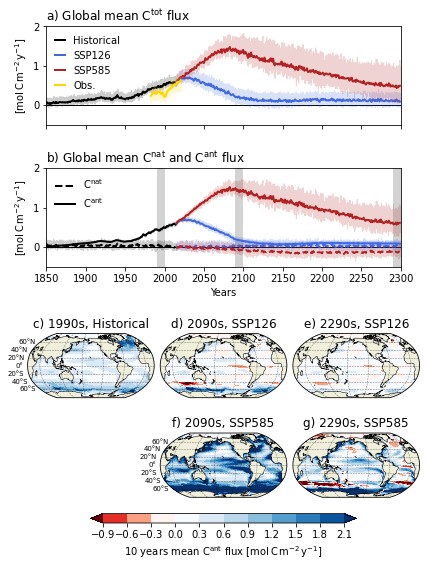

In [222]:
%%time
print(datetime.datetime.now())
print('Fig. 1: plot')

#_____________________
# Load data2plot
savedfile = dirout+'data2plot-fig1.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#---------------------
# FIGURE PARAM
#---------------------

ccrsproj = ccrs.Robinson(central_longitude=-155)
nrow, ncol = 4, 3
#fsize = (ncol*6*cm2in, nrow*4*cm2in)
fsize = (18*cm2in, 16*cm2in)
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#_____________________
# plotting kwargs

kwtimeseries = {
    'observations': dict(c='gold'     ), 
    'historical'  : dict(c='k'        ), 
    'ssp126'      : dict(c='royalblue'), 
    'ssp585'      : dict(c='firebrick'), 
    'monthly'     : dict(lw=1, alpha=.2), 
    'yearly'      : dict(lw=2),
    'cflx-tot'    : dict(ls='-'), 
    'cflx-nat'    : dict(ls='--'), 
    'cflx-ant'    : dict(ls='-')
} 
ylimits = (-.5, 2)

from matplotlib.colors import ListedColormap
from matplotlib import cm
# cmap = cm.get_cmap('RdBu', 256)
# ntotc, nnegc, incval = 10, 3, .3
# newcolors = cmap(np.linspace(0, 1, ntotc+(ntotc-2*nnegc)+2))
# cmap = ListedColormap(newcolors[ntotc-2*nnegc+1:-1])
# cmap.set_under(color=newcolors[ntotc-2*nnegc])
# cmap.set_over(color=newcolors[-1])

ncmap = cm.get_cmap('Reds_r', 256)
pcmap = cm.get_cmap('Blues', 256)
nnn = ncmap(np.linspace(0, 1, 3+1))
ppp = pcmap(np.linspace(0, 1, (10-3)+1))
newcolors = np.concatenate([nnn, ppp])
cmap = ListedColormap(newcolors[1:-1])
cmap.set_under(color=newcolors[0])
cmap.set_over(color=newcolors[-1])

kwmaps = {'transform':ccrs.PlateCarree(), 'cmap':cmap, 'vmin':-.9, 'vmax': 2.1}

#_____________________
# Naming

name_maps = {'1990s'        : '1990s, Historical'    , 
             'observations' : 'Obs. 1990s'     , 
             '2090s, ssp126': '2090s, SSP126', 
             '2290s, ssp126': '2290s, SSP126', 
             '2090s, ssp585': '2090s, SSP585', 
             '2290s, ssp585': '2290s, SSP585' 
            }
name_timeseries = {'historical'   : 'Historical', 
                   'observations' : 'Obs.', 
                   'ssp126'       : 'SSP126', 
                   'ssp585'       : 'SSP585' 
                  }


#---------------------
# Global timeseries
#---------------------

#_____________________
# Total carbon fluxes

iplot = 1

axts1  = fig.add_subplot(nrow, 1, iplot)
axts1.axhline(0, ls='-', lw=1, c='k')
var = 'cflx-tot'
lines, names = [], []
for kkk, vvv in data2plot['timeseries'][var].items(): 
    for vfreq in ['monthly', 'yearly']: 
        print( kkk  +', ' + vfreq)
        X = vvv[vfreq]['X']
        Y = vvv[vfreq]['Y']
        ll, = axts1.plot(X, Y, **{**kwtimeseries[kkk], **kwtimeseries[vfreq], **kwtimeseries[var]})
        if vfreq == 'yearly': 
            lines.append(ll)
            names.append(name_timeseries[kkk])
        #
    #
#
axts1.set_title(subnum.pop()+') Global mean C$^{\mathrm{tot}}$ flux', loc='left')
axts1.set_ylabel('[mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')
axts1.legend(lines, names, handlelength=1, frameon=False)
axts1.set_xlim((1850, 2300))
axts1.set_ylim(ylimits)
axts1.label_outer()

#_____________________
# Natural and anth. carbon fluxes

iplot = 2
axts2  = fig.add_subplot(nrow, 1, iplot)
axts2.axvspan(1990, 2000, facecolor='lightgray')
axts2.axvspan(2090, 2100, facecolor='lightgray')
axts2.axvspan(2290, 2300, facecolor='lightgray')
axts2.axhline(0, ls='-', lw=1, c='k')
lines, names = [], []

var = 'cflx-nat'
for kkk, vvv in data2plot['timeseries'][var].items(): 
    for vfreq in ['monthly', 'yearly']:         
        X = vvv[vfreq]['X']
        Y = vvv[vfreq]['Y']
        ll, = axts2.plot(X, Y, **{**kwtimeseries[kkk], **kwtimeseries[vfreq], **kwtimeseries[var]})
        if (kkk=='historical') & (vfreq=='yearly'): 
            lines.append(ll)
            names.append('C$^{\mathrm{nat}}$')
        #
    #
#
var = 'cflx-ant'
for kkk, vvv in data2plot['timeseries'][var].items(): 
    for vfreq in ['monthly', 'yearly']:         
        X = vvv[vfreq]['X']
        Y = vvv[vfreq]['Y']
        ll, = axts2.plot(X, Y, **{**kwtimeseries[kkk], **kwtimeseries[vfreq], **kwtimeseries[var]})
        if (kkk=='historical') & (vfreq=='yearly'): 
            lines.append(ll)
            names.append('C$^{\mathrm{ant}}$')
        #
    #
#
axts2.set_title(subnum.pop()+') Global mean C$^{\mathrm{nat}}$ and C$^{\mathrm{ant}}$ flux', loc='left')
axts2.set_ylabel('[mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')
axts2.legend(lines, names, handlelength=2, frameon=False)
axts2.set_xlim((1850, 2300))
axts2.set_ylim(ylimits)
axts2.set_xlabel('Years')

#---------------------
# Maps flux
#---------------------

axmap = []

simu_list = ['1990s', '2090s, ssp126', '2290s, ssp126']
iplot = 7
for simu in simu_list: 
    vvv=data2plot['maps'][simu]
    zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    X = vvv['X']
    Y = vvv['Y']
    Z = vvv['Z']
    mmm = zax.pcolormesh(X, Y, Z, **kwmaps)
    zax.set_title(subnum.pop()+') ' + name_maps[simu])
    gl = add_gridlines_coastline_and_land(zax)
    if not simu =='1990s': gl.left_labels = False
    axmap.append(zax)
    iplot += 1
    
#

# ax.flat[iplot].set_frame_on(False)
# iplot += 1

simu_list = ['2090s, ssp585', '2290s, ssp585']
iplot += 1
for simu in simu_list: 
    vvv=data2plot['maps'][simu]
    zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    X = vvv['X']
    Y = vvv['Y']
    Z = vvv['Z']
    mmm = zax.pcolormesh(X, Y, Z, **kwmaps)
    zax.set_title(subnum.pop()+') ' + name_maps[simu])
    gl = add_gridlines_coastline_and_land(zax)
    if not simu == '2090s, ssp585': gl.left_labels   = False
    axmap.append(zax)
    iplot += 1
#

fig.tight_layout()

#---------------------
# repositionning axes
#---------------------

zw1 = axts1.get_position()
zw2 = axts2.get_position()
nw  = 0.8*zw1.width
nh  = 1.5*zw1.height
nx01 = zw1.x0 + 0.5*(zw1.width - nw)
nx02 = zw2.x0 + 0.5*(zw2.width - nw)
ny02 = zw2.y0 
ny01 = zw1.y0 + (ny02-zw2.y0) + (nh-zw2.height) - 0.1*zw1.height
axts1.axes.set_position([nx01, ny01, nw, nh])
axts2.axes.set_position([nx02, ny02, nw, nh])
for zax in axmap[:3]:
    zw = zax.get_position()
    zax.set_position([zw.x0, zw.y0-.25*zw.height, zw.width, zw.height])
#
zax=axmap[0]
zw = zax.get_position()
zax.set_position([zw.x0 + .2*zw.width, zw.y0, zw.width, zw.height])
zax=axmap[2]
zw = zax.get_position()
zax.set_position([zw.x0 - .2*zw.width, zw.y0, zw.width, zw.height])
zax=axmap[-1]
zw = zax.get_position()
zax.set_position([zw.x0 - .2*zw.width, zw.y0, zw.width, zw.height])

#---------------------
# Colorbar
#---------------------
zw1 = fig.axes[2].get_position()
zw2 = fig.axes[-1].get_position()
nx0 = zw1.x0 + zw1.width*.5
nw  = zw2.x0 + zw2.width*.5 - nx0
ny0 = zw2.y0 - .4 * zw2.height
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm, cax=cax, extend='both', 
                    orientation='horizontal', ticklocation='bottom')
cbar.set_label(label='10 years mean C$^{\mathrm{ant}}$ flux [mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')
cbar.set_ticks(np.linspace(kwmaps['vmin'], kwmaps['vmax'], mmm.cmap.colors.shape[0]+1))

#---------------------
# Save fig
#---------------------

fignam = 'fig-1.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 15s

# Fig. 2: Methodology point
- mean ± 1 std -> total flux ± 1std
- for ACOD define from preindustrial mean, use ACOD*
- with SSP585 simulation
- a) maps showing the anthropogenic carbon flux for one month with the point for the time series
- b) grid point where there is outgassing, total carbon flux 50 year running mean ± 1 std, 
- c) same with the other grid point

ACOD is define as for each month as the latest year when 50y_rolling_mean(tot_flux) + 50y_rolling_std(tot_flux < 50y_rolling_mean(nat_flux)
then we select the month for wich this year is minimum

## Select points

In [8]:
%%time
print(datetime.datetime.now())
print('Fig. 2: select random points')

import random

# Note: 
# ix in [50:100]: atlantic
# ix in [250:300]: pacific
# iy in [230:280]: north mid-lat

mmm_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
yyy_list = np.arange(230, 280)
xxx_list = np.arange(250, 300)

# points=[]
# for nnn in range(2): 
#     im = random.choice(mmm_list)
#     iy = random.choice(yyy_list)
#     ix = random.choice(xxx_list)
#     while grid['pmask'][iy, ix] == 0: 
#         iy = random.choice(yyy_list)
#         ix = random.choice(xxx_list)
#     #
#     points.append((im, iy, ix))
# #

# points = [(270, 270)]
points = [(235, 300),
          (110, 325)]

# ca. <1s

2023-09-01 10:28:08.324635
Fig. 2: select random points
CPU times: user 69 µs, sys: 0 ns, total: 69 µs
Wall time: 75.8 µs


## Load and prepare data2plot

In [9]:
%%time
print(datetime.datetime.now())
print('Fig. 2: load and prepare data2plot')

zfactmod = 3600*24*365/12*1000. # kgC/m2/s -> molC/m2/yr

# simu_list  = ['ssp126', 'ssp585']
simu = 'ssp585'
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
data2plot = {'points':{}, 'maps':{}}

#___________________________
# Load 50 year running means
print('> load 50 year running means and std')
savedfile = dirout+'cflxtot-cflxnat-running-mean-std-50y-'+simu+'-noresm2-lm.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("File loaded: "+savedfile)

#___________________________
# Load cflx-to and cflx-nat
print('> load cflx-tot and cflx-nat')
cflx_tot = load_and_concat_hist_ssp('cflx-tot', 'ssp585')*zfactmod
cflx_nat = load_and_concat_hist_ssp('cflx-nat', 'ssp585')*zfactmod

aaa = select_months(cflx_tot.sel(time='2099'), 8) 
bbb = select_months(cflx_nat.sel(time='2099'), 8) 
data2plot['maps']['aug'] = {
    'X': grid['plon'].values, 'Y': grid['plat'].values, 
    'Z': aaa.values.squeeze() - bbb.values.squeeze()
}

aaa = select_months(cflx_tot.sel(time='2099'), 2) 
bbb = select_months(cflx_nat.sel(time='2099'), 2) 
data2plot['maps']['feb'] = {
    'X': grid['plon'].values, 'Y': grid['plat'].values, 
    'Z': aaa.values.squeeze() - bbb.values.squeeze()
}

#___________________________
# Loop on grid points
print('> loop on grid points')
for ipoint, vpoint in enumerate(points):

    pname='p'+str(ipoint)
    pointlat = grid['plat'].isel(y=vpoint[0], x=vpoint[1]).values
    pointlon = grid['plon'].isel(y=vpoint[0], x=vpoint[1]).values
    print('point '+pname+': (%.1f°E, %.1f°N)'%(pointlon, pointlat))

    #___________________________
    # select grid point
    zwtot_avg = loadeddatas['cflx-tot']['avg'].isel(y=vpoint[0], x=vpoint[1]).load()*zfactmod
    zwtot_std = loadeddatas['cflx-tot']['std'].isel(y=vpoint[0], x=vpoint[1]).load()*zfactmod
    zwnat_avg = loadeddatas['cflx-nat']['avg'].isel(y=vpoint[0], x=vpoint[1]).load()*zfactmod

    zwtot = cflx_tot.isel(y=vpoint[0], x=vpoint[1]).load()
    zwnat = cflx_nat.isel(y=vpoint[0], x=vpoint[1]).load()

    ocean = xr.where(grid['pmask'].isel(y=vpoint[0], x=vpoint[1]).load()==0, False, True)
    land  = xr.where(grid['pmask'].isel(y=vpoint[0], x=vpoint[1]).load()==0, True, False)

    #___________________________
    # Compute ACOD for each month
    print(">> For each month compute ACOD")
    acod_monthly = []
    for imonth, month in enumerate(month_list, start=1):

        # get Y = tot cflx running mean + 1std
        tot = select_months(zwtot_avg, imonth) 
        std =  select_months(zwtot_std, imonth)
        # get Yref = nat cflx running mean
        nat = select_months(zwnat_avg, imonth)
        # AOD
        acod_monthly.append(tot['time.year'].where(tot-nat<-std).min(dim='time'))

    #
    acod_monthly = xr.concat(acod_monthly, pd.Index(month_list, name='month')).rename("acod_year")

    #___________________________
    # Compute yACOD, earliest year of outgassing

    print('>> compute yACOD, earliest year of outgassing')
    yacod = acod_monthly.min(dim='month')
    zwnans = xr.apply_ufunc(np.isnan, yacod, dask='allowed')
    late  = ocean & zwnans
    yacod = xr.where(late, 1e20, yacod)
    yacod = xr.where(land, np.nan, yacod)

    #___________________________
    # Compute mACOD, month of earliest outgassing

    print('>> compute mACOD, month of earliest outgassing')
    zwnans = xr.apply_ufunc(np.isnan, acod_monthly, dask='allowed')
    acod_monthly = xr.where(zwnans, 1e20, acod_monthly) # reaplce nan by very high value to get argmin
    macod = acod_monthly.argmin(dim='month')
    acod_monthly = xr.where(zwnans, np.nan, acod_monthly) # replace back 1e20 by nan
    macod = xr.where(land, np.nan, macod)
    macod = xr.where(late, 1e20, macod) # replace late vallues by 1e20

    #___________________________
    # Compute sACOD, season of earliest outgassing

    print('>> compute sACOD, season of earliest outgassing')
    winter = xr.where((macod==0) | (macod==1)  | (macod==2), True, False)
    spring = xr.where((macod==3) | (macod==4)  | (macod==5) , True, False)
    summer = xr.where((macod==6) | (macod==7)  | (macod==8) , True, False)
    autumn = xr.where((macod==9) | (macod==10) | (macod==11), True, False)
    sacod = xr.zeros_like(macod) + np.nan
    sacod = xr.where(winter, 1, np.nan)
    sacod = xr.where(spring, 2, sacod)
    sacod = xr.where(summer, 3, sacod)
    sacod = xr.where(autumn, 4, sacod)
    sacod = xr.where(late, 1e20, sacod)
    sacod = xr.where(land, np.nan, sacod)

    #___________________________
    # Save data2plot

    # Pionts Time series
    data2plot['points'][pname] = {'pointlat':pointlat, 'pointlon':pointlon}
    data2plot['points'][pname]['raw-tot-monthly'] = {'X': zwtot['time.year'].values, 'Y': zwtot.values}
    data2plot['points'][pname]['raw-nat-monthly'] = {'X': zwnat['time.year'].values, 'Y': zwnat.values}
    aaa = zwtot.groupby('time.year').mean(dim='time')
    bbb = zwnat.groupby('time.year').mean(dim='time')
    data2plot['points'][pname]['raw-tot-yearly'] = {'X': aaa['year'].values, 'Y': aaa.values}
    data2plot['points'][pname]['raw-nat-yearly'] = {'X': bbb['year'].values, 'Y': bbb.values}
    data2plot['points'][pname]['smooth-tot-monthly'] = {'X': zwtot_avg['time.year'].values, 'Y': zwtot_avg.values}
    data2plot['points'][pname]['smooth-nat-monthly'] = {'X': zwnat_avg['time.year'].values, 'Y': zwnat_avg.values}
    aaa = zwtot_avg.groupby('time.year').mean(dim='time')
    bbb = zwnat_avg.groupby('time.year').mean(dim='time')
    data2plot['points'][pname]['smooth-tot-yearly'] = {'X': aaa['year'].values, 'Y': aaa.values}
    data2plot['points'][pname]['smooth-nat-yearly'] = {'X': bbb['year'].values, 'Y': bbb.values}

    mmm=int(macod.values)+1
    if mmm in np.arange(1, 13): 
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['YACOD'] = yacod.values
        data2plot['points'][pname]['MACOD'] = month_list[mmm-1]
        mmm+=6
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod+6'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['MACOD+6'] = month_list[mmm-1]
    else: 
        mmm = 2
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['YACOD'] = np.nan
        data2plot['points'][pname]['MACOD'] = month_list[mmm-1]
        mmm = 8
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod+6'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['MACOD+6'] = month_list[mmm-1]
    #
#

# print('> save file')
# savedfile = dirout+'data2plot-fig2.pckl'
# if os.path.isfile(savedfile): os.remove(savedfile)
# with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
# print("Done, file saved: "+savedfile)

# EXAMPLE FOR PLOTTING: 
#-----------------------
# plt.plot(zwtot['time.year'], zwtot-zwnat, alpha=.3, lw=.5, color='gray')
# plt.plot(zwtot_avg['time.year'], zwtot_avg-zwnat_avg, alpha=.3, lw=.5, color='royalblue')
# plt.plot(zwtot_std['time.year'], -zwtot_std, alpha=.3, lw=.5, color='green')
# 
# aaa = zwtot.groupby('time.year').mean(dim='time')
# bbb = zwnat.groupby('time.year').mean(dim='time')
# plt.plot(aaa['year'], aaa-bbb, lw=1, ls='-', color='gray')
# 
# aaa = zwtot_avg.groupby('time.year').mean(dim='time')
# bbb = zwnat_avg.groupby('time.year').mean(dim='time')
# plt.plot(aaa['year'], aaa-bbb, lw=2, ls='-', color='royalblue')
# 
# mmm=int(macod.values)+1
# aaa = select_months(zwtot, mmm)*np.nan
# bbb = select_months(zwnat, mmm)*np.nan
# plt.plot(aaa['time.year'], aaa-bbb, color='orange', ls='--', lw=1)
# aaa = select_months(zwtot_avg, mmm)*np.nan
# bbb = select_months(zwnat_avg, mmm)*np.nan
# ccc =  select_months(zwtot_std, mmm)*np.nan
# plt.plot(aaa['time.year'], aaa-bbb, color='orange', ls='-', lw=2)
# plt.plot(ccc['time.year'], -ccc, color='green', ls='-', lw=2)
# plt.axvline(yacod*np.nan)

# ca. 1m

2023-09-01 10:28:16.544075
Fig. 2: load and prepare data2plot
> load 50 year running means and std
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp585-noresm2-lm.pckl
> load cflx-tot and cflx-nat
func: load_and_concat_hist_ssp(cflx-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(cflx-nat, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, aug)
func: select_month(cflx-nat, aug)
func: select_month(cflx-tot, feb)
func: select_month(cflx-nat, feb)
> loop on grid points
point p0: (-169.5°E, 12.6°N)
[########################################] | 100% Completed | 4.84 s
[########################################] | 100% Completed | 15.84 s
[########################################] | 100% Complete

## Plot

In [ ]:
%%time
print(datetime.datetime.now())
print('Fig. 2: plot')

# Load data2plot
savedfile = dirout+'data2plot-fig2.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
    
#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 2, 2
# fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), squeeze=False)
fsize = (15*cm2in, 11.25*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

month_names = {'jan':'January', 'feb':'February', 'mar':'March', 'apr':'April', 'may':'May', 'jun':'June', \
               'jul':'July', 'aou':'August', 'sep':'September', 'oct':'October', 'nov':'November', 'dec':'December'}
#_____________________
# plotting kwargs

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('RdBu', 256)
newcolors = cmap(np.linspace(0, 1, 14))
cmap = ListedColormap(newcolors[1:-1])
cmap.set_under(color=newcolors[0])
cmap.set_over(color=newcolors[-1])
vmin, vmax = -6, 6
ccrsproj = ccrs.Robinson(central_longitude=-155)
kwmap = dict(transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)


#---------------------
# Map
#---------------------

axmap=[]

iplot = 1
zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
axmap.append(zax)
X = data2plot['maps']['aug']['X']
Y = data2plot['maps']['aug']['Y']
Z = data2plot['maps']['aug']['Z']
pcm = zax.pcolormesh(X, Y, Z, **kwmap)
gl = add_gridlines_coastline_and_land(zax)
zax.set_title(subnum.pop()+') Aug. 2099')

iplot = 2
zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
axmap.append(zax)
X = data2plot['maps']['feb']['X']
Y = data2plot['maps']['feb']['Y']
Z = data2plot['maps']['feb']['Z']
pcm = zax.pcolormesh(X, Y, Z, **kwmap)
gl = add_gridlines_coastline_and_land(zax)
gl.left_labels=False
zax.set_title(subnum.pop()+') Feb. 2099')

#---------------------
# POINTS
#---------------------

axpoint = []
iplot = 3
for kkk, vvv in data2plot['points'].items(): 
        
    zax = fig.add_subplot(nrow, ncol, iplot)
    axpoint.append(zax)

    # raw-tot-monthly
    X  = vvv['raw-tot-monthly' ]['X']
    Y  = vvv['raw-tot-monthly' ]['Y']
    kwll = dict(color='lightgrey', linewidth=1, linestyle='-', zorder=0)
    # ll_raw_tot, = zax.plot(X, Y, label='Total', **kwll)
    ll_raw_tot, = zax.plot(X, Y, label=r'$F^{tot}_{co_2}$', **kwll)
    
    # raw-nat-monthly
    X  = vvv['raw-nat-monthly' ]['X']
    Y  = vvv['raw-nat-monthly' ]['Y']
    kwll = dict(alpha=.3, color='tab:blue', linewidth=1, linestyle='-', zorder=0)
    # ll_raw_nat, = zax.plot(X, Y, label='Natural', **kwll)
    ll_raw_nat, = zax.plot(X, Y, label=r'$F^{nat}_{co_2}$', **kwll)

    zax.set_ylim((-6, 6))
    
    if not np.isnan(vvv['YACOD']): 
    
        # smooth-nat-macod
        X  = vvv['smooth-nat-macod' ]['X']
        Y  = vvv['smooth-nat-macod' ]['Y']
        kwll = dict(color='tab:blue', linewidth=2, linestyle='-')
        # ll_smooth_nat_macod, = zax.plot(X, Y, label='Nat. in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        ll_smooth_nat_macod, = zax.plot(X, Y, label=r'$\left<F^{nat}_{co_2}\right>$ in '+str(vvv['MACOD']).capitalize()+'.', **kwll)

        # smooth-tot-macod and std-tot-macod
        X  = vvv['smooth-tot-macod']['X']
        Y  = vvv['smooth-tot-macod']['Y']
        Yu = Y + vvv['std-tot-macod']['Y']
        Yd = Y - vvv['std-tot-macod']['Y']
        kwll = dict(alpha=.3, color='tab:orange', linewidth = 0)
        zax.fill_between(X, Yd, Yu, **kwll)
        kwll = dict(color='tab:orange', linewidth=2, linestyle='-')
        # ll_smooth_tot_macod, = zax.plot(X, Y, label = 'Tot. $\pm$ 1 std in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        ll_smooth_tot_macod, = zax.plot(X, Y, label=r'$\left<F^{tot}_{co_2}\right> \pm \sigma^{tot}$ in '+str(vvv['MACOD']).capitalize()+'.', **kwll)

        # # smooth-nat-macod+6
        # X  = vvv['smooth-nat-macod+6' ]['X']
        # Y  = vvv['smooth-nat-macod+6' ]['Y']
        # kwll = dict(color='tab:blue', linewidth=2, linestyle='--')
        # zax.plot(X, Y, label='Nat. in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        # 
        # # smooth-tot-macod+6 and std-tot-macod+6
        # X  = vvv['smooth-tot-macod+6']['X']
        # Y  = vvv['smooth-tot-macod+6']['Y']
        # Yu = Y + vvv['std-tot-macod+6']['Y']
        # Yd = Y - vvv['std-tot-macod+6']['Y']
        # kwll = dict(alpha=.3, color='tab:orange', linewidth = 0)
        # zax.fill_between(X, Yd, Yu, **kwll)
        # kwll = dict(color='tab:orange', linewidth=2, linestyle='--')
        # zax.plot(X, Y, label = 'Tot. $\pm$ 1 std in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        
        # YACOD
        kwll = dict(linewidth = 2, linestyle='--', color='black')
        ll_yacod = zax.axvline(vvv['YACOD'], label='ACOD', **kwll)
        zwylim = zax.get_ylim()
        zwx, zwy = vvv['YACOD'], zwylim[0]+.3*(zwylim[1]-zwylim[0]) 
        zwxt, zwyt = 1850+.02*(2300-1850) , zwylim[0]+.05*(zwylim[1]-zwylim[0]) 
        arpr = dict(arrowstyle='simple',shrinkA=0, connectionstyle="angle3,angleA=90", 
                    relpos=(.5, .5), color='k')
        zax.annotate('Start of\noutgassing', (zwx, zwy), (zwxt, zwyt), color='k', 
                     arrowprops=arpr)
    else:
        zwylim = zax.get_ylim()
        zwxt, zwyt = 1850+.02*(2300-1850), zwylim[0]+.05*(zwylim[1]-zwylim[0]) 
        zax.annotate('No outgassing', (zwxt, zwyt), color='k') 
    #
    
    # Add point to map
    for zaxmap in axmap: 
        zaxmap.scatter(vvv['pointlon'], vvv['pointlat'], transform=ccrs.PlateCarree(), \
                       edgecolor='None', facecolor='gray', alpha=.3)
        zaxmap.scatter(vvv['pointlon'], vvv['pointlat'], transform=ccrs.PlateCarree(), \
                       edgecolor='k', facecolor='None')
    
    if vvv['pointlon'] < 0: zwlonttl = '%d°W'%(-vvv['pointlon'])
    else : zwlonttl = '%d°E'%(vvv['pointlon'])
    if vvv['pointlat'] < 0: zwlatttl = '%d°S'%(-vvv['pointlat'])
    else : zwlatttl = '%d°N'%(vvv['pointlat'])
    zwttl = zwlonttl+', '+zwlatttl
    zax.set_title(subnum.pop()+') '+zwttl, loc='left')
    zax.label_outer()
    
    iplot += 1

#

#---------------------
# Set axes
#---------------------

for zax in axpoint: 
    zax.set_xlabel('Year')
    zax.set_xlim(1850, 2300)
#
axpoint[0].set_ylabel('[mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')
axpoint[1].yaxis.set_ticks_position('right')
axpoint[1].yaxis.set_label_position('right')
axpoint[1].set_ylabel('[mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')

fig.tight_layout()

#---------------------
# Legend
#---------------------

zw1 = axpoint[0].get_position()
zw2 = axpoint[1].get_position()
nx0 = 0.5*(zw1.x1 + zw2.x0)
ny0 = zw1.y0-.3*zw1.height
zax = fig.add_axes([nx0, ny0, 0, 0])
zax.axis('off')
zax.legend(handles=[ll_raw_tot, ll_raw_nat, ll_smooth_tot_macod, ll_smooth_nat_macod],
           ncol=4, loc='upper center', handlelength=.7)

#---------------------
# Colorbar
#---------------------

zw1 = axmap[0].get_position()
zw2 = axmap[1].get_position()
nx0 = zw1.x0 + .5*zw1.width
nw  = zw2.x0 + .5*zw2.width - nx0
ny0 = zw1.y1 + .4 * zw1.height
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, extend='both', orientation='horizontal', ticklocation='top')
#                    orientation='vertical', ticklocation='')
cbar.set_label(label=r'C$^\mathrm{ant}$ flux in SSP5-8.5 [mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm.cmap.colors.shape[0]+1)/2)+1))


fignam = 'fig-2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 10s

2023-10-15 11:48:02.772614
Fig. 2: plot
func: add_gridlines_coastline_and_land


## Fig. 2.1: other points
- mean ± 1 std -> total flux ± 1std
- for ACOD define from preindustrial mean, use ACOD*
- with SSP585 simulation
- a) maps showing the anthropogenic carbon flux for one month with the point for the time series
- b) grid point where there is outgassing, total carbon flux 50 year running mean ± 1 std, 
- c) same with the other grid point

ACOD is define as for each month as the latest year when 50y_rolling_mean(tot_flux) + 50y_rolling_std(tot_flux < 50y_rolling_mean(nat_flux)
then we select the month for wich this year is minimum

### Select points

In [116]:
%%time
print(datetime.datetime.now())
print('Fig. 2.1: select random points')

import random

# Note: 
# ix in [50:100]: atlantic
# ix in [250:300]: pacific
# iy in [230:280]: north mid-lat

mmm_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
yyy_list = np.arange(230, 280)
xxx_list = np.arange(250, 300)

# points=[]
# for nnn in range(2): 
#     im = random.choice(mmm_list)
#     iy = random.choice(yyy_list)
#     ix = random.choice(xxx_list)
#     while grid['pmask'][iy, ix] == 0: 
#         iy = random.choice(yyy_list)
#         ix = random.choice(xxx_list)
#     #
#     points.append((im, iy, ix))
# #

# points = [(270, 270)]
points = [(365, 300),
          (355, 100)]

# ca. <1s

2023-09-25 15:48:27.291009
Fig. 2.1: select random points
CPU times: user 63 µs, sys: 22 µs, total: 85 µs
Wall time: 93.9 µs


### Load and prepare data2plot

In [117]:
%%time
print(datetime.datetime.now())
print('Fig. 2.1: load and prepare data2plot')

zfactmod = 3600*24*365/12*1000. # kgC/m2/s -> molC/m2/yr

# simu_list  = ['ssp126', 'ssp585']
simu = 'ssp126'
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
data2plot = {'points':{}, 'maps':{}}

#___________________________
# Load 50 year running means
print('> load 50 year running means and std')
savedfile = dirout+'cflxtot-cflxnat-running-mean-std-50y-'+simu+'-noresm2-lm.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("File loaded: "+savedfile)

#___________________________
# Load cflx-to and cflx-nat
print('> load cflx-tot and cflx-nat')
cflx_tot = load_and_concat_hist_ssp('cflx-tot', simu)*zfactmod
cflx_nat = load_and_concat_hist_ssp('cflx-nat', simu)*zfactmod

aaa = select_months(cflx_tot.sel(time='2099'), 8) 
bbb = select_months(cflx_nat.sel(time='2099'), 8) 
data2plot['maps']['aug'] = {
    'X': grid['plon'].values, 'Y': grid['plat'].values, 
    'Z': aaa.values.squeeze() - bbb.values.squeeze()
}

aaa = select_months(cflx_tot.sel(time='2099'), 2) 
bbb = select_months(cflx_nat.sel(time='2099'), 2) 
data2plot['maps']['feb'] = {
    'X': grid['plon'].values, 'Y': grid['plat'].values, 
    'Z': aaa.values.squeeze() - bbb.values.squeeze()
}

#___________________________
# Loop on grid points
print('> loop on grid points')
for ipoint, vpoint in enumerate(points):

    pname='p'+str(ipoint)
    pointlat = grid['plat'].isel(y=vpoint[0], x=vpoint[1]).values
    pointlon = grid['plon'].isel(y=vpoint[0], x=vpoint[1]).values
    print('point '+pname+': (%.1f°E, %.1f°N)'%(pointlon, pointlat))

    #___________________________
    # select grid point
    zwtot_avg = loadeddatas['cflx-tot']['avg'].isel(y=vpoint[0], x=vpoint[1]).load()*zfactmod
    zwtot_std = loadeddatas['cflx-tot']['std'].isel(y=vpoint[0], x=vpoint[1]).load()*zfactmod
    zwnat_avg = loadeddatas['cflx-nat']['avg'].isel(y=vpoint[0], x=vpoint[1]).load()*zfactmod

    zwtot = cflx_tot.isel(y=vpoint[0], x=vpoint[1]).load()
    zwnat = cflx_nat.isel(y=vpoint[0], x=vpoint[1]).load()

    ocean = xr.where(grid['pmask'].isel(y=vpoint[0], x=vpoint[1]).load()==0, False, True)
    land  = xr.where(grid['pmask'].isel(y=vpoint[0], x=vpoint[1]).load()==0, True, False)

    #___________________________
    # Compute ACOD for each month
    print(">> For each month compute ACOD")
    acod_monthly = []
    for imonth, month in enumerate(month_list, start=1):

        # get Y = tot cflx running mean + 1std
        tot = select_months(zwtot_avg, imonth) 
        std =  select_months(zwtot_std, imonth)
        # get Yref = nat cflx running mean
        nat = select_months(zwnat_avg, imonth)
        # AOD
        acod_monthly.append(tot['time.year'].where(tot-nat<-std).min(dim='time'))

    #
    acod_monthly = xr.concat(acod_monthly, pd.Index(month_list, name='month')).rename("acod_year")

    #___________________________
    # Compute yACOD, earliest year of outgassing

    print('>> compute yACOD, earliest year of outgassing')
    yacod = acod_monthly.min(dim='month')
    zwnans = xr.apply_ufunc(np.isnan, yacod, dask='allowed')
    late  = ocean & zwnans
    yacod = xr.where(late, 1e20, yacod)
    yacod = xr.where(land, np.nan, yacod)

    #___________________________
    # Compute mACOD, month of earliest outgassing

    print('>> compute mACOD, month of earliest outgassing')
    zwnans = xr.apply_ufunc(np.isnan, acod_monthly, dask='allowed')
    acod_monthly = xr.where(zwnans, 1e20, acod_monthly) # reaplce nan by very high value to get argmin
    macod = acod_monthly.argmin(dim='month')
    acod_monthly = xr.where(zwnans, np.nan, acod_monthly) # replace back 1e20 by nan
    macod = xr.where(land, np.nan, macod)
    macod = xr.where(late, 1e20, macod) # replace late vallues by 1e20

    #___________________________
    # Compute sACOD, season of earliest outgassing

    print('>> compute sACOD, season of earliest outgassing')
    winter = xr.where((macod==0) | (macod==1)  | (macod==2), True, False)
    spring = xr.where((macod==3) | (macod==4)  | (macod==5) , True, False)
    summer = xr.where((macod==6) | (macod==7)  | (macod==8) , True, False)
    autumn = xr.where((macod==9) | (macod==10) | (macod==11), True, False)
    sacod = xr.zeros_like(macod) + np.nan
    sacod = xr.where(winter, 1, np.nan)
    sacod = xr.where(spring, 2, sacod)
    sacod = xr.where(summer, 3, sacod)
    sacod = xr.where(autumn, 4, sacod)
    sacod = xr.where(late, 1e20, sacod)
    sacod = xr.where(land, np.nan, sacod)

    #___________________________
    # Save data2plot

    # Pionts Time series
    data2plot['points'][pname] = {'pointlat':pointlat, 'pointlon':pointlon}
    data2plot['points'][pname]['raw-tot-monthly'] = {'X': zwtot['time.year'].values, 'Y': zwtot.values}
    data2plot['points'][pname]['raw-nat-monthly'] = {'X': zwnat['time.year'].values, 'Y': zwnat.values}
    aaa = zwtot.groupby('time.year').mean(dim='time')
    bbb = zwnat.groupby('time.year').mean(dim='time')
    data2plot['points'][pname]['raw-tot-yearly'] = {'X': aaa['year'].values, 'Y': aaa.values}
    data2plot['points'][pname]['raw-nat-yearly'] = {'X': bbb['year'].values, 'Y': bbb.values}
    data2plot['points'][pname]['smooth-tot-monthly'] = {'X': zwtot_avg['time.year'].values, 'Y': zwtot_avg.values}
    data2plot['points'][pname]['smooth-nat-monthly'] = {'X': zwnat_avg['time.year'].values, 'Y': zwnat_avg.values}
    aaa = zwtot_avg.groupby('time.year').mean(dim='time')
    bbb = zwnat_avg.groupby('time.year').mean(dim='time')
    data2plot['points'][pname]['smooth-tot-yearly'] = {'X': aaa['year'].values, 'Y': aaa.values}
    data2plot['points'][pname]['smooth-nat-yearly'] = {'X': bbb['year'].values, 'Y': bbb.values}

    mmm=int(macod.values)+1
    if mmm in np.arange(1, 13): 
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['YACOD'] = yacod.values
        data2plot['points'][pname]['MACOD'] = month_list[mmm-1]
        mmm+=6
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod+6'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['MACOD+6'] = month_list[mmm-1]
    else: 
        mmm = 2
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['YACOD'] = np.nan
        data2plot['points'][pname]['MACOD'] = month_list[mmm-1]
        mmm = 8
        aaa = select_months(zwtot, mmm)
        bbb = select_months(zwnat, mmm)
        data2plot['points'][pname]['raw-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['raw-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        aaa = select_months(zwtot_avg, mmm)
        bbb = select_months(zwnat_avg, mmm)
        data2plot['points'][pname]['smooth-tot-macod+6'] = {'X': aaa['time.year'].values , 'Y': aaa.values}
        data2plot['points'][pname]['smooth-nat-macod+6'] = {'X': bbb['time.year'].values , 'Y': bbb.values}
        ccc = select_months(zwtot_std, mmm)
        data2plot['points'][pname]['std-tot-macod+6'] = {'X': ccc['time.year'].values , 'Y': ccc.values}
        data2plot['points'][pname]['MACOD+6'] = month_list[mmm-1]
    #
#

print('> save file')
savedfile = dirout+'data2plot-fig2.1-other-points.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)

# EXAMPLE FOR PLOTTING: 
#-----------------------
# plt.plot(zwtot['time.year'], zwtot-zwnat, alpha=.3, lw=.5, color='gray')
# plt.plot(zwtot_avg['time.year'], zwtot_avg-zwnat_avg, alpha=.3, lw=.5, color='royalblue')
# plt.plot(zwtot_std['time.year'], -zwtot_std, alpha=.3, lw=.5, color='green')
# 
# aaa = zwtot.groupby('time.year').mean(dim='time')
# bbb = zwnat.groupby('time.year').mean(dim='time')
# plt.plot(aaa['year'], aaa-bbb, lw=1, ls='-', color='gray')
# 
# aaa = zwtot_avg.groupby('time.year').mean(dim='time')
# bbb = zwnat_avg.groupby('time.year').mean(dim='time')
# plt.plot(aaa['year'], aaa-bbb, lw=2, ls='-', color='royalblue')
# 
# mmm=int(macod.values)+1
# aaa = select_months(zwtot, mmm)*np.nan
# bbb = select_months(zwnat, mmm)*np.nan
# plt.plot(aaa['time.year'], aaa-bbb, color='orange', ls='--', lw=1)
# aaa = select_months(zwtot_avg, mmm)*np.nan
# bbb = select_months(zwnat_avg, mmm)*np.nan
# ccc =  select_months(zwtot_std, mmm)*np.nan
# plt.plot(aaa['time.year'], aaa-bbb, color='orange', ls='-', lw=2)
# plt.plot(ccc['time.year'], -ccc, color='green', ls='-', lw=2)
# plt.axvline(yacod*np.nan)

# ca. 1m

2023-09-25 15:48:29.333034
Fig. 2.1: load and prepare data2plot
> load 50 year running means and std
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
> load cflx-tot and cflx-nat
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: select_month(cflx-tot, aug)
func: select_month(cflx-nat, aug)
func: select_month(cflx-tot, feb)
func: select_month(cflx-nat, feb)
> loop on grid points
point p0: (-139.1°E, 77.8°N)
[########################################] | 100% Completed | 4.55 s
[########################################] | 100% Completed | 11.42 s
[########################################] | 100% Comple

### Plot

2023-09-25 15:49:24.064302
Fig. 2.1: plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-2.1-other-points.png
CPU times: user 7.53 s, sys: 1.57 s, total: 9.1 s
Wall time: 7.26 s


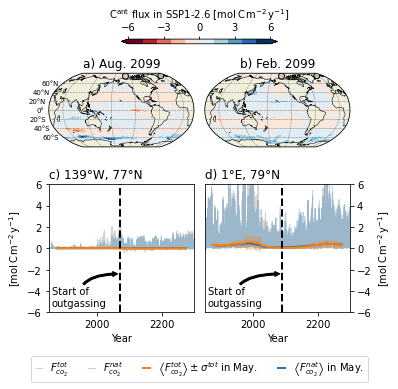

In [118]:
%%time
print(datetime.datetime.now())
print('Fig. 2.1: plot')

# Load data2plot
savedfile = dirout+'data2plot-fig2.1-other-points.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
    
#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 2, 2
# fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), squeeze=False)
fsize = (15*cm2in, 11.25*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

simu = 'SSP1-2.6'
month_names = {'jan':'January', 'feb':'February', 'mar':'March', 'apr':'April', 'may':'May', 'jun':'June', \
               'jul':'July', 'aou':'August', 'sep':'September', 'oct':'October', 'nov':'November', 'dec':'December'}
#_____________________
# plotting kwargs

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('RdBu', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors)
# cmap.set_under(color='silver')
# cmap.set_over(color='silver')
vmin, vmax = -6, 6
ccrsproj = ccrs.Robinson(central_longitude=-155)
kwmap = dict(transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)


#---------------------
# Map
#---------------------

axmap=[]

iplot = 1
zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
axmap.append(zax)
X = data2plot['maps']['aug']['X']
Y = data2plot['maps']['aug']['Y']
Z = data2plot['maps']['aug']['Z']
pcm = zax.pcolormesh(X, Y, Z, **kwmap)
gl = add_gridlines_coastline_and_land(zax)
zax.set_title(subnum.pop()+') Aug. 2099')

iplot = 2
zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
axmap.append(zax)
X = data2plot['maps']['feb']['X']
Y = data2plot['maps']['feb']['Y']
Z = data2plot['maps']['feb']['Z']
pcm = zax.pcolormesh(X, Y, Z, **kwmap)
gl = add_gridlines_coastline_and_land(zax)
gl.left_labels=False
zax.set_title(subnum.pop()+') Feb. 2099')

#---------------------
# POINTS
#---------------------

axpoint = []
iplot = 3
for kkk, vvv in data2plot['points'].items(): 
        
    zax = fig.add_subplot(nrow, ncol, iplot)
    axpoint.append(zax)

    # raw-tot-monthly
    X  = vvv['raw-tot-monthly' ]['X']
    Y  = vvv['raw-tot-monthly' ]['Y']
    kwll = dict(color='lightgrey', linewidth=1, linestyle='-', zorder=0)
    # ll_raw_tot, = zax.plot(X, Y, label='Total', **kwll)
    ll_raw_tot, = zax.plot(X, Y, label=r'$F^{tot}_{co_2}$', **kwll)
    
    # raw-nat-monthly
    X  = vvv['raw-nat-monthly' ]['X']
    Y  = vvv['raw-nat-monthly' ]['Y']
    kwll = dict(alpha=.3, color='tab:blue', linewidth=1, linestyle='-', zorder=0)
    # ll_raw_nat, = zax.plot(X, Y, label='Natural', **kwll)
    ll_raw_nat, = zax.plot(X, Y, label=r'$F^{nat}_{co_2}$', **kwll)

    zax.set_ylim((-6, 6))
    
    if not np.isnan(vvv['YACOD']): 
    
        # smooth-nat-macod
        X  = vvv['smooth-nat-macod' ]['X']
        Y  = vvv['smooth-nat-macod' ]['Y']
        kwll = dict(color='tab:blue', linewidth=2, linestyle='-')
        # ll_smooth_nat_macod, = zax.plot(X, Y, label='Nat. in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        ll_smooth_nat_macod, = zax.plot(X, Y, label=r'$\left<F^{nat}_{co_2}\right>$ in '+str(vvv['MACOD']).capitalize()+'.', **kwll)

        # smooth-tot-macod and std-tot-macod
        X  = vvv['smooth-tot-macod']['X']
        Y  = vvv['smooth-tot-macod']['Y']
        Yu = Y + vvv['std-tot-macod']['Y']
        Yd = Y - vvv['std-tot-macod']['Y']
        kwll = dict(alpha=.3, color='tab:orange', linewidth = 0)
        zax.fill_between(X, Yd, Yu, **kwll)
        kwll = dict(color='tab:orange', linewidth=2, linestyle='-')
        # ll_smooth_tot_macod, = zax.plot(X, Y, label = 'Tot. $\pm$ 1 std in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        ll_smooth_tot_macod, = zax.plot(X, Y, label=r'$\left<F^{tot}_{co_2}\right> \pm \sigma^{tot}$ in '+str(vvv['MACOD']).capitalize()+'.', **kwll)

        # # smooth-nat-macod+6
        # X  = vvv['smooth-nat-macod+6' ]['X']
        # Y  = vvv['smooth-nat-macod+6' ]['Y']
        # kwll = dict(color='tab:blue', linewidth=2, linestyle='--')
        # zax.plot(X, Y, label='Nat. in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        # 
        # # smooth-tot-macod+6 and std-tot-macod+6
        # X  = vvv['smooth-tot-macod+6']['X']
        # Y  = vvv['smooth-tot-macod+6']['Y']
        # Yu = Y + vvv['std-tot-macod+6']['Y']
        # Yd = Y - vvv['std-tot-macod+6']['Y']
        # kwll = dict(alpha=.3, color='tab:orange', linewidth = 0)
        # zax.fill_between(X, Yd, Yu, **kwll)
        # kwll = dict(color='tab:orange', linewidth=2, linestyle='--')
        # zax.plot(X, Y, label = 'Tot. $\pm$ 1 std in '+str(vvv['MACOD']).capitalize()+'.', **kwll)
        
        # YACOD
        kwll = dict(linewidth = 2, linestyle='--', color='black')
        ll_yacod = zax.axvline(vvv['YACOD'], label='ACOD', **kwll)
        zwylim = zax.get_ylim()
        zwx, zwy = vvv['YACOD'], zwylim[0]+.3*(zwylim[1]-zwylim[0]) 
        zwxt, zwyt = 1850+.02*(2300-1850) , zwylim[0]+.05*(zwylim[1]-zwylim[0]) 
        arpr = dict(arrowstyle='simple',shrinkA=0, connectionstyle="angle3,angleA=90", 
                    relpos=(.5, .5), color='k')
        zax.annotate('Start of\noutgassing', (zwx, zwy), (zwxt, zwyt), color='k', 
                     arrowprops=arpr)
    else:
        zwylim = zax.get_ylim()
        zwxt, zwyt = 1850+.02*(2300-1850), zwylim[0]+.05*(zwylim[1]-zwylim[0]) 
        zax.annotate('No outgassing', (zwxt, zwyt), color='k') 
    #
    
    # Add point to map
    for zaxmap in axmap: 
        zaxmap.scatter(vvv['pointlon'], vvv['pointlat'], transform=ccrs.PlateCarree(), \
                       edgecolor='None', facecolor='gray', alpha=.3)
        zaxmap.scatter(vvv['pointlon'], vvv['pointlat'], transform=ccrs.PlateCarree(), \
                       edgecolor='k', facecolor='None')
    
    if vvv['pointlon'] < 0: zwlonttl = '%d°W'%(-vvv['pointlon'])
    else : zwlonttl = '%d°E'%(vvv['pointlon'])
    if vvv['pointlat'] < 0: zwlatttl = '%d°S'%(-vvv['pointlat'])
    else : zwlatttl = '%d°N'%(vvv['pointlat'])
    zwttl = zwlonttl+', '+zwlatttl
    zax.set_title(subnum.pop()+') '+zwttl, loc='left')
    zax.label_outer()
    
    iplot += 1

#

#---------------------
# Set axes
#---------------------

for zax in axpoint: 
    zax.set_xlabel('Year')
    zax.set_xlim(1850, 2300)
#
axpoint[0].set_ylabel('[mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')
axpoint[1].yaxis.set_ticks_position('right')
axpoint[1].yaxis.set_label_position('right')
axpoint[1].set_ylabel('[mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]')

fig.tight_layout()

#---------------------
# Legend
#---------------------

zw1 = axpoint[0].get_position()
zw2 = axpoint[1].get_position()
nx0 = 0.5*(zw1.x1 + zw2.x0)
ny0 = zw1.y0-.3*zw1.height
zax = fig.add_axes([nx0, ny0, 0, 0])
zax.axis('off')
zax.legend(handles=[ll_raw_tot, ll_raw_nat, ll_smooth_tot_macod, ll_smooth_nat_macod],
           ncol=4, loc='upper center', handlelength=.7)

#---------------------
# Colorbar
#---------------------

zw1 = axmap[0].get_position()
zw2 = axmap[1].get_position()
nx0 = zw1.x0 + .5*zw1.width
nw  = zw2.x0 + .5*zw2.width - nx0
ny0 = zw1.y1 + .4 * zw1.height
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, extend='both', orientation='horizontal', ticklocation='top')
#                    orientation='vertical', ticklocation='')
cbar.set_label(label=r'C$^\mathrm{ant}$ flux in %s [mol$\,$C$\,$m$^{-2}\,$y$^{-1}$]'%simu)
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm.cmap.colors.shape[0]+1)/2)))


fignam = 'fig-2.1-other-points.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 10s

# Fig. 3: season and year of ACOD
- a, b) ACOD season, colorbar label: season of ACOD
- c, d) ACOD year, colorbar label: year of ACOD
- f) % of the ocean outgasing carbon versus time

## Load and prepare data2plot

### Inputs

In [13]:
%%time
print(datetime.datetime.now())
print('Fig. 3: load and prepare data2plot')
print('Inputs')

# zfactmod = 3600*24*365/12*1000. # kgC/m2/s -> molC/m2/yr
simu_list  = ['ssp126', 'ssp585']
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
rolmean=50

#___________________________
# Masks
ocean_mask = xr.where(grid['pmask'].load()==0, False, True)
land_mask  = xr.where(grid['pmask'].load()==0, True, False)


2023-09-29 14:47:20.556360
Fig. 3: load and prepare data2plot
Inputs
CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 2.2 ms


### Maps

#### Compute ACOD for each month

In [14]:
%%time
print(datetime.datetime.now())
print('Fig. 3: load and prepare data2plot')
print('Maps: compute ACOD for each month')

#----------------------
# Loop on simulations
#----------------------

for simu in simu_list: 

    print('> simu: '+simu)
    print(datetime.datetime.now())

    #___________________________
    # Load 50 year running means
    print('>> load 50 year running means and std...')
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> load 50 year running means and std for siconc...')
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas_siconc = pickle.load(f1)
    print("File loaded: "+savedfile)

    #___________________________
    # Compute ACOD for each month
    print(">> For each month compute ACOD...")
    acod_monthly = []
    for imonth, month in enumerate(month_list, start=1):
        
        zwtot_avg = select_months(loadeddatas['cflx-tot']['avg'], imonth)
        zwtot_std = select_months(loadeddatas['cflx-tot']['std'], imonth)
        zwnat_avg = select_months(loadeddatas['cflx-nat']['avg'], imonth)
        zwsic_avg = select_months(loadeddatas_siconc['siconc']['avg'], imonth)
        # ACOD for each month = minimal year for wich zwtot_avg - zwnat_avg < - zwtot_std
        acod_monthly.append(zwtot_avg['time.year'].where( (zwtot_avg-zwnat_avg<-zwtot_std) & (zwsic_avg<1) ).min(dim='time'))

    #
    print('Computation done')
    # create a xarray for acod_monthly
    print('>> Create an xarray...')
    acod_monthly = xr.concat(acod_monthly, pd.Index(month_list, name='month')).rename("acod_year")
    acod_monthly.attrs['description'] = 'For each month and each grid point, it is the first year when \
    the anthropogenic carbon outgassing is stronger than the interannual standard deviation of the total \
    air-sea CO2 flux. The anthopogenic carbon flux is the difference between the total and natural carbon \
    flux. The carbon fluxes are average on 50 years with a running mean. The interannual standard deviation\
    correspond to the standard deviation on these 50 years.'
    acod_monthly.attrs['units'] = 'year'
    acod_monthly.attrs['simulation'] = simu
    acod_monthly.attrs['model'] = 'NorESM2-LM'
    acod_monthly.attrs['input file'] = savedfile
    print('Done')
    
    # Save in a netcdf
    print('>> Save in a netcdf...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'.nc'
    acod_monthly.to_netcdf(netcdf_name)
    print('File saved: '+netcdf_name)
    
#

# ca. 4m30 

2023-09-29 14:47:21.837467
Fig. 3: load and prepare data2plot
Maps: compute ACOD for each month
> simu: ssp126
2023-09-29 14:47:21.837515
>> load 50 year running means and std...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> For each month compute ACOD...
func: select_month(cflx-tot, jan)
func: select_month(cflx-tot, jan)
func: select_month(cflx-nat, jan)
func: select_month(siconc, jan)
func: select_month(cflx-tot, feb)
func: select_month(cflx-tot, feb)
func: select_month(cflx-nat, feb)
func: select_month(siconc, feb)
func: select_month(cflx-tot, mar)
func: select_month(cflx-tot, mar)
func: select_month(cflx-nat, mar)
func: select_month(siconc, mar)
func: select_month(cflx-tot, apr)
func: select_month(cflx-tot, apr)
func: select_month(cflx-nat, apr)
func: select_month(siconc, apr)
func: select

/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 143.27 s
File saved: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126.nc
> simu: ssp585
2023-09-29 14:50:02.459352
>> load 50 year running means and std...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp585-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp585-noresm2-lm.pckl
>> For each month compute ACOD...
func: select_month(cflx-tot, jan)
func: select_month(cflx-tot, jan)
func: select_month(cflx-nat, jan)
func: select_month(siconc, jan)
func: select_month(cflx-tot, feb)
func: select_month(cflx-tot, feb)
func: select_month(cflx-nat, feb)
func: select_month(siconc, feb)
func: select_month(cflx-tot, mar)
func: select_month(cflx-tot, mar)
func: select_month(cflx-nat, mar)
func: select_month(siconc, mar)
func: select_month(cflx-tot, apr)
func: select_month(cflx-tot, apr)
func: select_month(cflx-nat, apr

/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 139.24 s
File saved: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585.nc
CPU times: user 11min 53s, sys: 3min 1s, total: 14min 55s
Wall time: 5min 16s


#### Compute earliest year of outgassing, month of earliest outgassin and season

In [15]:
%%time
print(datetime.datetime.now())
print('Fig. 3: load and prepare data2plot')
print('Maps: Compute earliest year of outgassing, \
      month of earliest outgassin and season')

data2plot = {}
for simu in simu_list: 
    
    print('> simu: '+simu)
    print(datetime.datetime.now())
    data2plot[simu] = {}
        
    
    #___________________________
    # Load netcdf acod-monthly
    print('>> Load netcdf acod-mont...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'.nc'
    acod_monthly = xr.open_dataset(netcdf_name, chunks='auto', **kwopends)['acod_year'] # chunks to use dask array
    print('File loaded: '+netcdf_name)
    
    #___________________________
    # Compute yACOD, earliest year of outgassing
    print('>> Compute yACOD, earliest year of outgassing...')
    yacod = acod_monthly.min(dim='month')
    zwnans = xr.apply_ufunc(np.isnan, yacod, dask='allowed')
    late_mask  = ocean_mask & zwnans
    yacod = xr.where(late_mask, 1e20, yacod)
    yacod = xr.where(land_mask, np.nan, yacod)
    print('Done')

    #___________________________
    # Compute mACOD, month of earliest outgassing
    print('>> Compute mACOD, month of earliest outgassing...')
    zwnans = xr.apply_ufunc(np.isnan, acod_monthly, dask='allowed')
    acod_monthly = xr.where(zwnans, 1e20, acod_monthly) # reaplce nan by very high value to get argmin
    macod = acod_monthly.argmin(dim='month')
    acod_monthly = xr.where(zwnans, np.nan, acod_monthly) # replace back 1e20 by nan
    macod = xr.where(land_mask, np.nan, macod)
    macod = xr.where(late_mask, 1e20, macod) # replace late values by 1e20
    print('Done')

    #___________________________
    # Compute sACOD, season of earliest outgassing

    print('>> Compute sACOD, season of earliest outgassing...')
    winter = xr.where((macod==0) | (macod==1)  | (macod==2) , True, False)
    spring = xr.where((macod==3) | (macod==4)  | (macod==5) , True, False)
    summer = xr.where((macod==6) | (macod==7)  | (macod==8) , True, False)
    autumn = xr.where((macod==9) | (macod==10) | (macod==11), True, False)
    sacod = xr.zeros_like(macod) + np.nan
    sacod = xr.where(winter, 1, np.nan)
    sacod = xr.where(spring, 2, sacod)
    sacod = xr.where(summer, 3, sacod)
    sacod = xr.where(autumn, 4, sacod)
    sacod = xr.where(late_mask, 1e20, sacod)  # replace late values by 1e20
    sacod = xr.where(land_mask, np.nan, sacod)
    print('Done')

    #___________________________
    # Store in data2plot
    print('>> Store in data2plot')
    Y, X = grid['plat'], grid['plon']
    data2plot[simu]['yACOD'] = {'X':X.values, 'Y':Y.values, 'Z':yacod.values}
    data2plot[simu]['sACOD'] = {'X':X.values, 'Y':Y.values, 'Z':sacod.values}
    
#

print('> Save data2plot in a pickle...')
savedfile = dirout+'data2plot-fig3.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)

# ca. 100ms

2023-09-29 14:52:38.275585
Fig. 3: load and prepare data2plot
Maps: Compute earliest year of outgassing,       month of earliest outgassin and season
> simu: ssp126
2023-09-29 14:52:38.275698
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126.nc
>> Compute yACOD, earliest year of outgassing...
Done
>> Compute mACOD, month of earliest outgassing...
Done
>> Compute sACOD, season of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


> simu: ssp585
2023-09-29 14:52:38.745689
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585.nc
>> Compute yACOD, earliest year of outgassing...
Done
>> Compute mACOD, month of earliest outgassing...
Done
>> Compute sACOD, season of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


> Save data2plot in a pickle...
File saved: cc2300-230215-noresm2-lm/data2plot-fig3.pckl
CPU times: user 236 ms, sys: 62.6 ms, total: 299 ms
Wall time: 799 ms


### Timeseries

In [16]:
%%time
print(datetime.datetime.now())
print('Fig. 3: load and prepare data2plot')
print('timeseries')

tot_oarea = grid['parea'].sum(dim=('x', 'y'))

simu_list = ['ssp126', 'ssp585']
data2plot = {}
for simu in simu_list: 
    
    print('> simu')
    data2plot[simu] = {}
   
    # Fraction of the ocean outgassing carbon each year
    print('>> Load  carbon fluxes...')
    zwtot = load_and_concat_hist_ssp('cflx-tot', simu)
    zwnat = load_and_concat_hist_ssp('cflx-nat', simu)
    zwsic = load_and_concat_hist_ssp('siconc', simu)
    print('Done')
    print('>> Compute fraction of the ocean outgassing carbon each year...')
    # if anth cflux < 0 i.e. outgassing put 1, 0 otherwise
    zw2 = xr.where( (zwtot-zwnat<0) & (zwsic<1), 1, 0)
    zw3 = zw2.groupby('time.year').sum(dim='time') # sum over year
    # if zw3=0, no outgassing anytime of the year so zw4=0, if zw3>0 then outgassing at least one month so zw4=1
    zw4 = xr.where(zw3 > 0, 1, 0) 
    zw5 = zw4*grid['parea'] # multiply by ocean cell area to get surface outgassing
    # compute percent of ocean area outgassing at least one month of the year
    frac_oarea_outgas = zw4.weighted(grid['parea']).sum(dim=('x', 'y')) / tot_oarea * 100 
    print('Done')
    
    data2plot[simu]['frac_oarea_outgas'] = {
        'X':frac_oarea_outgas['year'].values, 
        'Y':frac_oarea_outgas.values
    }

    # Fraction of the ocean where outgassing carbon emerge each year
    print('>> Load averaged carbon fluxes...')
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> load 50 year running means and std for siconc...')
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas_siconc = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> Compute fraction of the ocean where outgassing carbon emerge each year')
    zwtot_avg = loadeddatas['cflx-tot']['avg']
    zwtot_std = loadeddatas['cflx-tot']['std']
    zwnat_avg = loadeddatas['cflx-nat']['avg']
    zwsic_avg = loadeddatas_siconc['siconc']['avg']
    # if anth cflux avg < - tot std i.e. outgassing put 1, 0 otherwise
    zw2 = xr.where( (zwtot_avg-zwnat_avg<-zwtot_std) & (zwsic_avg<1), 1, 0)
    # sum over year
    zw3 = zw2.groupby('time.year').sum(dim='time')
    # if zw3=0, no outgassing anytime of the year so zw4=0, if zw3>0 then outgassing at least one month so zw4=1
    zw4 = xr.where(zw3 > 0, 1, 0)
    zw5 = zw4*grid['parea'] # multiply by ocean cell area to get surface outgassing
    # compute percent of ocean area outgassing at least one month of the year
    frac_oarea_outgas_emerge = zw4.weighted(grid['parea']).sum(dim=('x', 'y')) / tot_oarea * 100
    print('Done')
    
    data2plot[simu]['frac_oarea_outgas_emerge'] = {
        'X':frac_oarea_outgas_emerge['year'].values, 
        'Y':frac_oarea_outgas_emerge.values
    }
    # replace 25 first and last year by nans
    data2plot[simu]['frac_oarea_outgas_emerge']['Y'][-24:] = np.nan
    data2plot[simu]['frac_oarea_outgas_emerge']['Y'][:24]  = np.nan

#

print('> save file')
savedfile = dirout+'data2plot-fig3-timeseries.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)

# ca. 5m

2023-09-29 14:52:39.086519
Fig. 3: load and prepare data2plot
timeseries
> simu
>> Load  carbon fluxes...
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
Done
>> Compute fraction of the ocean outgassing carbon each year...
Done
[########################################] | 100% Completed | 7.66 s
>> Load averaged carbon fluxes...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load 50 year running means and st

## Plot

2023-09-29 15:32:03.655612
Fig. 3: plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-3.png
CPU times: user 19 s, sys: 2.41 s, total: 21.4 s
Wall time: 18.9 s


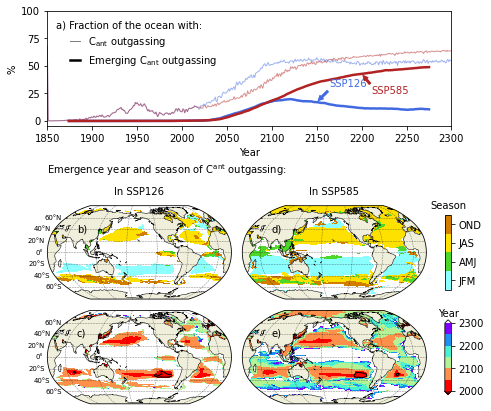

In [18]:
%%time 
print(datetime.datetime.now())
print('Fig. 3: plot')

# Load data2plot
savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
# Load detectable
savedfile = dirout+'data2plot-fig3-timeseries.pckl'
with open(savedfile, 'rb') as f1: data2plot_ts = pickle.load(f1)
        
simu_list = ['ssp126', 'ssp585']

#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 3, 2
ccrsproj = ccrs.Robinson(central_longitude=-155)
#fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), squeeze=False, subplot_kw=dict(projection=ccrsproj))
fsize = (16*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#---------------------
# PLOTTING KWARGS
#---------------------

from matplotlib import cm
from matplotlib.colors import ListedColormap

# kwmap_year
a = cm.get_cmap('rainbow_r',64)
colors = a(np.linspace(0,1,6))
newcmap = ListedColormap(colors)
newcmap.set_over("white")
newcmap.set_under("darkred")
kwmap_year = dict(transform=ccrs.PlateCarree(), vmin = 2000, vmax = 2300, cmap=newcmap)

# kwmap_seas
colors = np.array([[140/255, 255/255, 255/255, 1.00], 
                   [ 79/255, 214/255,  42/255, 1.00], 
                   [255/255, 225/255,   0/255, 1.00], 
                   [209/255, 125/255,   0/255, 1.00]] )
newcmap = ListedColormap(colors)
newcmap.set_over("white")
kwmap_seas = dict(transform=ccrs.PlateCarree(), vmin = .5, vmax = 4.5, cmap=newcmap)

# kwline_ts
kwline_ts = {
    'ssp126'      : dict(c='royalblue'), 
    'ssp585'      : dict(c='firebrick')
} 

#---------------------
# Plot timeseries area emerged
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

for simu in simu_list:
    X = data2plot_ts[simu]['frac_oarea_outgas']['X']
    Y = data2plot_ts[simu]['frac_oarea_outgas']['Y']
    #ll, = zax.plot(X, Y, label=simu.upper()+', C$_{ant} outgassing$', ls='-', lw=1., alpha=.5, **kwline_ts[simu])
    ll, = zax.plot(X, Y, ls='-', lw=1., alpha=.5, **kwline_ts[simu])
    ll1, = zax.plot(X, Y*np.nan, label='C$_{\mathrm{ant}}$ outgassing', ls='-', lw=1., alpha=.5, c='black')
    X = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X']
    Y = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y']
    # ll, = zax.plot(X, Y, label=simu.upper()+', emerging C$_{ant} outgassing$', ls='-', lw=2.5, **kwline_ts[simu])
    ll, = zax.plot(X, Y, ls='-', lw=2.5, **kwline_ts[simu])
    ll2, = zax.plot(X, Y*np.nan, label='Emerging C$_{\mathrm{ant}}$ outgassing', ls='-', lw=2.5, c='black')
#
legkwargs={
    'title': subnum.pop()+r') Fraction of the ocean with:         ',
    'frameon': False,
    'handlelength': 1.0
}
zax.legend(handles=[ll1, ll2], **legkwargs)
#zax.set_title()
zax.set_ylabel('%')
zax.set_xlabel('Year')
zax.set_xlim(1850, 2300)
zax.set_ylim(-5, 100)

simu='ssp126'
zwx = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X'][-150]
zwy = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y'][-150]
zax.annotate('SSP126', (zwx, zwy), (13, 15), textcoords='offset points', \
             color=kwline_ts[simu]['c'], \
             arrowprops=dict(arrowstyle='simple',shrinkA=0, \
                             relpos=(0, 0), color=kwline_ts[simu]['c']))

simu='ssp585'
zwx = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X'][-100]
zwy = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y'][-100]
zax.annotate('SSP585', (zwx, zwy), (10, -20), textcoords='offset points', \
             color=kwline_ts[simu]['c'], \
             arrowprops=dict(arrowstyle='simple',shrinkA=0, \
                             relpos=(0, 1), color=kwline_ts[simu]['c']))

#---------------------
# Plot maps
#---------------------

iplot = 3
for isimu, vsimu in enumerate(simu_list): 
    fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    iplot+=1
    fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    iplot+=1
#

for isimu, vsimu in enumerate(simu_list): 

    # sACOD
    #zax = fig.add_subplot(nrow, ncol, 1, projection=ccrsproj)
    zax = fig.axes[isimu+1]
    X = data2plot[vsimu]['sACOD']['X']
    Y = data2plot[vsimu]['sACOD']['Y']
    Z = data2plot[vsimu]['sACOD']['Z']
    pcm1 = zax.pcolormesh(X, Y, Z, **kwmap_seas)
    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ')'
    zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')
    
    # yACOD
    #zax = fig.add_subplot(nrow, ncol, 3, projection=ccrsproj)
    zax = fig.axes[isimu+1+2]
    X = data2plot[vsimu]['yACOD']['X']
    Y = data2plot[vsimu]['yACOD']['Y']
    Z = data2plot[vsimu]['yACOD']['Z']
    pcm2 = zax.pcolormesh(X, Y, Z, **kwmap_year)

    # yACOD = 2030
    zwX = data2plot[vsimu]['yACOD']['X']
    zwY = data2plot[vsimu]['yACOD']['Y']
    zwZ = data2plot[vsimu]['yACOD']['Z']
    grid_in  = {'lon':zwX, 'lat':zwY}
    ds_out = xe.util.grid_global(1, 1)
    regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, reuse_weights=False)
    Z1 = regridder(zwZ)
    X1, Y1 = ds_out['lon'], ds_out['lat']
    cl = zax.contour(X1, Y1, Z1, levels = [2030], linewidths=1., linestyles='-', colors='k', transform=ccrs.PlateCarree())

    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ')'
    zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

#

#---------------------
# Repositionning maps axes
#---------------------

fig.tight_layout()

#_____________________
# Lower 1st row of map
for zax in fig.axes[1:3]: 
    zw1 = zax.get_position()
    nw  = zw1.width
    nh  = zw1.height
    nx0 = zw1.x0
    ny0 = zw1.y0 - 0.3*zw1.height
    zax.axes.set_position([nx0, ny0, nw, nh])
# 
#_____________________
# lift 2nd row of  map
for zax in fig.axes[3:5]: 
    zw1 = zax.get_position()
    nw  = zw1.width
    nh  = zw1.height
    nx0 = zw1.x0
    ny0 = zw1.y0 + 0.4*zw1.height
    zax.axes.set_position([nx0, ny0, nw, nh])
# 



#---------------------
# Colorbar
#---------------------

hfrac, wfrac = .8, .1

zw1 = fig.axes[2].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0 + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm1, cax=cax, orientation='vertical', ticklocation='right',
                    ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(['JFM', 'AMJ', 'JAS', 'OND'])  # vertical colorbar
cax.set_title("Season", fontsize='medium')

zw1 = fig.axes[4].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0  + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm2, cax=cax, orientation='vertical', ticklocation='right', 
                    extend='both')
cax.set_title("Year", fontsize='medium')

#---------------------
# Extra text
#---------------------

# kwtxt = dict(fontsize='large', rotation='horizontal', ha='center', va='bottom')
kwtxt = {"ha": 'left', "va":'bottom'}

zw1 = fig.axes[1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .3*zw1.height
fig.text(nx0, ny0, 'Emergence year and season of C$^{\mathrm{ant}}$ outgassing: ', **kwtxt)

kwtxt = {"ha": 'center', "va":'bottom'}
zw1 = fig.axes[1].get_position()
nx0 = 0.5 *(zw1.x0 + zw1.x1)
ny0 = zw1.y1 + .1*zw1.height
fig.text(nx0, ny0, 'In SSP126', **kwtxt)

zw1 = fig.axes[2].get_position()
nx0 = 0.5 *(zw1.x0+zw1.x1)
fig.text(nx0, ny0, 'In SSP585', **kwtxt)

#---------------------
# Repositionning time series axes
#---------------------

zw1 = fig.axes[1].get_position()
zw2 = fig.axes[-1].get_position()
zw3 = fig.axes[0].get_position()

nx0 = zw1.x0
nw = zw2.x1 - nx0
ny0 = zw3.y0
nh = 0.8*zw3.height
fig.axes[0].axes.set_position([nx0, ny0, nw, nh])

#---------------------
# Save figure
#---------------------

fignam = 'fig-3.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 17s

## Plot month of Cant outgassing emergence

In [317]:
%%time
print(datetime.datetime.now())
print('Fig. 3: load and prepare data2plot')
print('Plot month of Cant outgassing emergence')

#___________________________
# Masks
ocean_mask = xr.where(grid['pmask'].load()==0, False, True)
land_mask  = xr.where(grid['pmask'].load()==0, True, False)

data2plot = {}

for simu in simu_list: 
    
    print('> simu: '+simu)
    print(datetime.datetime.now())
    data2plot[simu] = {}
        
    #___________________________
    # Load netcdf acod-monthly
    print('>> Load netcdf acod-mont...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'.nc'
    acod_monthly = xr.open_dataset(netcdf_name, chunks='auto', **kwopends)['acod_year'] # chunks to use dask array
    print('File loaded: '+netcdf_name)
    

    #___________________________
    # Compute mACOD, month of earliest outgassing
    print('>> Compute mACOD, month of earliest outgassing...')
    # get late_mask
    yacod = acod_monthly.min(dim='month')
    zwnans = xr.apply_ufunc(np.isnan, yacod, dask='allowed')
    late_mask  = ocean_mask & zwnans
    # compute macod
    zwnans = xr.apply_ufunc(np.isnan, acod_monthly, dask='allowed')
    acod_monthly = xr.where(zwnans, 1e20, acod_monthly) # reaplce nan by very high value to get argmin
    macod = acod_monthly.argmin(dim='month')
    acod_monthly = xr.where(zwnans, np.nan, acod_monthly) # replace back 1e20 by nan
    macod = xr.where(land_mask, np.nan, macod)
    macod = xr.where(late_mask, 1e20, macod) # replace late values by 1e20
    print('Done')


    #___________________________
    # Store in data2plot
    print('>> Store in data2plot')
    Y, X = grid['plat'], grid['plon']
    data2plot[simu]['mACOD'] = {'X':X.values, 'Y':Y.values, 'Z':macod.values}
    
#

# ca. 300ms

2023-09-25 20:20:37.084716
Fig. 3: load and prepare data2plot
Plot month of Cant outgassing emergence
> simu: ssp126
2023-09-25 20:20:37.086444
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126.nc
>> Compute mACOD, month of earliest outgassing...
Done
>> Store in data2plot
> simu: ssp585
2023-09-25 20:20:37.308184
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585.nc
>> Compute mACOD, month of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 143 ms, sys: 40.2 ms, total: 183 ms
Wall time: 337 ms


2023-09-25 20:20:37.430049
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: maps-month-cant-outgassing-emergence.png
CPU times: user 7.06 s, sys: 1.14 s, total: 8.2 s
Wall time: 6.89 s


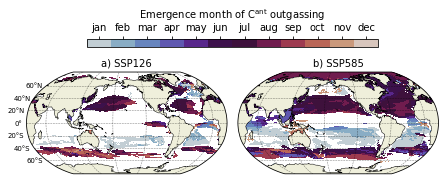

In [318]:
%%time 
print(datetime.datetime.now())

simu_list = ['ssp126', 'ssp585']

#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 1, 2
ccrsproj = ccrs.Robinson(central_longitude=-155)
#fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), squeeze=False, subplot_kw=dict(projection=ccrsproj))
fsize = (16*cm2in, 6*cm2in) # width, height
fig, ax = plt.subplots(nrow, ncol, squeeze=False, figsize=fsize, subplot_kw=dict(projection=ccrsproj))

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#---------------------
# PLOTTING KWARGS
#---------------------

from matplotlib import cm
from matplotlib.colors import ListedColormap

# kwmap_month
a = cm.get_cmap('twilight',64)
#a = cm.get_cmap('turbo',64)
colors = a(np.linspace(0,1,14))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over("white")
newcmap.set_under("white")
#newcmap.set_bad("white")
kwmap_month = dict(transform=ccrs.PlateCarree(), vmin = .5, vmax = 12.5, cmap=newcmap)

#---------------------
# Plot maps
#---------------------

for isimu, vsimu in enumerate(simu_list): 

    # sACOD
    #zax = fig.add_subplot(nrow, ncol, 1, projection=ccrsproj)
    zax = ax[0,isimu]
    X = data2plot[vsimu]['mACOD']['X']
    Y = data2plot[vsimu]['mACOD']['Y']
    Z = data2plot[vsimu]['mACOD']['Z']
    pcm1 = zax.pcolormesh(X, Y, Z, **kwmap_month)
    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ') '+vsimu.upper()
    zax.set_title(zwtitle, fontsize='medium')
    # zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')
    

#

#---------------------
# Repositionning maps axes
#---------------------

fig.tight_layout()


#---------------------
# Colorbar
#---------------------


zw1 = ax[0, 0 ].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0+zw1.width*.3
ny0 = zw1.y1 + .25 * zw1.height
nh  = 0.1*zw1.width
nw  = zw2.x1-zw2.width*.3 - nx0
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm1, cax=cax, orientation='horizontal', ticklocation='top', \
                    label = "Emergence month of C$^{\mathrm{ant}}$ outgassing", \
                    ticks=np.arange(1, 13))
cbar.ax.set_xticklabels(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
                         'aug', 'sep','oct', 'nov', 'dec'])  # horizontal colorbar


#---------------------
# Save figure
#---------------------

fignam = 'maps-month-cant-outgassing-emergence.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 7s

# Compute CO2 solubilities and schmidt number

## Define functions

In [125]:
%%time
print(datetime.datetime.now())
print('Compute CO2 solubilities and schmidt number')
print('Define functions')

def compute_khd(ptho, psao) : 

    """
    Compute solubility of CO2 from Weiss (1974)
    Khd = [CO2]/ p CO2, Weiss (1974), for dry air

    inputs: 
        ptho    = temperature [degreeC]
        psao    = salinity    [psu]
    outputs: (Khd) in [mol/l/ppm] and [mol/l/uatm]
        Khd: CO2 solubility for use with partial pressure in moist air
             (no correction for water vapor included) in [mol/l/uatm]
    """

    # Carbon chemistry: Caculate equilibrium constants and solve for [H+] and
    # carbonate alkalinity (ac)
    
    print('func: comp_khd')
    
    nans = np.isnan(ptho) | np.isnan(psao)
    
    tzero   = 273.15
    zw = np.where(ptho>=-3., ptho, -3.)
    tt = np.where(zw<=40., zw, 40.)
    ttk    = tt + tzero
    ttk100 = ttk/100.0

    zw = np.where(psao>=25., psao, 25.)
    ss = np.where(zw<=40., zw, 40.)
    
    ad1 = -60.2409
    ad2 = 93.4517
    ad3 = 23.3585
    bd1 = 0.023517
    bd2 = -0.023656
    bd3 = 0.0047036

    # Khd = [CO2]/ pCO2 pco2 in seawater
    # Weiss (1974) for dry air [mol/kg/atm]
    nKhwe74 = ad1 + ad2/ttk100 + ad3*np.log(ttk100) + ss*(bd1 + bd2*ttk100 + bd3*ttk100**2)
    Khd     = np.where(nans, np.nan, np.exp(nKhwe74))

    # Khd: CO2 solubility for use with partial pressure in moist air
    #      (no correction for water vapor included) in mol/l/uatm
    return Khd*1e-6
#
def compute_kh(ptho, psao) : 

    """
    Compute solubility of CO2 from Weiss (1974)
    Kh = [CO2]/ p CO2, Weiss (1974), refitted for moist air Weiss and Price (1980)

    inputs: 
        ptho    = temperature [degreeC]
        psao    = salinity    [psu]
    outputs: (Kh, Khd) in [mol/l/ppm] and [mol/l/uatm]
        Kh: CO2 solubility for use with partial pressure in dry air 
            (include correction for accounting for water vapor) in [mol/l/ppm]
    """

    # Carbon chemistry: Caculate equilibrium constants and solve for [H+] and
    # carbonate alkalinity (ac)
    
    print('func: comp_kh')
    
    nans = np.isnan(ptho) | np.isnan(psao)

    tzero   = 273.15
    zw = np.where(ptho>=-3., ptho, -3.)
    tt = np.where(zw<=40., zw, 40.)
    ttk    = tt + tzero
    ttk100 = ttk/100.0

    zw = np.where(psao>=25., psao, 25.)
    ss = np.where(zw<=40., zw, 40.)

    ac1 = -162.8301
    ac2 = 218.2968
    ac3 = 90.9241
    ac4 = -1.47696
    bc1 = 0.025695
    bc2 = -0.025225
    bc3 = 0.0049867
    
    # Kh = [CO2]/ xCO2 dry mole fraction of [CO2]
    # Weiss (1974), refitted for moist air Weiss and Price (1980) [mol/kg/atm]
    nKhwe74 = ac1 + ac2/ttk100 + ac3*np.log(ttk100) + ac4*ttk100**2 + ss*(bc1 + bc2*ttk100 + bc3*ttk100**2)
    Kh     = np.where(nans, np.nan, np.exp(nKhwe74))

    # Kh: CO2 solubility for use with partial pressure in dry air 
    #     (include correction for accounting for water vapor) in mol/l/ppm
    return Kh*1e-6
#

def compute_schmidt_number(zwtemp): 
    """
    Compute Schmidt number from temperature
    Probably from Sarmiento and Gruber (2006)
    """
    print("func: compute_schmidt_number(zwtemp)")
    Sc = 2116.8 - 136.25*zwtemp + 4.7353*zwtemp**2 - 0.092307*zwtemp**3 +0.0007555*zwtemp**4
    return Sc
#



2023-09-13 16:21:54.492060
Compute CO2 solubilities and schmidt number
Define functions
CPU times: user 98 µs, sys: 0 ns, total: 98 µs
Wall time: 109 µs


## Computation

In [136]:
%%time
print(datetime.datetime.now())
print('Compute CO2 solubilities and schmidt number')
print('Computation')

simu_list = ['preindustrial', 'historical', 'ssp126', 'ssp585']

for simu in simu_list: 
    
    print('> simu: '+simu)
    
    print('Load temperature...')
    var = 'stemp'
    ncfile = dirout+var+'_noresm2-lm_'+simu+'.nc'
    zwds_sst = xr.open_dataset(ncfile, chunks='auto', **kwopends) # chunks to use dask array
    zwda_sst = zwds_sst[var]
    print('Done, file loaded: '+ncfile)
    
    print('Load salinity...')
    var = 'ssali'
    ncfile = dirout+var+'_noresm2-lm_'+simu+'.nc'
    zwds_sss = xr.open_dataset(ncfile, chunks='auto', **kwopends) # chunks to use dask array
    zwda_sss = zwds_sss[var]
    print('Done, file loaded: '+ncfile)

    print('Compute Kh...')
    Kh = xr.apply_ufunc(compute_kh, zwda_sst, zwda_sss, dask='allowed')
    Kh = Kh.rename('kh')
    Kh.attrs['comments'] = 'Kh = [CO2]/ xCO2 (xCO2 is dry mole fraction of [CO2]), CO2 solubility for \
    use with partial pressure in dry air (include correction for accounting for water vapor) in \
    mol/l/ppm, Weiss (1974), refitted for moist air Weiss and Price (1980)'
    Kh.attrs['units'] = 'mol l-1 ppm-1'
    Kh.attrs['cell_measures'] = zwda_sst.attrs['cell_measures']
    print('Done')
    print('Save in netcdf...')
    savefile = dirout+'kh_noresm2-lm_'+simu+'.nc'
    Kh.to_netcdf(savefile)
    print('Done, file saved: '+savefile)

    print('Compute Khd...')
    Khd = xr.apply_ufunc(compute_khd, zwda_sst, zwda_sss, dask='allowed')
    Khd = Khd.rename('khd')
    Khd.attrs['comments'] = 'Khd = [CO2]/ pCO2 (pCO2 is partial pressure of [CO2] in seawater), \
    CO2 solubility for use with partial pressure in moist air (no correction for water vapor \
    included) in mol/l/uatm, Weiss (1974) for dry air [mol/kg/atm]'
    Khd.attrs['units'] = 'mol l-1 uatm-1'
    Khd.attrs['cell_measures'] = zwda_sst.attrs['cell_measures']
    print('Done')
    print('Save in netcdf...')
    savefile = dirout+'khd_noresm2-lm_'+simu+'.nc'
    Khd.to_netcdf(savefile)
    print('Done, file saved: '+savefile)

    print('Compute Sc...')
    Sc = xr.apply_ufunc(compute_schmidt_number, zwda_sst, dask='allowed')
    Sc = Sc.rename('sc')
    Sc.attrs['comments'] = 'Compute Schmidt number from temperature. Probably \
    from Sarmiento and Gruber (2006).'
    Sc.attrs['cell_measures'] = zwda_sst.attrs['cell_measures']
    print('Done')
    print('Save in netcdf...')
    savefile = dirout+'sc_noresm2-lm_'+simu+'.nc'
    Sc.to_netcdf(savefile)
    print('Done, file saved: '+savefile)
#
    
# ca. 4m20s

2023-09-13 16:30:26.435841
Compute CO2 solubilities and schmidt number
Computation
> simu: preindustrial
Load temperature...
Done, file loaded: cc2300-230215-noresm2-lm/stemp_noresm2-lm_preindustrial.nc
Load salinity...
Done, file loaded: cc2300-230215-noresm2-lm/ssali_noresm2-lm_preindustrial.nc
Compute Kh...
func: comp_kh
Done
Save in netcdf...
[########################################] | 100% Completed | 9.29 s
Done, file saved: cc2300-230215-noresm2-lm/kh_noresm2-lm_preindustrial.nc
Compute Khd...
func: comp_khd
Done
Save in netcdf...
[########################################] | 100% Completed | 8.59 s
Done, file saved: cc2300-230215-noresm2-lm/khd_noresm2-lm_preindustrial.nc
Compute Sc...
func: compute_schmidt_number(zwtemp)
Done
Save in netcdf...
[########################################] | 100% Completed | 7.96 s
Done, file saved: cc2300-230215-noresm2-lm/sc_noresm2-lm_preindustrial.nc
> simu: historical
Load temperature...
Done, file loaded: cc2300-230215-noresm2-lm/stemp_nores

## Load and save xarray dataset in a pickle

In [137]:
%%time
print(datetime.datetime.now())
print('Load and save xarray dataset in a pickle')

simu_list = ['preindustrial', 'historical', 'ssp126', 'ssp585']
var_list = ['kh', 'khd', 'sc']

#------------------------
# Initialised data2save
#------------------------

data2save = {}
for var in var_list: 
    data2save[var] = {}
    for simu in simu_list :     
        data2save[var][simu] = {}
    #
#

#------------------------
# Loop on simu
#------------------------

for simu in simu_list: 
    print('> simu: '+simu)
    for var in var_list: 
        print('>> var: '+var)
        ncfile = dirout+var+'_noresm2-lm_'+simu+'.nc'
        data2save[var][simu] = xr.open_dataset(ncfile, chunks='auto', **kwopends)[var] # chunks to use dask array
    #    
#

#------------------------
# Save as a pickle
#------------------------

print('> Save as a pickle')
savedfile = dirout+'datasave-kh-khd-sc-noresm2-lm.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("Done, file saved: "+savedfile)

# ca. 1s

2023-09-13 16:31:59.025865
Load and save xarray dataset in a pickle
> simu: preindustrial
>> var: kh
>> var: khd
>> var: sc
> simu: historical
>> var: kh
>> var: khd
>> var: sc
> simu: ssp126
>> var: kh
>> var: khd
>> var: sc
> simu: ssp585
>> var: kh
>> var: khd
>> var: sc
> Save as a pickle
Done, file saved: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
CPU times: user 155 ms, sys: 36.8 ms, total: 191 ms
Wall time: 274 ms


# Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends

\begin{align}
\frac{\mathrm{d}pCO_2}{\mathrm{d}t} =&&& \frac{\overline{pCO_2} \times \overline{S}}{\gamma_C \times S_0} \times \frac{\partial C_s}{\partial t}  +
                  \frac{\overline{pCO_2} \times \overline{S}}{\gamma_A \times S_0} \times \frac{\partial A_s}{\partial t}  && {\rm \bf Carbon\ system} \\
                  &+&& \overline{pCO_2} \times \gamma_T \times \frac{\partial T}{\partial t} && {\rm \bf Thermal} \\
                  &+&& \left( \frac{\overline{pCO_2} \times \overline{C_s}}{\gamma_C \times S_0} + \frac{\overline{pCO_2} \times \overline{A_s}}{\gamma_A \times S_0} + \frac{\overline{pCO_2} \times \gamma_S}{\overline{S}} \right) \times \frac{\partial S}{\partial t} && {\rm \bf Freshwater\ and\ salinity}
\end{align}

with: 
- $\overline{X}$ is the mean of $X$ over the time period considered
- $\partial X / \partial t $ is the trend of $X$ over the time period considered
- $C_s$ and $A_s$ DIC and ALK normalized with salinity: $X_s = S_0/S \times X$. $S_0$ is the temporal average of $S$ all over the simulation.
- $\gamma_C$ and $\gamma_A$ computed with pyCO2SYS, $\partial pCO_2/\partial X = pCO_2/\gamma_X$
- $\gamma_T = 0.0423$, $\gamma_S = 1$

## Test for one grid point

1. Load pCO2, Khd, Kh, sdic, salk, sss, sst
    1. Select grid point
2. Compute pCO2-atm and salinity normalized DIC and ALK 
3. Select season
4. Compute mean and trends
5. Compute taylor expansion coefficient
6. Compute taylor expansion terms
7. Save datas
   - **main terms** : pco2 trend, carbon system trend, thermal trend and freshwater trend *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'*
    - **Extra terms**: 
        - time running means: *dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'*
        - trends: *dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc"*
        - coefficients: *dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'*
        - taylor terms: *dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'*
        - Reference salinity: *dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'*



### Input

In [176]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for one grid point: input")

simu = 'ssp585'
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
seas_list  = ['JAS', 'JFM']
nbyear = 50 # number of year to compute the mean and trends

jjj, iii = (110, 325)

#___________________________
# Masks
ocean_mask = xr.where(grid['pmask'].load()==0, False, True)
land_mask  = xr.where(grid['pmask'].load()==0, True, False)


2023-09-16 16:37:21.796692
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for one grid point: input
CPU times: user 2.63 ms, sys: 17 µs, total: 2.65 ms
Wall time: 2.38 ms


### Prepare data2plot

In [180]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for one grid point: prepare data2plot")

#----------------
# 1 - Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2
# 1bis - Select grid point
#----------------

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'kh', 'khd', 'sdic-tot', 'salk-tot', 'stemp', 'ssali', 'atmco2']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')\
        .isel(y=jjj, x=iii)
    else: zw = load_and_concat_hist_ssp(var, simu).isel(y=jjj, x=iii)
    zwplat = grid['plat'].isel(y=jjj, x=iii)
    zwplon = grid['plon'].isel(y=jjj, x=iii)
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#----------------
# 2 - Compute pco2-atm and salinity normalized DIC and ALK
#----------------

print('Compute pCO2-atm and salinity normalized DIC and ALK...')

# pco2-atm = atmco2 * Kh / Khd 
# because fgco2 = ( atco2  - xco2 ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# and xco2 = cu * 1.e6 / Kh (dry mole fraction of CO2)
# and pco2 = cu * 1.e6 / Khd (pco2 in seawater)
# thus fgco2 = ( atco2 - pco2 * Khd / Kh ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# thus fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho 
zw = ( zwdata['atmco2'] * zwdata['kh'] / zwdata['khd'] ).rename('pco2-atm')
zw.attrs = zwdata['atmco2'].attrs
addtxt = 'pco2-atm = atmco2 * Kh / Khd because fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho '
try: zw.attrs['history'] = addtxt+' ; '+zw.attrs['history']
except: zw.attrs['history'] = addtxt
zwdata['pco2-atm'] = zw

SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

# remove unnnecessary variables
for vvv in ['atmco2', 'kh', 'khd']: del zwdata[vvv]

#----------------
# 3 - Select season
#----------------

print('Select season...')
seas = 'JFM'
zwdata2 = {}
for kkk, vvv in zwdata.items(): 
    zwdata2[kkk] = select_season(vvv, seas, verbose=False)
#
#del zwdata
print('Done')

#----------------
# 4 - Compute mean and trends
#----------------

zwavg = {}
zwtrd = {}
zfact_alk_dic = 1000./1.024 # from mol.m-3 to umol.kg-1
var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali', 'pco2-atm']
for var in var_list:
    
    # Average
    print('Compute mean of '+var+'...')
    zw = zwdata2[var].rolling(year=nbyear, center=True).mean() 
    if var in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']:
        with xr.set_options(keep_attrs=True): zw = zw*zfact_alk_dic # in umol.kg-1
        zw.attrs['units'] = 'umol kg-1'
    #
    try: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years ; '+ zw.attrs['history']
    except: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years'
    zwavg[var] = zw
    print('Done')
    
    # Trends
    print('Compute trend of '+var+'...')
    zw_shift = xr.apply_ufunc(np.roll, zwavg[var], nbyear, kwargs=dict(axis=0), dask='allowed', keep_attrs=True)
    zw = xr.apply_ufunc(np.roll, (zwavg[var] - zw_shift)/nbyear, -int(nbyear/2), kwargs=dict(axis=0), dask='allowed', keep_attrs=False)
    zw[0] = np.nan
    zw.attrs = zwavg[var].attrs
    zw = zw.rename(var+'-trd')
    try: zw.attrs['long_name'] = 'Trend of '+zwavg[var].attrs['long_name']
    except: zw.attrs['long_name'] = 'Trend of '+var 
    try: zw.attrs['units'] = zw.attrs['units'] + ' y-1'
    except: zw.attrs['units'] = 'y-1'
    addtxt = 'Trend computed as the difference between 2 consecutive time period of '+str(nbyear)+' years'
    try: zw.attrs['history'] = addtxt+' ; '+ zw.attrs['history']
    except: zw.attrs['history'] = addtxt
    zwtrd[var] = zw
    print('Done')
#

#----------------
# 5 - Compute taylor expansion coefficient
#----------------

print('Compute taylor expansion coefficient...')
zwco2sysres = PyCO2SYS.sys(par1=zwavg['salk-tot'], par2=zwavg['sdic-tot'], par1_type=1, par2_type=2, \
                           salinity=zwavg['ssali'], temperature=zwavg['stemp'], \
                           opt_pH_scale=1, opt_k_carbonic=4, opt_k_bisulfate=1)
zwgam = {}

# coef-dic
var = 'sdic-tot'
zw = 1 / (zwco2sysres['gamma_dic'] * 1e6)
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_dic'] * 1e6)"
nwattrs = dict(long_name=var+' coefficient for taylor expansion', units='l umol-1',
               history=addtxt)
zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
zwgam[var]    = zwda

# coef-alk
var = 'salk-tot'
zw = 1 / (zwco2sysres['gamma_alk'] * 1e6)
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_alk'] * 1e6)"
nwattrs = dict(long_name='ALK coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
zwgam[var]    = zwda

# coef-dic-sn
var = 'sdic-tot-sn'
zw = zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
nwattrs = dict(long_name='DIC-sn coefficient for taylor expansion', units='l umol-1', 
              history=addtxt)
zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
zwgam[var]    = zwda

# coef-alk-sn
var = 'salk-tot-sn'
zw = zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
nwattrs = dict(long_name='ALK-sn coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
zwgam[var]    = zwda

# coef-dic-fw
var = 'sdic-tot-fw'
zw = zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
nwattrs = dict(long_name='DIC-fw coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
zwgam[var]    = zwda

# coef-alk-fw
var = 'salk-tot-fw'
zw = zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
nwattrs = dict(long_name='ALK-fw coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
zwgam[var]    = zwda

# coef-sst
var = 'stemp'
zwda = 0.0423 * xr.ones_like(zwavg['stemp'])
zwda[zwavg['stemp'].isnull().values] = np.nan
zwda = zwda.rename('coef-'+var)
zwda.attrs = zwavg['stemp'].attrs
zwda.attrs['long_name'] = 'SST coefficient for taylor expansion'
zwda.attrs['units'] = 'degC-1'
addtxt = "Taylor expansion coefficient 0.0423"
try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
except: zwda.attrs['history'] = addtxt
zwgam[var]       = zwda

# coef-sss
var = 'ssali'
zwda = 1 / zwavg['ssali']
zwda = zwda.rename('coef-'+var)
zwda.attrs = zwavg['ssali'].attrs
zwda.attrs['long_name'] = 'SSS coefficient for taylor expansion'
zwda.attrs['units'] = 'kg g-1'
addtxt = "Taylor expansion coefficient 1 / zwavg['ssali']"
try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
except: zwda.attrs['history'] = addtxt
zwgam[var]       = zwda

print('Done')

#----------------
# 6 - Compute taylor expansion terms
#----------------

print('Compute taylor expansion terms...')
zwtaylor = {}
var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
for var in var_list: 
    
    zwda = zwavg['pco2-tot'] * zwgam[var] * zwtrd[var]
    zwda.attrs = zwgam[var].attrs
    zwda = zwda.rename('taylor-term-'+var)
    zwda.attrs['long_name'] = var+' term for taylor expansion'
    zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units']+' y-1'
    addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam[var] * zwtrd[var]"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwtaylor[var] = zwda
    
#
for var in ['sdic-tot-fw', 'salk-tot-fw']:
    zwda = zwavg['pco2-tot'] * zwgam[var] * zwtrd['ssali']
    zwda.attrs = zwgam[var].attrs
    zwda = zwda.rename('taylor-term-'+var)
    zwda.attrs['long_name'] = var+' term for taylor expansion'
    zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units'] +' y-1'
    addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam[var] * zwtrd[var]"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwtaylor[var] = zwda
#
print('Done')

#----------------
# 7 - Save datas
#----------------

def savedatatonetcdf(zwdict, zwfile, zwcomment=''): 
    print('Save in netcdf...')
    tods = {}
    for kkk, vvv in zwdict.items(): 
        tods[vvv.name] = vvv
    #
    dstosave = xr.Dataset(tods)
    dstosave.attrs['simu'] = 'historical and '+simu
    dstosave.attrs['model'] = 'NorESM2-LM'
    try: dstosave.attrs['comment'] = zwcomment+' ; '+ dstosave.attrs['comment']
    except: dstosave.attrs['comment'] = zwcomment
    dstosave.to_netcdf(zwfile)
    print('Done, file saved: '+zwfile)
#

#___________________
# Main
zwmain = {}
with xr.set_options(keep_attrs=True): 

    zwmain['dpCO2'] = zwtrd['pco2-tot']
    zwmain['dpCO2'] = zwmain['dpCO2'].rename('pco2-trend')

    zwmain['dpCO2-atm'] = zwtrd['pco2-atm']
    zwmain['dpCO2-atm'] = zwmain['dpCO2-atm'].rename('pco2-atm-trend')

    zwmain['thermal'] = zwtaylor['stemp']
    zwmain['thermal'] = zwmain['thermal'].rename('thermal-trend')
    zwmain['thermal'].attrs['long_name'] = 'Thermal trend term for taylor expansion'
    zwmain['thermal'].attrs['comment'] = 'The thermal trend account for the effect of trend in \
    temperature on oceanic pCO2'

    zwmain['carbon']  = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']
    zwmain['carbon'] = zwmain['carbon'].rename('carbon-system-trend')
    zwmain['carbon'].attrs['long_name'] = 'Carbon system trend term for taylor expansion'
    zwmain['carbon'].attrs['comment'] = 'The carbon system trend account for the effect on oceanic pCO2 of the trend \
    in DIC and ALK both salinity normalized. Changes in salinity normalized DIC and ALK exclude changes in DIC and ALK \
    associated with freshwater inputs (eg. evaporation or precipitation).'
    addhistory = "Carbon system trend = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']"
    zwmain['carbon'].attrs['history'] = addhistory+ \
    "\n > history of zwtaylor['sdic-tot-sn']: " + zwtaylor['sdic-tot-sn'].attrs['history'] + \
    "\n > history of zwtaylor['salk-tot-sn']: " + zwtaylor['salk-tot-sn'].attrs['history']
    
    zwmain['fw']      = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']
    zwmain['fw'] = zwmain['fw'].rename('freshwater-trend')
    zwmain['fw'].attrs['long_name'] = 'Freshwater trend term for taylor expansion'
    zwmain['fw'].attrs['comment'] = 'The freshwater trend account for the effect on oceanic pCO2 of trends in \
    freshwater inputs affecting DIC, ALK and salinity. '
    addhistory = "Freshwater trend = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']"
    zwmain['fw'].attrs['history'] = addhistory+ \
    "\n > history of zwtaylor['sdic-tot-fw']: " + zwtaylor['sdic-tot-fw'].attrs['history'] + \
    "\n > history of zwtaylor['salk-tot-fw']: " + zwtaylor['salk-tot-fw'].attrs['history'] + \
    "\n > history of zwtaylor['ssali']: " + zwtaylor['ssali'].attrs['history'] 
#


comment = 'This netcdf contains the terms of the following taylor expansion: \n \
pco2-trend ~ thermal-trend + carbon-system-trend + freshwater-trend'
savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
savedatatonetcdf(zwmain, savefile, zwcomment=comment)

#___________________
# Extra

comment = 'This netcdf contains time running means used for the taylor expansion analysis'
savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
savedatatonetcdf(zwavg, savefile, zwcomment=comment)

comment = 'This netcdf contains the trends used for the taylor expansion analysis'
savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
savedatatonetcdf(zwtrd, savefile, zwcomment=comment)

comment = 'This netcdf contains the coefficient used for the taylor expansion analysis. \
The coefficient are multiply by the average pCO2 and the trend to get the different terms of the taylor expansion'
savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
savedatatonetcdf(zwgam, savefile, zwcomment=comment)

comment = 'This netcdf contains the different terms used for the taylor expansion analysis.'
savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
savedatatonetcdf(zwtaylor, savefile, zwcomment=comment)

savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
SSS0.to_netcdf(savefile)

# ca. 50s

2023-09-16 16:38:51.669626
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for one grid point: prepare data2plot
Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(kh, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(khd, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-nores

### Fig

2023-09-16 16:42:02.751799
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for one grid point: fig
[########################################] | 100% Completed | 1.00 s
CPU times: user 3.81 s, sys: 3.5 s, total: 7.31 s
Wall time: 7.79 s


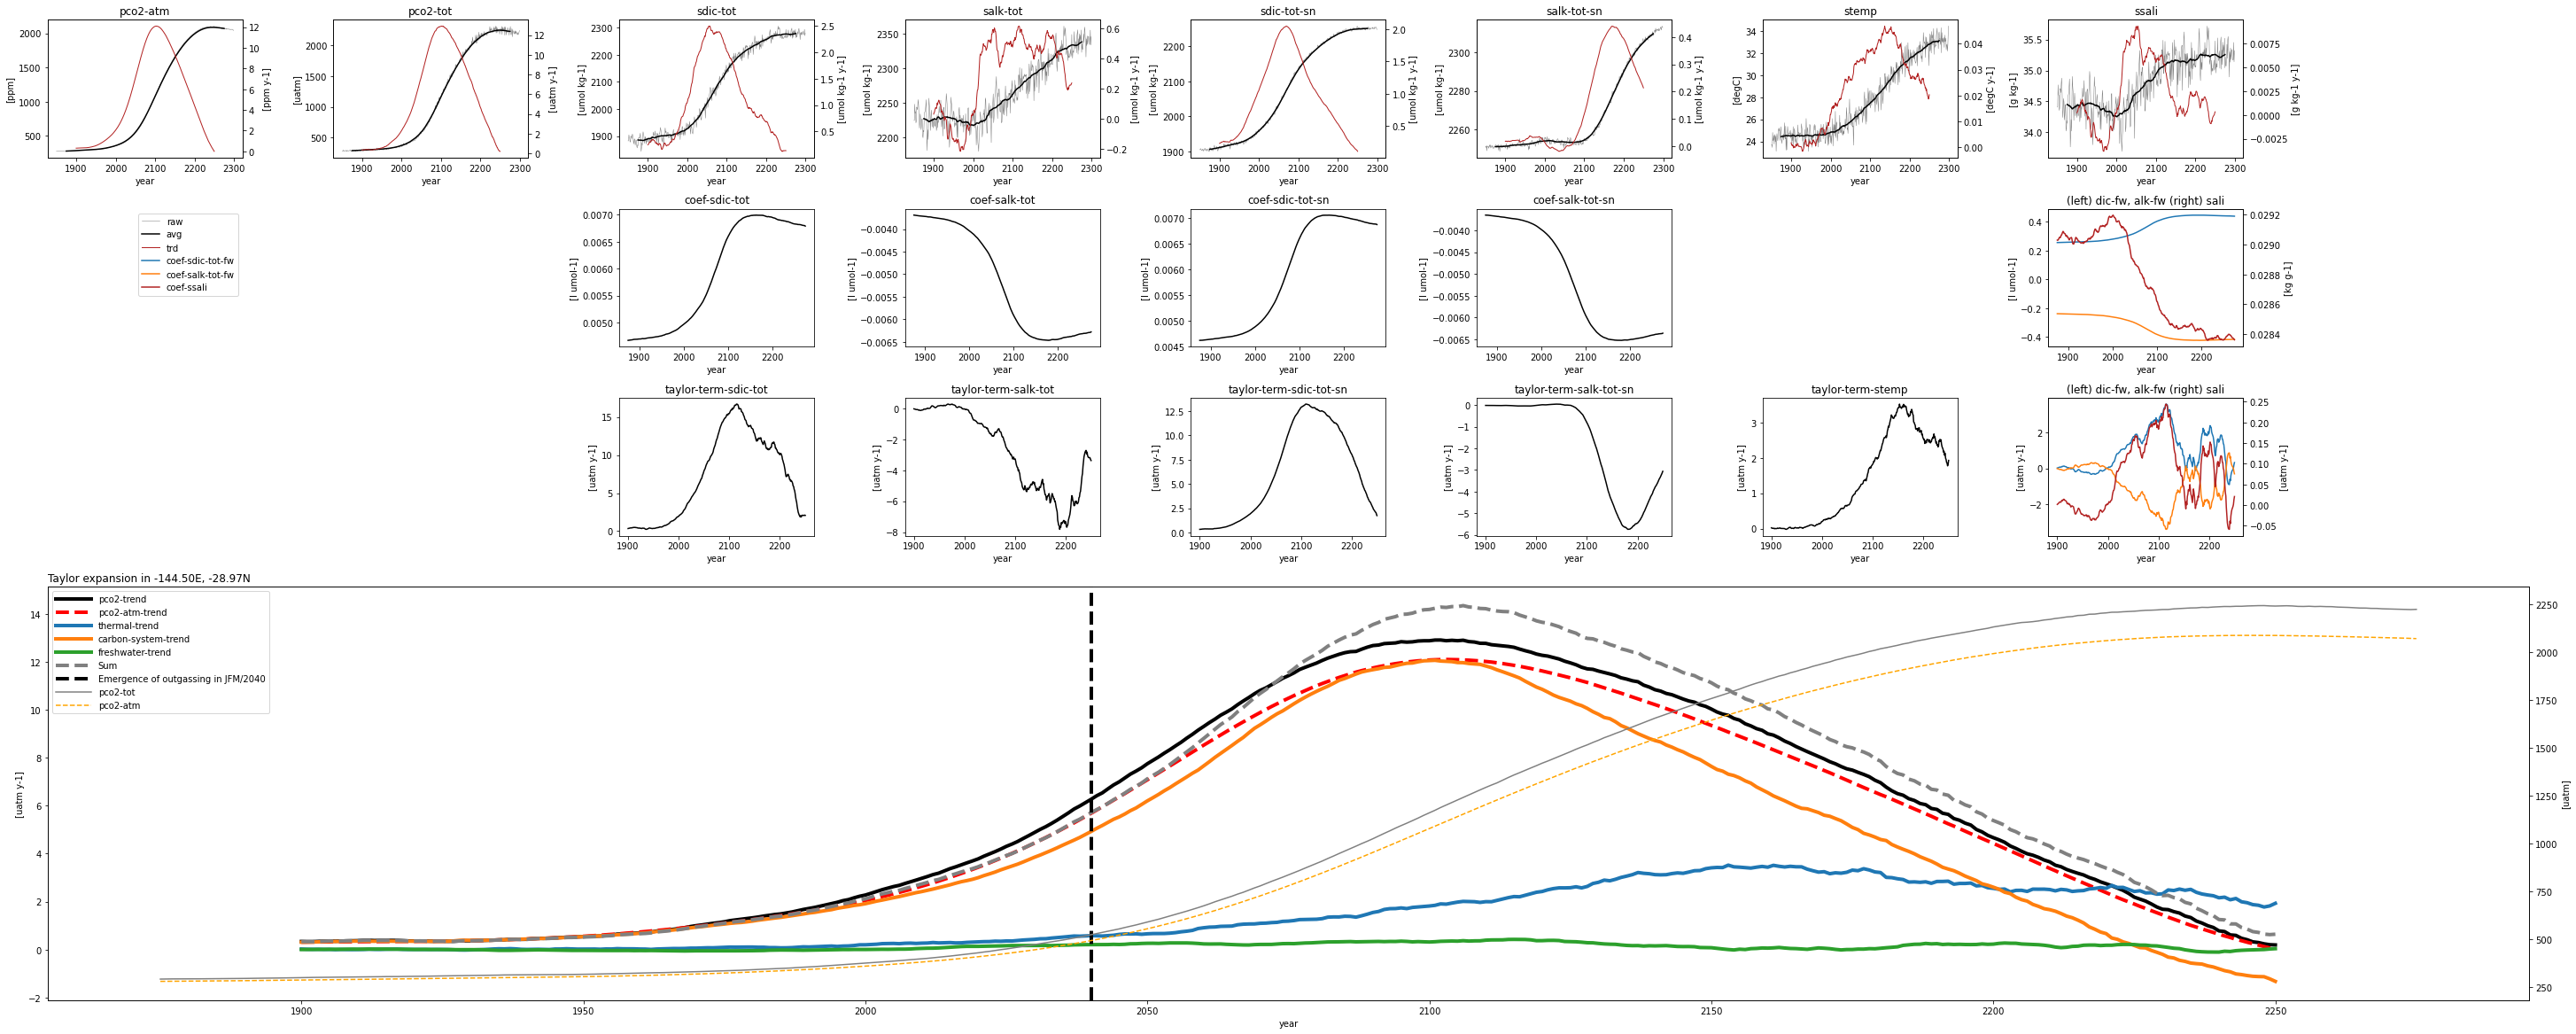

In [185]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for one grid point: fig")

#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 4, 9
fig = plt.figure(figsize=(1.5*ncol*3, 1.5*nrow*2))

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#---------------------
# LOAD DATA
#---------------------


savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
zwmain = xr.open_dataset(savefile, **kwopends)

savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
zwavg = xr.open_dataset(savefile, **kwopends)

savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
zwtrd = xr.open_dataset(savefile, **kwopends)

savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
zwcoef = xr.open_dataset(savefile, **kwopends)

savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'_1gridpoint.nc'
zwtay = xr.open_dataset(savefile, **kwopends)

savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)

#---------------------
# Plot
#---------------------

#_____________________
# First row, averages and trend

irow = 0
lines = []
var_list = ['pco2-atm', 'pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali']
for ivar, vvar in enumerate(var_list): 
    
    iplot = irow*ncol + ivar +1
    zax = fig.add_subplot(nrow, ncol, iplot)

    if vvar in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']: 
        zfact = 1000./1.024 # from mol.m-3 to umol.kg-1
    else: zfact = 1
    X = zwdata2[vvar].year.values
    Y = zwdata2[vvar].values * zfact
    llraw, = zax.plot(X, Y, c='grey', lw=.5, label='raw')

    X = zwavg[vvar].year.values
    Y = zwavg[vvar].values
    llavg, = zax.plot(X, Y, c='k', lw=1.5, label='avg')
    
    zax2 = zax.twinx()
    
    X = zwtrd[vvar+'-trd'].year.values
    Y = zwtrd[vvar+'-trd'].values
    lltrd, = zax2.plot(X, Y, c='firebrick', lw=1, label='trd')
    
    zax.set_title('%s'%vvar)
    zax.set_ylabel('[%s]'%zwavg[vvar].attrs['units'])
    zax.set_xlabel('year')
    zax2.set_ylabel('[%s]'%zwtrd[vvar+'-trd'].attrs['units'])
            
    if vvar == 'ssali': lines.extend([llraw, llavg, lltrd])

#


#_____________________
# Second row taylor expansion coefficient

irow = 1
var_list = ['coef-sdic-tot', 'coef-salk-tot', 'coef-sdic-tot-sn', 'coef-salk-tot-sn']
for ivar, vvar in enumerate(var_list):
    iplot = irow*ncol + ivar + 3
    zax = fig.add_subplot(nrow, ncol, iplot)
    X = zwcoef[vvar].year.values
    Y = zwcoef[vvar].values
    zax.plot(X, Y, c='k', lw=1.5)
    zax.set_title(vvar)
    zax.set_ylabel('[%s]'%zwcoef[vvar].attrs['units'])
    zax.set_xlabel('year')


#
 
iplot+=2
zax = fig.add_subplot(nrow, ncol, iplot)
for vvar in ['coef-sdic-tot-fw', 'coef-salk-tot-fw']: 
    X = zwcoef[vvar].year.values
    Y = zwcoef[vvar].values
    ll, = zax.plot(X, Y, lw=1.5, label=vvar)
    lines.append(ll)
#
zax.set_title('(left) dic-fw, alk-fw (right) sali')
zax.set_ylabel('[%s]'%zwcoef[vvar].attrs['units'])
zax.set_xlabel('year')
zax2 = zax.twinx()
vvar='coef-ssali'
X = zwcoef[vvar].year.values
Y = zwcoef[vvar].values
ll, = zax2.plot(X, Y, lw=1.5, c='firebrick', label=vvar)
lines.append(ll)
zax2.set_ylabel('[%s]'%zwcoef[vvar].attrs['units'])

#___________
# legend
zax = fig.add_subplot(nrow, ncol, ncol+1)
zax.axis('off')
zax.legend(handles=lines)

#_____________________
# Third row taylor expansion terms

irow = 2
var_list = ['taylor-term-sdic-tot', 'taylor-term-salk-tot', 'taylor-term-sdic-tot-sn', 'taylor-term-salk-tot-sn', 'taylor-term-stemp']
for ivar, vvar in enumerate(var_list): 
    iplot = irow*ncol + ivar + 3
    zax = fig.add_subplot(nrow, ncol, iplot)
    X = zwtay[vvar].year.values
    Y = zwtay[vvar].values
    zax.plot(X, Y, c='k', lw=1.5, label='avg')
    zax.set_title(vvar)
    zax.set_ylabel('[%s]'%zwtay[vvar].attrs['units'])
    zax.set_xlabel('year')


#
   
iplot+=1
zax = fig.add_subplot(nrow, ncol, iplot)
var_list = ['taylor-term-sdic-tot-fw', 'taylor-term-salk-tot-fw']
for vvar in var_list: 
    X = zwtay[vvar].year.values
    Y = zwtay[vvar].values
    zax.plot(X, Y, lw=1.5, label=vvar)
#
zax.set_title('(left) dic-fw, alk-fw (right) sali')
zax.set_ylabel('[%s]'%zwtay[vvar].attrs['units'])
zax.set_xlabel('year')
zax2 = zax.twinx()
vvar='taylor-term-ssali'
X = zwtay[vvar].year.values
Y = zwtay[vvar].values
zax2.plot(X, Y, lw=1.5, c='firebrick', label=vvar)
zax2.set_ylabel('[%s]'%zwtay[vvar].attrs['units'])


#_____________________
# Fourth row taylor expansion main terms

zax = fig.add_subplot(nrow, 1, 4)
lines = []
vvar = 'pco2-trend'
X = zwmain[vvar].year.values
Y = zwmain[vvar].values
ll, = zax.plot(X, Y, lw=4, c='k', label=vvar)
lines.append(ll)
vvar = 'pco2-atm-trend'
X = zwmain[vvar].year.values
Y = zwmain[vvar].values
ll, = zax.plot(X, Y, lw=4, c='r', ls='--', label=vvar)
lines.append(ll)
zw = np.zeros_like(Y)
var_list = ['thermal-trend', 'carbon-system-trend', 'freshwater-trend']
for vvar in var_list: 
    X = zwmain[vvar].year.values
    Y = zwmain[vvar].values
    ll, = zax.plot(X, Y, lw=4, label=vvar)
    lines.append(ll)
    zw+=Y
#
ll, = zax.plot(X, zw, lw=4, c='grey', ls='--', label='Sum')
lines.append(ll)
yacod = data2plot_fig3[simu]['yACOD']['Z'][jjj, iii]
sacod = ['JFM', 'AMJ', 'JAS', 'OND'][int(data2plot_fig3[simu]['sACOD']['Z'][jjj, iii] - 1)]
ll = zax.axvline(yacod, ls='--', lw=4, c='k', label='Emergence of outgassing in %s/%d'%(sacod, yacod))
lines.append(ll)

zax.set_ylabel('[%s]'%zwmain['pco2-trend'].attrs['units'])
zax.set_xlabel('year')
zax.set_title('Taylor expansion in %.2fE, %.2fN'%(zwmain['pco2-trend'].plon.values,\
                                                  zwmain['pco2-trend'].plat.values), loc='left')
zax2 = zax.twinx()
X = zwavg['pco2-tot'].year.values
Y = zwavg['pco2-tot'].values
ll, = zax2.plot(X, Y, c='grey', ls='-', lw=1.5, label='pco2-tot')
lines.append(ll)
X = zwavg['pco2-atm'].year.values
Y = zwavg['pco2-atm'].values
ll, = zax2.plot(X, Y, c='orange', ls='--', lw=1.5, label='pco2-atm')
lines.append(ll)
zax2.set_ylabel('[%s]'%zwavg['pco2-tot'].attrs['units'])

zax2.legend(handles=lines, handlelength=4)


fig.tight_layout()

zw=zax.get_position()
ny0 = zw.y0-2*zw.height
nh = 3*zw.height
zax.set_position([zw.x0, ny0, zw.width, nh])

# ca. 7s

## Test for a small part of the ocean

1. Compute the taylor expansion for the full ocean for the different season considered
2. Prepare a pickle with the data2plot

### Compute taylor expansion
1. Load pCO2, Khd, Kh, sdic, salk, sss, sst
2. Compute pCO2 * Khd / Kh and Salinity normalized DIC and ALK
3. Loop on season: 
    1. Select season
    4. Compute mean and trends
    5. Compute taylor expansion coefficient
    6. Compute taylor expansion terms
    7. Save datas
       - **main terms** : pco2 trend, carbon system trend, thermal trend and freshwater trend 
           - *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'*
        - **Extra terms**: 
            - time running means: *dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'*
            - trends: *dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc"*
            - coefficients: *dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'*
            - taylor terms: *dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'*
            - Reference salinity: *dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'*

In [255]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for a small part of the ocean: compute taylor expansion")

#=======================================
# PARAMETERS
#=======================================

simu = 'ssp585'
seas_list  = ['JAS', 'JFM']
nbyear = 50 # number of year to compute the mean and trends

jjj, iii = slice(100, 140), slice(250, 350)


#=======================================
# 1 - Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2
# 1bis - Select grid points
#=======================================

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'kh', 'khd', 'sdic-tot', 'salk-tot', 'stemp', 'ssali', 'atmco2']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')\
        .isel(y=jjj, x=iii)
    else: zw = load_and_concat_hist_ssp(var, simu).isel(y=jjj, x=iii)
    zwplat = grid['plat'].isel(y=jjj, x=iii)
    zwplon = grid['plon'].isel(y=jjj, x=iii)
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#=======================================
# 2 - Compute pco2-atm and salinity normalized DIC and ALK
#=======================================

print('Compute pCO2-atm and salinity normalized DIC and ALK...')

# pco2-atm = atmco2 * Kh / Khd 
# because fgco2 = ( atco2  - xco2 ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# and xco2 = cu * 1.e6 / Kh (dry mole fraction of CO2)
# and pco2 = cu * 1.e6 / Khd (pco2 in seawater)
# thus fgco2 = ( atco2 - pco2 * Khd / Kh ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# thus fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho 
zw = ( zwdata['atmco2'] * zwdata['kh'] / zwdata['khd'] ).rename('pco2-atm')
zw.attrs = zwdata['atmco2'].attrs
addtxt = 'pco2-atm = atmco2 * Kh / Khd because fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho '
try: zw.attrs['history'] = addtxt+' ; '+zw.attrs['history']
except: zw.attrs['history'] = addtxt
zwdata['pco2-atm'] = zw

SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

# remove unnnecessary variables
for vvv in ['atmco2', 'kh', 'khd']: del zwdata[vvv]


#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)
    
    #----------------
    # A - Select season
    #----------------

    print('Select season...')
    zwdata2 = {}
    for kkk, vvv in zwdata.items(): 
        zwdata2[kkk] = select_season(vvv, seas, verbose=False)
    #
    #del zwdata
    print('Done')

    #----------------
    # B - Compute mean and trends
    #----------------

    zwavg = {}
    zwtrd = {}
    zfact_alk_dic = 1000./1.024 # from mol.m-3 to umol.kg-1
    var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali', 'pco2-atm']
    for var in var_list:

        # Average
        print('Compute mean of '+var+'...')
        zw = zwdata2[var].rolling(year=nbyear, center=True).mean() 
        if var in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']:
            with xr.set_options(keep_attrs=True): zw = zw*zfact_alk_dic # in umol.kg-1
            zw.attrs['units'] = 'umol kg-1'
        #
        try: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years ; '+ zw.attrs['history']
        except: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years'
        zwavg[var] = zw
        print('Done')

        # Trends
        print('Compute trend of '+var+'...')
        zw_shift = xr.apply_ufunc(np.roll, zwavg[var], nbyear, kwargs=dict(axis=0), dask='allowed', keep_attrs=True)
        zw = xr.apply_ufunc(np.roll, (zwavg[var] - zw_shift)/nbyear, -int(nbyear/2), kwargs=dict(axis=0), dask='allowed', keep_attrs=False)
        zw[0] = np.nan
        zw.attrs = zwavg[var].attrs
        zw = zw.rename(var+'-trd')
        try: zw.attrs['long_name'] = 'Trend of '+zwavg[var].attrs['long_name']
        except: zw.attrs['long_name'] = 'Trend of '+var 
        try: zw.attrs['units'] = zw.attrs['units'] + ' y-1'
        except: zw.attrs['units'] = 'y-1'
        addtxt = 'Trend computed as the difference between 2 consecutive time period of '+str(nbyear)+' years'
        try: zw.attrs['history'] = addtxt+' ; '+ zw.attrs['history']
        except: zw.attrs['history'] = addtxt
        zwtrd[var] = zw
        print('Done')
    #

    #----------------
    # C - Compute taylor expansion coefficient
    #----------------

    print('Compute taylor expansion coefficient...')
    zwco2sysres = PyCO2SYS.sys(par1=zwavg['salk-tot'], par2=zwavg['sdic-tot'], par1_type=1, par2_type=2, \
                               salinity=zwavg['ssali'], temperature=zwavg['stemp'], \
                               opt_pH_scale=1, opt_k_carbonic=4, opt_k_bisulfate=1)
    zwgam = {}

    # coef-dic
    var = 'sdic-tot'
    zw = 1 / (zwco2sysres['gamma_dic'] * 1e6)
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name=var+' coefficient for taylor expansion', units='l umol-1',
                   history=addtxt)
    zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
    zwgam[var]    = zwda

    # coef-alk
    var = 'salk-tot'
    zw = 1 / (zwco2sysres['gamma_alk'] * 1e6)
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
    zwgam[var]    = zwda

    # coef-dic-sn
    var = 'sdic-tot-sn'
    zw = zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name='DIC-sn coefficient for taylor expansion', units='l umol-1', 
                  history=addtxt)
    zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
    zwgam[var]    = zwda

    # coef-alk-sn
    var = 'salk-tot-sn'
    zw = zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK-sn coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
    zwgam[var]    = zwda

    # coef-dic-fw
    var = 'sdic-tot-fw'
    zw = zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name='DIC-fw coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
    zwgam[var]    = zwda

    # coef-alk-fw
    var = 'salk-tot-fw'
    zw = zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK-fw coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwda = NumpyArray_to_DataArray(zw, 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)
    zwgam[var]    = zwda

    # coef-sst
    var = 'stemp'
    zwda = xr.where(zwavg['stemp'].isnull(), np.nan, 0.0423 * xr.ones_like(zwavg['stemp']))
    zwda = zwda.rename('coef-'+var)
    zwda.attrs = zwavg['stemp'].attrs
    zwda.attrs['long_name'] = 'SST coefficient for taylor expansion'
    zwda.attrs['units'] = 'degC-1'
    addtxt = "Taylor expansion coefficient 0.0423"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwgam[var]       = zwda

    # coef-sss
    var = 'ssali'
    zwda = 1 / zwavg['ssali']
    zwda = zwda.rename('coef-'+var)
    zwda.attrs = zwavg['ssali'].attrs
    zwda.attrs['long_name'] = 'SSS coefficient for taylor expansion'
    zwda.attrs['units'] = 'kg g-1'
    addtxt = "Taylor expansion coefficient 1 / zwavg['ssali']"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwgam[var]       = zwda

    print('Done')

    #----------------
    # D - Compute taylor expansion terms
    #----------------

    print('Compute taylor expansion terms...')
    zwtaylor = {}
    var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
    for var in var_list: 

        zwda = zwavg['pco2-tot'] * zwgam[var] * zwtrd[var]
        zwda.attrs = zwgam[var].attrs
        zwda = zwda.rename('taylor-term-'+var)
        zwda.attrs['long_name'] = var+' term for taylor expansion'
        zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units']+' y-1'
        addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam[var] * zwtrd[var]"
        try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
        except: zwda.attrs['history'] = addtxt
        zwtaylor[var] = zwda

    #
    for var in ['sdic-tot-fw', 'salk-tot-fw']:
        zwda = zwavg['pco2-tot'] * zwgam[var] * zwtrd['ssali']
        zwda.attrs = zwgam[var].attrs
        zwda = zwda.rename('taylor-term-'+var)
        zwda.attrs['long_name'] = var+' term for taylor expansion'
        zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units'] +' y-1'
        addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam[var] * zwtrd[var]"
        try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
        except: zwda.attrs['history'] = addtxt
        zwtaylor[var] = zwda
    #
    print('Done')

    #----------------
    # E - Save datas
    #----------------

    def savedatatonetcdf(zwdict, zwfile, zwcomment=''): 
        print('Save in netcdf...')
        tods = {}
        for kkk, vvv in zwdict.items(): 
            tods[vvv.name] = vvv
        #
        dstosave = xr.Dataset(tods)
        dstosave.attrs['simu'] = 'historical and '+simu
        dstosave.attrs['model'] = 'NorESM2-LM'
        try: dstosave.attrs['comment'] = zwcomment+' ; '+ dstosave.attrs['comment']
        except: dstosave.attrs['comment'] = zwcomment
        dstosave.to_netcdf(zwfile)
        print('Done, file saved: '+zwfile)
    #

    #___________________
    # Main
    zwmain = {}
    with xr.set_options(keep_attrs=True): 

        zwmain['dpCO2'] = zwtrd['pco2-tot']
        zwmain['dpCO2'] = zwmain['dpCO2'].rename('pco2-trend')

        zwmain['dpCO2-atm'] = zwtrd['pco2-atm']
        zwmain['dpCO2-atm'] = zwmain['dpCO2-atm'].rename('pco2-atm-trend')

        zwmain['thermal'] = zwtaylor['stemp']
        zwmain['thermal'] = zwmain['thermal'].rename('thermal-trend')
        zwmain['thermal'].attrs['long_name'] = 'Thermal trend term for taylor expansion'
        zwmain['thermal'].attrs['comment'] = 'The thermal trend account for the effect of trend in \
        temperature on oceanic pCO2'

        zwmain['carbon']  = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']
        zwmain['carbon'] = zwmain['carbon'].rename('carbon-system-trend')
        zwmain['carbon'].attrs['long_name'] = 'Carbon system trend term for taylor expansion'
        zwmain['carbon'].attrs['comment'] = 'The carbon system trend account for the effect on oceanic pCO2 of the trend \
        in DIC and ALK both salinity normalized. Changes in salinity normalized DIC and ALK exclude changes in DIC and ALK \
        associated with freshwater inputs (eg. evaporation or precipitation).'
        addhistory = "Carbon system trend = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']"
        zwmain['carbon'].attrs['history'] = addhistory+ \
        "\n > history of zwtaylor['sdic-tot-sn']: " + zwtaylor['sdic-tot-sn'].attrs['history'] + \
        "\n > history of zwtaylor['salk-tot-sn']: " + zwtaylor['salk-tot-sn'].attrs['history']

        zwmain['fw']      = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']
        zwmain['fw'] = zwmain['fw'].rename('freshwater-trend')
        zwmain['fw'].attrs['long_name'] = 'Freshwater trend term for taylor expansion'
        zwmain['fw'].attrs['comment'] = 'The freshwater trend account for the effect on oceanic pCO2 of trends in \
        freshwater inputs affecting DIC, ALK and salinity. '
        addhistory = "Freshwater trend = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']"
        zwmain['fw'].attrs['history'] = addhistory+ \
        "\n > history of zwtaylor['sdic-tot-fw']: " + zwtaylor['sdic-tot-fw'].attrs['history'] + \
        "\n > history of zwtaylor['salk-tot-fw']: " + zwtaylor['salk-tot-fw'].attrs['history'] + \
        "\n > history of zwtaylor['ssali']: " + zwtaylor['ssali'].attrs['history'] 
    #


    comment = 'This netcdf contains the terms of the following taylor expansion: \n \
    pco2-trend ~ thermal-trend + carbon-system-trend + freshwater-trend'
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    savedatatonetcdf(zwmain, savefile, zwcomment=comment)

    #___________________
    # Extra

    comment = 'This netcdf contains time running means used for the taylor expansion analysis'
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    savedatatonetcdf(zwavg, savefile, zwcomment=comment)

    comment = 'This netcdf contains the trends used for the taylor expansion analysis'
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    savedatatonetcdf(zwtrd, savefile, zwcomment=comment)

    comment = 'This netcdf contains the coefficient used for the taylor expansion analysis. \
    The coefficient are multiply by the average pCO2 and the trend to get the different terms of the taylor expansion'
    savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    savedatatonetcdf(zwgam, savefile, zwcomment=comment)

    comment = 'This netcdf contains the different terms used for the taylor expansion analysis.'
    savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    savedatatonetcdf(zwtaylor, savefile, zwcomment=comment)

    savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    SSS0.to_netcdf(savefile)
#
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 1m50s

2023-09-16 19:04:45.830736
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for a small part of the ocean: compute taylor expansion
Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(kh, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(khd, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/data

### Prepare data2plot
1. Reload netcdf of the main terms (pco2 trend, carbon system trend, thermal trend and freshwater trend) for each season:  *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'*
2. Compute a global time serie of the taylor expansion: 
    1. Compute the spatial mean for both season for all the terms of the expansion loaded in 1)
    2. Compute the mean between the timeseries of the 2 seasons (or maybe the 4?)
3. Save in data2plot: 
    1. **The global timeseries** for trends in pco2, carbon system, thermal, fresh water, sum of the last 3 and atmospheric pco2.
        - data2plot["time series"]["???"] = {'X': numpy array with the years, 'Y': numpy array with values of ???}
   2. **The maps for different time periods** ['2050' i.e. 21st century, '2150' i.e. 22nd century and '2250' i.e. 23rd century] **and seasons** ['JFM' and 'JAS'] for : 
       - **spatial anomalies of trends** in pco2, carbon system, thermal, fresh water. Spatial anomalies are local trend minus global mean trend from the timeseries above
       - For each time period and season, the grid points where **Cant outgassing emerge**.
      - For each time period and season, the **trend in ∆pCO2** (aCO2 - pCO2)
      - data2plot["maps"]["time period"]["season"]["???"] = {'X': numpy array with longitude, 'Y': numpy array with latitude, 'Z': numpy array with values of ???}.

In [256]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for a small part of the ocean: prepare data2plot")

#---------------------
# Param
#---------------------
simu = 'ssp585'
period_list = ['2050', '2150', '2250']
seas_list = ['JFM', 'JAS']
nbyear = 50 # number of year to compute the mean and trends

#---------------------
# 1 - Load data
#---------------------

main = {}
for seas in seas_list: 
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'_smalloceanpart.nc'
    main[seas] = xr.open_dataset(savefile, **kwopends)
#


savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)

#____________________
# Regrid ACOD for easier plotting

print('Regrid ACOD for easier plotting...')
datayACOD = data2plot_fig3[simu]['yACOD']
zwX = datayACOD['X']
zwY = datayACOD['Y']
zwZ = datayACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
weights_filename = dirout+'regridding_weights.nc'
# regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
# regridder.to_netcdf(weights_filename)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zyacod = regridder(zwZ)
Xyacod, Yyacod = ds_out['lon'].values, ds_out['lat'].values

datasACOD = data2plot_fig3[simu]['sACOD']
zwX = datasACOD['X']
zwY = datasACOD['Y']
zwZ = datasACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zsacod = regridder(zwZ)
Xsacod, Ysacod = ds_out['lon'].values, ds_out['lat'].values
print('Done')


#---------------------
# 2 - Compute global time serie of the taylor expansion
#---------------------

#_____________________
# Compute spatial means
print('Compute spatial means...')
spatial_mean = {}
for seas in seas_list: 
    spatial_mean[seas] = main[seas].weighted(grid['parea'].isel(y=jjj, x=iii)).mean(dim=('x', 'y'), keep_attrs=True)
#
print('Done')

#_____________________
# Compute the mean between the 2 seasons for the spatial mean
print('Compute mean between the 2 season for the spatial means...')
with xr.set_options(keep_attrs=True): 
    mean2seas = 0.5 * (spatial_mean['JFM'] + spatial_mean['JAS'])
#
print('Done')

#---------------------
# 3 - Save in data2plot
#---------------------

print('Save in data2plot')
data2plot = {}

#_____________________
# Timeseries

data2plot['timeseries'] = {}
var_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
for var in var_list: 
    data2plot['timeseries'][var] = {'X': mean2seas[var].year.values, 'Y': mean2seas[var].values}
#
# Residual
with xr.set_options(keep_attrs=True): 
    zw = mean2seas['pco2-trend'] - (mean2seas['carbon-system-trend'] + \
                                    mean2seas['thermal-trend'] + \
                                    mean2seas['freshwater-trend'])
#
data2plot['timeseries']['res'] = {'X': zw.year.values, 'Y': zw.values}

#_____________________
# Maps

data2plot['maps'] = {}
for period in period_list:
    data2plot['maps'][period] = {}
    for seas in seas_list: 
        data2plot['maps'][period][seas] = {}
        zwds = main[seas].sel(year=int(period))
        zwmean2seas = mean2seas.sel(year=int(period))
        # terms of taylor expansion
        var_list = ['pco2-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
        for var in var_list: 
            data2plot['maps'][period][seas][var] = {
                'X': zwds['plon'].values,
                'Y': zwds['plat'].values,
                'Z': zwds[var].values - zwmean2seas[var].values
            }
        #
        # Residual
        with xr.set_options(keep_attrs=True): 
            zw1 = zwds['pco2-trend'] - (zwds['carbon-system-trend'] + \
                                        zwds['thermal-trend'] + \
                                        zwds['freshwater-trend'])
            zw2 = zwmean2seas['pco2-trend'] - (zwmean2seas['carbon-system-trend'] + \
                                               zwmean2seas['thermal-trend'] + \
                                               zwmean2seas['freshwater-trend'])
        #
        data2plot['maps'][period][seas]['res'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zw1.values - zw2.values
        }
        # pco2-atm-trend minus pco2-trend
        data2plot['maps'][period][seas]['d∆pCO2'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zwds['pco2-atm-trend'].values - zwds['pco2-trend'].values
        }
        # ACOD
        minyear, maxyear = int(period)-nbyear, int(period)+nbyear
        if   seas=='JFM': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==1), 1, 0)
        elif seas=='AMJ': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==2), 1, 0)
        elif seas=='JAS': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==3), 1, 0)
        elif seas=='OND': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==4), 1, 0)
        else: exit('Wrong value for season')
        data2plot['maps'][period][seas]['ACOD'] = {
            'X': Xyacod,
            'Y': Yyacod,
            'Z': zw
        }
    #
#
print('Done')

print('Save file...')
savedfile = dirout+'data2plot-fig4-smalloceanpart.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)        


# ca. 4s

2023-09-16 19:07:26.976622
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for a small part of the ocean: prepare data2plot
Regrid ACOD for easier plotting...
Done
Compute spatial means...
Done
Compute mean between the 2 season for the spatial means...
Done
Save in data2plot
Done
Save file...
Done, file saved: cc2300-230215-noresm2-lm/data2plot-fig4-smalloceanpart.pckl
CPU times: user 149 ms, sys: 34 ms, total: 183 ms
Wall time: 184 ms


### Fig all terms

2023-09-16 19:07:28.906613
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for a small part of the ocean: fig all terms


/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Done, figure saved: fig-4-allterms-smalloceanpart.png
CPU times: user 19.8 s, sys: 631 ms, total: 20.5 s
Wall time: 19.8 s


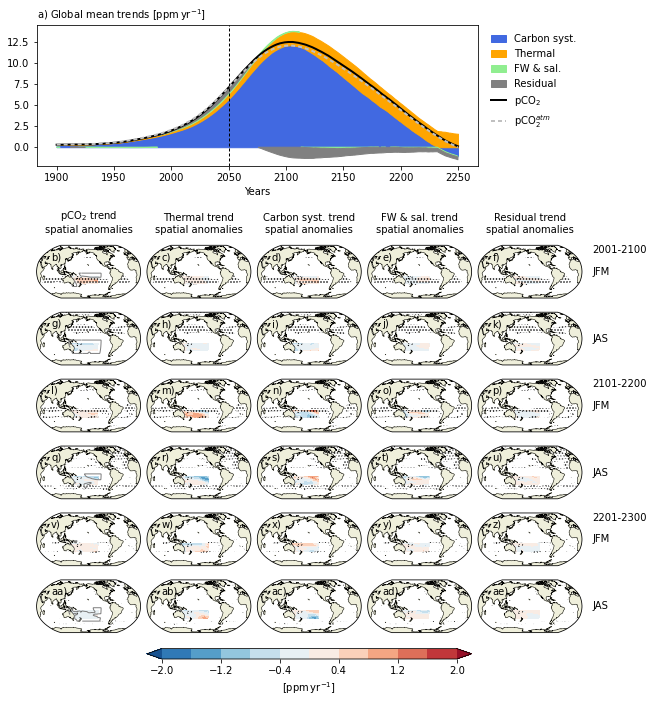

In [257]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for a small part of the ocean: fig all terms")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-smalloceanpart.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150', '2250']
season_list = ['JFM', 'JAS']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend', 'freshwater-trend', 'res']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -2, 2
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{atm}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod + 1
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason][vmap]['X']
            Y1 = data2plot['maps'][vperiod][vseason][vmap]['Y']
            Z1 = data2plot['maps'][vperiod][vseason][vmap]['Z']
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason]['ACOD']['X']
            Y1 = data2plot['maps'][vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot['maps'][vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot['maps'][vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            zax.add_feature(cfeature.COASTLINE, lw=.5)
            zax.add_feature(cfeature.LAND)
            #zax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
            #               color='k', linestyle='dashed', linewidth=0.5)
            zax.set_global()
            
        #
    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.4 * zw1.width
        nh  = 1.4 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.1*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.2*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw1 = axts.get_position()
zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.5*zw2.height
nx0 = zw2.x0
nw  = zw3.x0 - nx0
nh  = .3*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  1].get_position()
zw2 = ax[-1, -2].get_position()
nx0 = zw1.x0 
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-allterms-smalloceanpart.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1m 

### Fig 

2023-09-16 19:16:41.090485
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Test for a small part of the ocean: fig


/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Done, figure saved: fig-4-smalloceanpart.png
CPU times: user 8.74 s, sys: 594 ms, total: 9.34 s
Wall time: 8.67 s


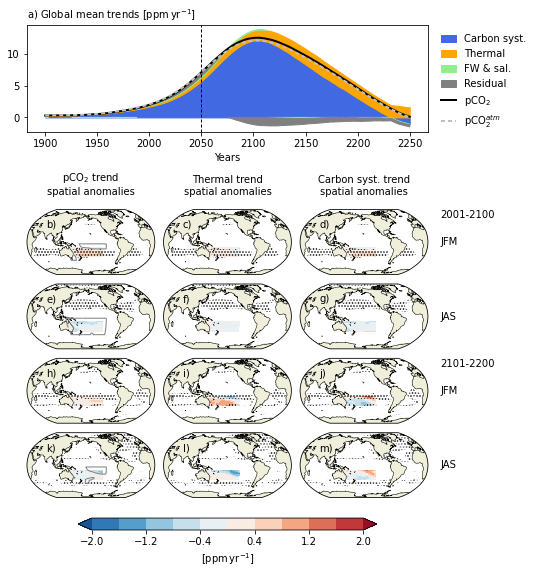

In [259]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Test for a small part of the ocean: fig")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-smalloceanpart.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150']
season_list = ['JFM', 'JAS']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -2, 2
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{atm}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod + 1
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason][vmap]['X']
            Y1 = data2plot['maps'][vperiod][vseason][vmap]['Y']
            Z1 = data2plot['maps'][vperiod][vseason][vmap]['Z']
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason]['ACOD']['X']
            Y1 = data2plot['maps'][vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot['maps'][vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot['maps'][vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            zax.add_feature(cfeature.COASTLINE, lw=.5)
            zax.add_feature(cfeature.LAND)
            #zax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
            #               color='k', linestyle='dashed', linewidth=0.5)
            zax.set_global()
            
        #
    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.2 * zw1.width
        nh  = 1.2 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.4*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.15*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.2*zw2.height
nx0 = zw2.x0
nw  = zw3.x1 - 0*zw3.width - nx0
nh  = .2*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .4*zw1.width
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - .4*zw2.width - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-smalloceanpart.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1m 

## Full

1. Compute the taylor expansion for the full ocean for the different season considered
2. Prepare a pickle with the data2plot

### Compute taylor expansion
1. Load pCO2, Khd, Kh, sdic, salk, sss, sst
2. Compute pCO2 * Khd / Kh and Salinity normalized DIC and ALK
3. Loop on season: 
    1. Select season
    4. Compute mean and trends
    5. Compute taylor expansion coefficient
    6. Compute taylor expansion terms
    7. Compute main terms: pco2 trend, carbon system trend, thermal trend and freshwater trend 

Save Data    
- main terms: *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'* 
- time running means: *dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'*
- trends: *dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc"*
- coefficients: *dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'*
- taylor terms: *dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'*
- Reference salinity: *dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'.nc'*

#### Starters

In [9]:
#----------------
# PARAMETERS
#----------------

simu = 'ssp585'
seas_list  = ['JAS', 'JFM']
nbyear = 50 # number of year to compute the mean and trends

#----------------
# Define fuction
#----------------

def savedatatonetcdf(zwdict, zwfile, zwcomment=''): 
    print('Save in netcdf...')
    tods = {}
    for kkk, vvv in zwdict.items(): 
        tods[vvv.name] = vvv
    #
    dstosave = xr.Dataset(tods)
    dstosave.attrs['simu'] = 'historical and '+simu
    dstosave.attrs['model'] = 'NorESM2-LM'
    try: dstosave.attrs['comment'] = zwcomment+' ; '+ dstosave.attrs['comment']
    except: dstosave.attrs['comment'] = zwcomment
    dstosave.to_netcdf(zwfile)
    print('Done, file saved: '+zwfile)
#


#### Step 1, 2, 3A and 3B

In [20]:
%%time
%%memit -c

print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: compute taylor expansion: step 1, 2, 3A and 3B")


#=======================================
# 1 - Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2
# 1bis - Select grid points
#=======================================

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'kh', 'khd', 'sdic-tot', 'salk-tot', 'stemp', 'ssali', 'atmco2']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#=======================================
# 2 - Compute pco2-atm and salinity normalized DIC and ALK
#=======================================

print('Compute pCO2-atm and salinity normalized DIC and ALK...')

# pco2-atm = atmco2 * Kh / Khd 
# because fgco2 = ( atco2  - xco2 ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# and xco2 = cu * 1.e6 / Kh (dry mole fraction of CO2)
# and pco2 = cu * 1.e6 / Khd (pco2 in seawater)
# thus fgco2 = ( atco2 - pco2 * Khd / Kh ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# thus fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho 
zw = ( zwdata['atmco2'] * zwdata['kh'] / zwdata['khd'] ).rename('pco2-atm')
zw.attrs = zwdata['atmco2'].attrs
addtxt = 'pco2-atm = atmco2 * Kh / Khd because fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho '
try: zw.attrs['history'] = addtxt+' ; '+zw.attrs['history']
except: zw.attrs['history'] = addtxt
zwdata['pco2-atm'] = zw

SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

#_________________
# Save SSS0
savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'.nc'
SSS0.to_netcdf(savefile)

# remove unnnecessary variables
for vvv in ['atmco2', 'kh', 'khd']: del zwdata[vvv]


#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)
    
    #----------------
    # A - Select season
    #----------------

    print('Select season...')
    zwdata2 = {}
    for kkk, vvv in zwdata.items(): 
        zwdata2[kkk] = select_season(vvv, seas, verbose=False)
    #
    print('Done')

    #----------------
    # B - Compute mean and trends
    #----------------

    zwavg = {}
    zwtrd = {}
    zfact_alk_dic = 1000./1.024 # from mol.m-3 to umol.kg-1
    var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali', 'pco2-atm']
    for var in var_list:

        # Average
        print('Compute mean of '+var+'...')
        zw = zwdata2[var].rolling(year=nbyear, center=True).mean() 
        if var in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']:
            with xr.set_options(keep_attrs=True): zw = zw*zfact_alk_dic # in umol.kg-1
            zw.attrs['units'] = 'umol kg-1'
        #
        try: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years ; '+ zw.attrs['history']
        except: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years'
        zwavg[var] = zw
        print('Done')

        # Trends
        print('Compute trend of '+var+'...')
        zw_shift = xr.apply_ufunc(np.roll, zwavg[var], nbyear, kwargs=dict(axis=0), dask='allowed', keep_attrs=True)
        zw = xr.apply_ufunc(np.roll, (zwavg[var] - zw_shift)/nbyear, -int(nbyear/2), kwargs=dict(axis=0), dask='allowed', keep_attrs=False)
        zw[0] = np.nan
        zw.attrs = zwavg[var].attrs
        zw = zw.rename(var+'-trd')
        try: zw.attrs['long_name'] = 'Trend of '+zwavg[var].attrs['long_name']
        except: zw.attrs['long_name'] = 'Trend of '+var 
        try: zw.attrs['units'] = zw.attrs['units'] + ' y-1'
        except: zw.attrs['units'] = 'y-1'
        addtxt = 'Trend computed as the difference between 2 consecutive time period of '+str(nbyear)+' years'
        try: zw.attrs['history'] = addtxt+' ; '+ zw.attrs['history']
        except: zw.attrs['history'] = addtxt
        zwtrd[var] = zw
        print('Done')
    #
    del zwdata2

    #________________
    # Save data to netcdf
    
    comment = 'This netcdf contains time running means used for the taylor expansion analysis'
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwavg, savefile, zwcomment=comment)

    comment = 'This netcdf contains the trends used for the taylor expansion analysis'
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwtrd, savefile, zwcomment=comment)
#
del zwtrd, zwavg, zw, zw_shift, zwdata
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 2m40s

2023-09-18 11:22:49.117477
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean: compute taylor expansion: step 1, 2, 3A and 3B
Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(kh, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(khd, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasa

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/si

Done
Compute mean of pco2-tot...
Done
Compute trend of pco2-tot...
Done
Compute mean of sdic-tot...
Done
Compute trend of sdic-tot...
Done
Compute mean of salk-tot...
Done
Compute trend of salk-tot...
Done
Compute mean of sdic-tot-sn...
Done
Compute trend of sdic-tot-sn...
Done
Compute mean of salk-tot-sn...
Done
Compute trend of salk-tot-sn...
Done
Compute mean of stemp...
Done
Compute trend of stemp...
Done
Compute mean of ssali...
Done
Compute trend of ssali...
Done
Compute mean of pco2-atm...
Done
Compute trend of pco2-atm...
Done
Save in netcdf...
[########################################] | 100% Completed | 35.57 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_time_running_means_noresm2-lm_ssp585_JAS.nc
Save in netcdf...
[########################################] | 100% Completed | 33.35 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_trends_noresm2-lm_ssp585_JAS.nc
> Season: JFM
Select season...


/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/si

Done
Compute mean of pco2-tot...
Done
Compute trend of pco2-tot...
Done
Compute mean of sdic-tot...
Done
Compute trend of sdic-tot...
Done
Compute mean of salk-tot...
Done
Compute trend of salk-tot...
Done
Compute mean of sdic-tot-sn...
Done
Compute trend of sdic-tot-sn...
Done
Compute mean of salk-tot-sn...
Done
Compute trend of salk-tot-sn...
Done
Compute mean of stemp...
Done
Compute trend of stemp...
Done
Compute mean of ssali...
Done
Compute trend of ssali...
Done
Compute mean of pco2-atm...
Done
Compute trend of pco2-atm...
Done
Save in netcdf...
[########################################] | 100% Completed | 30.24 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_time_running_means_noresm2-lm_ssp585_JFM.nc
Save in netcdf...
[########################################] | 100% Completed | 34.08 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_trends_noresm2-lm_ssp585_JFM.nc
End loop on season
CPU times: user 4min 5s, sys: 1min 32s, total: 5mi

#### Step 3C

In [12]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: compute taylor expansion: step 3C")

#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)

    #________________
    # Reload zwavg from netcdf
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwavg = xr.open_dataset(savefile, **kwopends, chunks='auto')
    savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'.nc'
    SSS0 = xr.open_dataset(savefile, **kwopends, chunks='auto')['ssali']


    #----------------
    # C - Compute taylor expansion coefficient
    #----------------

    print('Compute taylor expansion coefficient...')
    cut=30
    zwgam_np = {}
    var_list = ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'sdic-tot-fw', 'salk-tot-fw']
    for var in var_list: 
        zwgam_np[var] = []
    for yyy in zwavg['salk-tot'].year.values[::cut]: 
        sss = slice(yyy, yyy+cut-1)
        print('    Run PyCO2SYS on years %d-%d...'%(sss.start, sss.stop))
        zwalk    = zwavg['salk-tot'   ].sel(year=sss)
        zwdic    = zwavg['sdic-tot'   ].sel(year=sss)
        zwalk_sn = zwavg['salk-tot-sn'].sel(year=sss)
        zwdic_sn = zwavg['sdic-tot-sn'].sel(year=sss)
        zwsss    = zwavg['ssali'      ].sel(year=sss)
        zwsst    = zwavg['stemp'      ].sel(year=sss)
        kwargs = dict(par1=zwalk, par2=zwdic, par1_type=1, par2_type=2, 
                      salinity=zwsss, temperature=zwsst, opt_pH_scale=1, 
                      opt_k_carbonic=4, opt_k_bisulfate=1)
        zwco2sysres = xr.apply_ufunc(PyCO2SYS.sys, kwargs=kwargs, dask='allowed')
        # coef-dic
        var = 'sdic-tot'
        zwgam_np[var] .extend( 1 / (zwco2sysres['gamma_dic'] * 1e6) )
        # coef-alk
        var = 'salk-tot'
        zwgam_np[var] .extend( 1 / (zwco2sysres['gamma_alk'] * 1e6) )
        # coef-dic-sn
        var = 'sdic-tot-sn'
        zwgam_np[var] .extend( zwsss/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) )
        # coef-alk-sn
        var = 'salk-tot-sn'
        zwgam_np[var] .extend( zwsss/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) )
        # coef-dic-fw
        var = 'sdic-tot-fw'
        zwgam_np[var] .extend( zwdic_sn/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) )
        # coef-alk-fw
        var = 'salk-tot-fw'
        zwgam_np[var] .extend( zwalk_sn/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) )
        print('    Done')
    #
    del zwalk, zwdic, zwalk_sn, zwdic_sn, zwsss, zwsst    
    for var in var_list: zwgam_np[var] = np.array(zwgam_np[var])
    
    print('    Set coefficient as dataarray...')
    
    zwgam = {}
    # coef-dic
    var = 'sdic-tot'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name=var+' coefficient for taylor expansion', units='l umol-1',
                   history=addtxt)
    zwgam[var] = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-alk
    var = 'salk-tot'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    =  NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-dic-sn
    var = 'sdic-tot-sn'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name='DIC-sn coefficient for taylor expansion', units='l umol-1', 
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-alk-sn
    var = 'salk-tot-sn'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK-sn coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-dic-fw
    var = 'sdic-tot-fw'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name='DIC-fw coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-alk-fw
    var = 'salk-tot-fw'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK-fw coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-sst
    var = 'stemp'
    zwda = xr.where(zwavg['stemp'].isnull(), np.nan, 0.0423 * xr.ones_like(zwavg['stemp']))
    zwda = zwda.rename('coef-'+var)
    zwda.attrs = zwavg['stemp'].attrs
    zwda.attrs['long_name'] = 'SST coefficient for taylor expansion'
    zwda.attrs['units'] = 'degC-1'
    addtxt = "Taylor expansion coefficient 0.0423"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwgam[var]       = zwda

    # coef-sss
    var = 'ssali'
    zwda = 1 / zwavg['ssali']
    zwda = zwda.rename('coef-'+var)
    zwda.attrs = zwavg['ssali'].attrs
    zwda.attrs['long_name'] = 'SSS coefficient for taylor expansion'
    zwda.attrs['units'] = 'kg g-1'
    addtxt = "Taylor expansion coefficient 1 / zwavg['ssali']"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwgam[var]       = zwda

    print('    Done')
    
    print('Done')
    
    #________________
    # Save data to netcdf
    
    comment = 'This netcdf contains the coefficient used for the taylor expansion analysis. \
    The coefficient are multiply by the average pCO2 and the trend to get the different terms of the taylor expansion'
    savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwgam, savefile, zwcomment=comment)


#
del zwavg, zwgam, zwda
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 20m

2023-09-19 14:20:18.235931
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean: compute taylor expansion: step 3C
Start loop on season
> Season: JAS
Compute taylor expansion coefficient...
    Run PyCO2SYS on years 1850-1879...
    Done
    Run PyCO2SYS on years 1880-1909...
    Done
    Run PyCO2SYS on years 1910-1939...
    Done
    Run PyCO2SYS on years 1940-1969...
    Done
    Run PyCO2SYS on years 1970-1999...
    Done
    Run PyCO2SYS on years 2000-2029...
    Done
    Run PyCO2SYS on years 2030-2059...
    Done
    Run PyCO2SYS on years 2060-2089...
    Done
    Run PyCO2SYS on years 2090-2119...
    Done
    Run PyCO2SYS on years 2120-2149...
    Done
    Run PyCO2SYS on years 2150-2179...
    Done
    Run PyCO2SYS on years 2180-2209...
    Done
    Run PyCO2SYS on years 2210-2239...
    Done
    Run PyCO2SYS on years 2240-2269...
    Done
    Run PyCO2SYS on years 2270-2299...
    Done
    Set coefficient as dataarray...
func: 

#### Step 3D

In [13]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: compute taylor expansion: step 3D")

#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)

    #________________
    # Reload zwavg, zwtrd, zwgam from netcdf
    
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwavg = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwtrd = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
    savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwgam = xr.open_dataset(savefile, chunks = 'auto', **kwopends)

    
    #----------------
    # D - Compute taylor expansion terms
    #----------------

    print('Compute taylor expansion terms...')
    zwtaylor = {}
    var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
    for var in var_list: 

        zwda = zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd[var+'-trd']
        zwda.attrs = zwgam['coef-'+var].attrs
        zwda = zwda.rename('taylor-term-'+var)
        zwda.attrs['long_name'] = var+' term for taylor expansion'
        zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units']+' y-1'
        addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd[var+'-trd']"
        try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
        except: zwda.attrs['history'] = addtxt
        zwtaylor[var] = zwda

    #
    for var in ['sdic-tot-fw', 'salk-tot-fw']:
        zwda = zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd['ssali-trd']
        zwda.attrs = zwgam['coef-'+var].attrs
        zwda = zwda.rename('taylor-term-'+var)
        zwda.attrs['long_name'] = var+' term for taylor expansion'
        zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units'] +' y-1'
        addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd['ssali-trd']"
        try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
        except: zwda.attrs['history'] = addtxt
        zwtaylor[var] = zwda
    #
    print('Done')
    
    #________________
    # Save data to netcdf
    
    comment = 'This netcdf contains the different terms used for the taylor expansion analysis.'
    savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwtaylor, savefile, zwcomment=comment)


#
del zwavg, zwtrd, zwgam, zwtaylor, zwda
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 30s

2023-09-19 16:13:55.822229
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean: compute taylor expansion: step 3D
Start loop on season
> Season: JAS
Compute taylor expansion terms...
Done
Save in netcdf...
[########################################] | 100% Completed | 9.97 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_terms_noresm2-lm_ssp585_JAS.nc
> Season: JFM
Compute taylor expansion terms...
Done
Save in netcdf...
[########################################] | 100% Completed | 9.17 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_terms_noresm2-lm_ssp585_JFM.nc
End loop on season
peak memory: 29372.11 MiB, increment: 15075.50 MiB
CPU times: user 3.4 s, sys: 9.5 s, total: 12.9 s
Wall time: 30.3 s


#### Step 3E

In [14]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: compute taylor expansion: step 3E")

#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)

    #________________
    # Reload zwtrd, zwtaylor from netcdf
    
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwtrd = xr.open_dataset(savefile, **kwopends)
    savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwtaylor = xr.open_dataset(savefile, **kwopends)

    
    #----------------
    # E - Compute main terms
    #----------------

    zwmain = {}
    with xr.set_options(keep_attrs=True): 

        zwmain['dpCO2'] = zwtrd['pco2-tot-trd']
        zwmain['dpCO2'] = zwmain['dpCO2'].rename('pco2-trend')

        zwmain['dpCO2-atm'] = zwtrd['pco2-atm-trd']
        zwmain['dpCO2-atm'] = zwmain['dpCO2-atm'].rename('pco2-atm-trend')

        zwmain['thermal'] = zwtaylor['taylor-term-stemp']
        zwmain['thermal'] = zwmain['thermal'].rename('thermal-trend')
        zwmain['thermal'].attrs['long_name'] = 'Thermal trend term for taylor expansion'
        zwmain['thermal'].attrs['comment'] = 'The thermal trend account for the effect of trend in \
        temperature on oceanic pCO2'

        zwmain['carbon']  = zwtaylor['taylor-term-sdic-tot-sn'] + zwtaylor['taylor-term-salk-tot-sn']
        zwmain['carbon'] = zwmain['carbon'].rename('carbon-system-trend')
        zwmain['carbon'].attrs['long_name'] = 'Carbon system trend term for taylor expansion'
        zwmain['carbon'].attrs['comment'] = 'The carbon system trend account for the effect on oceanic pCO2 of the trend \
        in DIC and ALK both salinity normalized. Changes in salinity normalized DIC and ALK exclude changes in DIC and ALK \
        associated with freshwater inputs (eg. evaporation or precipitation).'
        addhistory = "Carbon system trend = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']"
        zwmain['carbon'].attrs['history'] = addhistory+ \
        "\n > history of zwtaylor['sdic-tot-sn']: " + zwtaylor['taylor-term-sdic-tot-sn'].attrs['history'] + \
        "\n > history of zwtaylor['salk-tot-sn']: " + zwtaylor['taylor-term-salk-tot-sn'].attrs['history']

        zwmain['fw']      = zwtaylor['taylor-term-sdic-tot-fw'] + zwtaylor['taylor-term-salk-tot-fw'] + zwtaylor['taylor-term-ssali']
        zwmain['fw'] = zwmain['fw'].rename('freshwater-trend')
        zwmain['fw'].attrs['long_name'] = 'Freshwater trend term for taylor expansion'
        zwmain['fw'].attrs['comment'] = 'The freshwater trend account for the effect on oceanic pCO2 of trends in \
        freshwater inputs affecting DIC, ALK and salinity. '
        addhistory = "Freshwater trend = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']"
        zwmain['fw'].attrs['history'] = addhistory+ \
        "\n > history of zwtaylor['sdic-tot-fw']: " + zwtaylor['taylor-term-sdic-tot-fw'].attrs['history'] + \
        "\n > history of zwtaylor['salk-tot-fw']: " + zwtaylor['taylor-term-salk-tot-fw'].attrs['history'] + \
        "\n > history of zwtaylor['ssali']: " + zwtaylor['taylor-term-ssali'].attrs['history'] 
    #

    #________________
    # Save data to netcdf

    comment = 'This netcdf contains the terms of the following taylor expansion: \n \
    pco2-trend ~ thermal-trend + carbon-system-trend + freshwater-trend'
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwmain, savefile, zwcomment=comment)

#
del zwmain, zwtaylor, zwtrd
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 3s

2023-09-19 16:14:41.933984
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean: compute taylor expansion: step 3E
Start loop on season
> Season: JAS
Save in netcdf...
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_noresm2-lm_ssp585_JAS.nc
> Season: JFM
Save in netcdf...
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_noresm2-lm_ssp585_JFM.nc
End loop on season
CPU times: user 429 ms, sys: 1.74 s, total: 2.17 s
Wall time: 3.07 s


### Prepare data2plot
1. Reload netcdf of the main terms (pco2 trend, carbon system trend, thermal trend and freshwater trend) for each season:  *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'*
2. Compute a global time serie of the taylor expansion: 
    1. Compute the spatial mean for both season for all the terms of the expansion loaded in 1)
    2. Compute the mean between the timeseries of the 2 seasons (or maybe the 4?)
3. Save in data2plot: 
    1. **The global timeseries** for trends in pco2, carbon system, thermal, fresh water, sum of the last 3 and atmospheric pco2.
        - data2plot["time series"]["???"] = {'X': numpy array with the years, 'Y': numpy array with values of ???}
   2. **The maps for different time periods** ['2050' i.e. 21st century, '2150' i.e. 22nd century and '2250' i.e. 23rd century] **and seasons** ['JFM' and 'JAS'] for : 
       - **spatial anomalies of trends** in pco2, carbon system, thermal, fresh water. Spatial anomalies are local trend minus global mean trend from the timeseries above
       - For each time period and season, the grid points where **Cant outgassing emerge**.
      - For each time period and season, the **trend in ∆pCO2** (aCO2 - pCO2)
      - data2plot["maps"]["time period"]["season"]["???"] = {'X': numpy array with longitude, 'Y': numpy array with latitude, 'Z': numpy array with values of ???}.

In [15]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: prepare data2plot")

#---------------------
# Param
#---------------------
simu = 'ssp585'
period_list = ['2050', '2150', '2250']
seas_list = ['JFM', 'JAS']
nbyear = 50 # number of year to compute the mean and trends

#---------------------
# 1 - Load data
#---------------------

main = {}
for seas in seas_list: 
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'
    main[seas] = xr.open_dataset(savefile, **kwopends)
#


savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)

#____________________
# Regrid ACOD for easier plotting

print('Regrid ACOD for easier plotting...')
datayACOD = data2plot_fig3[simu]['yACOD']
zwX = datayACOD['X']
zwY = datayACOD['Y']
zwZ = datayACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
weights_filename = dirout+'regridding_weights.nc'
# regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
# regridder.to_netcdf(weights_filename)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zyacod = regridder(zwZ)
Xyacod, Yyacod = ds_out['lon'].values, ds_out['lat'].values

datasACOD = data2plot_fig3[simu]['sACOD']
zwX = datasACOD['X']
zwY = datasACOD['Y']
zwZ = datasACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zsacod = regridder(zwZ)
Xsacod, Ysacod = ds_out['lon'].values, ds_out['lat'].values
print('Done')


#---------------------
# 2 - Compute global time serie of the taylor expansion
#---------------------

#_____________________
# Compute spatial means
print('Compute spatial means...')
spatial_mean = {}
for seas in seas_list: 
    spatial_mean[seas] = main[seas].weighted(grid['parea']).mean(dim=('x', 'y'), keep_attrs=True)
#
print('Done')

#_____________________
# Compute the mean between the 2 seasons for the spatial mean
print('Compute mean between the 2 season for the spatial means...')
with xr.set_options(keep_attrs=True): 
    mean2seas = 0.5 * (spatial_mean['JFM'] + spatial_mean['JAS'])
#
print('Done')

#---------------------
# 3 - Save in data2plot
#---------------------

print('Save in data2plot')
data2plot = {}

#_____________________
# Timeseries

data2plot['timeseries'] = {}
var_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
for var in var_list: 
    data2plot['timeseries'][var] = {'X': mean2seas[var].year.values, 'Y': mean2seas[var].values}
#
# Residual
with xr.set_options(keep_attrs=True): 
    zw = mean2seas['pco2-trend'] - (mean2seas['carbon-system-trend'] + \
                                    mean2seas['thermal-trend'] + \
                                    mean2seas['freshwater-trend'])
#
data2plot['timeseries']['res'] = {'X': zw.year.values, 'Y': zw.values}

#_____________________
# Maps

data2plot['maps'] = {}
for period in period_list:
    data2plot['maps'][period] = {}
    for seas in seas_list: 
        data2plot['maps'][period][seas] = {}
        zwds = main[seas].sel(year=int(period))
        zwmean2seas = mean2seas.sel(year=int(period))
        # terms of taylor expansion
        var_list = ['pco2-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
        for var in var_list: 
            data2plot['maps'][period][seas][var] = {
                'X': zwds['plon'].values,
                'Y': zwds['plat'].values,
                'Z': zwds[var].values - zwmean2seas[var].values
            }
        #
        # Residual
        with xr.set_options(keep_attrs=True): 
            zw1 = zwds['pco2-trend'] - (zwds['carbon-system-trend'] + \
                                        zwds['thermal-trend'] + \
                                        zwds['freshwater-trend'])
            zw2 = zwmean2seas['pco2-trend'] - (zwmean2seas['carbon-system-trend'] + \
                                               zwmean2seas['thermal-trend'] + \
                                               zwmean2seas['freshwater-trend'])
        #
        data2plot['maps'][period][seas]['res'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zw1.values - zw2.values
        }
        # pco2-atm-trend minus pco2-trend
        data2plot['maps'][period][seas]['d∆pCO2'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zwds['pco2-atm-trend'].values - zwds['pco2-trend'].values
        }
        # ACOD
        minyear, maxyear = int(period)-nbyear, int(period)+nbyear
        if   seas=='JFM': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==1), 1, 0)
        elif seas=='AMJ': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==2), 1, 0)
        elif seas=='JAS': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==3), 1, 0)
        elif seas=='OND': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==4), 1, 0)
        else: exit('Wrong value for season')
        data2plot['maps'][period][seas]['ACOD'] = {
            'X': Xyacod,
            'Y': Yyacod,
            'Z': zw
        }
    #
#
print('Done')

print('Save file...')
savedfile = dirout+'data2plot-fig4.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)        


# ca. 4s

2023-09-19 16:14:59.574972
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
TFull ocean: prepare data2plot
Regrid ACOD for easier plotting...
Done
Compute spatial means...
Done
Compute mean between the 2 season for the spatial means...
Done
Save in data2plot
Done
Save file...
Done, file saved: cc2300-230215-noresm2-lm/data2plot-fig4.pckl
CPU times: user 2.53 s, sys: 1.43 s, total: 3.96 s
Wall time: 4.25 s


### Fig all terms

2023-09-22 16:00:05.076449
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean: fig all terms
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land

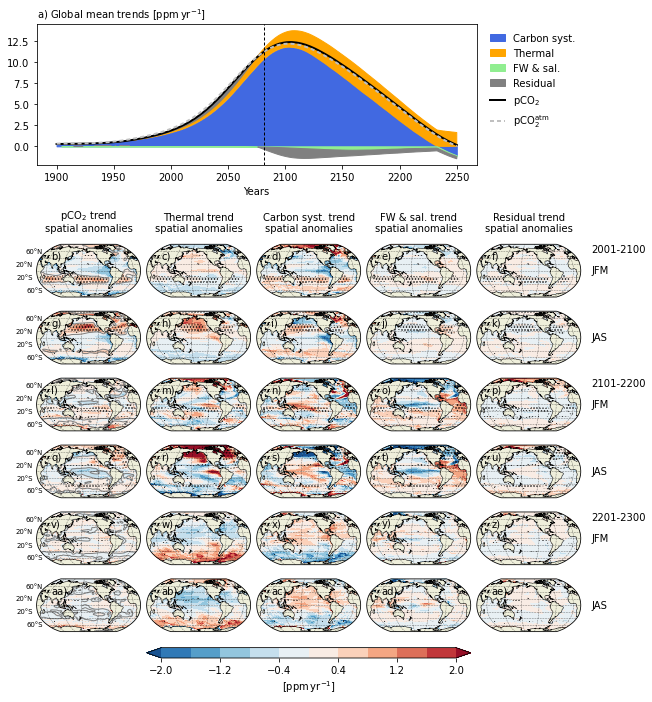

In [227]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: fig all terms")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150', '2250']
season_list = ['JFM', 'JAS']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend', 'freshwater-trend', 'res']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -2, 2
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{\mathrm{atm}}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod + 1
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason][vmap]['X']
            Y1 = data2plot['maps'][vperiod][vseason][vmap]['Y']
            Z1 = data2plot['maps'][vperiod][vseason][vmap]['Z']
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # ACOD
            X1 = data2plot['maps'][vperiod][vseason]['ACOD']['X']
            Y1 = data2plot['maps'][vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot['maps'][vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot['maps'][vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not imap==0: gl.left_labels=False

            
        #
    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.4 * zw1.width
        nh  = 1.4 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.1*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.2*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw1 = axts.get_position()
zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.5*zw2.height
nx0 = zw2.x0
nw  = zw3.x0 - nx0
nh  = .3*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  1].get_position()
zw2 = ax[-1, -2].get_position()
nx0 = zw1.x0 
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-allterms.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 2m 

### Fig 

2023-09-22 16:02:28.838818
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean: fig
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-4.png
CPU times: user 55.9 s, sys: 6.29 s, total: 1min 2s
Wall time: 55.5 s


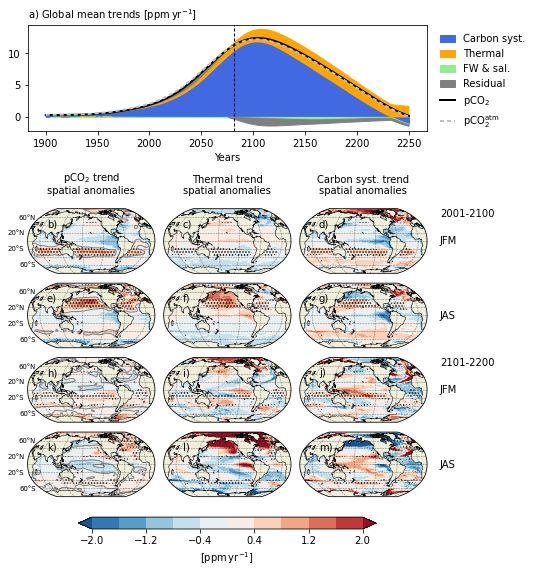

In [228]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean: fig")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150']
season_list = ['JFM', 'JAS']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -2, 2
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{\mathrm{atm}}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod + 1
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason][vmap]['X']
            Y1 = data2plot['maps'][vperiod][vseason][vmap]['Y']
            Z1 = data2plot['maps'][vperiod][vseason][vmap]['Z']
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason]['ACOD']['X']
            Y1 = data2plot['maps'][vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot['maps'][vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot['maps'][vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not imap==0: gl.left_labels=False
            
        #
    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.2 * zw1.width
        nh  = 1.2 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.4*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.15*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.2*zw2.height
nx0 = zw2.x0
nw  = zw3.x1 - 0*zw3.width - nx0
nh  = .2*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .4*zw1.width
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - .4*zw2.width - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1m 

## Full but no spatial anomalies, absolute values instead

### Prepare data2plot
1. Reload netcdf of the main terms (pco2 trend, carbon system trend, thermal trend and freshwater trend) for each season:  *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'*
2. Compute a global time serie of the taylor expansion: 
    1. Compute the spatial mean for both season for all the terms of the expansion loaded in 1)
    2. Compute the mean between the timeseries of the 2 seasons (or maybe the 4?)
3. Save in data2plot: 
    1. **The global timeseries** for trends in pco2, carbon system, thermal, fresh water, sum of the last 3 and atmospheric pco2.
        - data2plot["time series"]["???"] = {'X': numpy array with the years, 'Y': numpy array with values of ???}
   2. **The maps for different time periods** ['2050' i.e. 21st century, '2150' i.e. 22nd century and '2250' i.e. 23rd century] **and seasons** ['JFM' and 'JAS'] for : 
       - **spatial anomalies of trends** in pco2, carbon system, thermal, fresh water. Spatial anomalies are local trend minus global mean trend from the timeseries above
       - For each time period and season, the grid points where **Cant outgassing emerge**.
      - For each time period and season, the **trend in ∆pCO2** (aCO2 - pCO2)
      - data2plot["maps"]["time period"]["season"]["???"] = {'X': numpy array with longitude, 'Y': numpy array with latitude, 'Z': numpy array with values of ???}.

In [123]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean but no spatial anomalies, absolute values instead")
print("prepare data2plot")

#---------------------
# Param
#---------------------
simu = 'ssp585'
period_list = ['2050', '2150', '2250']
seas_list = ['JFM', 'JAS']
nbyear = 50 # number of year to compute the mean and trends

#---------------------
# 1 - Load data
#---------------------

main = {}
for seas in seas_list: 
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'
    main[seas] = xr.open_dataset(savefile, **kwopends)
#


savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)

#____________________
# Regrid ACOD for easier plotting

print('    Regrid ACOD for easier plotting...')
datayACOD = data2plot_fig3[simu]['yACOD']
zwX = datayACOD['X']
zwY = datayACOD['Y']
zwZ = datayACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
weights_filename = dirout+'regridding_weights.nc'
# regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
# regridder.to_netcdf(weights_filename)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zyacod = regridder(zwZ)
Xyacod, Yyacod = ds_out['lon'].values, ds_out['lat'].values

datasACOD = data2plot_fig3[simu]['sACOD']
zwX = datasACOD['X']
zwY = datasACOD['Y']
zwZ = datasACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zsacod = regridder(zwZ)
Xsacod, Ysacod = ds_out['lon'].values, ds_out['lat'].values
print('    Done')


#---------------------
# 2 - Save in data2plot
#---------------------

print('    Save in data2plot')

data2plot = {}
for period in period_list:
    data2plot[period] = {}
    for seas in seas_list: 
        data2plot[period][seas] = {}
        zwds = main[seas].sel(year=int(period))
        # terms of taylor expansion
        var_list = ['pco2-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
        for var in var_list: 
            data2plot[period][seas][var] = {
                'X': zwds['plon'].values,
                'Y': zwds['plat'].values,
                'Z': zwds[var].values
            }
        #
        # Residual
        with xr.set_options(keep_attrs=True): 
            zw1 = zwds['pco2-trend'] - (zwds['carbon-system-trend'] + \
                                        zwds['thermal-trend'] + \
                                        zwds['freshwater-trend'])
        #
        data2plot[period][seas]['res'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zw1.values
        }
        # pco2-atm-trend minus pco2-trend
        data2plot[period][seas]['d∆pCO2'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zwds['pco2-atm-trend'].values - zwds['pco2-trend'].values
        }
        # ACOD
        minyear, maxyear = int(period)-nbyear, int(period)+nbyear
        if   seas=='JFM': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==1), 1, 0)
        elif seas=='AMJ': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==2), 1, 0)
        elif seas=='JAS': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==3), 1, 0)
        elif seas=='OND': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==4), 1, 0)
        else: exit('Wrong value for season')
        data2plot[period][seas]['ACOD'] = {
            'X': Xyacod,
            'Y': Yyacod,
            'Z': zw
        }
    #
#
print('    Done')

print('    Save file...')
savedfile = dirout+'data2plot-fig4-absolute-values.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("    Done, file saved: "+savedfile)        


# ca. 4s

2023-11-30 16:16:54.560416
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean but no spatial anomalies, absolute values instead
prepare data2plot
    Regrid ACOD for easier plotting...
    Done
    Save in data2plot
    Done
    Save file...
    Done, file saved: cc2300-230215-noresm2-lm/data2plot-fig4-absolute-values.pckl
CPU times: user 86.2 ms, sys: 37 ms, total: 123 ms
Wall time: 1.1 s


### Fig all terms

2023-11-30 17:52:53.672761
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean but no spatial anomalies, absolute values instead
Fig all terms
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastlin

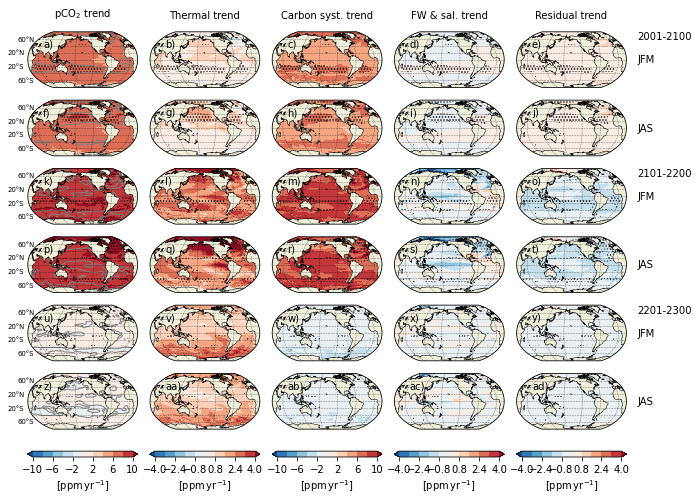

In [128]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean but no spatial anomalies, absolute values instead")
print("Fig all terms")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-absolute-values.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150', '2250']
season_list = ['JFM', 'JAS']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend', 'freshwater-trend', 'res']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -6, 6
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
vminmax = {
    'pco2-trend': (-10, 10),
    'thermal-trend': (-4, 4),
    'carbon-system-trend': (-10, 10),
    'freshwater-trend': (-4, 4),
    'res': (-4, 4) 
}
#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod 
            iplot = irow*ncol+imap + 1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot[vperiod][vseason][vmap]['X']
            Y1 = data2plot[vperiod][vseason][vmap]['Y']
            Z1 = data2plot[vperiod][vseason][vmap]['Z']
            kwmap['vmin'], kwmap['vmax'] = vminmax[vmap]
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # ACOD
            X1 = data2plot[vperiod][vseason]['ACOD']['X']
            Y1 = data2plot[vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot[vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot[vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot[vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot[vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not imap==0: gl.left_labels=False

            
        #
    #
#
 
fig.tight_layout()

ax = np.reshape(fig.axes[:], (nrow, ncol))
pcm = np.reshape(pcm, (nrow, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.4 * zw1.width
        nh  = 1.4 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.2*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.3*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#


#=========================================
# COLORBARS
#=========================================

# zw1 = ax[-1,  1].get_position()
# zw2 = ax[-1, -2].get_position()
# nx0 = zw1.x0 
# ny0 = zw1.y0 - .5*zw1.height
# nw  = zw2.x1 - nx0
# nh  = 0.03*nw
# cax = fig.add_axes([nx0, ny0, nw, nh])
# cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
#                     extend='both')
# cbar.set_label('[ppm$\,$yr$^{-1}$]')
# cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

for imap, vmap in enumerate(maps_list): 
    zw1 = ax[-1,  imap].get_position()
    nx0 = zw1.x0 
    if imap == 0: 
        ny0 = zw1.y0 - .5*zw1.height
        nw  = zw1.width
        nh  = 0.05*nw
    #
    cax = fig.add_axes([nx0, ny0, nw, nh])
    zwpcm = pcm[-1, imap]
    cbar = fig.colorbar(zwpcm, cax=cax, orientation='horizontal', ticklocation='bottom', 
                        extend='both')
    cbar.set_label('[ppm$\,$yr$^{-1}$]')
    cbar.set_ticks(np.linspace(vminmax[vmap][0], vminmax[vmap][1], int((zwpcm.cmap.colors.shape[0]/2+1))))
#


    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-allterms-absolute-values.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 2m 

### Fig 

2023-11-30 17:51:53.017365
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean but no spatial anomalies, absolute values instead
Fig
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-4-absolute-values.png
CPU times: user 56.6 s, sys: 5.68 s, total: 1min 2s
Wall time: 55.9 s


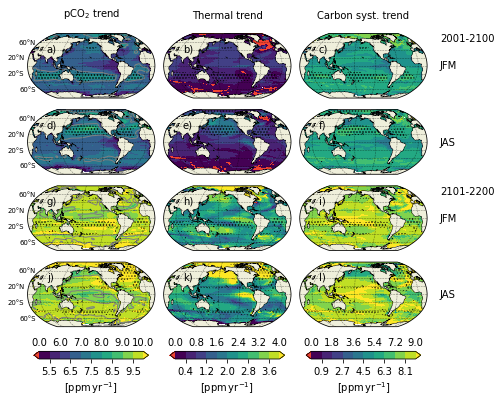

In [127]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean but no spatial anomalies, absolute values instead")
print("Fig")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-absolute-values.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150']
season_list = ['JFM', 'JAS']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

# a = cm.get_cmap('viridis',64)
# colors = a(np.linspace(0,1,10+1))
# newcmap = ListedColormap(colors[:-1])
# newcmap.set_under('tab:orange')
# newcmap.set_over(colors[-1])
# vmin, vmax = -2, 2
# kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {
#     'pco2-trend': (5, 10),
#     'thermal-trend': (0, 4),
#     'carbon-system-trend': (0, 9),
#     'freshwater-trend': (0, 4),
#     'res': (0, 4) 
# }

a = cm.get_cmap('viridis',64)
ccc1 = a(np.linspace(0,1,11))
a = cm.get_cmap('Reds_r',64)
ccc2 = a([0.4])
colors = np.concatenate([ccc2, ccc1])
kwmap   = dict(transform=ccrs.PlateCarree())
lev_dict = {
    'pco2-trend': np.concatenate([[0], np.linspace(5.5, 10, 10)]),
    'thermal-trend': np.linspace(0, 4, 11),
    'carbon-system-trend': np.linspace(0, 9, 11),
    'freshwater-trend': np.linspace(0, 4, 11),
    'res': np.linspace(0, 4, 11) 
}



#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])


#=========================================
# PLOT
#=========================================


pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod 
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot[vperiod][vseason][vmap]['X']
            Y1 = data2plot[vperiod][vseason][vmap]['Y']
            Z1 = data2plot[vperiod][vseason][vmap]['Z']
            # kwmap['vmin'], kwmap['vmax'] = vminmax[vmap]
            # zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            # pcm.append(zwpcm)
            
            cmap, norm = mpl.colors.from_levels_and_colors(lev_dict[vmap], colors, extend="both")
            kwmap['cmap'], kwmap['norm'] = cmap, norm
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            # cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend="neither")
            # m.pcolormesh(ax=ax, lons, lats, mean_age', cmap=cmap, norm=norm, latlon="True", zorder=1);

               
            #_____________________
            # ACOD
            X1 = data2plot[vperiod][vseason]['ACOD']['X']
            Y1 = data2plot[vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot[vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot[vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot[vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot[vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not imap==0: gl.left_labels=False
            
        #
    #
#
 
fig.tight_layout()

ax = np.reshape(fig.axes[:], (nrow, ncol))
pcm = np.reshape(pcm, (nrow, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.2 * zw1.width
        nh  = 1.2 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.6*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.15*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#=========================================
# COLORBARS
#=========================================

# zw1 = ax[-1,  0].get_position()
# zw2 = ax[-1, -1].get_position()
# nx0 = zw1.x0 + .4*zw1.width
# ny0 = zw1.y0 - .5*zw1.height
# nw  = zw2.x1 - .4*zw2.width - nx0
# nh  = 0.03*nw
# cax = fig.add_axes([nx0, ny0, nw, nh])
# cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
#                     extend='both')
# cbar.set_label('[ppm$\,$yr$^{-1}$]')
# cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

for imap, vmap in enumerate(maps_list): 
    zw1 = ax[-1,  imap].get_position()
    nx0 = zw1.x0 + .05*zw1.width
    if imap == 0: 
        ny0 = zw1.y0 - .5*zw1.height
        nw  = .9*zw1.width
        nh  = 0.05*nw
    #
    cax = fig.add_axes([nx0, ny0, nw, nh])
    zwpcm = pcm[-1, imap]

    ltop=lev_dict[vmap][::2]           # labels appear on top
    lbot=lev_dict[vmap][1:][::2]       # labels appear at bottom
    cbar = fig.colorbar(zwpcm, cax=cax, ticks=lbot, orientation='horizontal', ticklocation='bottom', 
                        extend='both')
    cbar.set_label('[ppm$\,$yr$^{-1}$]')
    # cbar.set_ticks(np.linspace(vminmax[vmap][0], vminmax[vmap][1], int((zwpcm.cmap.colors.shape[0]/2+1))))
    # Print bottom tick labels
    #Print top tick labels
    nticks=len(ltop)
    for ii, vv in enumerate(ltop):
        cax.text(ii/(nticks-1),
            1.5, str(np.round(vv, 1)), transform=cax.transAxes,
            va='bottom', ha='center')
    #   
#


    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-absolute-values.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1m 

## Full SSP126

1. Compute the taylor expansion for the full ocean for the different season considered
2. Prepare a pickle with the data2plot

### Compute taylor expansion
1. Load pCO2, Khd, Kh, sdic, salk, sss, sst
2. Compute pCO2 * Khd / Kh and Salinity normalized DIC and ALK
3. Loop on season: 
    1. Select season
    4. Compute mean and trends
    5. Compute taylor expansion coefficient
    6. Compute taylor expansion terms
    7. Compute main terms: pco2 trend, carbon system trend, thermal trend and freshwater trend 

Save Data    
- main terms: *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'* 
- time running means: *dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'*
- trends: *dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc"*
- coefficients: *dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'*
- taylor terms: *dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'*
- Reference salinity: *dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'.nc'*

#### Starters

In [229]:
#----------------
# PARAMETERS
#----------------

simu = 'ssp126'
seas_list  = ['JAS', 'JFM']
nbyear = 20 # number of year to compute the mean and trends

#----------------
# Define fuction
#----------------

def savedatatonetcdf(zwdict, zwfile, zwcomment=''): 
    print('Save in netcdf...')
    tods = {}
    for kkk, vvv in zwdict.items(): 
        tods[vvv.name] = vvv
    #
    dstosave = xr.Dataset(tods)
    dstosave.attrs['simu'] = 'historical and '+simu
    dstosave.attrs['model'] = 'NorESM2-LM'
    try: dstosave.attrs['comment'] = zwcomment+' ; '+ dstosave.attrs['comment']
    except: dstosave.attrs['comment'] = zwcomment
    dstosave.to_netcdf(zwfile)
    print('Done, file saved: '+zwfile)
#


#### Step 1, 2, 3A and 3B

In [31]:
%%time
%%memit -c

print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: compute taylor expansion: step 1, 2, 3A and 3B")


#=======================================
# 1 - Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2
# 1bis - Select grid points
#=======================================

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'kh', 'khd', 'sdic-tot', 'salk-tot', 'stemp', 'ssali', 'atmco2']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#=======================================
# 2 - Compute pco2-atm and salinity normalized DIC and ALK
#=======================================

print('Compute pCO2-atm and salinity normalized DIC and ALK...')

# pco2-atm = atmco2 * Kh / Khd 
# because fgco2 = ( atco2  - xco2 ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# and xco2 = cu * 1.e6 / Kh (dry mole fraction of CO2)
# and pco2 = cu * 1.e6 / Khd (pco2 in seawater)
# thus fgco2 = ( atco2 - pco2 * Khd / Kh ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# thus fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho 
zw = ( zwdata['atmco2'] * zwdata['kh'] / zwdata['khd'] ).rename('pco2-atm')
zw.attrs = zwdata['atmco2'].attrs
addtxt = 'pco2-atm = atmco2 * Kh / Khd because fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho '
try: zw.attrs['history'] = addtxt+' ; '+zw.attrs['history']
except: zw.attrs['history'] = addtxt
zwdata['pco2-atm'] = zw

SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

#_________________
# Save SSS0
savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'.nc'
SSS0.to_netcdf(savefile)

# remove unnnecessary variables
for vvv in ['atmco2', 'kh', 'khd']: del zwdata[vvv]


#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)
    
    #----------------
    # A - Select season
    #----------------

    print('Select season...')
    zwdata2 = {}
    for kkk, vvv in zwdata.items(): 
        zwdata2[kkk] = select_season(vvv, seas, verbose=False)
    #
    print('Done')

    #----------------
    # B - Compute mean and trends
    #----------------

    zwavg = {}
    zwtrd = {}
    zfact_alk_dic = 1000./1.024 # from mol.m-3 to umol.kg-1
    var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali', 'pco2-atm']
    for var in var_list:

        # Average
        print('Compute mean of '+var+'...')
        zw = zwdata2[var].rolling(year=nbyear, center=True).mean() 
        if var in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']:
            with xr.set_options(keep_attrs=True): zw = zw*zfact_alk_dic # in umol.kg-1
            zw.attrs['units'] = 'umol kg-1'
        #
        try: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years ; '+ zw.attrs['history']
        except: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years'
        zwavg[var] = zw
        print('Done')

        # Trends
        print('Compute trend of '+var+'...')
        zw_shift = xr.apply_ufunc(np.roll, zwavg[var], nbyear, kwargs=dict(axis=0), dask='allowed', keep_attrs=True)
        zw = xr.apply_ufunc(np.roll, (zwavg[var] - zw_shift)/nbyear, -int(nbyear/2), kwargs=dict(axis=0), dask='allowed', keep_attrs=False)
        zw[0] = np.nan
        zw.attrs = zwavg[var].attrs
        zw = zw.rename(var+'-trd')
        try: zw.attrs['long_name'] = 'Trend of '+zwavg[var].attrs['long_name']
        except: zw.attrs['long_name'] = 'Trend of '+var 
        try: zw.attrs['units'] = zw.attrs['units'] + ' y-1'
        except: zw.attrs['units'] = 'y-1'
        addtxt = 'Trend computed as the difference between 2 consecutive time period of '+str(nbyear)+' years'
        try: zw.attrs['history'] = addtxt+' ; '+ zw.attrs['history']
        except: zw.attrs['history'] = addtxt
        zwtrd[var] = zw
        print('Done')
    #
    del zwdata2

    #________________
    # Save data to netcdf
    
    comment = 'This netcdf contains time running means used for the taylor expansion analysis'
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwavg, savefile, zwcomment=comment)

    comment = 'This netcdf contains the trends used for the taylor expansion analysis'
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwtrd, savefile, zwcomment=comment)
#
del zwtrd, zwavg, zw, zw_shift, zwdata
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 2m40s

2023-09-19 16:59:49.381967
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: compute taylor expansion: step 1, 2, 3A and 3B
Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...
func: load_and_concat_hist_ssp(pco2-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(kh, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(khd, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm

/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/si

Done
Compute mean of pco2-tot...
Done
Compute trend of pco2-tot...
Done
Compute mean of sdic-tot...
Done
Compute trend of sdic-tot...
Done
Compute mean of salk-tot...
Done
Compute trend of salk-tot...
Done
Compute mean of sdic-tot-sn...
Done
Compute trend of sdic-tot-sn...
Done
Compute mean of salk-tot-sn...
Done
Compute trend of salk-tot-sn...
Done
Compute mean of stemp...
Done
Compute trend of stemp...
Done
Compute mean of ssali...
Done
Compute trend of ssali...
Done
Compute mean of pco2-atm...
Done
Compute trend of pco2-atm...
Done
Save in netcdf...
[########################################] | 100% Completed | 39.66 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_time_running_means_noresm2-lm_ssp126_JAS.nc
Save in netcdf...
[########################################] | 100% Completed | 32.64 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_trends_noresm2-lm_ssp126_JAS.nc
> Season: JFM
Select season...


/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 193 times more chunks
  return self.array[key]
/home/daco/.local/lib/python3.10/si

Done
Compute mean of pco2-tot...
Done
Compute trend of pco2-tot...
Done
Compute mean of sdic-tot...
Done
Compute trend of sdic-tot...
Done
Compute mean of salk-tot...
Done
Compute trend of salk-tot...
Done
Compute mean of sdic-tot-sn...
Done
Compute trend of sdic-tot-sn...
Done
Compute mean of salk-tot-sn...
Done
Compute trend of salk-tot-sn...
Done
Compute mean of stemp...
Done
Compute trend of stemp...
Done
Compute mean of ssali...
Done
Compute trend of ssali...
Done
Compute mean of pco2-atm...
Done
Compute trend of pco2-atm...
Done
Save in netcdf...
[########################################] | 100% Completed | 32.04 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_time_running_means_noresm2-lm_ssp126_JFM.nc
Save in netcdf...
[########################################] | 100% Completed | 33.33 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_trends_noresm2-lm_ssp126_JFM.nc
End loop on season
peak memory: 44746.77 MiB, increment: 24232.85 MiB

#### Step 3C

In [32]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: compute taylor expansion: step 3C")

#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)

    #________________
    # Reload zwavg from netcdf
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwavg = xr.open_dataset(savefile, **kwopends, chunks='auto')
    savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'.nc'
    SSS0 = xr.open_dataset(savefile, **kwopends, chunks='auto')['ssali']


    #----------------
    # C - Compute taylor expansion coefficient
    #----------------

    print('Compute taylor expansion coefficient...')
    cut=30
    zwgam_np = {}
    var_list = ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'sdic-tot-fw', 'salk-tot-fw']
    for var in var_list: 
        zwgam_np[var] = []
    for yyy in zwavg['salk-tot'].year.values[::cut]: 
        sss = slice(yyy, yyy+cut-1)
        print('    Run PyCO2SYS on years %d-%d...'%(sss.start, sss.stop))
        zwalk    = zwavg['salk-tot'   ].sel(year=sss)
        zwdic    = zwavg['sdic-tot'   ].sel(year=sss)
        zwalk_sn = zwavg['salk-tot-sn'].sel(year=sss)
        zwdic_sn = zwavg['sdic-tot-sn'].sel(year=sss)
        zwsss    = zwavg['ssali'      ].sel(year=sss)
        zwsst    = zwavg['stemp'      ].sel(year=sss)
        kwargs = dict(par1=zwalk, par2=zwdic, par1_type=1, par2_type=2, 
                      salinity=zwsss, temperature=zwsst, opt_pH_scale=1, 
                      opt_k_carbonic=4, opt_k_bisulfate=1)
        zwco2sysres = xr.apply_ufunc(PyCO2SYS.sys, kwargs=kwargs, dask='allowed')
        # coef-dic
        var = 'sdic-tot'
        zwgam_np[var] .extend( 1 / (zwco2sysres['gamma_dic'] * 1e6) )
        # coef-alk
        var = 'salk-tot'
        zwgam_np[var] .extend( 1 / (zwco2sysres['gamma_alk'] * 1e6) )
        # coef-dic-sn
        var = 'sdic-tot-sn'
        zwgam_np[var] .extend( zwsss/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) )
        # coef-alk-sn
        var = 'salk-tot-sn'
        zwgam_np[var] .extend( zwsss/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) )
        # coef-dic-fw
        var = 'sdic-tot-fw'
        zwgam_np[var] .extend( zwdic_sn/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) )
        # coef-alk-fw
        var = 'salk-tot-fw'
        zwgam_np[var] .extend( zwalk_sn/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) )
        print('    Done')
    #
    del zwalk, zwdic, zwalk_sn, zwdic_sn, zwsss, zwsst    
    for var in var_list: zwgam_np[var] = np.array(zwgam_np[var])
    
    print('    Set coefficient as dataarray...')
    
    zwgam = {}
    # coef-dic
    var = 'sdic-tot'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name=var+' coefficient for taylor expansion', units='l umol-1',
                   history=addtxt)
    zwgam[var] = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-alk
    var = 'salk-tot'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    =  NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-dic-sn
    var = 'sdic-tot-sn'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name='DIC-sn coefficient for taylor expansion', units='l umol-1', 
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-alk-sn
    var = 'salk-tot-sn'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK-sn coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-dic-fw
    var = 'sdic-tot-fw'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
    nwattrs = dict(long_name='DIC-fw coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-alk-fw
    var = 'salk-tot-fw'
    addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
    nwattrs = dict(long_name='ALK-fw coefficient for taylor expansion', units='l umol-1',
                  history=addtxt)
    zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

    # coef-sst
    var = 'stemp'
    zwda = xr.where(zwavg['stemp'].isnull(), np.nan, 0.0423 * xr.ones_like(zwavg['stemp']))
    zwda = zwda.rename('coef-'+var)
    zwda.attrs = zwavg['stemp'].attrs
    zwda.attrs['long_name'] = 'SST coefficient for taylor expansion'
    zwda.attrs['units'] = 'degC-1'
    addtxt = "Taylor expansion coefficient 0.0423"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwgam[var]       = zwda

    # coef-sss
    var = 'ssali'
    zwda = 1 / zwavg['ssali']
    zwda = zwda.rename('coef-'+var)
    zwda.attrs = zwavg['ssali'].attrs
    zwda.attrs['long_name'] = 'SSS coefficient for taylor expansion'
    zwda.attrs['units'] = 'kg g-1'
    addtxt = "Taylor expansion coefficient 1 / zwavg['ssali']"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwgam[var]       = zwda

    print('    Done')
    
    print('Done')
    
    #________________
    # Save data to netcdf
    
    comment = 'This netcdf contains the coefficient used for the taylor expansion analysis. \
    The coefficient are multiply by the average pCO2 and the trend to get the different terms of the taylor expansion'
    savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwgam, savefile, zwcomment=comment)


#
del zwavg, zwgam, zwda
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 20m

2023-09-19 17:02:37.688192
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: compute taylor expansion: step 3C
Start loop on season
> Season: JAS
Compute taylor expansion coefficient...
    Run PyCO2SYS on years 1850-1879...
    Done
    Run PyCO2SYS on years 1880-1909...
    Done
    Run PyCO2SYS on years 1910-1939...
    Done
    Run PyCO2SYS on years 1940-1969...
    Done
    Run PyCO2SYS on years 1970-1999...
    Done
    Run PyCO2SYS on years 2000-2029...
    Done
    Run PyCO2SYS on years 2030-2059...
    Done
    Run PyCO2SYS on years 2060-2089...
    Done
    Run PyCO2SYS on years 2090-2119...
    Done
    Run PyCO2SYS on years 2120-2149...
    Done
    Run PyCO2SYS on years 2150-2179...
    Done
    Run PyCO2SYS on years 2180-2209...
    Done
    Run PyCO2SYS on years 2210-2239...
    Done
    Run PyCO2SYS on years 2240-2269...
    Done
    Run PyCO2SYS on years 2270-2299...
    Done
    Set coefficient as dataarray...

#### Step 3D

In [33]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: compute taylor expansion: step 3D")

#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)

    #________________
    # Reload zwavg, zwtrd, zwgam from netcdf
    
    savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwavg = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwtrd = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
    savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwgam = xr.open_dataset(savefile, chunks = 'auto', **kwopends)

    
    #----------------
    # D - Compute taylor expansion terms
    #----------------

    print('Compute taylor expansion terms...')
    zwtaylor = {}
    var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
    for var in var_list: 

        zwda = zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd[var+'-trd']
        zwda.attrs = zwgam['coef-'+var].attrs
        zwda = zwda.rename('taylor-term-'+var)
        zwda.attrs['long_name'] = var+' term for taylor expansion'
        zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units']+' y-1'
        addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd[var+'-trd']"
        try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
        except: zwda.attrs['history'] = addtxt
        zwtaylor[var] = zwda

    #
    for var in ['sdic-tot-fw', 'salk-tot-fw']:
        zwda = zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd['ssali-trd']
        zwda.attrs = zwgam['coef-'+var].attrs
        zwda = zwda.rename('taylor-term-'+var)
        zwda.attrs['long_name'] = var+' term for taylor expansion'
        zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units'] +' y-1'
        addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd['ssali-trd']"
        try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
        except: zwda.attrs['history'] = addtxt
        zwtaylor[var] = zwda
    #
    print('Done')
    
    #________________
    # Save data to netcdf
    
    comment = 'This netcdf contains the different terms used for the taylor expansion analysis.'
    savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwtaylor, savefile, zwcomment=comment)


#
del zwavg, zwtrd, zwgam, zwtaylor, zwda
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 30s

2023-09-19 17:22:18.297859
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: compute taylor expansion: step 3D
Start loop on season
> Season: JAS
Compute taylor expansion terms...
Done
Save in netcdf...
[########################################] | 100% Completed | 9.62 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_terms_noresm2-lm_ssp126_JAS.nc
> Season: JFM
Compute taylor expansion terms...
Done
Save in netcdf...
[########################################] | 100% Completed | 7.24 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_terms_noresm2-lm_ssp126_JFM.nc
End loop on season
peak memory: 42113.56 MiB, increment: 21292.70 MiB
CPU times: user 5 s, sys: 9.42 s, total: 14.4 s
Wall time: 29 s


#### Step 3E

In [34]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: compute taylor expansion: step 3E")

#=======================================
# 3 - Loop on season
#=======================================
print('Start loop on season')
for seas in seas_list: 
    
    print('> Season: '+seas)

    #________________
    # Reload zwtrd, zwtaylor from netcdf
    
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwtrd = xr.open_dataset(savefile, **kwopends)
    savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwtaylor = xr.open_dataset(savefile, **kwopends)

    
    #----------------
    # E - Compute main terms
    #----------------

    zwmain = {}
    with xr.set_options(keep_attrs=True): 

        zwmain['dpCO2'] = zwtrd['pco2-tot-trd']
        zwmain['dpCO2'] = zwmain['dpCO2'].rename('pco2-trend')

        zwmain['dpCO2-atm'] = zwtrd['pco2-atm-trd']
        zwmain['dpCO2-atm'] = zwmain['dpCO2-atm'].rename('pco2-atm-trend')

        zwmain['thermal'] = zwtaylor['taylor-term-stemp']
        zwmain['thermal'] = zwmain['thermal'].rename('thermal-trend')
        zwmain['thermal'].attrs['long_name'] = 'Thermal trend term for taylor expansion'
        zwmain['thermal'].attrs['comment'] = 'The thermal trend account for the effect of trend in \
        temperature on oceanic pCO2'

        zwmain['carbon']  = zwtaylor['taylor-term-sdic-tot-sn'] + zwtaylor['taylor-term-salk-tot-sn']
        zwmain['carbon'] = zwmain['carbon'].rename('carbon-system-trend')
        zwmain['carbon'].attrs['long_name'] = 'Carbon system trend term for taylor expansion'
        zwmain['carbon'].attrs['comment'] = 'The carbon system trend account for the effect on oceanic pCO2 of the trend \
        in DIC and ALK both salinity normalized. Changes in salinity normalized DIC and ALK exclude changes in DIC and ALK \
        associated with freshwater inputs (eg. evaporation or precipitation).'
        addhistory = "Carbon system trend = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']"
        zwmain['carbon'].attrs['history'] = addhistory+ \
        "\n > history of zwtaylor['sdic-tot-sn']: " + zwtaylor['taylor-term-sdic-tot-sn'].attrs['history'] + \
        "\n > history of zwtaylor['salk-tot-sn']: " + zwtaylor['taylor-term-salk-tot-sn'].attrs['history']

        zwmain['fw']      = zwtaylor['taylor-term-sdic-tot-fw'] + zwtaylor['taylor-term-salk-tot-fw'] + zwtaylor['taylor-term-ssali']
        zwmain['fw'] = zwmain['fw'].rename('freshwater-trend')
        zwmain['fw'].attrs['long_name'] = 'Freshwater trend term for taylor expansion'
        zwmain['fw'].attrs['comment'] = 'The freshwater trend account for the effect on oceanic pCO2 of trends in \
        freshwater inputs affecting DIC, ALK and salinity. '
        addhistory = "Freshwater trend = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']"
        zwmain['fw'].attrs['history'] = addhistory+ \
        "\n > history of zwtaylor['sdic-tot-fw']: " + zwtaylor['taylor-term-sdic-tot-fw'].attrs['history'] + \
        "\n > history of zwtaylor['salk-tot-fw']: " + zwtaylor['taylor-term-salk-tot-fw'].attrs['history'] + \
        "\n > history of zwtaylor['ssali']: " + zwtaylor['taylor-term-ssali'].attrs['history'] 
    #

    #________________
    # Save data to netcdf

    comment = 'This netcdf contains the terms of the following taylor expansion: \n \
    pco2-trend ~ thermal-trend + carbon-system-trend + freshwater-trend'
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'
    savedatatonetcdf(zwmain, savefile, zwcomment=comment)

#
del zwmain, zwtaylor, zwtrd
print('End loop on season')
#=======================================
# END 3 - Loop on season
#=======================================

# ca. 3s

2023-09-19 17:22:46.706978
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: compute taylor expansion: step 3E
Start loop on season
> Season: JAS
Save in netcdf...
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_noresm2-lm_ssp126_JAS.nc
> Season: JFM
Save in netcdf...
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_noresm2-lm_ssp126_JFM.nc
End loop on season
CPU times: user 432 ms, sys: 1.68 s, total: 2.11 s
Wall time: 3.06 s


### Prepare data2plot
1. Reload netcdf of the main terms (pco2 trend, carbon system trend, thermal trend and freshwater trend) for each season:  *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'*
2. Compute a global time serie of the taylor expansion: 
    1. Compute the spatial mean for both season for all the terms of the expansion loaded in 1)
    2. Compute the mean between the timeseries of the 2 seasons (or maybe the 4?)
3. Save in data2plot: 
    1. **The global timeseries** for trends in pco2, carbon system, thermal, fresh water, sum of the last 3 and atmospheric pco2.
        - data2plot["time series"]["???"] = {'X': numpy array with the years, 'Y': numpy array with values of ???}
   2. **The maps for different time periods** ['2050' i.e. 21st century, '2150' i.e. 22nd century and '2250' i.e. 23rd century] **and seasons** ['JFM' and 'JAS'] for : 
       - **spatial anomalies of trends** in pco2, carbon system, thermal, fresh water. Spatial anomalies are local trend minus global mean trend from the timeseries above
       - For each time period and season, the grid points where **Cant outgassing emerge**.
      - For each time period and season, the **trend in ∆pCO2** (aCO2 - pCO2)
      - data2plot["maps"]["time period"]["season"]["???"] = {'X': numpy array with longitude, 'Y': numpy array with latitude, 'Z': numpy array with values of ???}.

In [35]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: prepare data2plot")

#---------------------
# Param
#---------------------
simu = 'ssp126'
period_list = ['2020', '2060', '2100']
seas_list = ['JFM', 'JAS']
nbyear = 20 # number of year to compute the mean and trends

#---------------------
# 1 - Load data
#---------------------

main = {}
for seas in seas_list: 
    savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'
    main[seas] = xr.open_dataset(savefile, **kwopends)
#


savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)

#____________________
# Regrid ACOD for easier plotting

print('Regrid ACOD for easier plotting...')
datayACOD = data2plot_fig3[simu]['yACOD']
zwX = datayACOD['X']
zwY = datayACOD['Y']
zwZ = datayACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
weights_filename = dirout+'regridding_weights.nc'
# regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
# regridder.to_netcdf(weights_filename)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zyacod = regridder(zwZ)
Xyacod, Yyacod = ds_out['lon'].values, ds_out['lat'].values

datasACOD = data2plot_fig3[simu]['sACOD']
zwX = datasACOD['X']
zwY = datasACOD['Y']
zwZ = datasACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zsacod = regridder(zwZ)
Xsacod, Ysacod = ds_out['lon'].values, ds_out['lat'].values
print('Done')


#---------------------
# 2 - Compute global time serie of the taylor expansion
#---------------------

#_____________________
# Compute spatial means
print('Compute spatial means...')
spatial_mean = {}
for seas in seas_list: 
    spatial_mean[seas] = main[seas].weighted(grid['parea']).mean(dim=('x', 'y'), keep_attrs=True)
#
print('Done')

#_____________________
# Compute the mean between the 2 seasons for the spatial mean
print('Compute mean between the 2 season for the spatial means...')
with xr.set_options(keep_attrs=True): 
    mean2seas = 0.5 * (spatial_mean['JFM'] + spatial_mean['JAS'])
#
print('Done')

#---------------------
# 3 - Save in data2plot
#---------------------

print('Save in data2plot')
data2plot = {}

#_____________________
# Timeseries

data2plot['timeseries'] = {}
var_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
for var in var_list: 
    data2plot['timeseries'][var] = {'X': mean2seas[var].year.values, 'Y': mean2seas[var].values}
#
# Residual
with xr.set_options(keep_attrs=True): 
    zw = mean2seas['pco2-trend'] - (mean2seas['carbon-system-trend'] + \
                                    mean2seas['thermal-trend'] + \
                                    mean2seas['freshwater-trend'])
#
data2plot['timeseries']['res'] = {'X': zw.year.values, 'Y': zw.values}

#_____________________
# Maps

data2plot['maps'] = {}
for period in period_list:
    data2plot['maps'][period] = {}
    for seas in seas_list: 
        data2plot['maps'][period][seas] = {}
        zwds = main[seas].sel(year=int(period))
        zwmean2seas = mean2seas.sel(year=int(period))
        # terms of taylor expansion
        var_list = ['pco2-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
        for var in var_list: 
            data2plot['maps'][period][seas][var] = {
                'X': zwds['plon'].values,
                'Y': zwds['plat'].values,
                'Z': zwds[var].values - zwmean2seas[var].values
            }
        #
        # Residual
        with xr.set_options(keep_attrs=True): 
            zw1 = zwds['pco2-trend'] - (zwds['carbon-system-trend'] + \
                                        zwds['thermal-trend'] + \
                                        zwds['freshwater-trend'])
            zw2 = zwmean2seas['pco2-trend'] - (zwmean2seas['carbon-system-trend'] + \
                                               zwmean2seas['thermal-trend'] + \
                                               zwmean2seas['freshwater-trend'])
        #
        data2plot['maps'][period][seas]['res'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zw1.values - zw2.values
        }
        # pco2-atm-trend minus pco2-trend
        data2plot['maps'][period][seas]['d∆pCO2'] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zwds['pco2-atm-trend'].values - zwds['pco2-trend'].values
        }
        # ACOD
        minyear, maxyear = int(period)-nbyear, int(period)+nbyear
        if   seas=='JFM': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==1), 1, 0)
        elif seas=='AMJ': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==2), 1, 0)
        elif seas=='JAS': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==3), 1, 0)
        elif seas=='OND': zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear) & (Zsacod==4), 1, 0)
        else: exit('Wrong value for season')
        data2plot['maps'][period][seas]['ACOD'] = {
            'X': Xyacod,
            'Y': Yyacod,
            'Z': zw
        }
    #
#
print('Done')

print('Save file...')
savedfile = dirout+'data2plot-fig4-ssp126.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)        


# ca. 4s

2023-09-19 17:22:49.779138
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: prepare data2plot
Regrid ACOD for easier plotting...
Done
Compute spatial means...
Done
Compute mean between the 2 season for the spatial means...
Done
Save in data2plot
Done
Save file...
Done, file saved: cc2300-230215-noresm2-lm/data2plot-fig4-ssp126.pckl
CPU times: user 2.02 s, sys: 1.36 s, total: 3.38 s
Wall time: 3.47 s


### Fig all terms

2023-09-22 16:08:45.369585
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: fig all terms
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_a

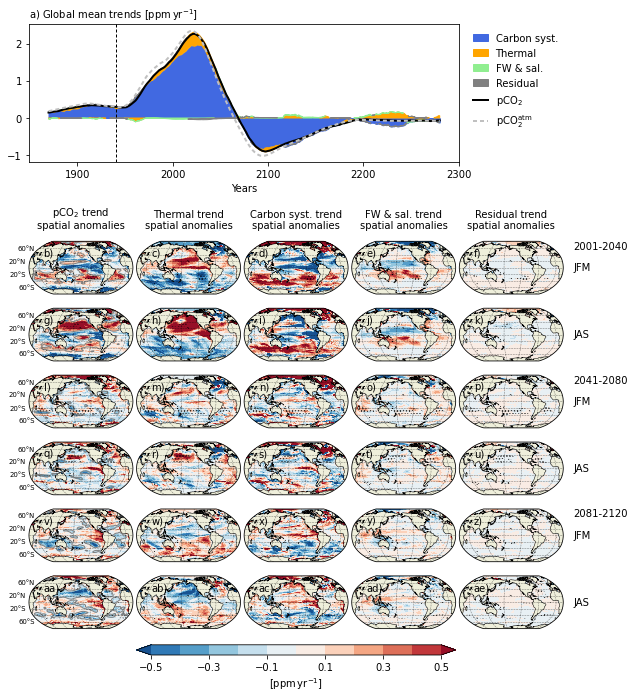

In [230]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: fig all terms")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-ssp126.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2020', '2060', '2100']
season_list = ['JFM', 'JAS']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend', 'freshwater-trend', 'res']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2020': '2001-2040', '2060':'2041-2080', '2100':'2081-2120'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -.5, .5
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{\mathrm{atm}}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod + 1
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason][vmap]['X']
            Y1 = data2plot['maps'][vperiod][vseason][vmap]['Y']
            Z1 = data2plot['maps'][vperiod][vseason][vmap]['Z']
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason]['ACOD']['X']
            Y1 = data2plot['maps'][vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot['maps'][vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot['maps'][vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not imap==0: gl.left_labels=False
            
        #
    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.4 * zw1.width
        nh  = 1.4 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.1*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.2*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw1 = axts.get_position()
zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.5*zw2.height
nx0 = zw2.x0
nw  = zw3.x0 - nx0
nh  = .3*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  1].get_position()
zw2 = ax[-1, -2].get_position()
nx0 = zw1.x0 
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-ssp126-allterms.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 2m 

### Fig 

2023-09-22 16:10:58.979563
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends
Full ocean SSP126: fig
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-4-ssp126.png
CPU times: user 52.4 s, sys: 6.21 s, total: 58.7 s
Wall time: 51.9 s


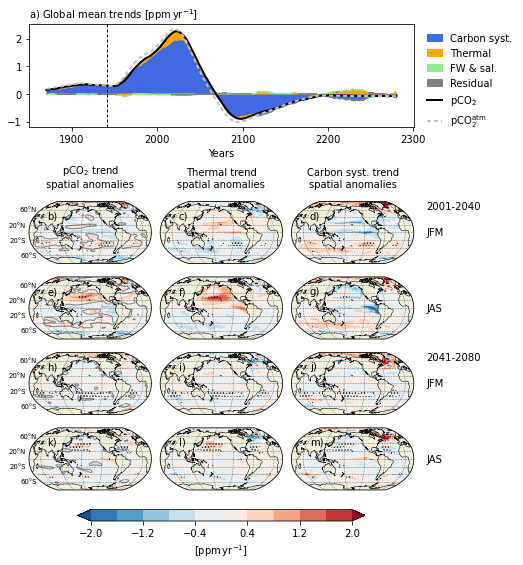

In [231]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends')
print("Full ocean SSP126: fig")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-ssp126.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2020', '2060']
season_list = ['JFM', 'JAS']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend']
nperiod = len(period_list)
nseason = len(season_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod*nseason+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2020': '2001-2040', '2060':'2041-2080', '2100':'2081-2120'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -2, 2
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{\mathrm{atm}}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for imap, vmap in enumerate(maps_list): 
            
            irow = iseason + 2*iperiod + 1
            iplot = irow*ncol+imap+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason][vmap]['X']
            Y1 = data2plot['maps'][vperiod][vseason][vmap]['Y']
            Z1 = data2plot['maps'][vperiod][vseason][vmap]['Z']
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
            pcm.append(zwpcm)

            #_____________________
            # dpco2, carbon, thermal
            X1 = data2plot['maps'][vperiod][vseason]['ACOD']['X']
            Y1 = data2plot['maps'][vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot['maps'][vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # contour d∆pCO2 = 0
            if vmap == 'pco2-trend': 
                zwX = data2plot['maps'][vperiod][vseason]['d∆pCO2']['X']
                zwY = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Y']
                zwZ = data2plot['maps'][vperiod][vseason]['d∆pCO2']['Z']
                grid_in  = {'lon':zwX, 'lat':zwY}
                ds_out = xe.util.grid_global(1, 1)
                weights_filename = dirout+'regridding_weights.nc'
                regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
                zw = regridder(zwZ)
                nans = zw != zw
                # smooth with gaussian filter
                from scipy.ndimage import gaussian_filter
                aaa = np.copy(zw)
                aaa[nans] = 0
                ZZZ = gaussian_filter(aaa, 2)
                ZZZ[nans] = np.nan
                XXX, YYY = ds_out['lon'], ds_out['lat']
                zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
            #
            
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not imap==0: gl.left_labels=False
            
        #
    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.2 * zw1.width
        nh  = 1.2 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.4*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.15*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.2*zw2.height
nx0 = zw2.x0
nw  = zw3.x1 - 0*zw3.width - nx0
nh  = .2*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .4*zw1.width
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - .4*zw2.width - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-ssp126.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1m 

# Fig. 4bis: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN

\begin{align}
\frac{\mathrm{d}pCO_2}{\mathrm{d}t} =&&& \frac{\overline{pCO_2} \times \overline{S}}{\gamma_C \times S_0} \times \frac{\partial C_s}{\partial t}  +
                  \frac{\overline{pCO_2} \times \overline{S}}{\gamma_A \times S_0} \times \frac{\partial A_s}{\partial t}  && {\rm \bf Carbon\ system} \\
                  &+&& \overline{pCO_2} \times \gamma_T \times \frac{\partial T}{\partial t} && {\rm \bf Thermal} \\
                  &+&& \left( \frac{\overline{pCO_2} \times \overline{C_s}}{\gamma_C \times S_0} + \frac{\overline{pCO_2} \times \overline{A_s}}{\gamma_A \times S_0} + \frac{\overline{pCO_2} \times \gamma_S}{\overline{S}} \right) \times \frac{\partial S}{\partial t} && {\rm \bf Freshwater\ and\ salinity}
\end{align}

with: 
- $\overline{X}$ is the mean of $X$ over the time period considered
- $\partial X / \partial t $ is the trend of $X$ over the time period considered
- $C_s$ and $A_s$ DIC and ALK normalized with salinity: $X_s = S_0/S \times X$. $S_0$ is the temporal average of $S$ all over the simulation.
- $\gamma_C$ and $\gamma_A$ computed with pyCO2SYS, $\partial pCO_2/\partial X = pCO_2/\gamma_X$
- $\gamma_T = 0.0423$, $\gamma_S = 1$

## Full

1. Compute the taylor expansion for the full ocean for the different season considered
2. Prepare a pickle with the data2plot

### Compute taylor expansion
1. Load pCO2, Khd, Kh, sdic, salk, sss, sst
2. Compute pCO2 * Khd / Kh and Salinity normalized DIC and ALK
4. Compute mean and trends
5. Compute taylor expansion coefficient
6. Compute taylor expansion terms
7. Compute main terms: pco2 trend, carbon system trend, thermal trend and freshwater trend 

Save Data    
- main terms: *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'* 
- time running means: *dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_'+seas+'.nc'*
- trends: *dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc"*
- coefficients: *dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_'+seas+'.nc'*
- taylor terms: *dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_'+seas+'.nc'*
- Reference salinity: *dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_'+seas+'.nc'*

#### Starters

In [9]:
#----------------
# PARAMETERS
#----------------

simu = 'ssp585'
nbyear = 50 # number of year to compute the mean and trends

#----------------
# Define fuction
#----------------

def savedatatonetcdf(zwdict, zwfile, zwcomment=''): 
    print('Save in netcdf...')
    tods = {}
    for kkk, vvv in zwdict.items(): 
        tods[vvv.name] = vvv
    #
    dstosave = xr.Dataset(tods)
    dstosave.attrs['simu'] = 'historical and '+simu
    dstosave.attrs['model'] = 'NorESM2-LM'
    try: dstosave.attrs['comment'] = zwcomment+' ; '+ dstosave.attrs['comment']
    except: dstosave.attrs['comment'] = zwcomment
    dstosave.to_netcdf(zwfile)
    print('Done, file saved: '+zwfile)
#


#### Step 1, 2, 3

In [18]:
%%time
%%memit -c

print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: compute taylor expansion: step 1, 2, 3")


#=======================================
# 1 - Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2
# 1bis - Select grid points
#=======================================

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'kh', 'khd', 'sdic-tot', 'salk-tot', 'stemp', 'ssali', 'atmco2']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon)).squeeze()
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#=======================================
# 2 - Compute pco2-atm and salinity normalized DIC and ALK
#=======================================

print('Compute pCO2-atm and salinity normalized DIC and ALK...')

# pco2-atm = atmco2 * Kh / Khd 
# because fgco2 = ( atco2  - xco2 ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# and xco2 = cu * 1.e6 / Kh (dry mole fraction of CO2)
# and pco2 = cu * 1.e6 / Khd (pco2 in seawater)
# thus fgco2 = ( atco2 - pco2 * Khd / Kh ) * Kh * 1e-6 * kwco2 * dtbgc * rrho 
# thus fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho 
zw = ( zwdata['atmco2'] * zwdata['kh'] / zwdata['khd'] ).rename('pco2-atm')
zw.attrs = zwdata['atmco2'].attrs
addtxt = 'pco2-atm = atmco2 * Kh / Khd because fgco2 = ( atco2 * Kh / Khd - pco2 ) * Khd * 1e-6 * kwco2 * dtbgc * rrho '
try: zw.attrs['history'] = addtxt+' ; '+zw.attrs['history']
except: zw.attrs['history'] = addtxt
zwdata['pco2-atm'] = zw

SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

#_________________
# Save SSS0
savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
SSS0.to_netcdf(savefile)

# remove unnnecessary variables
for vvv in ['atmco2', 'kh', 'khd']: del zwdata[vvv]


#=======================================
# 3 - Compute mean and trends
#=======================================

# Yearly mean
zwdata2 = {}
for kkk, vvv in zwdata.items(): 
    zwdata2[kkk] = vvv.groupby('time.year').mean(dim='time')
#

zwavg = {}
zwtrd = {}
zfact_alk_dic = 1000./1.024 # from mol.m-3 to umol.kg-1
var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali', 'pco2-atm']
for var in var_list:

    
    # Average
    print('Compute mean of '+var+'...')
    zw = zwdata2[var].rolling(year=nbyear, center=True).mean() 
    if var in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']:
        with xr.set_options(keep_attrs=True): zw = zw*zfact_alk_dic # in umol.kg-1
        zw.attrs['units'] = 'umol kg-1'
    #
    try: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years ; '+ zw.attrs['history']
    except: zw.attrs['history'] = 'Running mean on '+str(nbyear)+' years'
    zwavg[var] = zw
    print('Done')

    # Trends
    print('Compute trend of '+var+'...')
    zw_shift = xr.apply_ufunc(np.roll, zwavg[var], nbyear, kwargs=dict(axis=0), dask='allowed', keep_attrs=True)
    zw = xr.apply_ufunc(np.roll, (zwavg[var] - zw_shift)/nbyear, -int(nbyear/2), kwargs=dict(axis=0), dask='allowed', keep_attrs=False)
    zw[0] = np.nan
    zw.attrs = zwavg[var].attrs
    zw = zw.rename(var+'-trd')
    try: zw.attrs['long_name'] = 'Trend of '+zwavg[var].attrs['long_name']
    except: zw.attrs['long_name'] = 'Trend of '+var 
    try: zw.attrs['units'] = zw.attrs['units'] + ' y-1'
    except: zw.attrs['units'] = 'y-1'
    addtxt = 'Trend computed as the difference between 2 consecutive time period of '+str(nbyear)+' years'
    try: zw.attrs['history'] = addtxt+' ; '+ zw.attrs['history']
    except: zw.attrs['history'] = addtxt
    zwtrd[var] = zw
    print('Done')
#

#________________
# Save data to netcdf

comment = 'This netcdf contains time running means used for the taylor expansion analysis'
savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
savedatatonetcdf(zwavg, savefile, zwcomment=comment)

comment = 'This netcdf contains the trends used for the taylor expansion analysis'
savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
savedatatonetcdf(zwtrd, savefile, zwcomment=comment)

del zwtrd, zwavg, zw, zw_shift, zwdata, zwdata2

# ca. 2m40s

2023-11-24 11:02:01.349996
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: compute taylor expansion: step 1, 2, 3
Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(kh, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(khd, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-nore

#### Step 4

In [19]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: compute taylor expansion: step 4")

#=======================================
# 4 - Compute taylor expansion coefficient
#=======================================

#________________
# Reload zwavg from netcdf
savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
zwavg = xr.open_dataset(savefile, **kwopends, chunks='auto')
savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
SSS0 = xr.open_dataset(savefile, **kwopends, chunks='auto')['ssali']


print('Compute taylor expansion coefficient...')
cut=20
zwgam_np = {}
var_list = ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'sdic-tot-fw', 'salk-tot-fw']
for var in var_list: zwgam_np[var] = []
for yyy in zwavg['salk-tot'].year.values[::cut]: 
    sss = slice(yyy, yyy+cut-1)
    print('    Run PyCO2SYS on years %d-%d...'%(sss.start, sss.stop))
    zwalk    = zwavg['salk-tot'   ].sel(year=sss)
    zwdic    = zwavg['sdic-tot'   ].sel(year=sss)
    zwalk_sn = zwavg['salk-tot-sn'].sel(year=sss)
    zwdic_sn = zwavg['sdic-tot-sn'].sel(year=sss)
    zwsss    = zwavg['ssali'      ].sel(year=sss)
    zwsst    = zwavg['stemp'      ].sel(year=sss)
    kwargs = dict(par1=zwalk.drop('depth').squeeze(), par2=zwdic.drop('depth').squeeze(), par1_type=1, par2_type=2, 
                  salinity=zwsss, temperature=zwsst, opt_pH_scale=1, 
                  opt_k_carbonic=4, opt_k_bisulfate=1)
    zwco2sysres = xr.apply_ufunc(PyCO2SYS.sys, kwargs=kwargs, dask='allowed')
    # coef-dic
    var = 'sdic-tot'
    zwgam_np[var] .extend( 1 / (zwco2sysres['gamma_dic'] * 1e6) )
    # coef-alk
    var = 'salk-tot'
    zwgam_np[var] .extend( 1 / (zwco2sysres['gamma_alk'] * 1e6) )
    # coef-dic-sn
    var = 'sdic-tot-sn'
    zwgam_np[var] .extend( zwsss/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) )
    # coef-alk-sn
    var = 'salk-tot-sn'
    zwgam_np[var] .extend( zwsss/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) )
    # coef-dic-fw
    var = 'sdic-tot-fw'
    zwgam_np[var] .extend( zwdic_sn/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) )
    # coef-alk-fw
    var = 'salk-tot-fw'
    zwgam_np[var] .extend( zwalk_sn/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) )
    print('    Done')
#
del zwalk, zwdic, zwalk_sn, zwdic_sn, zwsss, zwsst    
for var in var_list: zwgam_np[var] = np.array(zwgam_np[var])

print('    Set coefficient as dataarray...')

zwgam = {}
# coef-dic
var = 'sdic-tot'
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_dic'] * 1e6)"
nwattrs = dict(long_name=var+' coefficient for taylor expansion', units='l umol-1',
               history=addtxt)
zwgam[var] = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

# coef-alk
var = 'salk-tot'
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, 1 / (zwco2sysres['gamma_alk'] * 1e6)"
nwattrs = dict(long_name='ALK coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwgam[var]    =  NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

# coef-dic-sn
var = 'sdic-tot-sn'
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
nwattrs = dict(long_name='DIC-sn coefficient for taylor expansion', units='l umol-1', 
              history=addtxt)
zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

# coef-alk-sn
var = 'salk-tot-sn'
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['ssali']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
nwattrs = dict(long_name='ALK-sn coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

# coef-dic-fw
var = 'sdic-tot-fw'
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['sdic-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6)"
nwattrs = dict(long_name='DIC-fw coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

# coef-alk-fw
var = 'salk-tot-fw'
addtxt = "Taylor expansion coefficient computed with PyCO2SYS, zwavg['salk-tot-sn']/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6)"
nwattrs = dict(long_name='ALK-fw coefficient for taylor expansion', units='l umol-1',
              history=addtxt)
zwgam[var]    = NumpyArray_to_DataArray(zwgam_np[var], 'coef-'+var, zwavg['stemp'], nwattrs=nwattrs, force_nwattrs=True)

# coef-sst
var = 'stemp'
zwda = xr.where(zwavg['stemp'].isnull(), np.nan, 0.0423 * xr.ones_like(zwavg['stemp']))
zwda = zwda.rename('coef-'+var)
zwda.attrs = zwavg['stemp'].attrs
zwda.attrs['long_name'] = 'SST coefficient for taylor expansion'
zwda.attrs['units'] = 'degC-1'
addtxt = "Taylor expansion coefficient 0.0423"
try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
except: zwda.attrs['history'] = addtxt
zwgam[var]       = zwda

# coef-sss
var = 'ssali'
zwda = 1 / zwavg['ssali']
zwda = zwda.rename('coef-'+var)
zwda.attrs = zwavg['ssali'].attrs
zwda.attrs['long_name'] = 'SSS coefficient for taylor expansion'
zwda.attrs['units'] = 'kg g-1'
addtxt = "Taylor expansion coefficient 1 / zwavg['ssali']"
try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
except: zwda.attrs['history'] = addtxt
zwgam[var]       = zwda

print('    Done')

print('Done')

#________________
# Save data to netcdf

comment = 'This netcdf contains the coefficient used for the taylor expansion analysis. \
The coefficient are multiply by the average pCO2 and the trend to get the different terms of the taylor expansion'
savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
savedatatonetcdf(zwgam, savefile, zwcomment=comment)

del zwavg, zwgam, zwda

# ca. 20m

2023-11-24 11:53:33.301086
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: compute taylor expansion: step 4
Compute taylor expansion coefficient...
    Run PyCO2SYS on years 1850-1869...
    Done
    Run PyCO2SYS on years 1870-1889...
    Done
    Run PyCO2SYS on years 1890-1909...
    Done
    Run PyCO2SYS on years 1910-1929...
    Done
    Run PyCO2SYS on years 1930-1949...
    Done
    Run PyCO2SYS on years 1950-1969...
    Done
    Run PyCO2SYS on years 1970-1989...
    Done
    Run PyCO2SYS on years 1990-2009...
    Done
    Run PyCO2SYS on years 2010-2029...
    Done
    Run PyCO2SYS on years 2030-2049...
    Done
    Run PyCO2SYS on years 2050-2069...
    Done
    Run PyCO2SYS on years 2070-2089...
    Done
    Run PyCO2SYS on years 2090-2109...
    Done
    Run PyCO2SYS on years 2110-2129...
    Done
    Run PyCO2SYS on years 2130-2149...
    Done
    Run PyCO2SYS on years 2150-2169...
    Done
    Run P

#### Step 5

In [21]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: compute taylor expansion: step 5")

#=======================================
# 5 - Compute taylor expansion terms
#=======================================

#________________
# Reload zwavg, zwtrd, zwgam from netcdf

savefile = dirout+'taylor_expansion_analysis_time_running_means_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
zwavg = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
zwtrd = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
savefile = dirout+'taylor_expansion_analysis_coefficient_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
zwgam = xr.open_dataset(savefile, chunks = 'auto', **kwopends)

    

print('Compute taylor expansion terms...')
zwtaylor = {}
var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
for var in var_list: 

    zwda = zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd[var+'-trd']
    zwda.attrs = zwgam['coef-'+var].attrs
    zwda = zwda.rename('taylor-term-'+var)
    zwda.attrs['long_name'] = var+' term for taylor expansion'
    zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units']+' y-1'
    addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd[var+'-trd']"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwtaylor[var] = zwda

#
for var in ['sdic-tot-fw', 'salk-tot-fw']:
    zwda = zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd['ssali-trd']
    zwda.attrs = zwgam['coef-'+var].attrs
    zwda = zwda.rename('taylor-term-'+var)
    zwda.attrs['long_name'] = var+' term for taylor expansion'
    zwda.attrs['units'] = zwavg['pco2-tot'].attrs['units'] +' y-1'
    addtxt = var.upper() + " taylor expansion term: zwavg['pco2-tot'] * zwgam['coef-'+var] * zwtrd['ssali-trd']"
    try: zwda.attrs['history'] = addtxt+' ; '+ zwda.attrs['history']
    except: zwda.attrs['history'] = addtxt
    zwtaylor[var] = zwda
#
print('Done')

#________________
# Save data to netcdf

comment = 'This netcdf contains the different terms used for the taylor expansion analysis.'
savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
savedatatonetcdf(zwtaylor, savefile, zwcomment=comment)


del zwavg, zwtrd, zwgam, zwtaylor, zwda

# ca. 30s

2023-11-24 13:27:15.413106
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: compute taylor expansion: step 5
Compute taylor expansion terms...
Done
Save in netcdf...
[########################################] | 100% Completed | 6.88 s
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_terms_noresm2-lm_ssp585_but-with-yearly-mean.nc
peak memory: 21722.10 MiB, increment: 11161.37 MiB
CPU times: user 1.77 s, sys: 4.45 s, total: 6.22 s
Wall time: 12.5 s


#### Step 6

In [22]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: compute taylor expansion: step 6")

#=======================================
# 6 - Compute main terms
#=======================================

#________________
# Reload zwtrd, zwtaylor from netcdf

savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
zwtrd = xr.open_dataset(savefile, **kwopends)
savefile = dirout+'taylor_expansion_analysis_terms_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
zwtaylor = xr.open_dataset(savefile, **kwopends)

print('Compute main terms...')
zwmain = {}
with xr.set_options(keep_attrs=True): 

    zwmain['dpCO2'] = zwtrd['pco2-tot-trd']
    zwmain['dpCO2'] = zwmain['dpCO2'].rename('pco2-trend')

    zwmain['dpCO2-atm'] = zwtrd['pco2-atm-trd']
    zwmain['dpCO2-atm'] = zwmain['dpCO2-atm'].rename('pco2-atm-trend')

    zwmain['thermal'] = zwtaylor['taylor-term-stemp']
    zwmain['thermal'] = zwmain['thermal'].rename('thermal-trend')
    zwmain['thermal'].attrs['long_name'] = 'Thermal trend term for taylor expansion'
    zwmain['thermal'].attrs['comment'] = 'The thermal trend account for the effect of trend in \
    temperature on oceanic pCO2'

    zwmain['carbon']  = zwtaylor['taylor-term-sdic-tot-sn'] + zwtaylor['taylor-term-salk-tot-sn']
    zwmain['carbon'] = zwmain['carbon'].rename('carbon-system-trend')
    zwmain['carbon'].attrs['long_name'] = 'Carbon system trend term for taylor expansion'
    zwmain['carbon'].attrs['comment'] = 'The carbon system trend account for the effect on oceanic pCO2 of the trend \
    in DIC and ALK both salinity normalized. Changes in salinity normalized DIC and ALK exclude changes in DIC and ALK \
    associated with freshwater inputs (eg. evaporation or precipitation).'
    addhistory = "Carbon system trend = zwtaylor['sdic-tot-sn'] + zwtaylor['salk-tot-sn']"
    zwmain['carbon'].attrs['history'] = addhistory+ \
    "\n > history of zwtaylor['sdic-tot-sn']: " + zwtaylor['taylor-term-sdic-tot-sn'].attrs['history'] + \
    "\n > history of zwtaylor['salk-tot-sn']: " + zwtaylor['taylor-term-salk-tot-sn'].attrs['history']

    zwmain['fw']      = zwtaylor['taylor-term-sdic-tot-fw'] + zwtaylor['taylor-term-salk-tot-fw'] + zwtaylor['taylor-term-ssali']
    zwmain['fw'] = zwmain['fw'].rename('freshwater-trend')
    zwmain['fw'].attrs['long_name'] = 'Freshwater trend term for taylor expansion'
    zwmain['fw'].attrs['comment'] = 'The freshwater trend account for the effect on oceanic pCO2 of trends in \
    freshwater inputs affecting DIC, ALK and salinity. '
    addhistory = "Freshwater trend = zwtaylor['sdic-tot-fw'] + zwtaylor['salk-tot-fw'] + zwtaylor['ssali']"
    zwmain['fw'].attrs['history'] = addhistory+ \
    "\n > history of zwtaylor['sdic-tot-fw']: " + zwtaylor['taylor-term-sdic-tot-fw'].attrs['history'] + \
    "\n > history of zwtaylor['salk-tot-fw']: " + zwtaylor['taylor-term-salk-tot-fw'].attrs['history'] + \
    "\n > history of zwtaylor['ssali']: " + zwtaylor['taylor-term-ssali'].attrs['history'] 
#

#________________
# Save data to netcdf

comment = 'This netcdf contains the terms of the following taylor expansion: \n \
pco2-trend ~ thermal-trend + carbon-system-trend + freshwater-trend'
savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
savedatatonetcdf(zwmain, savefile, zwcomment=comment)

#
del zwmain, zwtaylor, zwtrd

# ca. 3s

2023-11-24 13:43:31.368782
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: compute taylor expansion: step 6
Compute main terms...
Save in netcdf...
Done, file saved: cc2300-230215-noresm2-lm/taylor_expansion_analysis_noresm2-lm_ssp585_but-with-yearly-mean.nc
CPU times: user 167 ms, sys: 769 ms, total: 936 ms
Wall time: 1.55 s


### Prepare data2plot
1. Reload netcdf of the main terms (pco2 trend, carbon system trend, thermal trend and freshwater trend) for each season:  *dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_'+seas+'.nc'*
2. Compute a global time serie of the taylor expansion: 
    1. Compute the spatial mean for both season for all the terms of the expansion loaded in 1)
    2. Compute the mean between the timeseries of the 2 seasons (or maybe the 4?)
3. Save in data2plot: 
    1. **The global timeseries** for trends in pco2, carbon system, thermal, fresh water, sum of the last 3 and atmospheric pco2.
        - data2plot["time series"]["???"] = {'X': numpy array with the years, 'Y': numpy array with values of ???}
   2. **The maps for different time periods** ['2050' i.e. 21st century, '2150' i.e. 22nd century and '2250' i.e. 23rd century] **and seasons** ['JFM' and 'JAS'] for : 
       - **spatial anomalies of trends** in pco2, carbon system, thermal, fresh water. Spatial anomalies are local trend minus global mean trend from the timeseries above
       - For each time period and season, the grid points where **Cant outgassing emerge**.
      - For each time period and season, the **trend in ∆pCO2** (aCO2 - pCO2)
      - data2plot["maps"]["time period"]["season"]["???"] = {'X': numpy array with longitude, 'Y': numpy array with latitude, 'Z': numpy array with values of ???}.

In [29]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: prepare data2plot")

#---------------------
# Param
#---------------------
simu = 'ssp585'
period_list = ['2050', '2150', '2250']
nbyear = 50 # number of year to compute the mean and trends

#---------------------
# 1 - Load data
#---------------------

savefile = dirout+'taylor_expansion_analysis_noresm2-lm_'+simu+'_but-with-yearly-mean.nc'
main = xr.open_dataset(savefile, **kwopends)

savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)

#____________________
# Regrid ACOD for easier plotting

print('Regrid ACOD for easier plotting...')
datayACOD = data2plot_fig3[simu]['yACOD']
zwX = datayACOD['X']
zwY = datayACOD['Y']
zwZ = datayACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
weights_filename = dirout+'regridding_weights.nc'
# regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
# regridder.to_netcdf(weights_filename)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zyacod = regridder(zwZ)
Xyacod, Yyacod = ds_out['lon'].values, ds_out['lat'].values

datasACOD = data2plot_fig3[simu]['sACOD']
zwX = datasACOD['X']
zwY = datasACOD['Y']
zwZ = datasACOD['Z']
grid_in  = {'lon':zwX, 'lat':zwY}
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
Zsacod = regridder(zwZ)
Xsacod, Ysacod = ds_out['lon'].values, ds_out['lat'].values
print('Done')


#---------------------
# 2 - Compute global time serie of the taylor expansion
#---------------------

#_____________________
# Compute spatial means
print('Compute spatial means...')
spatial_mean = main.weighted(grid['parea']).mean(dim=('x', 'y'), keep_attrs=True)
print('Done')

#---------------------
# 3 - Save in data2plot
#---------------------

print('Save in data2plot')
data2plot = {}

#_____________________
# Timeseries

data2plot['timeseries'] = {}
var_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
for var in var_list: 
    data2plot['timeseries'][var] = {'X': spatial_mean[var].year.values, 'Y': spatial_mean[var].values}
#
# Residual
with xr.set_options(keep_attrs=True): 
    zw = spatial_mean['pco2-trend'] - (spatial_mean['carbon-system-trend'] + \
                                       spatial_mean['thermal-trend'] + \
                                       spatial_mean['freshwater-trend'])
#
data2plot['timeseries']['res'] = {'X': zw.year.values, 'Y': zw.values}

#_____________________
# Maps

data2plot['maps'] = {}
for period in period_list:
    
    data2plot['maps'][period] = {}
    
    zwds = main.sel(year=int(period))
    zwspatial_mean = spatial_mean.sel(year=int(period))
    # terms of taylor expansion
    var_list = ['pco2-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend']
    for var in var_list: 
        data2plot['maps'][period][var] = {
            'X': zwds['plon'].values,
            'Y': zwds['plat'].values,
            'Z': zwds[var].values - zwspatial_mean[var].values
        }
    #
    # Residual
    with xr.set_options(keep_attrs=True): 
        zw1 = zwds['pco2-trend'] - (zwds['carbon-system-trend'] + \
                                    zwds['thermal-trend'] + \
                                    zwds['freshwater-trend'])
        zw2 = zwspatial_mean['pco2-trend'] - (zwspatial_mean['carbon-system-trend'] + \
                                              zwspatial_mean['thermal-trend'] + \
                                              zwspatial_mean['freshwater-trend'])
    #
    data2plot['maps'][period]['res'] = {
        'X': zwds['plon'].values,
        'Y': zwds['plat'].values,
        'Z': zw1.values - zw2.values
    }
    # pco2-atm-trend minus pco2-trend
    data2plot['maps'][period]['d∆pCO2'] = {
        'X': zwds['plon'].values,
        'Y': zwds['plat'].values,
        'Z': zwds['pco2-atm-trend'].values - zwds['pco2-trend'].values
    }
    # ACOD
    minyear, maxyear = int(period)-nbyear, int(period)+nbyear
    zw = np.where( (Zyacod<=maxyear) & (Zyacod>minyear), 1, 0)
    data2plot['maps'][period]['ACOD'] = {
        'X': Xyacod,
        'Y': Yyacod,
        'Z': zw
    }
#
print('Done')

print('Save file...')
savedfile = dirout+'data2plot-fig4-but-with-yearly-mean.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)        


# ca. 4s

2023-11-24 13:45:55.693832
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: prepare data2plot
Regrid ACOD for easier plotting...
Done
Compute spatial means...
Done
Save in data2plot
Done
Save file...
Done, file saved: cc2300-230215-noresm2-lm/data2plot-fig4-but-with-yearly-mean.pckl
CPU times: user 1.31 s, sys: 644 ms, total: 1.95 s
Wall time: 2.06 s


### Fig all terms

2023-11-24 14:25:51.226969
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: fig all terms
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-4-allterms-but-with-yearly-mean.png
CPU times: user 1min 4s, sys: 6.98 s, total: 1min 11s
Wall time: 1min 3s


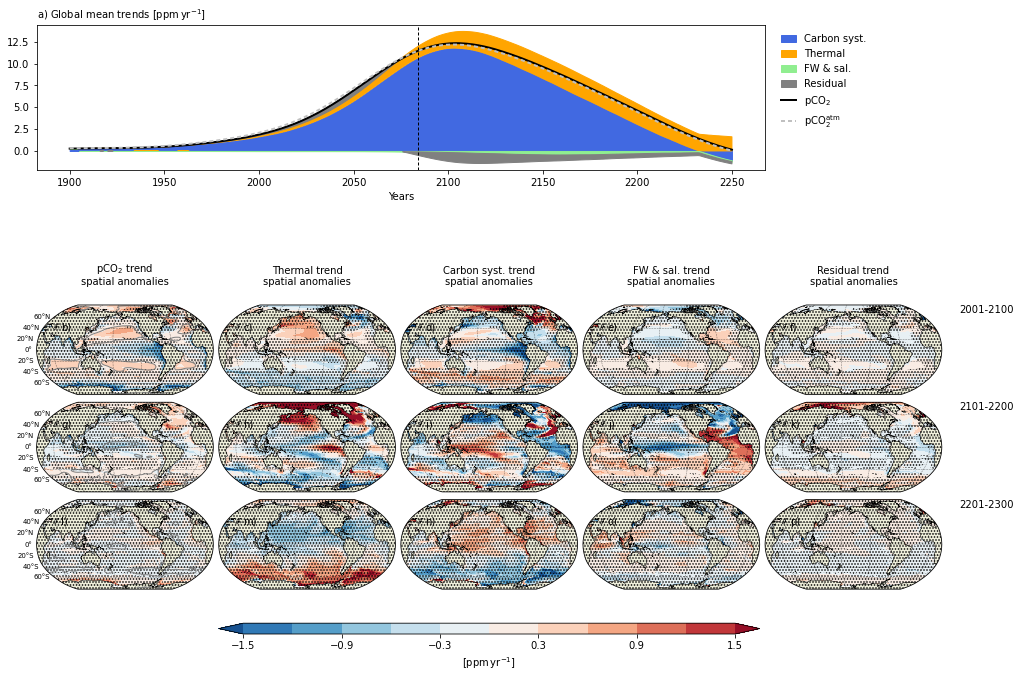

In [39]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: fig all terms")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-but-with-yearly-mean.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150', '2250']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend', 'freshwater-trend', 'res']
nperiod = len(period_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -1.5, 1.5
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])
#kwaod = dict(transform=ccrs.PlateCarree(), colors='chartreuse', linestyles='-', linewidths=2)



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{\mathrm{atm}}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for imap, vmap in enumerate(maps_list): 

        irow  = iperiod + 1
        iplot = irow*ncol+imap+1
        zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

        #_____________________
        # dpco2, carbon, thermal
        X1 = data2plot['maps'][vperiod][vmap]['X']
        Y1 = data2plot['maps'][vperiod][vmap]['Y']
        Z1 = data2plot['maps'][vperiod][vmap]['Z']
        zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
        pcm.append(zwpcm)

        #_____________________
        # ACOD
        X1 = data2plot['maps'][vperiod]['ACOD']['X']
        Y1 = data2plot['maps'][vperiod]['ACOD']['Y']
        Z1 = data2plot['maps'][vperiod]['ACOD']['Z']
        zax.contourf(X1, Y1, Z1, levels = [-.5, .5], **kwaod)
        #zax.contour(X1, Y1, Z1, levels = [.1], **kwaod)

        #_____________________
        # contour d∆pCO2 = 0
        if vmap == 'pco2-trend': 
            zwX = data2plot['maps'][vperiod]['d∆pCO2']['X']
            zwY = data2plot['maps'][vperiod]['d∆pCO2']['Y']
            zwZ = data2plot['maps'][vperiod]['d∆pCO2']['Z']
            grid_in  = {'lon':zwX, 'lat':zwY}
            ds_out = xe.util.grid_global(1, 1)
            weights_filename = dirout+'regridding_weights.nc'
            regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
            zw = regridder(zwZ)
            nans = zw != zw
            # smooth with gaussian filter
            from scipy.ndimage import gaussian_filter
            aaa = np.copy(zw)
            aaa[nans] = 0
            ZZZ = gaussian_filter(aaa, 2)
            ZZZ[nans] = np.nan
            XXX, YYY = ds_out['lon'], ds_out['lat']
            zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
        #

        #_____________________
        # axis settings
        gl = add_gridlines_coastline_and_land(zax)
        if not imap==0: gl.left_labels=False


    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.3 * zw1.width
        nh  = 1.3 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.3*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.2*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw1 = axts.get_position()
zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.5*zw2.height
nx0 = zw2.x0
nw  = zw3.x0 - nx0
nh  = .3*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  1].get_position()
zw2 = ax[-1, -2].get_position()
nx0 = zw1.x0 
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-allterms-but-with-yearly-mean.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 2m 

### Fig 

2023-11-24 14:26:57.351770
Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN
Full ocean: fig
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-4-but-with-yearly-mean.png
CPU times: user 27 s, sys: 3.19 s, total: 30.2 s
Wall time: 26.6 s


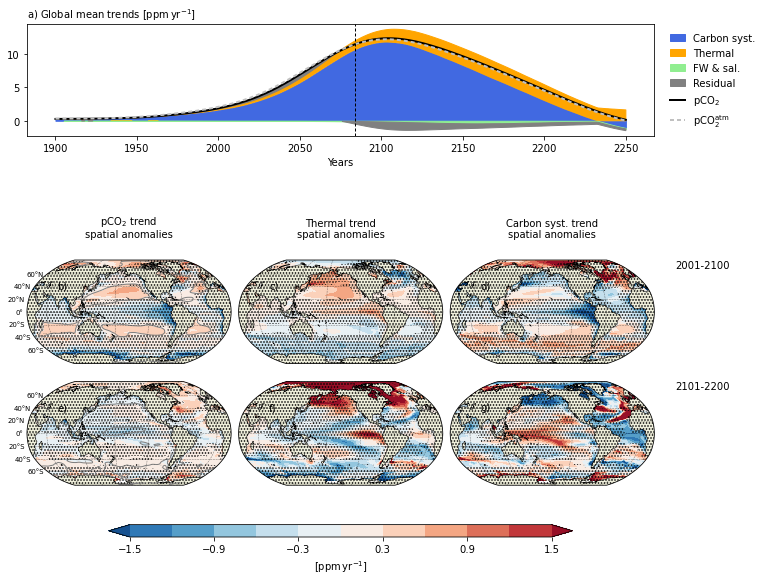

In [40]:
%%time
print(datetime.datetime.now())
print('Fig. 4: taylor expansion for SSP585 dpCO2/dt = thermal trends + carbon trends + FW trends BUT WITH YEARLY MEAN')
print("Full ocean: fig")

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig4-but-with-yearly-mean.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
# period_list = ['2050', '2150', '2250']
period_list = ['2050', '2150']
timeseries_list = ['pco2-trend', 'pco2-atm-trend', 'carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']
maps_list = ['pco2-trend', 'thermal-trend', 'carbon-system-trend']
nperiod = len(period_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod+1, nmaps
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nmaps/(nperiod+2)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

value_names = {'pco2-trend':'pCO$_2$', 'thermal-trend':'Thermal', \
              'carbon-system-trend':'Carbon syst.', 'freshwater-trend':'FW & sal.', \
              'res':'Residual'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmin, vmax = -1.5, 1.5
kwmap   = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=vmin, vmax=vmax)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])



#=========================================
# PLOT
#=========================================

#---------------------
# Time series
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

#_____________________
# carbon, thermal and fw
color_timeseries = {'carbon-system-trend':'royalblue', 'thermal-trend':'orange', \
                    'freshwater-trend':'lightgreen', 'res':'grey'}
prevYpos = data2plot['timeseries']['carbon-system-trend']['X']*0.
prevYneg = data2plot['timeseries']['carbon-system-trend']['X']*0.
for vvalue in ['carbon-system-trend', 'thermal-trend', 'freshwater-trend', 'res']: 
    X = data2plot['timeseries'][vvalue]['X']
    Y = data2plot['timeseries'][vvalue]['Y']
    Ypos = np.where(Y>=0, Y, 0.)
    Yneg = np.where(Y<0 , Y, 0.)
    zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names[vvalue], color=color_timeseries[vvalue], 
                     where=np.where(prevYpos+Ypos!=prevYpos, True, False))
    prevYpos+=Ypos
    zax.fill_between(X, prevYneg, prevYneg+Yneg, color=color_timeseries[vvalue], 
                     where=np.where(prevYneg+Yneg!=prevYneg, True, False))
    prevYneg+=Yneg    
#

#_____________________
# Residual
# X = data2plot['timeseries'][']['X']
# zwsum = prevYneg + prevYpos
# Y = data2plot['timeseries']['pco2-trend']['Y'] - zwsum
# Ypos = np.where(Y>=0, Y, 0.)
# Yneg = np.where(Y<0 , Y, 0.)
# zax.fill_between(X, prevYpos, prevYpos+Ypos, label=value_names['res'], color='grey', where=np.where(prevYpos+Ypos!=prevYpos, True, False))
# zax.fill_between(X, prevYneg, prevYneg+Yneg, color='grey', where=np.where(prevYneg+Yneg!=prevYneg, True, False))

#_____________________
# pCO2
X = data2plot['timeseries']['pco2-trend']['X']
Y = data2plot['timeseries']['pco2-trend']['Y']
zax.plot(X, Y, label=value_names['pco2-trend'], color='k', lw=2)

#_____________________
# pCO2 atm
X = data2plot['timeseries']['pco2-atm-trend']['X']
Y = data2plot['timeseries']['pco2-atm-trend']['Y']
zax.plot(X, Y, label='pCO$_2^{\mathrm{atm}}$', color='silver', ls='--', lw=2, dashes=[2, 1.5])

zax.set_xlabel('Years')
zax.set_title(subnum.pop()+') Global mean trends [ppm$\,$yr$^{-1}$]', loc='left', fontsize='medium')

hdls = zax.get_legend_handles_labels()

idx = np.where((data2plot['timeseries']['pco2-trend']['Y'] - \
                data2plot['timeseries']['pco2-atm-trend']['Y']) > 0)[0].min()
X0 = X[idx]
zax.axvline(X0, c='k', lw=1, ls='--', dashes=[3, 2])

#---------------------
# Maps
#---------------------

pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for imap, vmap in enumerate(maps_list): 

        irow = iperiod + 1
        iplot = irow*ncol+imap+1
        zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

        #_____________________
        # dpco2, carbon, thermal
        X1 = data2plot['maps'][vperiod][vmap]['X']
        Y1 = data2plot['maps'][vperiod][vmap]['Y']
        Z1 = data2plot['maps'][vperiod][vmap]['Z']
        zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap)
        pcm.append(zwpcm)

        #_____________________
        # dpco2, carbon, thermal
        X1 = data2plot['maps'][vperiod]['ACOD']['X']
        Y1 = data2plot['maps'][vperiod]['ACOD']['Y']
        Z1 = data2plot['maps'][vperiod]['ACOD']['Z']
        zax.contourf(X1, Y1, Z1, levels = [-.5, .5], **kwaod)

        #_____________________
        # contour d∆pCO2 = 0
        if vmap == 'pco2-trend': 
            zwX = data2plot['maps'][vperiod]['d∆pCO2']['X']
            zwY = data2plot['maps'][vperiod]['d∆pCO2']['Y']
            zwZ = data2plot['maps'][vperiod]['d∆pCO2']['Z']
            grid_in  = {'lon':zwX, 'lat':zwY}
            ds_out = xe.util.grid_global(1, 1)
            weights_filename = dirout+'regridding_weights.nc'
            regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
            zw = regridder(zwZ)
            nans = zw != zw
            # smooth with gaussian filter
            from scipy.ndimage import gaussian_filter
            aaa = np.copy(zw)
            aaa[nans] = 0
            ZZZ = gaussian_filter(aaa, 2)
            ZZZ[nans] = np.nan
            XXX, YYY = ds_out['lon'], ds_out['lat']
            zax.contour(XXX, YYY, ZZZ, levels = [0], linewidths=1, linestyles='-', colors='gray', transform=ccrs.PlateCarree())
        #

        #_____________________
        # axis settings
        gl = add_gridlines_coastline_and_land(zax)
        if not imap==0: gl.left_labels=False

    #
#
 
fig.tight_layout()

axts = fig.axes[0]
ax = np.reshape(fig.axes[1:], (nrow-1, ncol))
pcm = np.reshape(pcm, (nrow-1, ncol))

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

#---------------------
# maps
#---------------------

# resize
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nw  = 1.2 * zw1.width
        nh  = 1.2 * zw1.height
        nx0 = zw1.x0
        ny0 = zw1.y0
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.4*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[1:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + (icol+1)*.15*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

#---------------------
# time series
#---------------------

zw2 = ax[0, 0].get_position()
zw3 = ax[0, -1].get_position()
ny0 = zw2.y1 + 1.2*zw2.height
nx0 = zw2.x0
nw  = zw3.x1 - 0*zw3.width - nx0
nh  = .2*nw
axts.set_position([nx0, ny0, nw, nh])


#=========================================
# Set time series legend
#=========================================

zw1 = axts.get_position()
nx0  = zw1.x1 + 0.01*zw1.width
ny0 = zw1.y1
legax = fig.add_axes([nx0, ny0, 0, 0])
legax.legend(handles=hdls[0], labels=hdls[1], ncol=1, handlelength=1.5, \
             columnspacing=.8, loc='upper left', frameon=False)
legax.axis('off')

#=========================================
# COLORBARS
#=========================================

zw1 = ax[-1,  0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .4*zw1.width
ny0 = zw1.y0 - .5*zw1.height
nw  = zw2.x1 - .4*zw2.width - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm[0, 0], cax=cax, orientation='horizontal', ticklocation='bottom', 
                    extend='both')
cbar.set_label('[ppm$\,$yr$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, vmax, int((pcm[0, 0].cmap.colors.shape[0]/2+1))))

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#---------------------
# At the top, trends titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for imap, vmap in enumerate(maps_list): 
    zw1 = ax[0, imap].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, '%s trend\nspatial anomalies'%value_names[vmap], **kwtxt)
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-4-but-with-yearly-mean.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1m 

# Fig. 5: dCant/dt and dSST/dt for SSP585

- In rows : time periods and seasons
- 1st column: trends in sdic-ant-sn
- 2nd colum: trend in sst


### Prepare data2plot

1. Compute sdic-nat-sn

2. Compute trends, loop on season: 
    1. Compute trend in sdic-nat-sn
    1. Load trends in sdic-tot-sn, sst
    2. Compute sdic-ant-sn = tot - nat 

3. Save in data2plot the maps for **different time periods** ['2050' i.e. 21st century, '2150' i.e. 22nd century and '2250' i.e. 23rd century] **and seasons** ['JFM' and 'JAS']: 
    - Load data2plot-fig4 to get grid points where **Cant outgassing emerge**.
    - Loop on period and season to save in data2plot: 
        - **trends in sdic-ant-sn and sst**
        - the grid points where **Cant outgassing emerge**.
        - data2plot["time period"]["season"]["???"] = {'X': numpy array with longitude, 'Y': numpy array with latitude, 'Z': numpy array with values of ???}.

In [274]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Fig. 5: dCant/dt and dSST/dt for SSP585')
print('Prepare data2plot')

#=======================================
# PARAMETERS
#=======================================

simu = 'ssp585'
period_list = ['2050', '2150', '2250']
seas_list  = ['JAS', 'JFM']
nbyear = 50



#=======================================
# 1 - Compute sdic-nat-sn
#=======================================

print('Compute sdic-nat-sn...')

#----------------------
# Load sdic-nat and ssali
#----------------------

print('    Load sdic-nat, ssali and SSS0...')
var_list = ['sdic-nat', 'ssali']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
savefile = dirout+'taylor_expansion_analysis_SSS0_noresm2-lm_'+simu+'.nc'
SSS0 = xr.open_dataset(savefile, **kwopends, chunks='auto')['ssali']
print('    Done')

#----------------------
# 2 - Compute salinity normalized DIC-nat
#----------------------

print('    Compute salinity normalized DIC-nat...')
for var in ['sdic-nat']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('    Done')
print('Done')

#=======================================
# 2 - Compute trends, loop on season
#     1. Compute trend in sdic-nat-sn
#     1. Load trends in sdic-tot-sn, sst
#     2. Compute sdic-ant-sn = tot - nat 
#=======================================
print('Compute trends, loop on season...')
zwtrd = {}
for seas in seas_list: 
    
    print('    Season: '+seas)
    zwtrd[seas] = {}
    
    #----------------------
    # 1 - Compute trend in sdic-nat-sn
    #----------------------
    
    var = 'sdic-nat-sn'
    
    print('    Compute trend in sdic-nat-sn...')
    print('        Select season...')
    zw = select_season(zwdata[var], seas, verbose=False)
    print('        Done')

    # Average
    print('        Compute mean...')
    zw2 = zw.rolling(year=nbyear, center=True).mean() # in mol.m-3
    zw2.attrs['units'] = 'mol m-3'
    addtxt = 'Running mean on '+str(nbyear)+' years'
    try: zw2.attrs['history'] = addtxt + ' ; '+ zw2.attrs['history']
    except: zw2.attrs['history'] = addtxt
    print('        Done')

    # Trends
    print('        Compute trend...')
    zw_shift = xr.apply_ufunc(np.roll, zw2, nbyear, kwargs=dict(axis=0), dask='allowed', keep_attrs=True)
    zw3 = xr.apply_ufunc(np.roll, (zw2 - zw_shift)/nbyear, -int(nbyear/2), kwargs=dict(axis=0), dask='allowed', keep_attrs=False)
    zw3[0] = np.nan
    zw3.attrs = zw2.attrs
    zw3 = zw3.rename(var+'-trd')
    try: zw3.attrs['long_name'] = 'Trend of '+zw2.attrs['long_name']
    except: zw3.attrs['long_name'] = 'Trend of %s' %var
    try: zw3.attrs['units'] = zw3.attrs['units'] + ' y-1'
    except: zw3.attrs['units'] = 'y-1'
    addtxt = 'Trend computed as the difference between 2 consecutive time period of '\
    +str(nbyear)+' years'
    try: zw3.attrs['history'] = addtxt+' ; '+ zw3.attrs['history']
    except: zw3.attrs['history'] = addtxt
    zwtrd[seas][var+'-trd'] = zw3
    print('        Done')
    print('    Done')

    #----------------------
    # 2 - Load trend in sdic-to-sn and sst
    #----------------------
    
    zfact_alk_dic = 1000./1.024 # from mol.m-3 to umol.kg-1

    print('    Load trend sdic-tot-sn-trd, stemp-trd...')
    print('        Load dataset...')
    savefile = dirout+'taylor_expansion_analysis_trends_noresm2-lm_'+simu+'_'+seas+'.nc'
    zwds = xr.open_dataset(savefile, chunks = 'auto', **kwopends)
    print('        Done, file loaded: '+savefile)
    var = 'stemp-trd'
    zwtrd[seas][var] = zwds[var]
    var = 'sdic-tot-sn-trd'
    zwtrd[seas][var] = zwds[var]/zfact_alk_dic
    print('    Done')
    
    print('    Compute sdic-ant-sn-trd...')
    zwtrd[seas]['sdic-ant-sn-trd'] = zwtrd[seas]['sdic-tot-sn-trd'] - zwtrd[seas]['sdic-nat-sn-trd']
    print('    Done')
    
print('Done')
#=======================================
# END loop on season
#=======================================



#=======================================
# 3. Save in data2plot the maps for different time periods and seasons 
#    data2plot["time period"]["season"]["???"] = {'X': , 'Y': , 'Z': }: 
#    - Load data2plot-fig4 to get grid points where Cant outgassing emerge.
#    - Loop on period and season to save in data2plot: 
#          - **trends in sdic-ant-sn and sst**
#          - the grid points where **Cant outgassing emerge**.
#=======================================

print('Save in data2plot...')
    
#----------------------
# 1 - Load data2plot fig4
#----------------------
print('    Load data2plot-fig4...')
savedfile = dirout+'data2plot-fig4.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig4 = pickle.load(f1)
print('    Done')


#----------------------
# 2 - Loop on period and season
#----------------------
print('    Start loop on period and season...')
data2plot = {}
for period in period_list:
    print('        Period: '+period)
    data2plot[period] = {}
    for seas in seas_list:         
        print('        Season: '+seas)
        data2plot[period][seas] = {}        
        #_____________________
        # Trends
        for var in ['sdic-ant-sn-trd', 'sdic-tot-sn-trd', 'sdic-nat-sn-trd', 'stemp-trd']: 
            zwda = zwtrd[seas][var].sel(year=int(period))
            data2plot[period][seas][var] = {
                'X': zwda['plon'].values, 
                'Y': zwda['plat'].values, 
                'Z': zwda.values
            }
        #
        #_____________________
        # ACOD
        data2plot[period][seas]['ACOD'] = data2plot_fig4['maps'][period][seas]['ACOD']
    #
#
print('   Done')

print('    Save file...')
savedfile = dirout+'data2plot-fig5.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("    Done, file saved: "+savedfile)        

print('Done')
        

2023-09-22 17:47:38.080708
Fig. 5: dCant/dt and dSST/dt for SSP585
Prepare data2plot
Compute sdic-nat-sn...
    Load sdic-nat, ssali and SSS0...
func: load_and_concat_hist_ssp(sdic-nat, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(ssali, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
    Done
    Compute salinity normalized DIC-nat...
    Done
Done
Compute trends, loop on season...
    Season: JAS
    Compute trend in sdic-nat-sn...
        Select season...


/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 75 times more chunks
  return self.array[key]
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


        Done
        Compute mean...
        Done
        Compute trend...
        Done
    Done
    Load trend sdic-tot-sn-trd, stemp-trd...
        Load dataset...
        Done, file loaded: cc2300-230215-noresm2-lm/taylor_expansion_analysis_trends_noresm2-lm_ssp585_JAS.nc
    Done
    Compute sdic-ant-sn-trd...
    Done
    Season: JFM
    Compute trend in sdic-nat-sn...
        Select season...


/home/daco/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 75 times more chunks
  return self.array[key]
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


        Done
        Compute mean...
        Done
        Compute trend...
        Done
    Done
    Load trend sdic-tot-sn-trd, stemp-trd...
        Load dataset...
        Done, file loaded: cc2300-230215-noresm2-lm/taylor_expansion_analysis_trends_noresm2-lm_ssp585_JFM.nc
    Done
    Compute sdic-ant-sn-trd...
    Done
Done
Save in data2plot...
    Load data2plot-fig4...
    Done
    Start loop on period and season...
        Period: 2050
        Season: JAS
[########################################] | 100% Completed | 4.53 s
[########################################] | 100% Completed | 3.92 s
        Season: JFM
[########################################] | 100% Completed | 3.52 s
[########################################] | 100% Completed | 3.52 s
        Period: 2150
        Season: JAS
[########################################] | 100% Completed | 3.72 s
[########################################] | 100% Completed | 3.82 s
        Season: JFM
[#####################################

### Plot all terms

2023-09-22 17:50:12.542441
Fig. 5: plot all terms
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure s

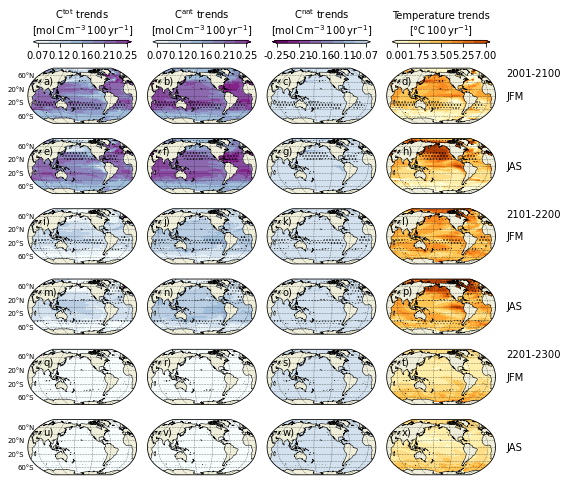

In [276]:
%%time 
%%memit
print(datetime.datetime.now())
print('Fig. 5: plot all terms')

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig5.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
period_list = ['2050', '2150', '2250']
season_list = ['JFM', 'JAS']
var_list = ['sdic-tot-sn-trd', 'sdic-ant-sn-trd', 'sdic-nat-sn-trd', 'stemp-trd']
nperiod = len(period_list)
nseason = len(season_list)
nvar  = len(var_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason, nvar
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nvar/(nperiod*nseason)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

var_names = {'sdic-ant-sn-trd':'C$^{\mathrm{ant}}$ trends\n[mol$\,$C$\,$m$^{-3}$$\,$100$\,$yr$^{-1}$]', 
             'sdic-tot-sn-trd':'C$^{\mathrm{tot}}$ trends\n[mol$\,$C$\,$m$^{-3}$$\,$100$\,$yr$^{-1}$]', 
             'sdic-nat-sn-trd':'C$^{\mathrm{nat}}$ trends\n[mol$\,$C$\,$m$^{-3}$$\,$100$\,$yr$^{-1}$]', 
             'stemp-trd' :'Temperature trends\n[°C$\,$100$\,$yr$^{-1}$]'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

kwmap = {}

a = cm.get_cmap('BuPu',64)
colors = a(np.linspace(0,1,10+2))[:-2]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['sdic-ant-sn-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=.07, vmax=.25)
kwmap['sdic-tot-sn-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=.07, vmax=.25)
a = cm.get_cmap('BuPu_r',64)
colors = a(np.linspace(0,1,10+2))[:-2]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['sdic-nat-sn-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-.25, vmax=-.07)

a = cm.get_cmap('YlOrBr',64)
colors = a(np.linspace(0,1,10+2))[:-2]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['stemp-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=0, vmax=7)

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])

#=========================================
# PLOT
#=========================================


pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for ivar, vvar in enumerate(var_list): 
            
            irow = iseason + 2*iperiod
            iplot = irow*ncol+ivar+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # var
            X1 = data2plot[vperiod][vseason][vvar]['X']
            Y1 = data2plot[vperiod][vseason][vvar]['Y']
            Z1 = data2plot[vperiod][vseason][vvar]['Z']*100
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap[vvar])
            pcm.append(zwpcm)

            #_____________________
            # ACOD
            X1 = data2plot[vperiod][vseason]['ACOD']['X']
            Y1 = data2plot[vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot[vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not ivar==0: gl.left_labels=False
        #
    #
#
fig.tight_layout()

ax = np.reshape(fig.axes, (nrow, ncol))
pcm = np.reshape(pcm, (nrow, ncol))

#=========================================
# numbering plots
#=========================================

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositioning axis
#=========================================

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.2*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#=========================================
# COLORBARS
#=========================================

for ivar, vvar in enumerate(var_list): 
    
    zw1 = ax[0, ivar].get_position()
    nx0 = zw1.x0 +0.05*zw1.width
    ny0 = zw1.y1 + .45*zw1.height
    nw  = 0.9*zw1.width
    nh  = 0.03*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm[0, ivar], cax=cax, orientation='horizontal', ticklocation='bottom', 
                        extend='both')
    cax.set_title(var_names[vvar], size='medium')
    ttt = np.linspace(kwmap[vvar]['vmin'], kwmap[vvar]['vmax'], int((pcm[0, 1].cmap.colors.shape[0]/2+1)))
    cbar.set_ticks(ttt)
    cbar.set_ticklabels(['%.2f' %s for s in ttt])
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-5-allterms.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)



### Plot

2023-09-22 17:51:59.651458
Fig. 5: plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-5.png
CPU times: user 34.1 s, sys: 4.15 s, total: 38.2 s
Wall time: 33.8 s


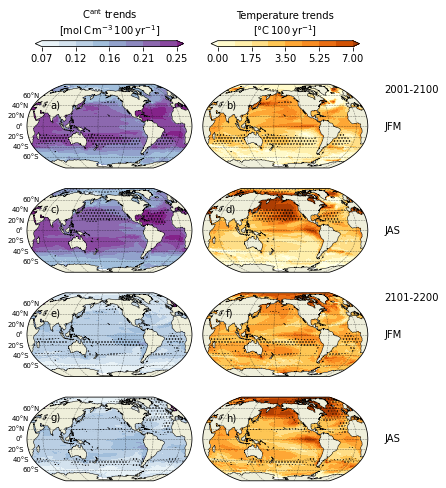

In [277]:
%%time 
print(datetime.datetime.now())
print('Fig. 5: plot')

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-fig5.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

#period_list = list(data2plot['maps'].keys())
#season_list = list(data2plot[period_list[0]].keys())
period_list = ['2050', '2150']
season_list = ['JFM', 'JAS']
var_list = ['sdic-ant-sn-trd', 'stemp-trd']
nperiod = len(period_list)
nseason = len(season_list)
nvar  = len(var_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod*nseason, nvar
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nvar/(nperiod*nseason)*1.5*18*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

var_names = {'sdic-ant-sn-trd':'C$^{\mathrm{ant}}$ trends\n[mol$\,$C$\,$m$^{-3}$$\,$100$\,$yr$^{-1}$]', 
             'sdic-tot-sn-trd':'C$^{\mathrm{tot}}$ trends\n[mol$\,$C$\,$m$^{-3}$$\,$100$\,$yr$^{-1}$]', 
             'stemp-trd' :'Temperature trends\n[°C$\,$100$\,$yr$^{-1}$]'}
period_names = {'2050': '2001-2100', '2150':'2101-2200', '2250':'2201-2300'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

kwmap = {}

a = cm.get_cmap('BuPu',64)
colors = a(np.linspace(0,1,10+2))[:-2]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['sdic-ant-sn-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=.07, vmax=.25)
kwmap['sdic-tot-sn-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=.07, vmax=.25)

a = cm.get_cmap('YlOrBr',64)
colors = a(np.linspace(0,1,10+2))[:-2]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['stemp-trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap, vmin=0, vmax=7)

#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])

#=========================================
# PLOT
#=========================================


pcm = []
        
for iperiod, vperiod in enumerate(period_list): 

    for iseason, vseason in enumerate(season_list): 
                
        for ivar, vvar in enumerate(var_list): 
            
            irow = iseason + 2*iperiod
            iplot = irow*ncol+ivar+1
            zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)

            #_____________________
            # var
            X1 = data2plot[vperiod][vseason][vvar]['X']
            Y1 = data2plot[vperiod][vseason][vvar]['Y']
            Z1 = data2plot[vperiod][vseason][vvar]['Z']*100
            zwpcm = zax.pcolormesh(X1, Y1, Z1, **kwmap[vvar])
            pcm.append(zwpcm)

            #_____________________
            # ACOD
            X1 = data2plot[vperiod][vseason]['ACOD']['X']
            Y1 = data2plot[vperiod][vseason]['ACOD']['Y']
            Z1 = data2plot[vperiod][vseason]['ACOD']['Z']
            zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)
                
            #_____________________
            # axis settings
            gl = add_gridlines_coastline_and_land(zax)
            if not ivar==0: gl.left_labels=False
        #
    #
#
fig.tight_layout()

ax = np.reshape(fig.axes, (nrow, ncol))
pcm = np.reshape(pcm, (nrow, ncol))

#=========================================
# numbering plots
#=========================================

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositioning axis
#=========================================

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.2*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#=========================================
# Extra text
#=========================================

#---------------------
# On the right season titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iperiod, vperiod in enumerate(period_list): 
    for iseason, vseason in enumerate(season_list): 
        zw1 = ax[2*iperiod+iseason, -1].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x1 + .1*zw1.width
        fig.text(nx0, ny0, vseason, **kwtxt)
    #
#

#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[2*iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, period_names[vperiod], **kwtxt)
#

#=========================================
# COLORBARS
#=========================================

for ivar, vvar in enumerate(var_list): 
    
    zw1 = ax[0, ivar].get_position()
    nx0 = zw1.x0 +0.05*zw1.width
    ny0 = zw1.y1 + .45*zw1.height
    nw  = 0.9*zw1.width
    nh  = 0.03*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm[0, ivar], cax=cax, orientation='horizontal', ticklocation='bottom', 
                        extend='both')
    cax.set_title(var_names[vvar], size='medium')
    ttt = np.linspace(kwmap[vvar]['vmin'], kwmap[vvar]['vmax'], int((pcm[0, 1].cmap.colors.shape[0]/2+1)))
    cbar.set_ticks(ttt)
    cbar.set_ticklabels(['%.2f' %s for s in ttt])
#

#=========================================
# Save figure
#=========================================

fignam = 'fig-5.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)



# Maps of season of pCO2 max + taylor expansion


$ max(\Delta pCO_2) = <pCO_2> \times \left(\gamma_T \times \Delta T + \frac{\gamma_{S}}{S}\times\Delta S  + \frac{1}{\gamma_{DIC}}\times\Delta DIC  + \frac{1}{\gamma_{ALK}}\times\Delta ALK \right) $

We are looking at seasonal anomalies of a climatological mean on a 50 year period. The mean is the yearly mean of the climatology. $\delta X$ are the seasonal anomalies relative to the mean. The sensitivities to DIC and ALK ($\gamma_{DIC}$ and $ \gamma_{ALK}$) are evaluated with CO2SYS with yearly mean values of T, S,DIC and ALK. Note they have to be multiplied by $10^6$ to be in the correct unit. 

This is done in each grid point and for each 50 year periods

## Load and prepare data2plot

In [1]:
%%time
print(datetime.datetime.now())
print('Maps of season of pCO2 max + taylor expansion: load and prepare data2plot')

simu = 'ssp585'
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
period_list = [ (2031, 2050), (2081, 2100), (2131, 2150), (2181, 2200)]

data2plot = {}

#=======================================
# 1 - Load pCO2, sdic, salk, sss, sst
#=======================================

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'stemp', 'ssali']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#=======================================
# 2 - Compute salinity normalized DIC and ALK
#=======================================

print('Compute salinity normalized DIC and ALK...')
SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

#=======================================
# Loop on time periods
#=======================================

print('Start loop on time periods...')


for period in period_list: 
    
    print('    period: '+str(period))

    pname = '%04d-%04d'%period
    data2plot[pname] = {}
    

    #-------------------
    # 1) Select time period and compute climatologies
    #-------------------
    
    print('        Select time period and compute climatologies...')
    clim = {}
    var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali']
    for var in var_list: 
        clim[var] = zwdata[var].sel(time=slice(str(period[0]), str(period[1]))).groupby('time.month').mean(dim='time')
    #
    print('        Done')
    
    #-------------------
    # 2) Select month and season of maximum pCO2
    #-------------------

    print('        Select month and season of maximum pCO2...')
    # get month of pCO2 max
    zwnans = clim['pco2-tot'].isnull()
    zwpco2_mon = clim['pco2-tot'].fillna(0).argmax(dim='month')+1
    zwpco2_mon = xr.where(zwnans.any(dim='month'), np.nan, zwpco2_mon)
    # get season of pCO2 max
    winter = (zwpco2_mon==1) | (zwpco2_mon==2)  | (zwpco2_mon==3)
    spring = (zwpco2_mon==4) | (zwpco2_mon==5)  | (zwpco2_mon==6)
    summer = (zwpco2_mon==7) | (zwpco2_mon==8)  | (zwpco2_mon==9)
    autumn = (zwpco2_mon==10) | (zwpco2_mon==11) | (zwpco2_mon==12)
    zwpco2_sea = xr.where(winter, 1, np.nan)
    zwpco2_sea = xr.where(spring, 2, zwpco2_sea)
    zwpco2_sea = xr.where(summer, 3, zwpco2_sea)
    zwpco2_sea = xr.where(autumn, 4, zwpco2_sea)
    zwpco2_sea = xr.where(zwnans.any(dim='month'), np.nan, zwpco2_sea)
    print('        Done')

    #-------------------
    # 3) Compute yearly average
    #-------------------
    
    print('        Compute yearly average...')
    yavg = {}
    yavg['pco2-tot'   ] = clim['pco2-tot'   ].mean(dim='month')
    yavg['sdic-tot'   ] = clim['sdic-tot'   ].mean(dim='month')*1000./1.024 # in umol.kg-1
    yavg['salk-tot'   ] = clim['salk-tot'   ].mean(dim='month')*1000./1.024 # in umol.kg-1
    yavg['sdic-tot-sn'] = clim['sdic-tot-sn'].mean(dim='month')*1000./1.024 # in umol.kg-1
    yavg['salk-tot-sn'] = clim['salk-tot-sn'].mean(dim='month')*1000./1.024 # in umol.kg-1
    yavg['stemp'      ] = clim['stemp'      ].mean(dim='month')
    yavg['ssali'      ] = clim['ssali'      ].mean(dim='month')
    print('        Done')
    

    #-------------------
    # 4) Compute anomalies (for the month of the maximum pCO2)
    #-------------------
    
    print('        Compute anomalies (for the month of the maximum pCO2)...')
    anomalies = {}
    anomalies['pco2-tot'   ] = clim['pco2-tot'   ].sel(month=zwpco2_mon.fillna(1))             - yavg['pco2-tot'   ] 
    anomalies['sdic-tot'   ] = clim['sdic-tot'   ].sel(month=zwpco2_mon.fillna(1))*1000./1.024 - yavg['sdic-tot'   ] # in umol.kg-1
    anomalies['salk-tot'   ] = clim['salk-tot'   ].sel(month=zwpco2_mon.fillna(1))*1000./1.024 - yavg['salk-tot'   ] # in umol.kg-1
    anomalies['sdic-tot-sn'] = clim['sdic-tot-sn'].sel(month=zwpco2_mon.fillna(1))*1000./1.024 - yavg['sdic-tot-sn'] # in umol.kg-1
    anomalies['salk-tot-sn'] = clim['salk-tot-sn'].sel(month=zwpco2_mon.fillna(1))*1000./1.024 - yavg['salk-tot-sn'] # in umol.kg-1
    anomalies['stemp'      ] = clim['stemp'      ].sel(month=zwpco2_mon.fillna(1))             - yavg['stemp'      ] 
    anomalies['ssali'      ] = clim['ssali'      ].sel(month=zwpco2_mon.fillna(1))             - yavg['ssali'      ]     
    print('        Done')
    
    #-------------------
    # 5) Compute sensitivities
    #-------------------
    
    print('        Compute sensitivities with PyCO2SYS...')

    zwalk    = yavg['salk-tot'   ]
    zwdic    = yavg['sdic-tot'   ]
    zwalk_sn = yavg['salk-tot-sn']
    zwdic_sn = yavg['sdic-tot-sn']
    zwsss    = yavg['ssali'      ]
    zwsst    = yavg['stemp'      ]
    kwargs = dict(par1=zwalk, par2=zwdic, par1_type=1, par2_type=2, 
                  salinity=zwsss, temperature=zwsst, opt_pH_scale=1, 
                  opt_k_carbonic=4, opt_k_bisulfate=1)
    zwco2sysres = xr.apply_ufunc(PyCO2SYS.sys, kwargs=kwargs, dask='allowed')

    zwgam_np = {}
    # coef-dic
    var = 'sdic-tot'
    zwgam_np[var] = 1 / (zwco2sysres['gamma_dic'] * 1e6) 
    # coef-alk
    var = 'salk-tot'
    zwgam_np[var] = 1 / (zwco2sysres['gamma_alk'] * 1e6) 
    # coef-dic-sn
    var = 'sdic-tot-sn'
    zwgam_np[var] = zwsss/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) 
    # coef-alk-sn
    var = 'salk-tot-sn'
    zwgam_np[var] = zwsss/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) 
    # coef-dic-fw
    var = 'sdic-tot-fw'
    zwgam_np[var] = zwdic_sn/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) 
    # coef-alk-fw
    var = 'salk-tot-fw'
    zwgam_np[var] = zwalk_sn/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) 
    # coef-sst
    var = 'stemp'
    zwgam_np[var] = np.where(zwsst.isnull(), np.nan, 0.0423)
    # coef-sss
    var = 'ssali'
    zwgam_np[var] = np.where(zwsss.isnull(), np.nan, 1/zwsss)
    
    print('        Done')

    
    #-------------------
    # 6) Compute expansion terms
    #-------------------
    
    print('        Compute expansion terms...')
    zwtaylor = {}
    var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
    for var in var_list: 
        zwtaylor[var] = yavg['pco2-tot'] * zwgam_np[var] * anomalies[var]
    #
    for var in ['sdic-tot-fw', 'salk-tot-fw']:
        zwtaylor[var] = yavg['pco2-tot'] * zwgam_np[var] * anomalies['ssali']
    #
    print('        Done')
   

    #----------------
    # 7) Compute main terms and save in data2plot
    #----------------

    print('        Compute main terms and save in data2plot...')
    data2plot[pname]['dpCO2']   = {'X':anomalies['pco2-tot'].plon.values, 
                                   'Y':anomalies['pco2-tot'].plat.values, 
                                   'Z':anomalies['pco2-tot'].values}
    data2plot[pname]['thermal'] = {'X':zwtaylor['stemp'].plon.values, 
                                   'Y':zwtaylor['stemp'].plat.values, 
                                   'Z':zwtaylor['stemp'].values}
    data2plot[pname]['carbon']  = {'X':zwtaylor['sdic-tot-sn'].plon.values, 
                                   'Y':zwtaylor['sdic-tot-sn'].plat.values, 
                                   'Z':zwtaylor['sdic-tot-sn'].values + zwtaylor['salk-tot-sn'].values}
    data2plot[pname]['fw']      = {'X':zwtaylor['sdic-tot-fw'].plon.values, 
                                   'Y':zwtaylor['sdic-tot-fw'].plat.values, 
                                   'Z':zwtaylor['sdic-tot-fw'].values + zwtaylor['salk-tot-fw'].values + zwtaylor['ssali'].values}
    data2plot[pname]['pco2_sea'] = {'X':zwpco2_sea.plon.values, 
                                    'Y':zwpco2_sea.plat.values, 
                                    'Z':zwpco2_sea.values}

    print('        Done')
    
#


print('> save file')
savedfile = dirout+'data2plot-maps-season-pco2max-taylor-expansion.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)


# ca. 1m32s

NameError: name 'datetime' is not defined

## Plot

2023-10-07 20:01:32.735244
Maps of season of pCO2 max + taylor expansion: plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: maps-season-pco2max-taylor-expansion.png
CPU times: user 41.6 s, sys: 5.96 s, total: 47.5 s
Wall time: 41.4 s


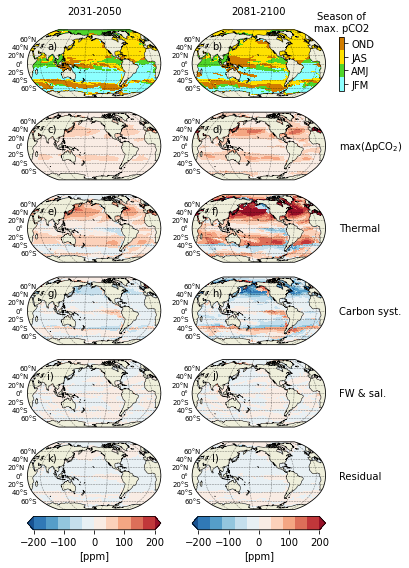

In [10]:
%%time 
print(datetime.datetime.now())
print('Maps of season of pCO2 max + taylor expansion: plot')

# Load data2plot
savedfile = dirout+'data2plot-maps-season-pco2max-taylor-expansion.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
        
#=========================================
# Parameters for data2plot
#=========================================

period_list = list(data2plot.keys())[:2]
maps_list = ['dpCO2', 'thermal', 'carbon', 'fw']
nperiod = len(period_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nmaps+2, nperiod
ccrsproj = ccrs.Robinson(central_longitude=-155)
fact = 2
fsize = (fact*cm2in*3*ncol, fact*cm2in*2*nrow)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, subplot_kw=dict(projection=ccrsproj))

value_names = {'pco2_sea':'Season of max pCO$_2$', \
               'dpCO2'   :'max($\Delta$pCO$_2$)', \
               'thermal' :'Thermal', \
               'carbon'  :'Carbon syst.', \
               'fw'      :'FW & sal.', \
               'res'     :'Residual'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Season
#---------------------

colors = np.array([[140/255, 255/255, 255/255, 1.00], 
                   [ 79/255, 214/255,  42/255, 1.00], 
                   [255/255, 225/255,   0/255, 1.00], 
                   [209/255, 125/255,   0/255, 1.00]] )
newcmap = ListedColormap(colors)
newcmap.set_over("white")
newcmap.set_under("white")
kwmap_seas = dict(transform=ccrs.PlateCarree(), vmin = .5, vmax = 4.5, cmap=newcmap)

#---------------------
# Taylor expansion
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmax = [200, 200, 300, 400]
kwmap_tayl   = dict(transform=ccrs.PlateCarree(), cmap=newcmap)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}


#=========================================
# PLOT
#=========================================

pcm2=[]
for iperiod, vperiod in enumerate(period_list): 


    irow = 0
    zax = ax[irow, iperiod]
    X = data2plot[vperiod]['pco2_sea']['X']
    Y = data2plot[vperiod]['pco2_sea']['Y']
    Z = data2plot[vperiod]['pco2_sea']['Z']
    pcm1 = zax.pcolormesh(X, Y, Z, **kwmap_seas)
    gl = add_gridlines_coastline_and_land(zax)
    
    for iii, vvv in enumerate(maps_list) : 
        zax = ax[iii+1, iperiod]
        X = data2plot[vperiod][vvv]['X']
        Y = data2plot[vperiod][vvv]['Y']
        Z = data2plot[vperiod][vvv]['Z']
        zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax[iperiod], vmax=vmax[iperiod], **kwmap_tayl)
        gl = add_gridlines_coastline_and_land(zax)
    #
    zax = ax[-1, iperiod]
    X = data2plot[vperiod]['dpCO2']['X']
    Y = data2plot[vperiod]['dpCO2']['Y']
    Z = data2plot[vperiod]['dpCO2']['Z'] - \
        data2plot[vperiod]['carbon']['Z'] - \
        data2plot[vperiod]['thermal']['Z'] -\
        data2plot[vperiod]['fw']['Z'] 
    zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax[iperiod], vmax=vmax[iperiod], **kwmap_tayl)
    gl = add_gridlines_coastline_and_land(zax)
    
    pcm2.append(zwpcm)

    
#
 
fig.tight_layout()

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

# repos vertical
for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + (irow+1)*.4*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
    #
#

    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right maps title
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iii, vvv in enumerate(maps_list) : 
    zw1 = ax[iii+1, -1].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, value_names[vvv], **kwtxt)
#
zw1 = ax[-1, -1].get_position()
ny0 = 0.5 *(zw1.y0+zw1.y1)
nx0 = zw1.x1 + .1*zw1.width
fig.text(nx0, ny0, value_names['res'], **kwtxt)


#---------------------
# At the top, period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for iii, vvv in enumerate(period_list): 
    zw1 = ax[0, iii].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vvv, **kwtxt)
#

#=========================================
# COLORBARS
#=========================================

hfrac, wfrac = .8, .2
zw1 = ax[0, -1].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0 + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm1, cax=cax, orientation='vertical', ticklocation='right',
                    ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(['JFM', 'AMJ', 'JAS', 'OND'])  # vertical colorbar
cax.set_title("Season of\nmax. pCO2", fontsize='medium')

for iii, vvv in enumerate(period_list): 
    zw = ax[-1, iii].get_position()
    nx0 = zw.x0
    ny0 = zw.y0-.3 * zw1.height
    nw = zw.width
    nh = .05*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm2[iii], cax=cax, orientation='horizontal', ticklocation='bottom', 
                        extend='both', label = '[ppm]')


fignam = 'maps-season-pco2max-taylor-expansion.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1min20s

# Maps of  season and year of ACOD with picontrol as reference for outgassing
- a, b) ACOD season, colorbar label: season of ACOD
- c, d) ACOD year, colorbar label: year of ACOD
- f) % of the ocean outgasing carbon versus time

## Load and prepare data2plot

### Inputs

In [21]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with picontrol as reference for outgassing')
print('Load and prepare data2plot')
print('Inputs')

# zfactmod = 3600*24*365/12*1000. # kgC/m2/s -> molC/m2/yr
simu_list  = ['ssp126', 'ssp585']
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
rolmean=50

#___________________________
# Masks
ocean_mask = xr.where(grid['pmask'].load()==0, False, True)
land_mask  = xr.where(grid['pmask'].load()==0, True, False)


2023-09-30 17:41:49.860725
Fig. 3: load and prepare data2plot
Inputs
CPU times: user 3.55 ms, sys: 908 µs, total: 4.46 ms
Wall time: 79.5 ms


### Maps

#### Compute ACOD for each month

In [82]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with picontrol as reference for outgassing')
print('Load and prepare data2plot')
print('Maps: compute ACOD for each month')

#----------------------
# Loop on simulations
#----------------------

for simu in simu_list: 

    print('> simu: '+simu)
    print(datetime.datetime.now())

    #___________________________
    # Load 50 year running means
    print('>> load 50 year running means and std...')
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> load 50 year running means and std for siconc...')
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas_siconc = pickle.load(f1)
    print("File loaded: "+savedfile)

    #___________________________
    # Load preindustrial cflux and compute a 50 year climatology
    print('>> load preindustrial cflux...')
    ncfile = dirout + 'cflx-tot_noresm2-lm_preindustrial.nc'
    zwdspi = xr.open_dataset(ncfile, chunks='auto', **kwopends)
    print('File loaded: '+ncfile)
    print('>> compute 50 year climatology...')
    zwpi = zwdspi['cflx-tot'][-12*50:].groupby('time.month').mean(dim='time')
    print('Done')
    
    #___________________________
    # Compute ACOD for each month
    print(">> For each month compute ACOD...")
    acod_monthly = []
    for imonth, month in enumerate(month_list, start=1):
        
        zwtot_avg = select_months(loadeddatas['cflx-tot']['avg'], imonth)
        zwtot_std = select_months(loadeddatas['cflx-tot']['std'], imonth)
        zwsic_avg = select_months(loadeddatas_siconc['siconc']['avg'], imonth)
        # ACOD for each month = minimal year for wich zwtot_avg - zwpi < - zwtot_std
        acod_monthly.append(zwtot_avg['time.year'].where( (zwtot_avg-zwpi.sel(month=imonth)<-zwtot_std) & (zwsic_avg<1) ).min(dim='time'))

    #
    print('Computation done')
    # create a xarray for acod_monthly
    print('>> Create an xarray...')
    acod_monthly = xr.concat(acod_monthly, pd.Index(month_list, name='month')).rename("acod_year")
    acod_monthly.attrs['description'] = 'For each month and each grid point, it is the first year when \
    the anthropogenic carbon outgassing is stronger than the interannual standard deviation of the total \
    air-sea CO2 flux. The anthopogenic carbon flux is the difference between the total and natural carbon \
    flux. The carbon fluxes are average on 50 years with a running mean. The interannual standard deviation\
    correspond to the standard deviation on these 150 years.'
    acod_monthly.attrs['units'] = 'year'
    acod_monthly.attrs['simulation'] = simu
    acod_monthly.attrs['model'] = 'NorESM2-LM'
    acod_monthly.attrs['input file'] = savedfile
    print('Done')
    
    # Save in a netcdf
    print('>> Save in a netcdf...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'-with-picontrol-for-ref.nc'
    acod_monthly.to_netcdf(netcdf_name)
    print('File saved: '+netcdf_name)
    
#

# ca. 4m30 

2023-09-30 18:15:22.827085
Fig. 3: load and prepare data2plot
Maps: compute ACOD for each month
> simu: ssp126
2023-09-30 18:15:22.827141
>> load 50 year running means and std...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load preindustrial cflux...
File loaded: cc2300-230215-noresm2-lm/cflx-tot_noresm2-lm_preindustrial.nc
>> compute 50 year climatology...
Done
>> For each month compute ACOD...
func: select_month(cflx-tot, jan)
func: select_month(cflx-tot, jan)
func: select_month(siconc, jan)
func: select_month(cflx-tot, feb)
func: select_month(cflx-tot, feb)
func: select_month(siconc, feb)
func: select_month(cflx-tot, mar)
func: select_month(cflx-tot, mar)
func: select_month(siconc, mar)
func: select_month(cflx-tot, apr)
func: select_month(cflx-tot, apr)
func: select_month(siconc, apr)
fun

/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 181.86 s
File saved: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126-with-picontrol-for-ref.nc
> simu: ssp585
2023-09-30 18:18:56.241308
>> load 50 year running means and std...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp585-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp585-noresm2-lm.pckl
>> load preindustrial cflux...
File loaded: cc2300-230215-noresm2-lm/cflx-tot_noresm2-lm_preindustrial.nc
>> compute 50 year climatology...
Done
>> For each month compute ACOD...
func: select_month(cflx-tot, jan)
func: select_month(cflx-tot, jan)
func: select_month(siconc, jan)
func: select_month(cflx-tot, feb)
func: select_month(cflx-tot, feb)
func: select_month(siconc, feb)
func: select_month(cflx-tot, mar)
func: select_month(cflx-tot, mar)
func: select_month(siconc, mar)
func: select_month(cflx-tot, apr)


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 186.71 s
File saved: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585-with-picontrol-for-ref.nc
CPU times: user 13min 49s, sys: 3min 23s, total: 17min 13s
Wall time: 7min 13s


#### Compute earliest year of outgassing, month of earliest outgassin and season

In [84]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with picontrol as reference for outgassing')
print('Load and prepare data2plot')
print('Maps: Compute earliest year of outgassing, \
      month of earliest outgassin and season')

data2plot = {}
for simu in simu_list: 
    
    print('> simu: '+simu)
    print(datetime.datetime.now())
    data2plot[simu] = {}
        
    
    #___________________________
    # Load netcdf acod-monthly
    print('>> Load netcdf acod-mont...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'-with-picontrol-for-ref.nc'
    acod_monthly = xr.open_dataset(netcdf_name, chunks='auto', **kwopends)['acod_year'] # chunks to use dask array
    print('File loaded: '+netcdf_name)
    
    #___________________________
    # Compute yACOD, earliest year of outgassing
    print('>> Compute yACOD, earliest year of outgassing...')
    yacod = acod_monthly.min(dim='month')
    zwnans = xr.apply_ufunc(np.isnan, yacod, dask='allowed')
    late_mask  = ocean_mask & zwnans
    yacod = xr.where(late_mask, 1e20, yacod)
    yacod = xr.where(land_mask, np.nan, yacod)
    print('Done')

    #___________________________
    # Compute mACOD, month of earliest outgassing
    print('>> Compute mACOD, month of earliest outgassing...')
    zwnans = xr.apply_ufunc(np.isnan, acod_monthly, dask='allowed')
    acod_monthly = xr.where(zwnans, 1e20, acod_monthly) # reaplce nan by very high value to get argmin
    macod = acod_monthly.argmin(dim='month')
    acod_monthly = xr.where(zwnans, np.nan, acod_monthly) # replace back 1e20 by nan
    macod = xr.where(land_mask, np.nan, macod)
    macod = xr.where(late_mask, 1e20, macod) # replace late values by 1e20
    print('Done')

    #___________________________
    # Compute sACOD, season of earliest outgassing

    print('>> Compute sACOD, season of earliest outgassing...')
    winter = xr.where((macod==0) | (macod==1)  | (macod==2) , True, False)
    spring = xr.where((macod==3) | (macod==4)  | (macod==5) , True, False)
    summer = xr.where((macod==6) | (macod==7)  | (macod==8) , True, False)
    autumn = xr.where((macod==9) | (macod==10) | (macod==11), True, False)
    sacod = xr.zeros_like(macod) + np.nan
    sacod = xr.where(winter, 1, np.nan)
    sacod = xr.where(spring, 2, sacod)
    sacod = xr.where(summer, 3, sacod)
    sacod = xr.where(autumn, 4, sacod)
    sacod = xr.where(late_mask, 1e20, sacod)  # replace late values by 1e20
    sacod = xr.where(land_mask, np.nan, sacod)
    print('Done')

    #___________________________
    # Store in data2plot
    print('>> Store in data2plot')
    Y, X = grid['plat'], grid['plon']
    data2plot[simu]['yACOD'] = {'X':X.values, 'Y':Y.values, 'Z':yacod.values}
    data2plot[simu]['sACOD'] = {'X':X.values, 'Y':Y.values, 'Z':sacod.values}
    
#

print('> Save data2plot in a pickle...')
savedfile = dirout+'data2plot-fig3-with-picontrol-for-ref.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)

# ca. 100ms

2023-09-30 18:24:08.886157
Fig. 3: load and prepare data2plot
Maps: Compute earliest year of outgassing,       month of earliest outgassin and season
> simu: ssp126
2023-09-30 18:24:08.886263
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126-with-picontrol-for-ref.nc
>> Compute yACOD, earliest year of outgassing...
Done
>> Compute mACOD, month of earliest outgassing...
Done
>> Compute sACOD, season of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


> simu: ssp585
2023-09-30 18:24:09.128312
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585-with-picontrol-for-ref.nc
>> Compute yACOD, earliest year of outgassing...
Done
>> Compute mACOD, month of earliest outgassing...
Done
>> Compute sACOD, season of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


> Save data2plot in a pickle...
File saved: cc2300-230215-noresm2-lm/data2plot-fig3-with-picontrol-for-ref.pckl
CPU times: user 148 ms, sys: 23.3 ms, total: 171 ms
Wall time: 489 ms


### Timeseries

In [80]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with picontrol as reference for outgassing')
print('Load and prepare data2plot')
print('timeseries')

tot_oarea = grid['parea'].sum(dim=('x', 'y'))

simu_list = ['ssp126', 'ssp585']
data2plot = {}
for simu in simu_list: 
    
    print('> simu')
    data2plot[simu] = {}
   
    # Load preindustrial cflux and compute a 50 year climatology
    print('>> load preindustrial cflux...')
    ncfile = dirout + 'cflx-tot_noresm2-lm_preindustrial.nc'
    zwdspi = xr.open_dataset(ncfile, chunks='auto', **kwopends)
    print('File loaded: '+ncfile)
    print('>> compute 50 year climatology...')
    zwpi = zwdspi['cflx-tot'][-12*50:].groupby('time.month').mean(dim='time').values
    print('Done')

    # Fraction of the ocean outgassing carbon each year
    print('>> Load  carbon fluxes...')
    zwtot = load_and_concat_hist_ssp('cflx-tot', simu)
    zwsic = load_and_concat_hist_ssp('siconc', simu)
    print('Done')
    zwpi2 = xr.ones_like(zwtot)
    aaa=[]
    nby = zwtot['time.year'].max().values - zwtot['time.year'].min().values +1
    for yyy in range(nby): aaa.extend(zwpi)
    zwpi2.values = np.array(aaa)
    print('>> Compute fraction of the ocean outgassing carbon each year...')
    # if anth cflux < 0 i.e. outgassing put 1, 0 otherwise
    zw2 = xr.where( (zwtot-zwpi2<0) & (zwsic<1), 1, 0)
    zw3 = zw2.groupby('time.year').sum(dim='time') # sum over year
    # if zw3=0, no outgassing anytime of the year so zw4=0, if zw3>0 then outgassing at least one month so zw4=1
    zw4 = xr.where(zw3 > 0, 1, 0) 
    zw5 = zw4*grid['parea'] # multiply by ocean cell area to get surface outgassing
    # compute percent of ocean area outgassing at least one month of the year
    frac_oarea_outgas = zw4.weighted(grid['parea']).sum(dim=('x', 'y')) / tot_oarea * 100 
    print('Done')
    
    data2plot[simu]['frac_oarea_outgas'] = {
        'X':frac_oarea_outgas['year'].values, 
        'Y':frac_oarea_outgas.values
    }

    # Fraction of the ocean where outgassing carbon emerge each year
    print('>> Load averaged carbon fluxes...')
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> load 50 year running means and std for siconc...')
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas_siconc = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> Compute fraction of the ocean where outgassing carbon emerge each year')
    zwtot_avg = loadeddatas['cflx-tot']['avg']
    zwtot_std = loadeddatas['cflx-tot']['std']
    zwsic_avg = loadeddatas_siconc['siconc']['avg']
    # if anth cflux avg < - tot std i.e. outgassing put 1, 0 otherwise
    zw2 = xr.where( (zwtot_avg-zwpi2<-zwtot_std) & (zwsic_avg<1), 1, 0)
    # sum over year
    zw3 = zw2.groupby('time.year').sum(dim='time')
    # if zw3=0, no outgassing anytime of the year so zw4=0, if zw3>0 then outgassing at least one month so zw4=1
    zw4 = xr.where(zw3 > 0, 1, 0)
    zw5 = zw4*grid['parea'] # multiply by ocean cell area to get surface outgassing
    # compute percent of ocean area outgassing at least one month of the year
    frac_oarea_outgas_emerge = zw4.weighted(grid['parea']).sum(dim=('x', 'y')) / tot_oarea * 100
    print('Done')
    
    data2plot[simu]['frac_oarea_outgas_emerge'] = {
        'X':frac_oarea_outgas_emerge['year'].values, 
        'Y':frac_oarea_outgas_emerge.values
    }
    # replace 25 first and last year by nans
    data2plot[simu]['frac_oarea_outgas_emerge']['Y'][-24:] = np.nan
    data2plot[simu]['frac_oarea_outgas_emerge']['Y'][:24]  = np.nan

#

print('> save file')
savedfile = dirout+'data2plot-fig3-timeseries-with-picontrol-for-ref.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)

# ca. 5m

2023-09-30 18:02:56.929739
Fig. 3: load and prepare data2plot
timeseries
> simu
>> load preindustrial cflux...
File loaded: cc2300-230215-noresm2-lm/cflx-tot_noresm2-lm_preindustrial.nc
>> compute 50 year climatology...
Done
>> Load  carbon fluxes...
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
Done
>> Compute fraction of the ocean outgassing carbon each year...
Done
[########################################] | 100% Completed | 6.76 s
>> Load averaged carbon fluxes...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2

## Plot

2023-10-01 15:45:04.965310
Fig. 3: plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-3-with-picontrol-for-ref.png
CPU times: user 17.8 s, sys: 2.16 s, total: 20 s
Wall time: 17.6 s


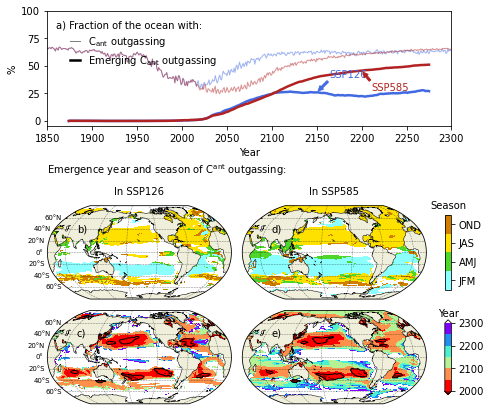

In [132]:
%%time 
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with picontrol as reference for outgassing')
print('Plot')

# Load data2plot
savedfile = dirout+'data2plot-fig3-with-picontrol-for-ref.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
# Load detectable
savedfile = dirout+'data2plot-fig3-timeseries-with-picontrol-for-ref.pckl'
with open(savedfile, 'rb') as f1: data2plot_ts = pickle.load(f1)
        
simu_list = ['ssp126', 'ssp585']

#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 3, 2
ccrsproj = ccrs.Robinson(central_longitude=-155)
#fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), squeeze=False, subplot_kw=dict(projection=ccrsproj))
fsize = (16*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#---------------------
# PLOTTING KWARGS
#---------------------

from matplotlib import cm
from matplotlib.colors import ListedColormap

# kwmap_year
a = cm.get_cmap('rainbow_r',64)
colors = a(np.linspace(0,1,6))
newcmap = ListedColormap(colors)
newcmap.set_over("white")
newcmap.set_under("darkred")
kwmap_year = dict(transform=ccrs.PlateCarree(), vmin = 2000, vmax = 2300, cmap=newcmap)

# kwmap_seas
colors = np.array([[140/255, 255/255, 255/255, 1.00], 
                   [ 79/255, 214/255,  42/255, 1.00], 
                   [255/255, 225/255,   0/255, 1.00], 
                   [209/255, 125/255,   0/255, 1.00]] )
newcmap = ListedColormap(colors)
newcmap.set_over("white")
kwmap_seas = dict(transform=ccrs.PlateCarree(), vmin = .5, vmax = 4.5, cmap=newcmap)

# kwline_ts
kwline_ts = {
    'ssp126'      : dict(c='royalblue'), 
    'ssp585'      : dict(c='firebrick')
} 

#---------------------
# Plot timeseries area emerged
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

for simu in simu_list:
    X = data2plot_ts[simu]['frac_oarea_outgas']['X']
    Y = data2plot_ts[simu]['frac_oarea_outgas']['Y']
    #ll, = zax.plot(X, Y, label=simu.upper()+', C$_{ant} outgassing$', ls='-', lw=1., alpha=.5, **kwline_ts[simu])
    ll, = zax.plot(X, Y, ls='-', lw=1., alpha=.5, **kwline_ts[simu])
    ll1, = zax.plot(X, Y*np.nan, label='C$_{\mathrm{ant}}$ outgassing', ls='-', lw=1., alpha=.5, c='black')
    X = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X']
    Y = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y']
    # ll, = zax.plot(X, Y, label=simu.upper()+', emerging C$_{ant} outgassing$', ls='-', lw=2.5, **kwline_ts[simu])
    ll, = zax.plot(X, Y, ls='-', lw=2.5, **kwline_ts[simu])
    ll2, = zax.plot(X, Y*np.nan, label='Emerging C$_{\mathrm{ant}}$ outgassing', ls='-', lw=2.5, c='black')
#
legkwargs={
    'title': subnum.pop()+r') Fraction of the ocean with:         ',
    'frameon': False,
    'handlelength': 1.0,
    'loc':'upper left'
}
zax.legend(handles=[ll1, ll2], **legkwargs)
#zax.set_title()
zax.set_ylabel('%')
zax.set_xlabel('Year')
zax.set_xlim(1850, 2300)
zax.set_ylim(-5, 100)

simu='ssp126'
zwx = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X'][-150]
zwy = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y'][-150]
zax.annotate('SSP126', (zwx, zwy), (13, 15), textcoords='offset points', \
             color=kwline_ts[simu]['c'], \
             arrowprops=dict(arrowstyle='simple',shrinkA=0, \
                             relpos=(0, 0), color=kwline_ts[simu]['c']))

simu='ssp585'
zwx = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X'][-100]
zwy = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y'][-100]
zax.annotate('SSP585', (zwx, zwy), (10, -20), textcoords='offset points', \
             color=kwline_ts[simu]['c'], \
             arrowprops=dict(arrowstyle='simple',shrinkA=0, \
                             relpos=(0, 1), color=kwline_ts[simu]['c']))

#---------------------
# Plot maps
#---------------------

iplot = 3
for isimu, vsimu in enumerate(simu_list): 
    fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    iplot+=1
    fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    iplot+=1
#

for isimu, vsimu in enumerate(simu_list): 

    # sACOD
    #zax = fig.add_subplot(nrow, ncol, 1, projection=ccrsproj)
    zax = fig.axes[isimu+1]
    X = data2plot[vsimu]['sACOD']['X']
    Y = data2plot[vsimu]['sACOD']['Y']
    Z = data2plot[vsimu]['sACOD']['Z']
    pcm1 = zax.pcolormesh(X, Y, Z, **kwmap_seas)
    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ')'
    zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')
    
    # yACOD
    #zax = fig.add_subplot(nrow, ncol, 3, projection=ccrsproj)
    zax = fig.axes[isimu+1+2]
    X = data2plot[vsimu]['yACOD']['X']
    Y = data2plot[vsimu]['yACOD']['Y']
    Z = data2plot[vsimu]['yACOD']['Z']
    pcm2 = zax.pcolormesh(X, Y, Z, **kwmap_year)

    # yACOD = 2030
    zwX = data2plot[vsimu]['yACOD']['X']
    zwY = data2plot[vsimu]['yACOD']['Y']
    zwZ = data2plot[vsimu]['yACOD']['Z']
    grid_in  = {'lon':zwX, 'lat':zwY}
    ds_out = xe.util.grid_global(1, 1)
    regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, reuse_weights=False)
    Z1 = regridder(zwZ)
    X1, Y1 = ds_out['lon'], ds_out['lat']
    cl = zax.contour(X1, Y1, Z1, levels = [2030], linewidths=1., linestyles='-', colors='k', transform=ccrs.PlateCarree())

    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ')'
    zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

#

#---------------------
# Repositionning maps axes
#---------------------

fig.tight_layout()

#_____________________
# Lower 1st row of map
for zax in fig.axes[1:3]: 
    zw1 = zax.get_position()
    nw  = zw1.width
    nh  = zw1.height
    nx0 = zw1.x0
    ny0 = zw1.y0 - 0.3*zw1.height
    zax.axes.set_position([nx0, ny0, nw, nh])
# 
#_____________________
# lift 2nd row of  map
for zax in fig.axes[3:5]: 
    zw1 = zax.get_position()
    nw  = zw1.width
    nh  = zw1.height
    nx0 = zw1.x0
    ny0 = zw1.y0 + 0.4*zw1.height
    zax.axes.set_position([nx0, ny0, nw, nh])
# 



#---------------------
# Colorbar
#---------------------

hfrac, wfrac = .8, .1

zw1 = fig.axes[2].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0 + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm1, cax=cax, orientation='vertical', ticklocation='right',
                    ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(['JFM', 'AMJ', 'JAS', 'OND'])  # vertical colorbar
cax.set_title("Season", fontsize='medium')

zw1 = fig.axes[4].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0  + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm2, cax=cax, orientation='vertical', ticklocation='right', 
                    extend='both')
cax.set_title("Year", fontsize='medium')

#---------------------
# Extra text
#---------------------

# kwtxt = dict(fontsize='large', rotation='horizontal', ha='center', va='bottom')
kwtxt = {"ha": 'left', "va":'bottom'}

zw1 = fig.axes[1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .3*zw1.height
fig.text(nx0, ny0, 'Emergence year and season of C$^{\mathrm{ant}}$ outgassing: ', **kwtxt)

kwtxt = {"ha": 'center', "va":'bottom'}
zw1 = fig.axes[1].get_position()
nx0 = 0.5 *(zw1.x0 + zw1.x1)
ny0 = zw1.y1 + .1*zw1.height
fig.text(nx0, ny0, 'In SSP126', **kwtxt)

zw1 = fig.axes[2].get_position()
nx0 = 0.5 *(zw1.x0+zw1.x1)
fig.text(nx0, ny0, 'In SSP585', **kwtxt)

#---------------------
# Repositionning time series axes
#---------------------

zw1 = fig.axes[1].get_position()
zw2 = fig.axes[-1].get_position()
zw3 = fig.axes[0].get_position()

nx0 = zw1.x0
nw = zw2.x1 - nx0
ny0 = zw3.y0
nh = 0.8*zw3.height
fig.axes[0].axes.set_position([nx0, ny0, nw, nh])

#---------------------
# Save figure
#---------------------

fignam = 'fig-3-with-picontrol-for-ref.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 17s

# Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold
- a, b) ACOD season, colorbar label: season of ACOD
- c, d) ACOD year, colorbar label: year of ACOD
- f) % of the ocean outgasing carbon versus time

## Load and prepare data2plot

### Inputs

In [86]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold')
print('Load and prepare data2plot')
print('Inputs')

# zfactmod = 3600*24*365/12*1000. # kgC/m2/s -> molC/m2/yr
simu_list  = ['ssp126', 'ssp585']
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
rolmean=50

#___________________________
# Masks
ocean_mask = xr.where(grid['pmask'].load()==0, False, True)
land_mask  = xr.where(grid['pmask'].load()==0, True, False)


2023-10-01 15:07:08.396429
Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold
Load and prepare data2plot
Inputs
CPU times: user 1.35 ms, sys: 1.11 ms, total: 2.46 ms
Wall time: 1.78 ms


### Maps

#### Compute ACOD for each month

In [129]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold')
print('Load and prepare data2plot')
print('Maps: compute ACOD for each month')

#----------------------
# Loop on simulations
#----------------------

for simu in simu_list: 

    print('> simu: '+simu)
    print(datetime.datetime.now())

    #___________________________
    # Load 50 year running means
    print('>> load 50 year running means and std...')
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> load 50 year running means and std for siconc...')
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas_siconc = pickle.load(f1)
    print("File loaded: "+savedfile)
    
    #___________________________
    # Load preindustrial cflux and compute a 50 year yearly std
    print('>> load preindustrial cflux...')
    ncfile = dirout + 'cflx-tot_noresm2-lm_preindustrial.nc'
    zwdspi = xr.open_dataset(ncfile, chunks='auto', **kwopends)
    print('File loaded: '+ncfile)
    print('>> compute 50 year yearly std...')
    zwpistd = zwdspi['cflx-tot'][-12*50:].groupby('time.year').mean(dim='time').std(dim='year').mean(dim=('y', 'x')).values
    print('Done')

    #___________________________
    # Compute ACOD for each month
    print(">> For each month compute ACOD...")
    acod_monthly = []
    for imonth, month in enumerate(month_list, start=1):
        
        zwtot_avg = select_months(loadeddatas['cflx-tot']['avg'], imonth)
        zwnat_avg = select_months(loadeddatas['cflx-nat']['avg'], imonth)
        zwsic_avg = select_months(loadeddatas_siconc['siconc']['avg'], imonth)
        # ACOD for each month = minimal year for wich zwtot_avg - zwnat_avg < - zwtot_std
        acod_monthly.append(zwtot_avg['time.year'].where( (zwtot_avg-zwnat_avg<-zwpistd) & (zwsic_avg<1) ).min(dim='time'))

    #
    print('Computation done')
    # create a xarray for acod_monthly
    print('>> Create an xarray...')
    acod_monthly = xr.concat(acod_monthly, pd.Index(month_list, name='month')).rename("acod_year")
    acod_monthly.attrs['description'] = 'For each month and each grid point, it is the first year when \
    the anthropogenic carbon outgassing is stronger than the interannual standard deviation of the total \
    air-sea CO2 flux. The anthopogenic carbon flux is the difference between the total and natural carbon \
    flux. The carbon fluxes are average on 50 years with a running mean. The interannual standard deviation\
    correspond to the standard deviation on these 150 years.'
    acod_monthly.attrs['units'] = 'year'
    acod_monthly.attrs['simulation'] = simu
    acod_monthly.attrs['model'] = 'NorESM2-LM'
    acod_monthly.attrs['input file'] = savedfile
    print('Done')
    
    # Save in a netcdf
    print('>> Save in a netcdf...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'-with-fixed-std-for-emergence-treshold.nc'
    acod_monthly.to_netcdf(netcdf_name)
    print('File saved: '+netcdf_name)
    
#

# ca. 4m30 

2023-10-01 15:30:19.140042
Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold
Load and prepare data2plot
Maps: compute ACOD for each month
> simu: ssp126
2023-10-01 15:30:19.140092
>> load 50 year running means and std...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp126-noresm2-lm.pckl
>> load preindustrial cflux...
File loaded: cc2300-230215-noresm2-lm/cflx-tot_noresm2-lm_preindustrial.nc
>> compute 50 year yearly std...
Done
>> For each month compute ACOD...
func: select_month(cflx-tot, jan)
func: select_month(cflx-nat, jan)
func: select_month(siconc, jan)
func: select_month(cflx-tot, feb)
func: select_month(cflx-nat, feb)
func: select_month(siconc, feb)
func: select_month(cflx-tot, mar)
func: select_month(cflx-nat, mar)
func: select_month(siconc, mar)
func: select_month(cflx-to

/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 72.83 s
File saved: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126-with-fixed-std-for-emergence-treshold.nc
> simu: ssp585
2023-10-01 15:31:48.023729
>> load 50 year running means and std...
File loaded: cc2300-230215-noresm2-lm/cflxtot-cflxnat-running-mean-std-50y-ssp585-noresm2-lm.pckl
>> load 50 year running means and std for siconc...
File loaded: cc2300-230215-noresm2-lm/siconc-running-mean-std-50y-ssp585-noresm2-lm.pckl
>> load preindustrial cflux...
File loaded: cc2300-230215-noresm2-lm/cflx-tot_noresm2-lm_preindustrial.nc
>> compute 50 year yearly std...
Done
>> For each month compute ACOD...
func: select_month(cflx-tot, jan)
func: select_month(cflx-nat, jan)
func: select_month(siconc, jan)
func: select_month(cflx-tot, feb)
func: select_month(cflx-nat, feb)
func: select_month(siconc, feb)
func: select_month(cflx-tot, mar)
func: select_month(cflx-nat, mar)
func: select_month(siconc, mar)
func: select_month(cf

/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 72.67 s
File saved: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585-with-fixed-std-for-emergence-treshold.nc
CPU times: user 5min 26s, sys: 37 s, total: 6min 3s
Wall time: 2min 56s


#### Compute earliest year of outgassing, month of earliest outgassin and season

In [130]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold')
print('Load and prepare data2plot')
print('Maps: Compute earliest year of outgassing, \
      month of earliest outgassin and season')

data2plot = {}
for simu in simu_list: 
    
    print('> simu: '+simu)
    print(datetime.datetime.now())
    data2plot[simu] = {}
        
    
    #___________________________
    # Load netcdf acod-monthly
    print('>> Load netcdf acod-mont...')
    netcdf_name = dirout + 'acod-monthly_noresm2-lm_'+simu+'-with-fixed-std-for-emergence-treshold.nc'
    acod_monthly = xr.open_dataset(netcdf_name, chunks='auto', **kwopends)['acod_year'] # chunks to use dask array
    print('File loaded: '+netcdf_name)
    
    #___________________________
    # Compute yACOD, earliest year of outgassing
    print('>> Compute yACOD, earliest year of outgassing...')
    yacod = acod_monthly.min(dim='month')
    zwnans = xr.apply_ufunc(np.isnan, yacod, dask='allowed')
    late_mask  = ocean_mask & zwnans
    yacod = xr.where(late_mask, 1e20, yacod)
    yacod = xr.where(land_mask, np.nan, yacod)
    print('Done')

    #___________________________
    # Compute mACOD, month of earliest outgassing
    print('>> Compute mACOD, month of earliest outgassing...')
    zwnans = xr.apply_ufunc(np.isnan, acod_monthly, dask='allowed')
    acod_monthly = xr.where(zwnans, 1e20, acod_monthly) # reaplce nan by very high value to get argmin
    macod = acod_monthly.argmin(dim='month')
    acod_monthly = xr.where(zwnans, np.nan, acod_monthly) # replace back 1e20 by nan
    macod = xr.where(land_mask, np.nan, macod)
    macod = xr.where(late_mask, 1e20, macod) # replace late values by 1e20
    print('Done')

    #___________________________
    # Compute sACOD, season of earliest outgassing

    print('>> Compute sACOD, season of earliest outgassing...')
    winter = xr.where((macod==0) | (macod==1)  | (macod==2) , True, False)
    spring = xr.where((macod==3) | (macod==4)  | (macod==5) , True, False)
    summer = xr.where((macod==6) | (macod==7)  | (macod==8) , True, False)
    autumn = xr.where((macod==9) | (macod==10) | (macod==11), True, False)
    sacod = xr.zeros_like(macod) + np.nan
    sacod = xr.where(winter, 1, np.nan)
    sacod = xr.where(spring, 2, sacod)
    sacod = xr.where(summer, 3, sacod)
    sacod = xr.where(autumn, 4, sacod)
    sacod = xr.where(late_mask, 1e20, sacod)  # replace late values by 1e20
    sacod = xr.where(land_mask, np.nan, sacod)
    print('Done')

    #___________________________
    # Store in data2plot
    print('>> Store in data2plot')
    Y, X = grid['plat'], grid['plon']
    data2plot[simu]['yACOD'] = {'X':X.values, 'Y':Y.values, 'Z':yacod.values}
    data2plot[simu]['sACOD'] = {'X':X.values, 'Y':Y.values, 'Z':sacod.values}
    
#

print('> Save data2plot in a pickle...')
savedfile = dirout+'data2plot-fig3-with-fixed-std-for-emergence-treshold.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)

# ca. 100ms

2023-10-01 15:38:59.815995
Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold
Load and prepare data2plot
Maps: Compute earliest year of outgassing,       month of earliest outgassin and season
> simu: ssp126
2023-10-01 15:38:59.816286
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp126-with-fixed-std-for-emergence-treshold.nc
>> Compute yACOD, earliest year of outgassing...
Done
>> Compute mACOD, month of earliest outgassing...
Done
>> Compute sACOD, season of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


> simu: ssp585
2023-10-01 15:39:00.142198
>> Load netcdf acod-mont...
File loaded: cc2300-230215-noresm2-lm/acod-monthly_noresm2-lm_ssp585-with-fixed-std-for-emergence-treshold.nc
>> Compute yACOD, earliest year of outgassing...
Done
>> Compute mACOD, month of earliest outgassing...
Done
>> Compute sACOD, season of earliest outgassing...
Done
>> Store in data2plot


/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


> Save data2plot in a pickle...
File saved: cc2300-230215-noresm2-lm/data2plot-fig3-with-fixed-std-for-emergence-treshold.pckl
CPU times: user 207 ms, sys: 20.8 ms, total: 228 ms
Wall time: 571 ms


### Timeseries

In [131]:
%%time
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold')
print('Load and prepare data2plot')
print('timeseries')

tot_oarea = grid['parea'].sum(dim=('x', 'y'))

simu_list = ['ssp126', 'ssp585']
data2plot = {}
for simu in simu_list: 
    
    print('> simu')
    data2plot[simu] = {}
   

    #___________________________
    # Fraction of the ocean outgassing carbon each year
    print('>> Load  carbon fluxes...')
    zwtot = load_and_concat_hist_ssp('cflx-tot', simu)
    zwnat = load_and_concat_hist_ssp('cflx-nat', simu)
    zwsic = load_and_concat_hist_ssp('siconc', simu)
    print('Done')
    print('>> Compute fraction of the ocean outgassing carbon each year...')
    # if anth cflux < 0 i.e. outgassing put 1, 0 otherwise
    zw2 = xr.where( (zwtot-zwnat<0) & (zwsic<1), 1, 0)
    zw3 = zw2.groupby('time.year').sum(dim='time') # sum over year
    # if zw3=0, no outgassing anytime of the year so zw4=0, if zw3>0 then outgassing at least one month so zw4=1
    zw4 = xr.where(zw3 > 0, 1, 0) 
    zw5 = zw4*grid['parea'] # multiply by ocean cell area to get surface outgassing
    # compute percent of ocean area outgassing at least one month of the year
    frac_oarea_outgas = zw4.weighted(grid['parea']).sum(dim=('x', 'y')) / tot_oarea * 100 
    print('Done')
    
    data2plot[simu]['frac_oarea_outgas'] = {
        'X':frac_oarea_outgas['year'].values, 
        'Y':frac_oarea_outgas.values
    }

    #___________________________
    # Load preindustrial cflux and compute a 50 year yearly std
    print('>> load preindustrial cflux...')
    ncfile = dirout + 'cflx-tot_noresm2-lm_preindustrial.nc'
    zwdspi = xr.open_dataset(ncfile, chunks='auto', **kwopends)
    print('File loaded: '+ncfile)
    print('>> compute 50 year yearly std...')
    zwpistd = zwdspi['cflx-tot'][-12*50:].groupby('time.year').mean(dim='time').std(dim='year').mean(dim=('y', 'x')).values
    print('Done')

    #___________________________
    # Fraction of the ocean where outgassing carbon emerge each year
    print('>> Load averaged carbon fluxes...')
    savedfile = dirout+'cflxtot-cflxnat-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> load 50 year running means and std for siconc...')
    savedfile = dirout+'siconc-running-mean-std-'+str(rolmean)+'y-'+simu+'-noresm2-lm.pckl'
    with open(savedfile, 'rb') as f1: loadeddatas_siconc = pickle.load(f1)
    print("File loaded: "+savedfile)
    print('>> Compute fraction of the ocean where outgassing carbon emerge each year')
    zwtot_avg = loadeddatas['cflx-tot']['avg']
    zwnat_avg = loadeddatas['cflx-nat']['avg']
    zwsic_avg = loadeddatas_siconc['siconc']['avg']
    # if anth cflux avg < - tot std i.e. outgassing put 1, 0 otherwise
    zw2 = xr.where( (zwtot_avg-zwnat_avg<-zwpistd) & (zwsic_avg<1), 1, 0)
    # sum over year
    zw3 = zw2.groupby('time.year').sum(dim='time')
    # if zw3=0, no outgassing anytime of the year so zw4=0, if zw3>0 then outgassing at least one month so zw4=1
    zw4 = xr.where(zw3 > 0, 1, 0)
    zw5 = zw4*grid['parea'] # multiply by ocean cell area to get surface outgassing
    # compute percent of ocean area outgassing at least one month of the year
    frac_oarea_outgas_emerge = zw4.weighted(grid['parea']).sum(dim=('x', 'y')) / tot_oarea * 100
    print('Done')
        
    data2plot[simu]['frac_oarea_outgas_emerge'] = {
        'X':frac_oarea_outgas_emerge['year'].values, 
        'Y':frac_oarea_outgas_emerge.values
    }
    # replace 25 first and last year by nans
    data2plot[simu]['frac_oarea_outgas_emerge']['Y'][-24:] = np.nan
    data2plot[simu]['frac_oarea_outgas_emerge']['Y'][:24]  = np.nan

#

print('> save file')
savedfile = dirout+'data2plot-fig3-timeseries-with-fixed-std-for-emergence-treshold.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)

# ca. 5m

2023-10-01 15:41:27.286290
Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold
Load and prepare data2plot
timeseries
> simu
>> Load  carbon fluxes...
func: load_and_concat_hist_ssp(cflx-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(cflx-nat, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(siconc, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
Done
>> Compute fraction of the ocean outgassing carbon each year...
Done
[########################################] | 100% Completed | 7.89 s
>> load preindustrial cflux...
File loaded: cc2300-230215-noresm2-lm/cflx-tot_noresm2-lm_p

## Plot

2023-10-01 15:46:20.158907
Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold
Plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: fig-3-with-fixed-std-for-emergence-treshold.png
CPU times: user 17.8 s, sys: 1.97 s, total: 19.7 s
Wall time: 17.5 s


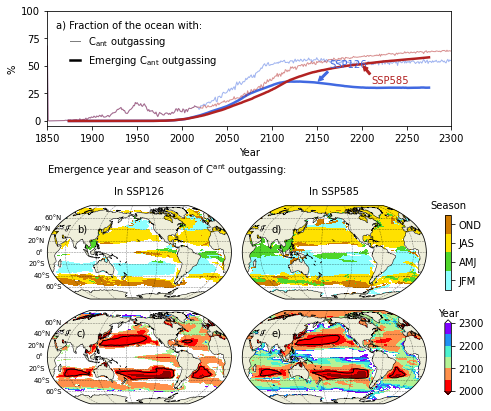

In [134]:
%%time 
print(datetime.datetime.now())
print('Maps of  season and year of ACOD with fixed satndard deviation fro emergence treshold')
print('Plot')

# Load data2plot
savedfile = dirout+'data2plot-fig3-with-fixed-std-for-emergence-treshold.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
# Load detectable
savedfile = dirout+'data2plot-fig3-timeseries-with-fixed-std-for-emergence-treshold.pckl'
with open(savedfile, 'rb') as f1: data2plot_ts = pickle.load(f1)
        
simu_list = ['ssp126', 'ssp585']

#---------------------
# FIGURE PARAM
#---------------------

nrow, ncol = 3, 2
ccrsproj = ccrs.Robinson(central_longitude=-155)
#fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), squeeze=False, subplot_kw=dict(projection=ccrsproj))
fsize = (16*cm2in, 18*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#---------------------
# PLOTTING KWARGS
#---------------------

from matplotlib import cm
from matplotlib.colors import ListedColormap

# kwmap_year
a = cm.get_cmap('rainbow_r',64)
colors = a(np.linspace(0,1,6))
newcmap = ListedColormap(colors)
newcmap.set_over("white")
newcmap.set_under("darkred")
kwmap_year = dict(transform=ccrs.PlateCarree(), vmin = 2000, vmax = 2300, cmap=newcmap)

# kwmap_seas
colors = np.array([[140/255, 255/255, 255/255, 1.00], 
                   [ 79/255, 214/255,  42/255, 1.00], 
                   [255/255, 225/255,   0/255, 1.00], 
                   [209/255, 125/255,   0/255, 1.00]] )
newcmap = ListedColormap(colors)
newcmap.set_over("white")
kwmap_seas = dict(transform=ccrs.PlateCarree(), vmin = .5, vmax = 4.5, cmap=newcmap)

# kwline_ts
kwline_ts = {
    'ssp126'      : dict(c='royalblue'), 
    'ssp585'      : dict(c='firebrick')
} 

#---------------------
# Plot timeseries area emerged
#---------------------

zax = fig.add_subplot(nrow, 1, 1)

for simu in simu_list:
    X = data2plot_ts[simu]['frac_oarea_outgas']['X']
    Y = data2plot_ts[simu]['frac_oarea_outgas']['Y']
    #ll, = zax.plot(X, Y, label=simu.upper()+', C$_{ant} outgassing$', ls='-', lw=1., alpha=.5, **kwline_ts[simu])
    ll, = zax.plot(X, Y, ls='-', lw=1., alpha=.5, **kwline_ts[simu])
    ll1, = zax.plot(X, Y*np.nan, label='C$_{\mathrm{ant}}$ outgassing', ls='-', lw=1., alpha=.5, c='black')
    X = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X']
    Y = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y']
    # ll, = zax.plot(X, Y, label=simu.upper()+', emerging C$_{ant} outgassing$', ls='-', lw=2.5, **kwline_ts[simu])
    ll, = zax.plot(X, Y, ls='-', lw=2.5, **kwline_ts[simu])
    ll2, = zax.plot(X, Y*np.nan, label='Emerging C$_{\mathrm{ant}}$ outgassing', ls='-', lw=2.5, c='black')
#
legkwargs={
    'title': subnum.pop()+r') Fraction of the ocean with:         ',
    'frameon': False,
    'handlelength': 1.0,
    'loc':'upper left'
}
zax.legend(handles=[ll1, ll2], **legkwargs)
#zax.set_title()
zax.set_ylabel('%')
zax.set_xlabel('Year')
zax.set_xlim(1850, 2300)
zax.set_ylim(-5, 100)

simu='ssp126'
zwx = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X'][-150]
zwy = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y'][-150]
zax.annotate('SSP126', (zwx, zwy), (13, 15), textcoords='offset points', \
             color=kwline_ts[simu]['c'], \
             arrowprops=dict(arrowstyle='simple',shrinkA=0, \
                             relpos=(0, 0), color=kwline_ts[simu]['c']))

simu='ssp585'
zwx = data2plot_ts[simu]['frac_oarea_outgas_emerge']['X'][-100]
zwy = data2plot_ts[simu]['frac_oarea_outgas_emerge']['Y'][-100]
zax.annotate('SSP585', (zwx, zwy), (10, -20), textcoords='offset points', \
             color=kwline_ts[simu]['c'], \
             arrowprops=dict(arrowstyle='simple',shrinkA=0, \
                             relpos=(0, 1), color=kwline_ts[simu]['c']))

#---------------------
# Plot maps
#---------------------

iplot = 3
for isimu, vsimu in enumerate(simu_list): 
    fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    iplot+=1
    fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
    iplot+=1
#

for isimu, vsimu in enumerate(simu_list): 

    # sACOD
    #zax = fig.add_subplot(nrow, ncol, 1, projection=ccrsproj)
    zax = fig.axes[isimu+1]
    X = data2plot[vsimu]['sACOD']['X']
    Y = data2plot[vsimu]['sACOD']['Y']
    Z = data2plot[vsimu]['sACOD']['Z']
    pcm1 = zax.pcolormesh(X, Y, Z, **kwmap_seas)
    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ')'
    zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')
    
    # yACOD
    #zax = fig.add_subplot(nrow, ncol, 3, projection=ccrsproj)
    zax = fig.axes[isimu+1+2]
    X = data2plot[vsimu]['yACOD']['X']
    Y = data2plot[vsimu]['yACOD']['Y']
    Z = data2plot[vsimu]['yACOD']['Z']
    pcm2 = zax.pcolormesh(X, Y, Z, **kwmap_year)

    # yACOD = 2030
    zwX = data2plot[vsimu]['yACOD']['X']
    zwY = data2plot[vsimu]['yACOD']['Y']
    zwZ = data2plot[vsimu]['yACOD']['Z']
    grid_in  = {'lon':zwX, 'lat':zwY}
    ds_out = xe.util.grid_global(1, 1)
    regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, reuse_weights=False)
    Z1 = regridder(zwZ)
    X1, Y1 = ds_out['lon'], ds_out['lat']
    cl = zax.contour(X1, Y1, Z1, levels = [2030], linewidths=1., linestyles='-', colors='k', transform=ccrs.PlateCarree())

    gl = add_gridlines_coastline_and_land(zax)
    if isimu==1: gl.left_labels=False
    zwtitle = subnum.pop() + ')'
    zax.annotate(zwtitle, (0.16, 0.72),xycoords='axes fraction')

#

#---------------------
# Repositionning maps axes
#---------------------

fig.tight_layout()

#_____________________
# Lower 1st row of map
for zax in fig.axes[1:3]: 
    zw1 = zax.get_position()
    nw  = zw1.width
    nh  = zw1.height
    nx0 = zw1.x0
    ny0 = zw1.y0 - 0.3*zw1.height
    zax.axes.set_position([nx0, ny0, nw, nh])
# 
#_____________________
# lift 2nd row of  map
for zax in fig.axes[3:5]: 
    zw1 = zax.get_position()
    nw  = zw1.width
    nh  = zw1.height
    nx0 = zw1.x0
    ny0 = zw1.y0 + 0.4*zw1.height
    zax.axes.set_position([nx0, ny0, nw, nh])
# 



#---------------------
# Colorbar
#---------------------

hfrac, wfrac = .8, .1

zw1 = fig.axes[2].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0 + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm1, cax=cax, orientation='vertical', ticklocation='right',
                    ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(['JFM', 'AMJ', 'JAS', 'OND'])  # vertical colorbar
cax.set_title("Season", fontsize='medium')

zw1 = fig.axes[4].get_position()
nx0 = zw1.x1 + .1*zw1.width
ny0 = zw1.y0  + (1-hfrac)/2*zw1.height
nh  = hfrac*zw1.height
nw  = wfrac*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm2, cax=cax, orientation='vertical', ticklocation='right', 
                    extend='both')
cax.set_title("Year", fontsize='medium')

#---------------------
# Extra text
#---------------------

# kwtxt = dict(fontsize='large', rotation='horizontal', ha='center', va='bottom')
kwtxt = {"ha": 'left', "va":'bottom'}

zw1 = fig.axes[1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .3*zw1.height
fig.text(nx0, ny0, 'Emergence year and season of C$^{\mathrm{ant}}$ outgassing: ', **kwtxt)

kwtxt = {"ha": 'center', "va":'bottom'}
zw1 = fig.axes[1].get_position()
nx0 = 0.5 *(zw1.x0 + zw1.x1)
ny0 = zw1.y1 + .1*zw1.height
fig.text(nx0, ny0, 'In SSP126', **kwtxt)

zw1 = fig.axes[2].get_position()
nx0 = 0.5 *(zw1.x0+zw1.x1)
fig.text(nx0, ny0, 'In SSP585', **kwtxt)

#---------------------
# Repositionning time series axes
#---------------------

zw1 = fig.axes[1].get_position()
zw2 = fig.axes[-1].get_position()
zw3 = fig.axes[0].get_position()

nx0 = zw1.x0
nw = zw2.x1 - nx0
ny0 = zw3.y0
nh = 0.8*zw3.height
fig.axes[0].axes.set_position([nx0, ny0, nw, nh])

#---------------------
# Save figure
#---------------------

fignam = 'fig-3-with-fixed-std-for-emergence-treshold.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 17s

# Map of mean pCO2 for different time period

## Load and prepare data2plot

In [143]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Map of mean pCO2 for different time period')
print('Load and prepare data2plot')

simu_list = ['ssp126', 'ssp585']
period_list = [('2001', '2020'), ('2081', '2100')]

#------------------------
# Load ACDO from fig3
#------------------------

print('Load ACOD from fig3...')
savedfile = dirout+'data2plot-fig3.pckl'
with open(savedfile, 'rb') as f1: data2plot_fig3 = pickle.load(f1)
print('Done')


#------------------------
# Start prepare data2plot
#------------------------

data2plot = {}

print('Loop on simu...')
for simu in simu_list: 
    print('   simu: '+simu)

    data2plot[simu]={'pco2':{}, 'ACOD':{}}
    
    print('    Load pco2-tot...')
    zw1 = load_and_concat_hist_ssp('pco2-tot', simu)
    print('    Done')
    
    print('    Loop on period...')
    
    for period in period_list: 
        print('         period: %s-%s'%period)
        data2plot[simu]['pco2']['%s-%s'%period] = {}
        zw2 = zw1.sel(time=slice(period[0], period[1])).mean(dim='time')
        data2plot[simu]['pco2']['%s-%s'%period]['X'] = grid['plon'].values
        data2plot[simu]['pco2']['%s-%s'%period]['Y'] = grid['plat'].values
        data2plot[simu]['pco2']['%s-%s'%period]['Z'] = zw2.values
    #    
    print('    Done')

    print('    Regrid ACOD for easier plotting...')
    datayACOD = data2plot_fig3[simu]['yACOD']
    zwX = datayACOD['X']
    zwY = datayACOD['Y']
    zwZ = datayACOD['Z']
    grid_in  = {'lon':zwX, 'lat':zwY}
    ds_out = xe.util.grid_global(1, 1)
    weights_filename = dirout+'regridding_weights.nc'
    # regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True)
    # regridder.to_netcdf(weights_filename)
    regridder = xe.Regridder(grid_in, ds_out, "bilinear", ignore_degenerate=True, filename=weights_filename, reuse_weights=True)
    Zyacod = regridder(zwZ)
    Xyacod, Yyacod = ds_out['lon'].values, ds_out['lat'].values
    print('    Done')

    print('    Save ACOD<=2100...')
    zw = np.where( (Zyacod<=2100) , 1, 0)
    data2plot[simu]['ACOD'] = {
        'X': Xyacod,
        'Y': Yyacod,
        'Z': zw
    }
    print('    Done')
#
print('Done')

print('> Save data2plot in a pickle...')
savedfile = dirout+'data2plot-map-mean-pco2-diff-time-period.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("File saved: "+savedfile)

# ca. 100ms




2023-10-01 16:18:04.151594
Map of mean pCO2 for different time period
Load and prepare data2plot
Load ACOD from fig3...
Done
Loop on simu...
   simu: ssp126
    Load pco2-tot...
func: load_and_concat_hist_ssp(pco2-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
    Done
    Loop on period...
         period: 2001-2020
         period: 2081-2100
    Done
    Regrid ACOD for easier plotting...
    Done
    Save ACOD<=2100...
    Done
   simu: ssp585
    Load pco2-tot...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
    Done
    Loop on period...
         period: 2001-2020
         period: 2081-2100
    Done
    Regrid ACOD for easier plotting...
    Done
    Save ACOD<=2100...
    Done
Done
> Save data2plot in a pickle...
File saved

## Plot

2023-10-01 17:19:48.441227
Map of mean pCO2 for different time period
Load and prepare data2plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: map-mean-pco2-diff-time-period.png
peak memory: 55987.46 MiB, increment: 27930.82 MiB
CPU times: user 18 s, sys: 3.16 s, total: 21.1 s
Wall time: 18.5 s


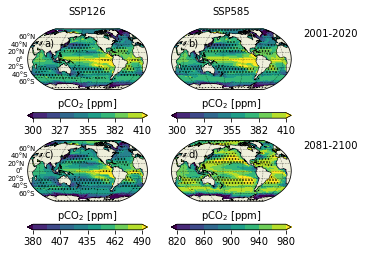

In [179]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Map of mean pCO2 for different time period')
print('Load and prepare data2plot')


#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-map-mean-pco2-diff-time-period.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

simu_list = ['ssp126', 'ssp585']
period_list = [('2001', '2020'), ('2081', '2100')]
nperiod = len(period_list)
nsimu = len(simu_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nperiod, nsimu
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nsimu/nperiod*1.5* 8*cm2in, 8*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

kwmap = {}

a = cm.get_cmap('viridis',64)
colors = a(np.linspace(0,1,10))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap = dict(transform=ccrs.PlateCarree(), cmap=newcmap)


#---------------------
# ACOD
#---------------------

dens = 4
kwaod = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])

#=========================================
# PLOT
#=========================================


ax = []
cax = []
pcm = []
        
for isimu, vsimu in enumerate(simu_list):
    for iperiod, vperiod in enumerate(period_list): 

        irow = iperiod
        iplot = irow*ncol+isimu+1
        zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
        ax.append(zax)
        
        #_____________________
        # pco2
        X1 = data2plot[vsimu]['pco2']['%s-%s'%vperiod]['X']
        Y1 = data2plot[vsimu]['pco2']['%s-%s'%vperiod]['Y']
        Z1 = data2plot[vsimu]['pco2']['%s-%s'%vperiod]['Z']
        vmin, vmax = np.round(np.nanquantile(Z1, .05), -1), np.round(np.nanquantile(Z1, .95), -1)
        zwpcm = zax.pcolormesh(X1, Y1, Z1, vmin=vmin, vmax=vmax, **kwmap)
        pcm.append(zwpcm)

        zw1 = zax.get_position()
        nx0 = zw1.x0 
        ny0 = zw1.y0 - .5*zw1.height
        nw  = zw1.width
        nh  = 0.07*nw
        zcax = fig.add_axes([nx0, ny0, nw, nh])
        cax.append(zcax)
        cbar = fig.colorbar(zwpcm, cax=zcax, orientation='horizontal', ticklocation='bottom', 
                            extend='both')
        zcax.set_title('pCO$_2$ [ppm]', size='medium')
        ttt = np.linspace(vmin, vmax, int((zwpcm.cmap.colors.shape[0]/2+1)))
        cbar.set_ticks(ttt)
        cbar.set_ticklabels(['%d' %s for s in ttt])

        #_____________________
        # ACOD
        X1 = data2plot[vsimu]['ACOD']['X']
        Y1 = data2plot[vsimu]['ACOD']['Y']
        Z1 = data2plot[vsimu]['ACOD']['Z']
        zax.contourf(X1, Y1, Z1, levels = [0.5, 1.5], **kwaod)

        #_____________________
        # axis settings
        gl = add_gridlines_coastline_and_land(zax)
        if not isimu==0: gl.left_labels=False

    #
#
# fig.tight_layout()

ax = np.reshape(ax, (nrow, ncol)).T
cax = np.reshape(cax, (nrow, ncol)).T
pcm = np.reshape(pcm, (nrow, ncol)).T

#=========================================
# numbering plots
#=========================================

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositioning axis
#=========================================

for irow, axrow in enumerate(ax[1:], start=1): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 - irow*0.3*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
        zcax = cax[irow, icol]
        zw2 = zcax.get_position()
        ny0 = zw2.y0 - irow*0.3*zw1.height
        zcax.set_position([zw2.x0, ny0, zw2.width, zw2.height])

    #
#

#=========================================
# Extra text
#=========================================


#---------------------
# On the right period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
for iperiod, vperiod in enumerate(period_list): 
    zw1 = ax[iperiod, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, '%s-%s'%vperiod, **kwtxt)
#

#---------------------
# On the top simu titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    ny0 = zw1.y1 + .2*zw1.height
    nx0 = zw1.x0 + .5*zw1.width
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#


#=========================================
# Save figure
#=========================================

fignam = 'map-mean-pco2-diff-time-period.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 18s

# Map total carbon flux in the 1990s in model and obs

## Load and prepare data to plot

In [180]:
%%time
print(datetime.datetime.now())
print('Map total carbon flux in the 1990s in model and obs')
print('Load and prepare data to plot')

zfactmod = 3600*24*365 # kgC/m2/s -> kgC/m2/yr
zfactobs =  12/1000.   # molC/m2/s -> kgC/m2/yr

data2plot = {}


print('Load model carbon flux...')
savedfile = dirout+'datasave-bgc-phy-noresm2-lm.pckl'
with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
print("Done, loaded file: "+savedfile)

print('Compute mean on the 1990s...')
Y, X = grid['plat'], grid['plon']
simu   = 'historical'
tslice = slice('1990', '1999')
zwcflx = loadeddatas['cflx-tot'][simu]
data2plot['mod'] = {'X':X, 'Y':Y, 'Z':zfactmod * zwcflx.sel(time=tslice).mean(dim='time').values}
print('Done')

print('Load observation carbon flux...')
filecfxobs = '/mnt/reef-ns1002k/daco/CO2FLUX-DATAS-LANDSCHUTZER/spco2_1982-2015_MPI_SOM-FFN_v2016_v1.nc'
ds = xr.open_dataset(filecfxobs)
zwcflx  = -ds['fgco2_smoothed'] # mol m-2 y-1
lonobs = ds['lon']
latobs = ds['lat']
print('Done, loaded file: '+filecfxobs)

print('Compute mean on the 1990s...')
data2plot['obs'] = {'X':lonobs, 'Y':latobs, 'Z':zfactobs * zwcflx.sel(time=slice('1990', '1999')).mean(dim='time').values}
print('Done')

print('Save data2plot...')
savedfile = dirout+'data2plot-map-cflx-tot-1990s-model-observations.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)

# ca. 1m50s

2023-10-01 17:28:12.706148
Map total carbon flux in the 1990s in model and obs
Load and prepare data to plot
Load model carbon flux...
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
Compute mean on the 1990s...
Done
Load observation carbon flux...
Done, loaded file: /mnt/reef-ns1002k/daco/CO2FLUX-DATAS-LANDSCHUTZER/spco2_1982-2015_MPI_SOM-FFN_v2016_v1.nc
Compute mean on the 1990s...
Done
Save data2plot...
Done, file saved: cc2300-230215-noresm2-lm/data2plot-map-cflx-tot-1990s-model-observations.pckl
CPU times: user 428 ms, sys: 201 ms, total: 628 ms
Wall time: 839 ms


## Plot

2023-10-01 17:39:00.247940
Map total carbon flux in the 1990s in model and obs
Plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: map-cflx-tot-1990s-model-observations.png
peak memory: 56391.68 MiB, increment: 28132.54 MiB
CPU times: user 6.51 s, sys: 2.06 s, total: 8.57 s
Wall time: 6.88 s


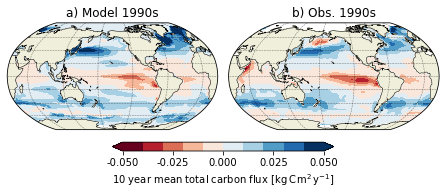

In [185]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Map total carbon flux in the 1990s in model and obs')
print('Plot')

# Load data2plot
savedfile = dirout+'data2plot-map-cflx-tot-1990s-model-observations.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#---------------------
# FIGURE PARAM
#---------------------

ccrsproj = ccrs.Robinson(central_longitude=-155)
nrow, ncol = 1, 2
fig, ax = plt.subplots(nrow, ncol, figsize=(ncol/nrow* 8*cm2in, 8*cm2in), squeeze=False, subplot_kw=dict(projection=ccrsproj))

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


cmap = cm.get_cmap('RdBu', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors)
# cmap.set_under(color='silver')
# cmap.set_over(color='silver')
kwmaps = {'transform':ccrs.PlateCarree(), 'cmap':cmap, 'vmin':-.05, 'vmax':.05}

# Naming

name_maps = {'mod': 'Model 1990s'    , 
             'obs': 'Obs. 1990s'     
            }

#---------------------
# Plot
#---------------------

simu_list = ['1990s', '2090s, ssp126', '2290s, ssp126', 'observations', '2090s, ssp585', '2290s, ssp585']
iplot = 3
for iii, kkk in enumerate(['mod', 'obs']) : 
    vvv = data2plot[kkk]
    zax = ax[0, iii]
    X = vvv['X']
    Y = vvv['Y']
    Z = vvv['Z']
    mmm = zax.pcolormesh(X, Y, Z, **kwmaps)
    zax.set_title(subnum.pop()+') ' + name_maps[kkk])
    #_____________________
    # axis settings
    gl = add_gridlines_coastline_and_land(zax)
    if not isimu==0: gl.left_labels=False
#

fig.tight_layout()

# Colorbar
zw1 = ax[-1, 0 ].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + zw1.width*.5
nw  = zw2.x0 + zw2.width*.5 - nx0
ny0 = zw1.y0 - .2 * zw1.height
nh  = 0.08*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm, cax=cax, extend='both', 
                    orientation='horizontal', ticklocation='bottom')
cbar.set_label(label='10 year mean total carbon flux [kg$\,$C$\,$m$^{2}\,$y$^{-1}$]')
ttt = np.linspace(kwmaps['vmin'], kwmaps['vmax'], int((zwpcm.cmap.colors.shape[0]/2+1)))
cbar.set_ticks(ttt)
cbar.set_ticklabels(['%.3f' %s for s in ttt])



fignam = 'map-cflx-tot-1990s-model-observations.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 16s

# Maps of time mean pCO2 spatial anomaly + taylor expansion based on spatial anomalies

$ \Delta pCO_2 = <pCO_2> \times \left(\gamma_T \times \Delta T + \frac{\gamma_{S}}{S}\times\Delta S  + \frac{1}{\gamma_{DIC}}\times\Delta DIC  + \frac{1}{\gamma_{ALK}}\times\Delta ALK \right) $

We are looking at spatial anomalies of averages on some time period. $\delta X$ are the spatial anomalies relative to the global spatial mean. The sensitivities to DIC and ALK ($\gamma_{DIC}$ and $ \gamma_{ALK}$) are evaluated with CO2SYS with global spatial mean values of T, S,DIC and ALK. Note they have to be multiplied by $10^6$ to be in the correct unit. 

This is done in each grid point and for some time periods

## Load and prepare data2plot

In [22]:
%%time
print(datetime.datetime.now())
print('Maps of time mean pCO2 spatial anomaly + taylor expansion based on spatial anomalies')
print('Load and prepare data2plot')

simu = 'ssp585'
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
period_list = [('2001', '2020'), ('2081', '2100')]

data2plot = {}

#=======================================
# 1 - Load pCO2, sdic, salk, sss, sst
#=======================================

print('Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...')
var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'stemp', 'ssali']
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')

#=======================================
# 2 - Compute salinity normalized DIC and ALK
#=======================================

print('Compute salinity normalized DIC and ALK...')
SSS0 = zwdata['ssali'].mean(dim='time', keep_attrs=True)
addtxt = 'Temporal mean over ' + \
str(zwdata['ssali']['time.year'].min().values) +'-'+\
str(zwdata['ssali']['time.year'].max().values)
try : SSS0.attrs['history'] = addtxt+' ; ' + SSS0.attrs['history']
except : SSS0.attrs['history'] = addtxt
addtxt = 'Reference salinity used for normalizing DIC and ALK '
try : SSS0.attrs['comment'] = addtxt+' ; ' + SSS0.attrs['comment']
except : SSS0.attrs['comment'] = addtxt
for var in ['sdic-tot', 'salk-tot']:
    zw = ( zwdata[var]*SSS0/zwdata['ssali'] ).rename(var+'-sn')
    zw.attrs = zwdata[var].attrs
    try: zw.attrs['long_name'] = zwdata[var].attrs['long_name'] + ' salinity normalized'
    except: zw.attrs['long_name'] = var + ' salinity normalized'
    addtxt = 'salinity normalization %s * SSS0 / sss. SSS0 is a reference \
    salinity, here time average. sss is sea surface salinity'%var.upper()
    try : zw.attrs['history'] = addtxt+' ; ' + zw.attrs['history']
    except : zw.attrs['history'] = addtxt
    zwdata[var+'-sn'] = zw
#
print('Done')

#=======================================
# Loop on time periods
#=======================================

print('Start loop on time periods...')

for period in period_list: 
    
    print('    period: '+str(period))

    pname = '%s-%s'%period
    data2plot[pname] = {}
    

    #-------------------
    # 1) Select time period and compute time average and global average
    #-------------------
    
    print('        Select time period and compute time average and global average...')
    zwtavg = {}
    zwglob = {}
    var_list = ['pco2-tot', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn', 'stemp', 'ssali']
    for var in var_list: 
        if var in ['sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']: 
            zwtavg[var] = zwdata[var].sel(time=slice(period[0], period[1])).mean(dim='time') * 1000./1.024 # in umol.kg-1
        else: zwtavg[var] = zwdata[var].sel(time=slice(period[0], period[1])).mean(dim='time')
        zwglob[var] = zwtavg[var].weighted(grid['parea']).mean(dim=('x', 'y'))
    #
    print('        Done')
    
    #-------------------
    # 2) Compute spatial anomalies
    #-------------------
    
    print('        Compute spatial anomalies...')
    anomalies = {}
    anomalies['pco2-tot'   ] = zwtavg['pco2-tot'   ] - zwglob['pco2-tot'   ] 
    anomalies['sdic-tot'   ] = zwtavg['sdic-tot'   ] - zwglob['sdic-tot'   ] # in umol.kg-1
    anomalies['salk-tot'   ] = zwtavg['salk-tot'   ] - zwglob['salk-tot'   ] # in umol.kg-1
    anomalies['sdic-tot-sn'] = zwtavg['sdic-tot-sn'] - zwglob['sdic-tot-sn'] # in umol.kg-1
    anomalies['salk-tot-sn'] = zwtavg['salk-tot-sn'] - zwglob['salk-tot-sn'] # in umol.kg-1
    anomalies['stemp'      ] = zwtavg['stemp'      ] - zwglob['stemp'      ] 
    anomalies['ssali'      ] = zwtavg['ssali'      ] - zwglob['ssali'      ]     
    print('        Done')
    
    #-------------------
    # 5) Compute sensitivities
    #-------------------
    
    print('        Compute sensitivities with PyCO2SYS...')

    zwalk    = zwglob['salk-tot'   ]
    zwdic    = zwglob['sdic-tot'   ]
    zwalk_sn = zwglob['salk-tot-sn']
    zwdic_sn = zwglob['sdic-tot-sn']
    zwsss    = zwglob['ssali'      ]
    zwsst    = zwglob['stemp'      ]
    kwargs = dict(par1=zwalk, par2=zwdic, par1_type=1, par2_type=2, 
                  salinity=zwsss, temperature=zwsst, opt_pH_scale=1, 
                  opt_k_carbonic=4, opt_k_bisulfate=1)
    zwco2sysres = xr.apply_ufunc(PyCO2SYS.sys, kwargs=kwargs, dask='allowed')

    zwgam_np = {}
    # coef-dic
    var = 'sdic-tot'
    zwgam_np[var] = 1 / (zwco2sysres['gamma_dic'] * 1e6) 
    # coef-alk
    var = 'salk-tot'
    zwgam_np[var] = 1 / (zwco2sysres['gamma_alk'] * 1e6) 
    # coef-dic-sn
    var = 'sdic-tot-sn'
    zwgam_np[var] = zwsss/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) 
    # coef-alk-sn
    var = 'salk-tot-sn'
    zwgam_np[var] = zwsss/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) 
    # coef-dic-fw
    var = 'sdic-tot-fw'
    zwgam_np[var] = zwdic_sn/SSS0 * 1 / (zwco2sysres['gamma_dic'] * 1e6) 
    # coef-alk-fw
    var = 'salk-tot-fw'
    zwgam_np[var] = zwalk_sn/SSS0 * 1 / (zwco2sysres['gamma_alk'] * 1e6) 
    # coef-sst
    var = 'stemp'
    zwgam_np[var] = np.where(zwsst.isnull(), np.nan, 0.0423)
    # coef-sss
    var = 'ssali'
    zwgam_np[var] = np.where(zwsss.isnull(), np.nan, 1/zwsss)
    
    print('        Done')

    
    #-------------------
    # 6) Compute expansion terms
    #-------------------
    
    print('        Compute expansion terms...')
    zwtaylor = {}
    var_list = ['stemp', 'ssali', 'sdic-tot', 'salk-tot', 'sdic-tot-sn', 'salk-tot-sn']
    for var in var_list: 
        zwtaylor[var] = zwglob['pco2-tot'] * zwgam_np[var] * anomalies[var]
    #
    for var in ['sdic-tot-fw', 'salk-tot-fw']:
        zwtaylor[var] = zwglob['pco2-tot'] * zwgam_np[var] * anomalies['ssali']
    #
    print('        Done')
   

    #----------------
    # 7) Compute main terms and save in data2plot
    #----------------

    print('        Compute main terms and save in data2plot...')
    data2plot[pname]['dpCO2']   = {'X':anomalies['pco2-tot'].plon.values, 
                                   'Y':anomalies['pco2-tot'].plat.values, 
                                   'Z':anomalies['pco2-tot'].values}
    data2plot[pname]['thermal'] = {'X':zwtaylor['stemp'].plon.values, 
                                   'Y':zwtaylor['stemp'].plat.values, 
                                   'Z':zwtaylor['stemp'].values}
    data2plot[pname]['carbon']  = {'X':zwtaylor['sdic-tot-sn'].plon.values, 
                                   'Y':zwtaylor['sdic-tot-sn'].plat.values, 
                                   'Z':zwtaylor['sdic-tot-sn'].values + zwtaylor['salk-tot-sn'].values}
    data2plot[pname]['fw']      = {'X':zwtaylor['sdic-tot-fw'].plon.values, 
                                   'Y':zwtaylor['sdic-tot-fw'].plat.values, 
                                   'Z':zwtaylor['sdic-tot-fw'].values + zwtaylor['salk-tot-fw'].values + zwtaylor['ssali'].values}

    print('        Done')
    
#


print('> save file')
savedfile = dirout+'data2plot-maps-timemean-pco2-spatial-anomalies-taylor-expansion.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)


# ca. 1m32s

2023-10-08 22:11:26.836816
Maps of time mean pCO2 spatial anomaly + taylor expansion based on spatial anomalies
Load and prepare data2plot
Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2 and select grid point...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(salk-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(stemp, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load

## Plot

2023-10-08 22:12:03.480588
Maps of time mean pCO2 spatial anomaly + taylor expansion based on spatial anomalies
Plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: maps-timemean-pco2-spatial-anomalies-taylor-expansion.png
CPU times: user 42 s, sys: 5.75 s, total: 47.8 s
Wall time: 42.1 s


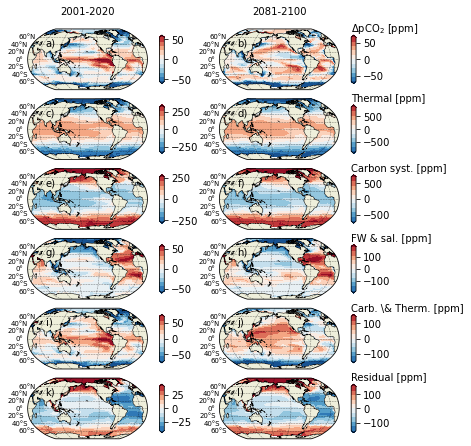

In [23]:
%%time 
print(datetime.datetime.now())
print('Maps of time mean pCO2 spatial anomaly + taylor expansion based on spatial anomalies')
print('Plot')

# Load data2plot
savedfile = dirout+'data2plot-maps-timemean-pco2-spatial-anomalies-taylor-expansion.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
        
#=========================================
# Parameters for data2plot
#=========================================

period_list = list(data2plot.keys())[:2]
maps_list = ['dpCO2', 'thermal', 'carbon', 'fw']
nperiod = len(period_list)
nmaps  = len(maps_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nmaps+2, nperiod
ccrsproj = ccrs.Robinson(central_longitude=-155)
fact = 2
fsize = (fact*cm2in*3*ncol, fact*cm2in*2*nrow)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, squeeze=False, subplot_kw=dict(projection=ccrsproj))

value_names = {'dpCO2'   :'$\Delta$pCO$_2$', \
               'thermal' :'Thermal', \
               'carbon'  :'Carbon syst.', \
               'fw'      :'FW & sal.', \
               'res'     :'Residual'}

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Season
#---------------------

colors = np.array([[140/255, 255/255, 255/255, 1.00], 
                   [ 79/255, 214/255,  42/255, 1.00], 
                   [255/255, 225/255,   0/255, 1.00], 
                   [209/255, 125/255,   0/255, 1.00]] )
newcmap = ListedColormap(colors)
newcmap.set_over("white")
newcmap.set_under("white")
kwmap_seas = dict(transform=ccrs.PlateCarree(), vmin = .5, vmax = 4.5, cmap=newcmap)

#---------------------
# Taylor expansion
#---------------------

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,12+2))[1:-1]
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
vmax = {'dpCO2'   :60, \
        'thermal' :400, \
        'carbon'  :400, \
        'fw'      :200, \
        'res'     :200}
kwmap_tayl   = dict(transform=ccrs.PlateCarree(), cmap=newcmap)
# vminmax = {'2000-2050': (0.5,4.5), '2100-2150':(3,13), '2200-2250':(0.5,4.5)}


#=========================================
# PLOT
#=========================================

def addcb(ax, pcm): 
    hfrac, wfrac = .8, .2
    zw1 = zax.get_position()
    nx0 = zw1.x1 + .1*zw1.width
    ny0 = zw1.y0 + (1-hfrac)/2*zw1.height
    nh  = hfrac*zw1.height
    nw  = wfrac*nh
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm, cax=cax, orientation='vertical', ticklocation='right', 
                extend='both', label = '')
    return cax
#

pcm2=[]
cax = np.zeros_like(ax)
for iperiod, vperiod in enumerate(period_list): 

    for iii, vvv in enumerate(maps_list) : 
        zax = ax[iii, iperiod]
        X = data2plot[vperiod][vvv]['X']
        Y = data2plot[vperiod][vvv]['Y']
        Z = data2plot[vperiod][vvv]['Z']
        vmax = np.nanquantile(np.abs(Z), .9)
        # zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax[vvv], vmax=vmax[vvv], **kwmap_tayl)
        zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax, vmax=vmax, **kwmap_tayl)
        gl = add_gridlines_coastline_and_land(zax)
        cax[iii, iperiod] = addcb(zax, zwpcm)

        
    #

    zax = ax[-2, iperiod]
    X = data2plot[vperiod]['dpCO2']['X']
    Y = data2plot[vperiod]['dpCO2']['Y']
    Z = data2plot[vperiod]['carbon']['Z'] + \
        data2plot[vperiod]['thermal']['Z'] 
    vmax = np.nanquantile(np.abs(Z), .9)
    # zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax['res'], vmax=vmax['res'], **kwmap_tayl)
    zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax, vmax=vmax, **kwmap_tayl)
    gl = add_gridlines_coastline_and_land(zax)
    cax[-2, iperiod] = addcb(zax, zwpcm)

    zax = ax[-1, iperiod]
    X = data2plot[vperiod]['dpCO2']['X']
    Y = data2plot[vperiod]['dpCO2']['Y']
    Z = data2plot[vperiod]['dpCO2']['Z'] - \
        data2plot[vperiod]['carbon']['Z'] - \
        data2plot[vperiod]['thermal']['Z'] -\
        data2plot[vperiod]['fw']['Z'] 
    vmax = np.nanquantile(np.abs(Z), .9)
    # zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax['res'], vmax=vmax['res'], **kwmap_tayl)
    zwpcm = zax.pcolormesh(X, Y, Z, vmin=-vmax, vmax=vmax, **kwmap_tayl)
    gl = add_gridlines_coastline_and_land(zax)
    cax[-1, iperiod] = addcb(zax, zwpcm)
    
    pcm2.append(zwpcm)

    
#
 

#fig.tight_layout()

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.15, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositionning and resizing axes
#=========================================

# repos vertical
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        nx0 = zw1.x0
        ny0 = zw1.y0 + irow*.3*zw1.height
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh]) 
        
        zw2 = cax[irow, icol].get_position()
        nx0 = zw2.x0
        ny0 = zw2.y0 + irow*.3*zw1.height
        nw  = zw2.width
        nh  = zw2.height
        cax[irow, icol].set_position([nx0, ny0, nw, nh])       
    #
#

# repos horizontal
for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow[:]): 
        zw1 = zax.get_position()
        nx0 = zw1.x0 + icol*.4*zw1.width
        ny0 = zw1.y0
        nw  = zw1.width
        nh  = zw1.height
        zax.set_position([nx0, ny0, nw, nh])
        
        zw2 = cax[irow, icol].get_position()
        nx0 = zw2.x0 + icol*.4*zw1.width
        ny0 = zw2.y0 
        nw  = zw2.width
        nh  = zw2.height
        cax[irow, icol].set_position([nx0, ny0, nw, nh])
        
    #
#
    
#=========================================
# Extra text
#=========================================

#---------------------
# On the right maps title
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='center')
for iii, vvv in enumerate(maps_list) : 
    zw1 = ax[iii, -1].get_position()
    ny0 = zw1.y1
    nx0 = zw1.x1 + .1*zw1.width
    fig.text(nx0, ny0, value_names[vvv]+' [ppm]', **kwtxt)
#

zw1 = ax[-2, -1].get_position()
ny0 = zw1.y1
nx0 = zw1.x1 + .1*zw1.width
fig.text(nx0, ny0, 'Carb. \& Therm. [ppm]', **kwtxt)

zw1 = ax[-1, -1].get_position()
ny0 = zw1.y1
nx0 = zw1.x1 + .1*zw1.width
fig.text(nx0, ny0, value_names['res']+' [ppm]', **kwtxt)


#---------------------
# At the top, period titles
#---------------------

kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
for iii, vvv in enumerate(period_list): 
    zw1 = ax[0, iii].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vvv, **kwtxt)
#

#=========================================
# COLORBARS
#=========================================

# hfrac, wfrac = .8, .2
# 
# for iii, vvv in enumerate(ax[:, 0]): 
#     zw1 = vvv.get_position()
#     nx0 = zw1.x1 + .1*zw1.width
#     ny0 = zw1.y0 + (1-hfrac)/2*zw1.height
#     nh  = hfrac*zw1.height
#     nw  = wfrac*nh
#     cax = fig.add_axes([nx0, ny0, nw, nh])
#     cbar = fig.colorbar(pcm2[iii], cax=cax, orientation='vertical', ticklocation='right', 
#                         extend='both', label = '[ppm]')
# 

fignam = 'maps-timemean-pco2-spatial-anomalies-taylor-expansion.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 1min20s

# Maps of trend in solubility and surface wind on the 21st century

## Load and prepare data2plot

In [33]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Maps of trend in solubility and surface wind on the 21st century')
print('Load and prepare data2plot')


#----------------
# PARAMETERS
#----------------

simu = 'ssp585'
# seas_list  = ['JAS', 'JFM']
nbyear = 50 # number of year to compute the mean and trends
var_list = ['kh', 'abswnd']

#----------------
# Load data
#----------------

print('Load variables...')
zwdata = {}
for var in var_list: 
    if var in ['kh', 'khd']: 
        zw = load_and_concat_hist_ssp(var, simu, \
                                           zsavedfile=dirout+'datasave-kh-khd-sc-noresm2-lm.pckl')
    else: zw = load_and_concat_hist_ssp(var, simu)
    zwplat = grid['plat']
    zwplon = grid['plon']
    zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
    try: del zw.attrs['actual_range']
    except: pass
    zwdata[var] = zw
#
print('Done')


#----------------
# Compute trends
#----------------

data2plot = {'mean':{}, 'trd':{}}
    
for var in var_list:

    
    print('Compute trend of '+var+'...')
    zw1 = zwdata[var].sel(time=slice('2001', '2050')).mean(dim='time').values
    zw2 = zwdata[var].sel(time=slice('2051', '2100')).mean(dim='time').values
    zwtrd = (zw2 - zw1)/50

    data2plot['mean'][var] = {
        'X': zwdata[var].plon.values, 
        'Y': zwdata[var].plat.values, 
        'Z': zw1
    }       
    data2plot['trd'][var] = {
        'X': zwdata[var].plon.values, 
        'Y': zwdata[var].plat.values, 
        'Z': zwtrd
    }       
#
del zwdata2
#
print('> save file')
savedfile = dirout+'data2plot-maps-trend-solubility-surfwind.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)


2023-10-10 19:33:01.501314
Maps of trend in solubility and surface wind on the 21st century
Load and prepare data2plot
Load variables...
func: load_and_concat_hist_ssp(kh, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-kh-khd-sc-noresm2-lm.pckl
func: load_and_concat_hist_ssp(abswnd, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
Done
Compute trend of kh...
Compute trend of abswnd...


NameError: name 'zwdata2' is not defined

## Plot

In [36]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Maps of trend in solubility and surface wind on the 21st century')
print('Plot')


#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-maps-trend-solubility-surfwind.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)

#=========================================
# Parameters for data2plot
#=========================================

seas_list = ['mean', 'trd']
var_list = ['kh', 'abswnd']
mean_dict = {'kh': 'Solubility\n[mol$\,$l$^{-1}\,$ppm$^{-1}$]', 
             'abswnd': 'Surface wind\n[m$\,$s$^{-1}$]'}
trd_dict = {'kh': 'Trend [mol$\,$l$^{-1}\,$ppm$^{-1}\,$yr$^{-1}$]', 
            'abswnd': 'Trend [m$\,$s$^{-1}\,$yr$^{-1}$]'}
vmax_dict = {'kh': 6e-11, 'abswnd': .01}
nvar = len(var_list)
nseas = len(seas_list)

#=========================================
# Figure parameters
#=========================================

nrow, ncol = nseas, nvar
ccrsproj = ccrs.Robinson(central_longitude=-155)

fsize = (nrow/ncol*1.5* 8*cm2in, 8*cm2in) # width, height
fig = plt.figure(figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

kwmap = {}

a = cm.get_cmap('RdBu',64)
colors = a(np.linspace(0,1,10))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['trd'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap)

a = cm.get_cmap('viridis',64)
colors = a(np.linspace(0,1,10))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap['mean'] = dict(transform=ccrs.PlateCarree(), cmap=newcmap)

#=========================================
# PLOT
#=========================================


ax = []
cax = []
pcm = []
        
for iseas, vseas in enumerate(seas_list):
    for ivar, vvar in enumerate(var_list): 

        irow = iseas
        iplot = irow*ncol+ivar+1
        zax = fig.add_subplot(nrow, ncol, iplot, projection=ccrsproj)
        ax.append(zax)
        
        #_____________________
        # Var
        X1 = data2plot[vseas][vvar]['X']
        Y1 = data2plot[vseas][vvar]['Y']
        Z1 = data2plot[vseas][vvar]['Z']
        vmax = np.nanquantile(np.abs(Z1), .9)
        if vseas == 'trd': vmin=-vmax
        else: vmin=None
        # vmax = vmax_dict[vvar]
        zwpcm = zax.pcolormesh(X1, Y1, Z1, vmin=vmin, vmax=vmax, **kwmap[vseas])
        pcm.append(zwpcm)

        #_____________________
        # axis settings
        gl = add_gridlines_coastline_and_land(zax)
        if not ivar==0: gl.left_labels=False

    #
#
# fig.tight_layout()

ax = np.reshape(ax, (nrow, ncol))
pcm = np.reshape(pcm, (nrow, ncol))

#=========================================
# numbering plots
#=========================================

for axrow in ax: 
    for zax in axrow:        
        zwtitle = subnum.pop() + ')'
        zax.annotate(zwtitle, (0.14, 0.72),xycoords='axes fraction')
    #
#

#=========================================
# Repositioning axis
#=========================================

for irow, axrow in enumerate(ax[1:], start=1): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + irow*.3*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#=========================================
# Colorbars
#=========================================

for iii, vvv in enumerate(var_list): 
    zax = ax[0, iii]
    zw1 = zax.get_position()
    nx0 = zw1.x0 
    ny0 = zw1.y1 + .6*zw1.height
    nw  = zw1.width
    nh  = 0.07*nw
    zcax = fig.add_axes([nx0, ny0, nw, nh])
    cax.append(zcax)
    cbar = fig.colorbar(pcm[0, iii], cax=zcax, orientation='horizontal', ticklocation='bottom', 
                        extend='both')
    zcax.set_title(mean_dict[vvv], size='medium')

    zax = ax[-1, iii]
    zw1 = zax.get_position()
    nx0 = zw1.x0 
    ny0 = zw1.y0 - .6*zw1.height
    nw  = zw1.width
    nh  = 0.07*nw
    zcax = fig.add_axes([nx0, ny0, nw, nh])
    cax.append(zcax)
    cbar = fig.colorbar(pcm[-1, iii], cax=zcax, orientation='horizontal', ticklocation='bottom', 
                        extend='both')
    zcax.set_title(trd_dict[vvv], size='medium')

    # ttt = np.linspace(-vmax, vmax, int((zwpcm.cmap.colors.shape[0]/2+1)))
    # cbar.set_ticks(ttt)
    # cbar.set_ticklabels(['%d' %s for s in ttt])

#=========================================
# Extra text
#=========================================


#---------------------
# On the right 
#---------------------

# kwtxt = dict(fontsize='medium', rotation='horizontal', ha='left', va='top')
# for iii, vvv in enumerate(seas_list): 
#     zw1 = ax[iii, -1].get_position()
#     ny0 = .5*(zw1.y0+zw1.y1)
#     nx0 = zw1.x1 + .1*zw1.width
#     fig.text(nx0, ny0, '%s'%vvv, **kwtxt)
# #

#---------------------
# On the top 
#---------------------

# kwtxt = dict(fontsize='medium', rotation='horizontal', ha='center', va='bottom')
# for iii, vvv in enumerate(var_list): 
#     zw1 = ax[0, iii].get_position()
#     ny0 = zw1.y1 + .2*zw1.height
#     nx0 = zw1.x0 + .5*zw1.width
#     fig.text(nx0, ny0, vvv.upper(), **kwtxt)
# #


#=========================================
# Save figure
#=========================================

fignam = 'maps-trend-solubility-surfwind.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 18s

# Maps of pco2 yearly trends on different time period in ssp585

## Load and prepare data2plot

In [37]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Maps of pco2 yearly trends on differenr time period in ssp585')
print('Load and prepare data2plot')


#----------------
# PARAMETERS
#----------------

simu = 'ssp585'
# seas_list  = ['JAS', 'JFM']
var = 'pco2-tot'
period_list = [(1901, 1950), (1961,2010), (1981,2010), (2001, 2100)]

#----------------
# Load data
#----------------

print('Load variable...')
zwdata = load_and_concat_hist_ssp(var, simu)
zwplat = grid['plat']
zwplon = grid['plon']
zwdata = zwdata.assign_coords(dict(plat=zwplat, plon=zwplon))
#
print('Done')


#----------------
# Compute trends
#----------------

data2plot = {}
    
for period in period_list:

    t1 = int(period[0])
    t3 = int(period[-1])
    t2 = int(t1+(t3-t1+1)/2-1)
    print('Compute trend of '+var+'...')
    zw1 = zwdata.sel(time=slice(str(t1  ), str(t2))).mean(dim='time')
    zw2 = zwdata.sel(time=slice(str(t2+1), str(t3))).mean(dim='time')
    zwtrd = (zw2 - zw1)/( (t3-t1+1)/2 )

    data2plot['%s-%s'%(str(t1), str(t3))] = {
        'X': zwdata.plon.values, 
        'Y': zwdata.plat.values, 
        'Z': (zwtrd - zwtrd.weighted(grid['parea']).mean(dim=('x', 'y'))).values
    }       
#
#
print('> save file')
savedfile = dirout+'data2plot-maps-yearly-trend-pco2-tot-ssp585.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)


2023-10-11 14:25:05.638411
Maps of pco2 yearly trends on differenr time period in ssp585
Load and prepare data2plot
Load variable...
func: load_and_concat_hist_ssp(pco2-tot, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
Done
Compute trend of pco2-tot...
Compute trend of pco2-tot...
Compute trend of pco2-tot...
Compute trend of pco2-tot...
> save file
Done, file saved: cc2300-230215-noresm2-lm/data2plot-maps-yearly-trend-pco2-tot-ssp585.pckl
peak memory: 2376.26 MiB, increment: 1373.23 MiB
CPU times: user 2.97 s, sys: 2.13 s, total: 5.1 s
Wall time: 3.15 s


## Plot

2023-10-11 14:25:08.789717
Maps of trend in solubility and surface wind on the 21st century
Plot
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
func: add_gridlines_coastline_and_land
Done, figure saved: maps-yearly-trend-pco2-tot-ssp585.png
peak memory: 2028.01 MiB, increment: 1024.32 MiB
CPU times: user 16.2 s, sys: 5.42 s, total: 21.6 s
Wall time: 16.4 s


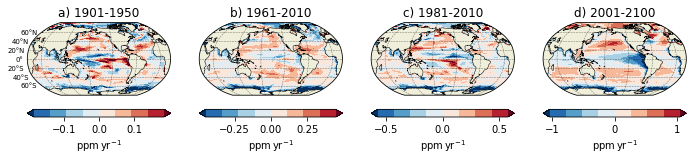

In [38]:
%%time 
%%memit -c
print(datetime.datetime.now())
print('Maps of trend in solubility and surface wind on the 21st century')
print('Plot')


#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-maps-yearly-trend-pco2-tot-ssp585.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)


#=========================================
# Figure parameters
#=========================================

nrow, ncol = 1, len(data2plot.keys())
ccrsproj = ccrs.Robinson(central_longitude=-155)

scale = 30
fsize = (scale*cm2in, ncol/nrow/1.5* scale*cm2in) # width, height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, subplot_kw={'projection': ccrsproj})

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

#---------------------
# Maps
#---------------------

kwmap = {}

a = cm.get_cmap('RdBu_r',64)
colors = a(np.linspace(0,1,10))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_under(colors[0])
newcmap.set_over(colors[-1])
kwmap = dict(transform=ccrs.PlateCarree(), cmap=newcmap)

#=========================================
# PLOT
#=========================================


pcm = np.zeros_like(ax)

for iii, (kkk, vvv) in enumerate(data2plot.items()): 

    zax = ax[iii]

    X1 = vvv['X']
    Y1 = vvv['Y']
    Z1 = vvv['Z']
    vmax = np.nanquantile(np.abs(Z1), .95)
    #vmin = np.nanquantile(np.abs(Z1), .01)
    vmin = -vmax
    zwpcm = zax.pcolormesh(X1, Y1, Z1, vmin=vmin, vmax=vmax, **kwmap)
    pcm[iii] = zwpcm
    gl = add_gridlines_coastline_and_land(zax)
    if not iii==0: gl.left_labels=False
    zwttl = subnum.pop() + ') '+kkk
    zax.set_title(zwttl)
    
    zw1 = zax.get_position()
    nx0 = zw1.x0 
    ny0 = zw1.y0 - .3*zw1.height
    nw  = zw1.width
    nh  = 0.02*nw
    zcax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(zwpcm, cax=zcax, orientation='horizontal', ticklocation='bottom', 
                        extend='both', label='ppm$\,$yr$^{-1}$')    

#
# fig.tight_layout()



#=========================================
# Save figure
#=========================================

fignam = 'maps-yearly-trend-pco2-tot-ssp585.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 18s

# Timeseries of global sst, sdic, salk and sss

## Load and prepare data2plot

In [15]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Timeseries of global sst, sdic, salk and sss')
print("Load and prepare data2plot")

simu_list = ['ssp126', 'ssp585']

#=======================================
# 1 - Load pCO2, Khd, Kh, sdic, salk, sss, sst, atmco2
#=======================================

print('Load sdic, salk, sss, sst and compute yearly mean...')
var_list = ['sdic-tot', 'salk-tot', 'stemp', 'ssali']
zwdata = {}
for simu in simu_list: 
    zwdata[simu] = {}
    for var in var_list: 
        zw = load_and_concat_hist_ssp(var, simu)
        zwplat = grid['plat']
        zwplon = grid['plon']
        zw = zw.assign_coords(dict(plat=zwplat, plon=zwplon))
        zwdata[simu][var] = zw.groupby('time.year').mean('time')
    #
#
print('Done')

#=======================================
# 2 - Compute salinity normalized DIC and ALK
#=======================================

print('Compute salinity normalized DIC and ALK...')

for simu in simu_list: 
    SSS0 = zwdata[simu]['ssali'].mean(dim='year', keep_attrs=True)
    for var in ['sdic-tot', 'salk-tot']:
        zw = ( zwdata[simu][var]*SSS0/zwdata[simu]['ssali'] ).rename(var+'-sn')
        zwdata[simu][var+'-sn'] = zw
    #
    
#
print('Done')

#=======================================
# 3- Compute global mean and save data2plot in a pickle
#=======================================

print('Compute global mean...')
data2plot = {}
for simu in simu_list:
    data2plot[simu]={}
    for kkk, vvv in zwdata[simu].items(): 
        zw = vvv.weighted(grid['parea']).mean(dim=('x', 'y'))
        data2plot[simu][kkk]= {'X': zw.year.values, 'Y': zw.values}
    #
#
print('Done')

print('Save file...')
savedfile = dirout+'data2plot-timeseries-global-sst-sdic-salk-sss.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2plot, f1)
print("Done, file saved: "+savedfile)


2023-10-17 16:14:36.673747
Timeseries of global sst, sdic, salk and sss
Load and prepare data2plot
Load sdic, salk, sss, sst and compute yearly mean...
func: load_and_concat_hist_ssp(sdic-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(salk-tot, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(stemp, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(ssali, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: load_and_concat_hist_ssp(sdic-tot, ssp585, zsavefile=cc2300-230215-n

## Plot

2023-10-15 17:59:11.285356
Timeseries of global sst, sdic, salk and sss
Plot
Done, figure saved: timeseries-global-sst-sdic-salk-sss.png
CPU times: user 867 ms, sys: 397 ms, total: 1.26 s
Wall time: 817 ms


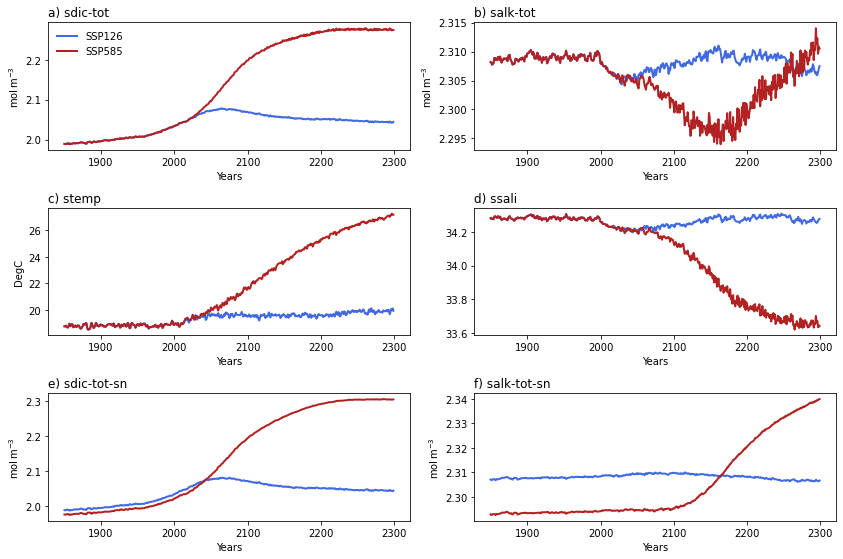

In [34]:
%%time 
print(datetime.datetime.now())
print('Timeseries of global sst, sdic, salk and sss')
print('Plot')

#=========================================
# Load data2plot
#=========================================

savedfile = dirout+'data2plot-timeseries-global-sst-sdic-salk-sss.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
        
#=========================================
# Figure parameters
#=========================================

simu_list = ['ssp126', 'ssp585']
var_list = list(data2plot[simu_list[0]].keys())
nvar = len(var_list)
nrow = 3
ncol = int(np.ceil(nvar/nrow))

scale = 30
fsize = (scale*cm2in, ncol/nrow/1* scale*cm2in) # width, height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

kwll = {
    'ssp126': dict(ls='-', lw=2, c='royalblue'), 
    'ssp585': dict(ls='-', lw=2, c='firebrick')
}

units = {
    'stemp': 'DegC', 
    'ssali': '',
    'sdic-tot': 'mol$\,$m$^{-3}$', 
    'salk-tot': 'mol$\,$m$^{-3}$', 
    'sdic-tot-sn': 'mol$\,$m$^{-3}$', 
    'salk-tot-sn': 'mol$\,$m$^{-3}$', 
    'air-stemp': 'DegC', 
    'atmco2': 'uatm'
}

#=========================================
# PLOT
#=========================================

for iii, vvv in enumerate(var_list): 
    
    zax = ax.flat[iii]
    
    for isimu, simu in enumerate(simu_list): 
        
        X = data2plot[simu][vvv]['X']
        Y = data2plot[simu][vvv]['Y']
        zax.plot(X, Y, label=simu.upper(), **kwll[simu])
        if isimu==0: 
            zwttl = subnum.pop()+') '+vvv
            zax.set_title(zwttl, loc='left')
            zax.set_xlabel('Years')
            zax.set_ylabel(units[vvv])
        #
    #
#
fig.tight_layout()

ax[0, 0].legend(frameon=False)


#=========================================
# Save figure
#=========================================

fignam = 'timeseries-global-sst-sdic-salk-sss.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 18s

# Timeseries of global air-stemp

## Load and prepare data2plot

In [59]:
%%time
%%memit -c
print(datetime.datetime.now())
print('Timeseries of global air-stemp')
print("Load and prepare data2plot")

var = 'air-stemp'

simu_list = ['ssp126', 'ssp585']

def compute_bnds(zw): 
    zwroll = np.roll(zw, 1)
    zwroll[0] = np.nan
    zwbnds = 0.5*(zw + zwroll)
    zwbnds[0] = zw[0] + (zw[0] - zwbnds[1])
    zwbnds = np.concatenate([zwbnds, [zw[-1] + (zw[-1] - zwbnds[-1])]])
    return zwbnds
#

def compute_area(zwlon, zwlat): 
    latbnds = compute_bnds(zwlat) *  np.pi/180
    lonbnds = compute_bnds(zwlon) *  np.pi/180
    # lat1 > lat0, lon1> lon0
    lat1 = latbnds[1:]
    lat0 = latbnds[:-1]
    lon1 = lonbnds[1:]
    lon0 = lonbnds[:-1]
    XXX1, YYY1 = np.meshgrid(lon1, lat1)
    XXX0, YYY0 = np.meshgrid(lon0, lat0)
    R = 6371*1000. #meter
    zwarea = (np.sin(YYY1) - np.sin(YYY0)) * (XXX1 - XXX0) * R**2
    return zwarea
#



data2plot = {}
for simu in simu_list: 
    zw = load_and_concat_hist_ssp(var, simu)
    zwarea = compute_area(zw.lon.values, zw.lat.values)
    area = NumpyArray_to_DataArray(zwarea, 'area', zw.isel(time=0).drop_vars(('time')))
    zw = zw.groupby('time.year').mean('time').weighted(area).mean(dim=('lat', 'lon'))
    data2plot[simu] = {'X': zw.year.values, 'Y': zw.values - 273.15}
#




2023-10-17 16:45:09.340481
Timeseries of global air-stemp
Load and prepare data2plot
func: load_and_concat_hist_ssp(air-stemp, ssp126, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: NumpyArray_to_DataArray
[########################################] | 100% Completed | 1.51 s
func: load_and_concat_hist_ssp(air-stemp, ssp585, zsavefile=cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl)
Done, loaded file: cc2300-230215-noresm2-lm/datasave-bgc-phy-noresm2-lm.pckl
func: NumpyArray_to_DataArray
[########################################] | 100% Completed | 1.51 s
peak memory: 2638.55 MiB, increment: 1407.74 MiB
CPU times: user 5.43 s, sys: 1.19 s, total: 6.62 s
Wall time: 6.13 s


## Plot

2023-10-15 17:59:11.285356
Timeseries of global sst, sdic, salk and sss
Plot
Done, figure saved: timeseries-global-sst-sdic-salk-sss.png
CPU times: user 867 ms, sys: 397 ms, total: 1.26 s
Wall time: 817 ms


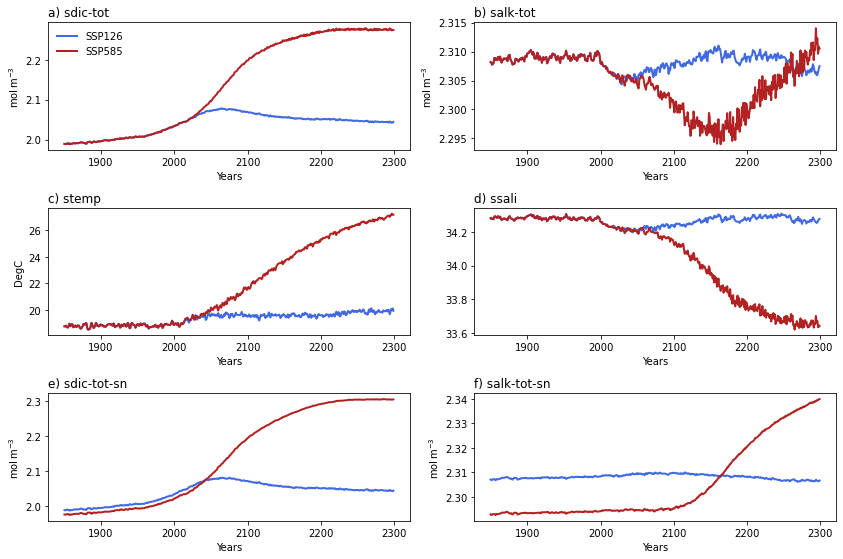

In [34]:
%%time 
print(datetime.datetime.now())
print('Timeseries of global air-stemp')
print('Plot')


#=========================================
# Figure parameters
#=========================================

simu_list = ['ssp126', 'ssp585']
var_list = list(data2plot[simu_list[0]].keys())
nvar = len(var_list)
nrow = 3
ncol = int(np.ceil(nvar/nrow))

scale = 30
fsize = (scale*cm2in, ncol/nrow/1* scale*cm2in) # width, height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#=========================================
# PLOTTING ARGS AND KWARGS
#=========================================

kwll = {
    'ssp126': dict(ls='-', lw=2, c='royalblue'), 
    'ssp585': dict(ls='-', lw=2, c='firebrick')
}

units = {
    'stemp': 'DegC', 
    'ssali': '',
    'sdic-tot': 'mol$\,$m$^{-3}$', 
    'salk-tot': 'mol$\,$m$^{-3}$', 
    'sdic-tot-sn': 'mol$\,$m$^{-3}$', 
    'salk-tot-sn': 'mol$\,$m$^{-3}$', 
    'air-stemp': 'DegC', 
    'atmco2': 'uatm'
}

#=========================================
# PLOT
#=========================================

for iii, vvv in enumerate(var_list): 
    
    zax = ax.flat[iii]
    
    for isimu, simu in enumerate(simu_list): 
        
        X = data2plot[simu][vvv]['X']
        Y = data2plot[simu][vvv]['Y']
        zax.plot(X, Y, label=simu.upper(), **kwll[simu])
        if isimu==0: 
            zwttl = subnum.pop()+') '+vvv
            zax.set_title(zwttl, loc='left')
            zax.set_xlabel('Years')
            zax.set_ylabel(units[vvv])
        #
    #
#
fig.tight_layout()

ax[0, 0].legend(frameon=False)


#=========================================
# Save figure
#=========================================

fignam = 'timeseries-global-sst-sdic-salk-sss.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Done, figure saved: '+fignam)

# ca. 18s

In [47]:
print(data2plot['ssp585']['stemp']['X'][-20:].mean())
print('SSP585')
print(data2plot['ssp585']['stemp']['Y'][-20:].mean())
print(data2plot['ssp585']['stemp']['Y'][:20].mean())
print(data2plot['ssp585']['stemp']['Y'][-20:].mean() - data2plot['ssp585']['stemp']['Y'][:20].mean())

print('SSP126')
print(data2plot['ssp126']['stemp']['Y'][-20:].mean())
print(data2plot['ssp126']['stemp']['Y'][:20].mean())
print(data2plot['ssp126']['stemp']['Y'][-20:].mean() - data2plot['ssp585']['stemp']['Y'][:20].mean())



2289.5
SSP585
27.01140031904045
18.783969176901728
8.227431142138723
SSP126
19.90989407686032
18.783969176901728
1.1259248999585907


In [48]:
print(data2plot['ssp585']['stemp']['X'][240:260].mean())
print('SSP585')
print(data2plot['ssp585']['stemp']['Y'][240:260].mean())
print(data2plot['ssp585']['stemp']['Y'][:20].mean())
print(data2plot['ssp585']['stemp']['Y'][240:260].mean() - data2plot['ssp585']['stemp']['Y'][:20].mean())

print('SSP126')
print(data2plot['ssp126']['stemp']['Y'][240:260].mean())
print(data2plot['ssp126']['stemp']['Y'][:20].mean())
print(data2plot['ssp126']['stemp']['Y'][240:260].mean() - data2plot['ssp585']['stemp']['Y'][:20].mean())



2099.5
SSP585
21.642340547631953
18.783969176901728
2.858371370730225
SSP126
19.582120159812767
18.783969176901728
0.7981509829110394


In [49]:
print(data2plot['ssp585']['stemp']['X'][180:200].mean())
print('SSP585')
print(data2plot['ssp585']['stemp']['Y'][180:200].mean())
print(data2plot['ssp585']['stemp']['Y'][:20].mean())
print(data2plot['ssp585']['stemp']['Y'][180:200].mean() - data2plot['ssp585']['stemp']['Y'][:20].mean())

print('SSP126')
print(data2plot['ssp126']['stemp']['Y'][180:200].mean())
print(data2plot['ssp126']['stemp']['Y'][:20].mean())
print(data2plot['ssp126']['stemp']['Y'][180:200].mean() - data2plot['ssp585']['stemp']['Y'][:20].mean())



2039.5
SSP585
19.67117561988186
18.783969176901728
0.8872064429801334
SSP126
19.493704215338465
18.783969176901728
0.7097350384367367
